# imports

In [1]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from data_viz_functions import *

random_seed = 42

# reading data

In [2]:
DATA_DIR = 'kaggle/input'

df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# preprocessing

In [3]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [4]:
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [5]:
# Заподнение пропускоы в ['education'] наиболее частым значением 'SCH'
data["education"].fillna(data.education.mode(), inplace=True)

In [6]:
data = pd.get_dummies(data, columns=['education'], dummy_na=True)

In [7]:
le = LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    
columns = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating']

for column in columns:
    data[column] = le.fit_transform(data[column])

In [8]:
data['age'] = np.log(data['age'] + 1)
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
data['income'] = np.log(data['income'] + 1)
data['bki_request_cnt'] = np.log(data.bki_request_cnt + 1)

In [9]:
# Нормализация численных данных
for column in num_cols:
    data[column] = StandardScaler().fit_transform(np.array(data[column].values).reshape(-1, 1))

In [10]:
data.sample(5, random_state=random_seed).T

74834     17526     75682     26882     28861
sex               0.000000  1.000000  0.000000  0.000000  1.000000
age              -1.130811 -0.773745  1.362924 -0.347997 -1.007707
car               0.000000  1.000000  0.000000  1.000000  0.000000
car_type          0.000000  1.000000  0.000000  0.000000  0.000000
decline_app_cnt  -0.418815 -0.418815 -0.418815 -0.418815 -0.418815
good_work         0.000000  0.000000  0.000000  0.000000  0.000000
score_bki         0.368124 -0.250086 -1.383239  0.317360 -0.992421
bki_request_cnt   1.109345 -1.334144 -1.334144 -0.281790 -0.281790
region_rating     6.000000  4.000000  3.000000  3.000000  3.000000
home_address      1.000000  1.000000  0.000000  0.000000  1.000000
work_address      2.000000  2.000000  2.000000  1.000000  2.000000
income            0.942139  0.942139 -0.314543  1.675407 -0.052834
sna               0.000000  1.000000  1.000000  1.000000  0.000000
first_time        2.000000  1.000000  2.000000  0.000000  3.000000
foreign_passport  0.000000  0.000000  0.000000  0.000000  0.000000
sample            1.000000  0.000000  1.000000  0.000000  0.000000
default           0.000000  0.000000  0.000000  0.000000  0.000000
education_ACD     0.000000  0.000000  0.000000  0.000000  0.000000
education_GRD     0.000000  1.000000  0.000000  0.000000  0.000000
education_PGR     0.000000  0.000000  0.000000  0.000000  0.000000
education_SCH     1.000000  0.000000  0.000000  1.000000  0.000000
education_UGR     0.000000  0.000000  1.000000  0.000000  1.000000
education_nan     0.000000  0.000000  0.000000  0.000000  0.000000

# undersampling

In [11]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

In [12]:
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [13]:
# undersampling

rus = RandomUnderSampler(random_state=random_seed)
X_us, y_us = rus.fit_resample(X, y)


X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(
    X_us, y_us, test_size=0.10, shuffle=True, random_state=random_seed
)

# simple model

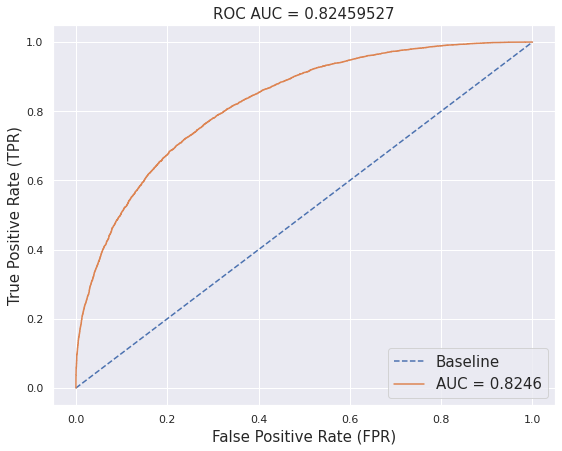

In [14]:
plot_roc_auc(
    y_train_us,
    CatBoostClassifier(silent=True)
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

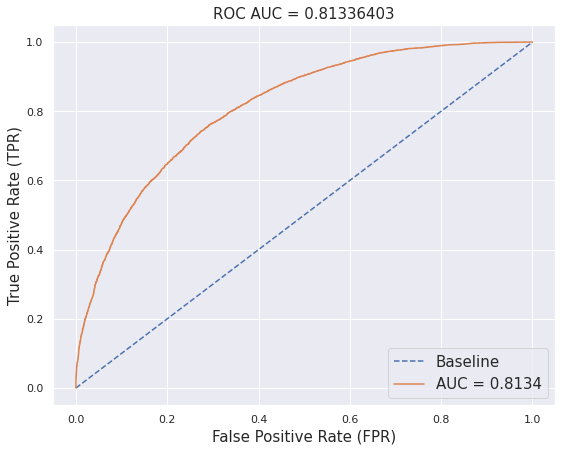

In [15]:
plot_roc_auc(
    y_train_us,
    LGBMClassifier()
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

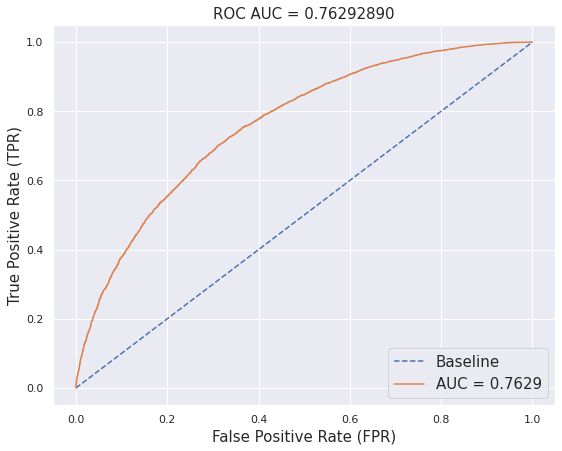

In [16]:
plot_roc_auc(
    y_train_us,
    HistGradientBoostingClassifier()
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

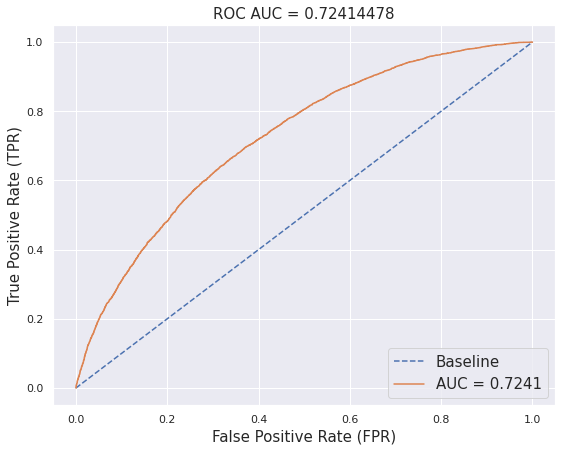

In [17]:
plot_roc_auc(
    y_train_us,
    LogisticRegression(solver="saga", max_iter=1000, random_state=random_seed) # уже хорошо отгридсёрченная в бейзлайне
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)


# parameter tuning

In [18]:
import optuna


def objective(trial):

    from sklearn.model_selection import cross_val_score

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = LGBMClassifier(**param)
    cv_roc_auc = cross_val_score(gbm, X_us, y_us, cv=8, scoring="roc_auc", n_jobs=-1)

    score = np.min(cv_roc_auc)
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=6000, n_trials=1000)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)

[I 2021-12-19 10:19:15,354] A new study created in memory with name: no-name-e2c6f4b3-4a2f-4aeb-b39a-8acc9ff3041f


[LightGBM] [Warning] bagging_fraction is set=0.7464431319259046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7464431319259046
[LightGBM] [Warning] lambda_l1 is set=3.940087840525212e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.940087840525212e-08
[LightGBM] [Warning] feature_fraction is set=0.5212133700019932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5212133700019932
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=8.359934278518425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.359934278518425
[LightGBM] [Warning] bagging_fraction is set=0.7464431319259046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7464431319259046
[LightGBM] [Warning] lambda_l1 is set=3.940087840525212e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.940087840525212e-08
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:19:21,760] Trial 0 finished with value: 0.7056751179674908 and parameters: {'lambda_l1': 3.940087840525212e-08, 'lambda_l2': 8.359934278518425, 'num_leaves': 132, 'feature_fraction': 0.5212133700019932, 'bagging_fraction': 0.7464431319259046, 'bagging_freq': 2, 'min_child_samples': 75}. Best is trial 0 with value: 0.7056751179674908.


[LightGBM] [Warning] bagging_fraction is set=0.8124326994146609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8124326994146609
[LightGBM] [Warning] lambda_l1 is set=0.12204165175854201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12204165175854201
[LightGBM] [Warning] feature_fraction is set=0.9245053563390374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9245053563390374
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.0023938167989490037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023938167989490037
[LightGBM] [Warning] bagging_fraction is set=0.8124326994146609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8124326994146609
[LightGBM] [Warning] lambda_l1 is set=0.12204165175854201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12204165175854201
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:19:27,667] Trial 1 finished with value: 0.6865474799112803 and parameters: {'lambda_l1': 0.12204165175854201, 'lambda_l2': 0.0023938167989490037, 'num_leaves': 187, 'feature_fraction': 0.9245053563390374, 'bagging_fraction': 0.8124326994146609, 'bagging_freq': 2, 'min_child_samples': 36}. Best is trial 0 with value: 0.7056751179674908.


[LightGBM] [Warning] bagging_fraction is set=0.53817832793884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.53817832793884
[LightGBM] [Warning] lambda_l1 is set=0.00014441466379058434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014441466379058434
[LightGBM] [Warning] feature_fraction is set=0.6429442716657934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6429442716657934
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.15330931686277932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15330931686277932
[LightGBM] [Warning] bagging_fraction is set=0.53817832793884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.53817832793884
[LightGBM] [Warning] lambda_l1 is set=0.00014441466379058434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014441466379058434[LightGBM] [Warning] bagging_fracti

[I 2021-12-19 10:19:31,545] Trial 2 finished with value: 0.698503802065269 and parameters: {'lambda_l1': 0.00014441466379058434, 'lambda_l2': 0.15330931686277932, 'num_leaves': 87, 'feature_fraction': 0.6429442716657934, 'bagging_fraction': 0.53817832793884, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 0 with value: 0.7056751179674908.


[LightGBM] [Warning] bagging_fraction is set=0.6876630188847712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6876630188847712
[LightGBM] [Warning] lambda_l1 is set=0.0029603191296903495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029603191296903495
[LightGBM] [Warning] feature_fraction is set=0.5450387603183752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5450387603183752
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.21896358233028693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21896358233028693
[LightGBM] [Warning] bagging_fraction is set=0.6876630188847712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6876630188847712
[LightGBM] [Warning] lambda_l1 is set=0.0029603191296903495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029603191296903495
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:19:34,594] Trial 3 finished with value: 0.7037748139771439 and parameters: {'lambda_l1': 0.0029603191296903495, 'lambda_l2': 0.21896358233028693, 'num_leaves': 251, 'feature_fraction': 0.5450387603183752, 'bagging_fraction': 0.6876630188847712, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 0 with value: 0.7056751179674908.


[LightGBM] [Warning] bagging_fraction is set=0.655865398280886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.655865398280886
[LightGBM] [Warning] lambda_l1 is set=2.1966395438434913e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1966395438434913e-07
[LightGBM] [Warning] bagging_fraction is set=0.655865398280886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.655865398280886
[LightGBM] [Warning] lambda_l1 is set=2.1966395438434913e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1966395438434913e-07
[LightGBM] [Warning] feature_fraction is set=0.6550766574414506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6550766574414506
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=9.990714837107639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.990714837107639
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:19:38,698] Trial 4 finished with value: 0.7091777104834408 and parameters: {'lambda_l1': 2.1966395438434913e-07, 'lambda_l2': 9.990714837107639, 'num_leaves': 221, 'feature_fraction': 0.6550766574414506, 'bagging_fraction': 0.655865398280886, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 4 with value: 0.7091777104834408.


[LightGBM] [Warning] bagging_fraction is set=0.7757984065477215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7757984065477215
[LightGBM] [Warning] lambda_l1 is set=0.8944095441334513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8944095441334513
[LightGBM] [Warning] bagging_fraction is set=0.7757984065477215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7757984065477215
[LightGBM] [Warning] feature_fraction is set=0.45555369009223623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45555369009223623
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=0.8944095441334513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8944095441334513
[LightGBM] [Warning] feature_fraction is set=0.45555369009223623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45555369009223623
[LightGBM] [Warning]

[I 2021-12-19 10:19:43,454] Trial 5 finished with value: 0.6968956843863213 and parameters: {'lambda_l1': 0.8944095441334513, 'lambda_l2': 0.0035488195073039375, 'num_leaves': 161, 'feature_fraction': 0.45555369009223623, 'bagging_fraction': 0.7757984065477215, 'bagging_freq': 4, 'min_child_samples': 26}. Best is trial 4 with value: 0.7091777104834408.


[LightGBM] [Warning] bagging_fraction is set=0.9948816744131753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9948816744131753
[LightGBM] [Warning] lambda_l1 is set=0.030119498161305346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030119498161305346
[LightGBM] [Warning] feature_fraction is set=0.43915841279851214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43915841279851214
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.7300364401848643e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7300364401848643e-08
[LightGBM] [Warning] bagging_fraction is set=0.9948816744131753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9948816744131753[LightGBM] [Warning] bagging_fraction is set=0.9948816744131753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9948816744131753

[LightGBM] [Warn

[I 2021-12-19 10:19:47,263] Trial 6 finished with value: 0.7057253944150881 and parameters: {'lambda_l1': 0.030119498161305346, 'lambda_l2': 1.7300364401848643e-08, 'num_leaves': 93, 'feature_fraction': 0.43915841279851214, 'bagging_fraction': 0.9948816744131753, 'bagging_freq': 2, 'min_child_samples': 71}. Best is trial 4 with value: 0.7091777104834408.


[LightGBM] [Warning] bagging_fraction is set=0.5932141998101843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5932141998101843
[LightGBM] [Warning] lambda_l1 is set=0.055049597322993256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.055049597322993256
[LightGBM] [Warning] feature_fraction is set=0.4643826199972192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4643826199972192
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.2116820213125554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2116820213125554
[LightGBM] [Warning] bagging_fraction is set=0.5932141998101843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5932141998101843
[LightGBM] [Warning] lambda_l1 is set=0.055049597322993256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.055049597322993256
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:19:50,438] Trial 7 finished with value: 0.7027590840068436 and parameters: {'lambda_l1': 0.055049597322993256, 'lambda_l2': 0.2116820213125554, 'num_leaves': 183, 'feature_fraction': 0.4643826199972192, 'bagging_fraction': 0.5932141998101843, 'bagging_freq': 4, 'min_child_samples': 82}. Best is trial 4 with value: 0.7091777104834408.


[LightGBM] [Warning] bagging_fraction is set=0.9547581486705451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9547581486705451
[LightGBM] [Warning] lambda_l1 is set=4.91782167180402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.91782167180402
[LightGBM] [Warning] feature_fraction is set=0.45621615264853915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45621615264853915
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.9042759397480336e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9042759397480336e-07
[LightGBM] [Warning] bagging_fraction is set=0.9547581486705451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9547581486705451
[LightGBM] [Warning] lambda_l1 is set=4.91782167180402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.91782167180402
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 10:19:53,089] Trial 8 finished with value: 0.7158856086947651 and parameters: {'lambda_l1': 4.91782167180402, 'lambda_l2': 2.9042759397480336e-07, 'num_leaves': 17, 'feature_fraction': 0.45621615264853915, 'bagging_fraction': 0.9547581486705451, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 8 with value: 0.7158856086947651.


[LightGBM] [Warning] bagging_fraction is set=0.9972760474649643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9972760474649643
[LightGBM] [Warning] lambda_l1 is set=0.8596602369901214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8596602369901214
[LightGBM] [Warning] feature_fraction is set=0.6186388414525914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6186388414525914
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00016635577361141763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016635577361141763
[LightGBM] [Warning] bagging_fraction is set=0.9972760474649643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9972760474649643
[LightGBM] [Warning] lambda_l1 is set=0.8596602369901214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8596602369901214
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:19:56,277] Trial 9 finished with value: 0.7092002984526512 and parameters: {'lambda_l1': 0.8596602369901214, 'lambda_l2': 0.00016635577361141763, 'num_leaves': 72, 'feature_fraction': 0.6186388414525914, 'bagging_fraction': 0.9972760474649643, 'bagging_freq': 7, 'min_child_samples': 67}. Best is trial 8 with value: 0.7158856086947651.


[LightGBM] [Warning] bagging_fraction is set=0.4529627344779743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4529627344779743
[LightGBM] [Warning] lambda_l1 is set=4.110574630635017e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.110574630635017e-05
[LightGBM] [Warning] feature_fraction is set=0.8239740723559628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8239740723559628
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.004536127393882e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.004536127393882e-08
[LightGBM] [Warning] bagging_fraction is set=0.4529627344779743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4529627344779743
[LightGBM] [Warning] lambda_l1 is set=4.110574630635017e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.110574630635017e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:19:58,054] Trial 10 finished with value: 0.7115785930172572 and parameters: {'lambda_l1': 4.110574630635017e-05, 'lambda_l2': 6.004536127393882e-08, 'num_leaves': 18, 'feature_fraction': 0.8239740723559628, 'bagging_fraction': 0.4529627344779743, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 8 with value: 0.7158856086947651.


[LightGBM] [Warning] bagging_fraction is set=0.40390336933239585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40390336933239585
[LightGBM] [Warning] lambda_l1 is set=6.201889515322274e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.201889515322274e-06
[LightGBM] [Warning] feature_fraction is set=0.8344417624920129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8344417624920129
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.560558546866135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.560558546866135e-08
[LightGBM] [Warning] bagging_fraction is set=0.40390336933239585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40390336933239585
[LightGBM] [Warning] lambda_l1 is set=6.201889515322274e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.201889515322274e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:19:59,773] Trial 11 finished with value: 0.7129666601574454 and parameters: {'lambda_l1': 6.201889515322274e-06, 'lambda_l2': 2.560558546866135e-08, 'num_leaves': 17, 'feature_fraction': 0.8344417624920129, 'bagging_fraction': 0.40390336933239585, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 8 with value: 0.7158856086947651.


[LightGBM] [Warning] bagging_fraction is set=0.40084698590702017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40084698590702017
[LightGBM] [Warning] lambda_l1 is set=2.7043634924974595e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7043634924974595e-06
[LightGBM] [Warning] feature_fraction is set=0.77564240555357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.77564240555357
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.63920680734123e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.63920680734123e-06
[LightGBM] [Warning] bagging_fraction is set=0.40084698590702017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40084698590702017
[LightGBM] [Warning] lambda_l1 is set=2.7043634924974595e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7043634924974595e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:20:01,017] Trial 12 finished with value: 0.7153959598138169 and parameters: {'lambda_l1': 2.7043634924974595e-06, 'lambda_l2': 1.63920680734123e-06, 'num_leaves': 5, 'feature_fraction': 0.77564240555357, 'bagging_fraction': 0.40084698590702017, 'bagging_freq': 5, 'min_child_samples': 51}. Best is trial 8 with value: 0.7158856086947651.


[LightGBM] [Warning] bagging_fraction is set=0.9032275186760987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9032275186760987
[LightGBM] [Warning] lambda_l1 is set=5.284206572489698e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.284206572489698e-07
[LightGBM] [Warning] feature_fraction is set=0.7849982611051248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7849982611051248
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.35864217521256e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.35864217521256e-06
[LightGBM] [Warning] bagging_fraction is set=0.9032275186760987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9032275186760987
[LightGBM] [Warning] lambda_l1 is set=5.284206572489698e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.284206572489698e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:20:02,717] Trial 13 finished with value: 0.7171315902221782 and parameters: {'lambda_l1': 5.284206572489698e-07, 'lambda_l2': 7.35864217521256e-06, 'num_leaves': 5, 'feature_fraction': 0.7849982611051248, 'bagging_fraction': 0.9032275186760987, 'bagging_freq': 5, 'min_child_samples': 28}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.8967829276549759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967829276549759
[LightGBM] [Warning] lambda_l1 is set=5.363212143343358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.363212143343358
[LightGBM] [Warning] feature_fraction is set=0.7385206279736908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7385206279736908
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.532076198538615e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.532076198538615e-06
[LightGBM] [Warning] bagging_fraction is set=0.8967829276549759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967829276549759
[LightGBM] [Warning] lambda_l1 is set=5.363212143343358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.363212143343358
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 10:20:06,243] Trial 14 finished with value: 0.7108637930883729 and parameters: {'lambda_l1': 5.363212143343358, 'lambda_l2': 4.532076198538615e-06, 'num_leaves': 52, 'feature_fraction': 0.7385206279736908, 'bagging_fraction': 0.8967829276549759, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.8788335092230574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8788335092230574
[LightGBM] [Warning] lambda_l1 is set=5.771319973317634e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.771319973317634e-07
[LightGBM] [Warning] feature_fraction is set=0.9318450611186067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9318450611186067
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.2887475030193995e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2887475030193995e-06
[LightGBM] [Warning] bagging_fraction is set=0.8788335092230574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8788335092230574
[LightGBM] [Warning] lambda_l1 is set=5.771319973317634e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.771319973317634e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:20:09,511] Trial 15 finished with value: 0.7037915727930097 and parameters: {'lambda_l1': 5.771319973317634e-07, 'lambda_l2': 5.2887475030193995e-06, 'num_leaves': 46, 'feature_fraction': 0.9318450611186067, 'bagging_fraction': 0.8788335092230574, 'bagging_freq': 5, 'min_child_samples': 28}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.908130303568454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.908130303568454
[LightGBM] [Warning] lambda_l1 is set=0.0018059343086388722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018059343086388722
[LightGBM] [Warning] feature_fraction is set=0.9937333529013437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9937333529013437
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.008192986814539e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.008192986814539e-07
[LightGBM] [Warning] bagging_fraction is set=0.908130303568454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.908130303568454[LightGBM] [Warning] bagging_fraction is set=0.908130303568454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.908130303568454
[LightGBM] [Warning] lamb

[I 2021-12-19 10:20:14,898] Trial 16 finished with value: 0.688118436737656 and parameters: {'lambda_l1': 0.0018059343086388722, 'lambda_l2': 6.008192986814539e-07, 'num_leaves': 112, 'feature_fraction': 0.9937333529013437, 'bagging_fraction': 0.908130303568454, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.8421422161883085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8421422161883085
[LightGBM] [Warning] lambda_l1 is set=1.631451993146994e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.631451993146994e-08
[LightGBM] [Warning] feature_fraction is set=0.5593461251708407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5593461251708407
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.746187635735502e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.746187635735502e-05
[LightGBM] [Warning] bagging_fraction is set=0.8421422161883085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8421422161883085
[LightGBM] [Warning] lambda_l1 is set=1.631451993146994e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.631451993146994e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:20:17,707] Trial 17 finished with value: 0.7056554445749527 and parameters: {'lambda_l1': 1.631451993146994e-08, 'lambda_l2': 6.746187635735502e-05, 'num_leaves': 43, 'feature_fraction': 0.5593461251708407, 'bagging_fraction': 0.8421422161883085, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.935552771994705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.935552771994705
[LightGBM] [Warning] lambda_l1 is set=0.0008886608642808685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008886608642808685
[LightGBM] [Warning] feature_fraction is set=0.4008081419330199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4008081419330199
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.8396522650471963e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8396522650471963e-07
[LightGBM] [Warning] bagging_fraction is set=0.935552771994705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.935552771994705
[LightGBM] [Warning] lambda_l1 is set=0.0008886608642808685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008886608642808685
[LightGBM] [Warning] feature

[I 2021-12-19 10:20:19,300] Trial 18 finished with value: 0.7101034528989837 and parameters: {'lambda_l1': 0.0008886608642808685, 'lambda_l2': 2.8396522650471963e-07, 'num_leaves': 3, 'feature_fraction': 0.4008081419330199, 'bagging_fraction': 0.935552771994705, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.9626223378652522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9626223378652522
[LightGBM] [Warning] lambda_l1 is set=2.6762968072274516e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6762968072274516e-05
[LightGBM] [Warning] feature_fraction is set=0.7073543142321628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7073543142321628
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.137323586249117e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.137323586249117e-05
[LightGBM] [Warning] bagging_fraction is set=0.9626223378652522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9626223378652522
[LightGBM] [Warning] lambda_l1 is set=2.6762968072274516e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6762968072274516e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:20:21,775] Trial 19 finished with value: 0.7071987129229415 and parameters: {'lambda_l1': 2.6762968072274516e-05, 'lambda_l2': 2.137323586249117e-05, 'num_leaves': 41, 'feature_fraction': 0.7073543142321628, 'bagging_fraction': 0.9626223378652522, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.8408627109015453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8408627109015453
[LightGBM] [Warning] lambda_l1 is set=0.005797880331280626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005797880331280626
[LightGBM] [Warning] feature_fraction is set=0.7987519725943604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7987519725943604
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0009202231317580223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009202231317580223
[LightGBM] [Warning] bagging_fraction is set=0.8408627109015453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8408627109015453
[LightGBM] [Warning] lambda_l1 is set=0.005797880331280626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005797880331280626
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:20:25,847] Trial 20 finished with value: 0.6934900015447256 and parameters: {'lambda_l1': 0.005797880331280626, 'lambda_l2': 0.0009202231317580223, 'num_leaves': 133, 'feature_fraction': 0.7987519725943604, 'bagging_fraction': 0.8408627109015453, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.6008000108182376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6008000108182376
[LightGBM] [Warning] bagging_fraction is set=0.6008000108182376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6008000108182376
[LightGBM] [Warning] lambda_l1 is set=1.9789728159540274e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9789728159540274e-06
[LightGBM] [Warning] feature_fraction is set=0.7889947099442394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7889947099442394
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=8.434609266525343e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.434609266525343e-07
[LightGBM] [Warning] lambda_l1 is set=1.9789728159540274e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9789728159540274e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:20:27,313] Trial 21 finished with value: 0.7166455845620702 and parameters: {'lambda_l1': 1.9789728159540274e-06, 'lambda_l2': 8.434609266525343e-07, 'num_leaves': 7, 'feature_fraction': 0.7889947099442394, 'bagging_fraction': 0.6008000108182376, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.6067493401634324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6067493401634324
[LightGBM] [Warning] lambda_l1 is set=2.3720525887150934e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3720525887150934e-07
[LightGBM] [Warning] feature_fraction is set=0.8697180342389553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8697180342389553
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.0328162359172072e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0328162359172072e-07
[LightGBM] [Warning] bagging_fraction is set=0.6067493401634324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6067493401634324
[LightGBM] [Warning] lambda_l1 is set=2.3720525887150934e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3720525887150934e-07
[LightGBM] [Warning]

[I 2021-12-19 10:20:29,331] Trial 22 finished with value: 0.7090144941897915 and parameters: {'lambda_l1': 2.3720525887150934e-07, 'lambda_l2': 2.0328162359172072e-07, 'num_leaves': 26, 'feature_fraction': 0.8697180342389553, 'bagging_fraction': 0.6067493401634324, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.5652732573592117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5652732573592117
[LightGBM] [Warning] lambda_l1 is set=2.484448979871926e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.484448979871926e-06
[LightGBM] [Warning] feature_fraction is set=0.7415259802440787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7415259802440787
[LightGBM] [Warning] bagging_fraction is set=0.5652732573592117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5652732573592117
[LightGBM] [Warning] lambda_l1 is set=2.484448979871926e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.484448979871926e-06
[LightGBM] [Warning] feature_fraction is set=0.7415259802440787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7415259802440787
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [

[I 2021-12-19 10:20:32,067] Trial 23 finished with value: 0.7015611929945235 and parameters: {'lambda_l1': 2.484448979871926e-06, 'lambda_l2': 1.5187663044032643e-05, 'num_leaves': 68, 'feature_fraction': 0.7415259802440787, 'bagging_fraction': 0.5652732573592117, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.729674060786782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.729674060786782
[LightGBM] [Warning] lambda_l1 is set=0.00013941427198695466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013941427198695466
[LightGBM] [Warning] feature_fraction is set=0.8677164504170995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8677164504170995
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0397327651125581e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0397327651125581e-06
[LightGBM] [Warning] bagging_fraction is set=0.729674060786782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.729674060786782
[LightGBM] [Warning] lambda_l1 is set=0.00013941427198695466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013941427198695466
[LightGBM] [Warning] fea

[I 2021-12-19 10:20:34,287] Trial 24 finished with value: 0.7103668577657438 and parameters: {'lambda_l1': 0.00013941427198695466, 'lambda_l2': 1.0397327651125581e-06, 'num_leaves': 24, 'feature_fraction': 0.8677164504170995, 'bagging_fraction': 0.729674060786782, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.5150073009466924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5150073009466924
[LightGBM] [Warning] lambda_l1 is set=1.2562736350220427e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2562736350220427e-05
[LightGBM] [Warning] feature_fraction is set=0.6894255011754586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6894255011754586
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.0625660628958349e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0625660628958349e-07
[LightGBM] [Warning] bagging_fraction is set=0.5150073009466924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5150073009466924
[LightGBM] [Warning] lambda_l1 is set=1.2562736350220427e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2562736350220427e-05
[LightGBM] [Warning]

[I 2021-12-19 10:20:36,994] Trial 25 finished with value: 0.6995107883055525 and parameters: {'lambda_l1': 1.2562736350220427e-05, 'lambda_l2': 1.0625660628958349e-07, 'num_leaves': 59, 'feature_fraction': 0.6894255011754586, 'bagging_fraction': 0.5150073009466924, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.6472573037420577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6472573037420577
[LightGBM] [Warning] lambda_l1 is set=6.194183649602661e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.194183649602661e-08
[LightGBM] [Warning] feature_fraction is set=0.6017967081039175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6017967081039175
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.0149250949083994e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0149250949083994e-08
[LightGBM] [Warning] bagging_fraction is set=0.6472573037420577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6472573037420577
[LightGBM] [Warning] lambda_l1 is set=6.194183649602661e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.194183649602661e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:20:38,427] Trial 26 finished with value: 0.7032913585716243 and parameters: {'lambda_l1': 6.194183649602661e-08, 'lambda_l2': 1.0149250949083994e-08, 'num_leaves': 2, 'feature_fraction': 0.6017967081039175, 'bagging_fraction': 0.6472573037420577, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.7818081426523299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7818081426523299
[LightGBM] [Warning] lambda_l1 is set=6.87809961221467e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.87809961221467e-07
[LightGBM] [Warning] feature_fraction is set=0.7658436822771855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7658436822771855
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.588234298333216e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.588234298333216e-06
[LightGBM] [Warning] bagging_fraction is set=0.7818081426523299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7818081426523299
[LightGBM] [Warning] lambda_l1 is set=6.87809961221467e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.87809961221467e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:20:40,494] Trial 27 finished with value: 0.7080796437221476 and parameters: {'lambda_l1': 6.87809961221467e-07, 'lambda_l2': 3.588234298333216e-06, 'num_leaves': 29, 'feature_fraction': 0.7658436822771855, 'bagging_fraction': 0.7818081426523299, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.9518986529029827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9518986529029827
[LightGBM] [Warning] lambda_l1 is set=0.00031636487026769544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00031636487026769544
[LightGBM] [Warning] feature_fraction is set=0.7010375076165922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7010375076165922
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.811511202589173e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.811511202589173e-05
[LightGBM] [Warning] bagging_fraction is set=0.9518986529029827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9518986529029827
[LightGBM] [Warning] lambda_l1 is set=0.00031636487026769544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00031636487026769544
[LightGBM] [Warning] f

[I 2021-12-19 10:20:43,690] Trial 28 finished with value: 0.704308910152345 and parameters: {'lambda_l1': 0.00031636487026769544, 'lambda_l2': 3.811511202589173e-05, 'num_leaves': 88, 'feature_fraction': 0.7010375076165922, 'bagging_fraction': 0.9518986529029827, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.7391071132437629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7391071132437629
[LightGBM] [Warning] lambda_l1 is set=7.687154322137747e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.687154322137747e-08
[LightGBM] [Warning] feature_fraction is set=0.9025143226699712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9025143226699712
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.937812434262137e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.937812434262137e-07
[LightGBM] [Warning] bagging_fraction is set=0.7391071132437629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7391071132437629
[LightGBM] [Warning] lambda_l1 is set=7.687154322137747e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.687154322137747e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:20:47,894] Trial 29 finished with value: 0.691900828614148 and parameters: {'lambda_l1': 7.687154322137747e-08, 'lambda_l2': 5.937812434262137e-07, 'num_leaves': 115, 'feature_fraction': 0.9025143226699712, 'bagging_fraction': 0.7391071132437629, 'bagging_freq': 7, 'min_child_samples': 65}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.8745176454043018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8745176454043018
[LightGBM] [Warning] lambda_l1 is set=1.44086311550158e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.44086311550158e-06
[LightGBM] [Warning] feature_fraction is set=0.9655156932451727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9655156932451727
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.1481828626149866e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1481828626149866e-05
[LightGBM] [Warning] bagging_fraction is set=0.8745176454043018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8745176454043018
[LightGBM] [Warning] lambda_l1 is set=1.44086311550158e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.44086311550158e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:20:50,361] Trial 30 finished with value: 0.7097620831062392 and parameters: {'lambda_l1': 1.44086311550158e-06, 'lambda_l2': 1.1481828626149866e-05, 'num_leaves': 37, 'feature_fraction': 0.9655156932451727, 'bagging_fraction': 0.8745176454043018, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.47126189732004925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47126189732004925
[LightGBM] [Warning] lambda_l1 is set=5.43283511213431e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.43283511213431e-06
[LightGBM] [Warning] feature_fraction is set=0.7870693698906907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7870693698906907
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.8050485501439863e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8050485501439863e-06
[LightGBM] [Warning] bagging_fraction is set=0.47126189732004925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47126189732004925
[LightGBM] [Warning] lambda_l1 is set=5.43283511213431e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.43283511213431e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:20:51,662] Trial 31 finished with value: 0.715697254177317 and parameters: {'lambda_l1': 5.43283511213431e-06, 'lambda_l2': 1.8050485501439863e-06, 'num_leaves': 6, 'feature_fraction': 0.7870693698906907, 'bagging_fraction': 0.47126189732004925, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.476197117389044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.476197117389044
[LightGBM] [Warning] lambda_l1 is set=7.607720586211692e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.607720586211692e-06
[LightGBM] [Warning] feature_fraction is set=0.8158038743551507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8158038743551507
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.89357065333086e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.89357065333086e-06
[LightGBM] [Warning] bagging_fraction is set=0.476197117389044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.476197117389044
[LightGBM] [Warning] lambda_l1 is set=7.607720586211692e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.607720586211692e-06
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:20:53,186] Trial 32 finished with value: 0.709994520595856 and parameters: {'lambda_l1': 7.607720586211692e-06, 'lambda_l2': 1.89357065333086e-06, 'num_leaves': 15, 'feature_fraction': 0.8158038743551507, 'bagging_fraction': 0.476197117389044, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.49724281084752003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49724281084752003
[LightGBM] [Warning] lambda_l1 is set=1.8018456125991545e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8018456125991545e-08
[LightGBM] [Warning] feature_fraction is set=0.7442717319176781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7442717319176781
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=8.720328906124663e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.720328906124663e-08
[LightGBM] [Warning] bagging_fraction is set=0.49724281084752003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49724281084752003
[LightGBM] [Warning] lambda_l1 is set=1.8018456125991545e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8018456125991545e-08
[LightGBM] [Warnin

[I 2021-12-19 10:20:54,123] Trial 33 finished with value: 0.7018643089684439 and parameters: {'lambda_l1': 1.8018456125991545e-08, 'lambda_l2': 8.720328906124663e-08, 'num_leaves': 2, 'feature_fraction': 0.7442717319176781, 'bagging_fraction': 0.49724281084752003, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.5512993299267802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5512993299267802
[LightGBM] [Warning] lambda_l1 is set=1.445514661324645e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.445514661324645e-07
[LightGBM] [Warning] feature_fraction is set=0.8745871474375416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8745871474375416
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.00020924745762154794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020924745762154794
[LightGBM] [Warning] bagging_fraction is set=0.5512993299267802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5512993299267802
[LightGBM] [Warning] lambda_l1 is set=1.445514661324645e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.445514661324645e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:20:56,224] Trial 34 finished with value: 0.7080636135504498 and parameters: {'lambda_l1': 1.445514661324645e-07, 'lambda_l2': 0.00020924745762154794, 'num_leaves': 32, 'feature_fraction': 0.8745871474375416, 'bagging_fraction': 0.5512993299267802, 'bagging_freq': 5, 'min_child_samples': 43}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.6960052059600763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6960052059600763
[LightGBM] [Warning] lambda_l1 is set=3.845625537904902e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.845625537904902e-05
[LightGBM] [Warning] feature_fraction is set=0.7828630693829135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7828630693829135
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.02218829254384986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02218829254384986
[LightGBM] [Warning] bagging_fraction is set=0.6960052059600763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6960052059600763
[LightGBM] [Warning] lambda_l1 is set=3.845625537904902e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.845625537904902e-05
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:20:59,233] Trial 35 finished with value: 0.7028421494420043 and parameters: {'lambda_l1': 3.845625537904902e-05, 'lambda_l2': 0.02218829254384986, 'num_leaves': 72, 'feature_fraction': 0.7828630693829135, 'bagging_fraction': 0.6960052059600763, 'bagging_freq': 3, 'min_child_samples': 64}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.6213234284914817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6213234284914817
[LightGBM] [Warning] lambda_l1 is set=0.0001393988477971122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001393988477971122
[LightGBM] [Warning] feature_fraction is set=0.6805943871485822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6805943871485822
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.1322854324408394e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1322854324408394e-07
[LightGBM] [Warning] bagging_fraction is set=0.6213234284914817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6213234284914817
[LightGBM] [Warning] lambda_l1 is set=0.0001393988477971122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001393988477971122
[LightGBM] [Warning] fea

[I 2021-12-19 10:21:00,966] Trial 36 finished with value: 0.7095398466349756 and parameters: {'lambda_l1': 0.0001393988477971122, 'lambda_l2': 4.1322854324408394e-07, 'num_leaves': 17, 'feature_fraction': 0.6805943871485822, 'bagging_fraction': 0.6213234284914817, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.459990547146448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.459990547146448
[LightGBM] [Warning] lambda_l1 is set=5.788939612056383e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.788939612056383e-07
[LightGBM] [Warning] feature_fraction is set=0.5081656236683492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5081656236683492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.5785563102352854e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5785563102352854e-08
[LightGBM] [Warning] bagging_fraction is set=0.459990547146448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.459990547146448
[LightGBM] [Warning] lambda_l1 is set=5.788939612056383e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.788939612056383e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:21:05,358] Trial 37 finished with value: 0.6908544955887882 and parameters: {'lambda_l1': 5.788939612056383e-07, 'lambda_l2': 4.5785563102352854e-08, 'num_leaves': 246, 'feature_fraction': 0.5081656236683492, 'bagging_fraction': 0.459990547146448, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.7997026042117753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7997026042117753
[LightGBM] [Warning] lambda_l1 is set=3.583330371819675e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.583330371819675e-06
[LightGBM] [Warning] bagging_fraction is set=0.7997026042117753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7997026042117753
[LightGBM] [Warning] lambda_l1 is set=3.583330371819675e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.583330371819675e-06
[LightGBM] [Warning] feature_fraction is set=0.8414993998757484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8414993998757484
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.86726983313352e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.86726983313352e-05
[LightGBM] [Warning] feature

[I 2021-12-19 10:21:08,522] Trial 38 finished with value: 0.7058193895127703 and parameters: {'lambda_l1': 3.583330371819675e-06, 'lambda_l2': 6.86726983313352e-05, 'num_leaves': 58, 'feature_fraction': 0.8414993998757484, 'bagging_fraction': 0.7997026042117753, 'bagging_freq': 4, 'min_child_samples': 74}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.6746856050398313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6746856050398313
[LightGBM] [Warning] lambda_l1 is set=8.379930798263883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.379930798263883
[LightGBM] [Warning] feature_fraction is set=0.6568473986717701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6568473986717701
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0006511643288555838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006511643288555838
[LightGBM] [Warning] bagging_fraction is set=0.6746856050398313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6746856050398313
[LightGBM] [Warning] lambda_l1 is set=8.379930798263883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.379930798263883
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 10:21:10,998] Trial 39 finished with value: 0.7141674657464376 and parameters: {'lambda_l1': 8.379930798263883, 'lambda_l2': 0.0006511643288555838, 'num_leaves': 154, 'feature_fraction': 0.6568473986717701, 'bagging_fraction': 0.6746856050398313, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.8407671534904461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8407671534904461
[LightGBM] [Warning] lambda_l1 is set=0.011907357854721978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011907357854721978
[LightGBM] [Warning] feature_fraction is set=0.5124743968318417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5124743968318417
[LightGBM] [Warning] bagging_fraction is set=0.8407671534904461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8407671534904461
[LightGBM] [Warning] lambda_l1 is set=0.011907357854721978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011907357854721978
[LightGBM] [Warning] feature_fraction is set=0.5124743968318417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5124743968318417
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7[LightGBM] [Warni

[I 2021-12-19 10:21:14,994] Trial 40 finished with value: 0.7042571764164114 and parameters: {'lambda_l1': 0.011907357854721978, 'lambda_l2': 2.0150501151302971e-07, 'num_leaves': 100, 'feature_fraction': 0.5124743968318417, 'bagging_fraction': 0.8407671534904461, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.4042746019094717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4042746019094717
[LightGBM] [Warning] lambda_l1 is set=1.176851361265622e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.176851361265622e-06
[LightGBM] [Warning] feature_fraction is set=0.7908287644901492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7908287644901492
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.7469815399914692e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7469815399914692e-06
[LightGBM] [Warning] bagging_fraction is set=0.4042746019094717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4042746019094717
[LightGBM] [Warning] lambda_l1 is set=1.176851361265622e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.176851361265622e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:21:16,717] Trial 41 finished with value: 0.714432692223618 and parameters: {'lambda_l1': 1.176851361265622e-06, 'lambda_l2': 1.7469815399914692e-06, 'num_leaves': 10, 'feature_fraction': 0.7908287644901492, 'bagging_fraction': 0.4042746019094717, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.43103699957900543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43103699957900543
[LightGBM] [Warning] lambda_l1 is set=0.2406572635481473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2406572635481473
[LightGBM] [Warning] feature_fraction is set=0.7669376884612067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7669376884612067
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.7549363520942928e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7549363520942928e-06
[LightGBM] [Warning] bagging_fraction is set=0.43103699957900543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43103699957900543
[LightGBM] [Warning] lambda_l1 is set=0.2406572635481473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2406572635481473
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:21:18,778] Trial 42 finished with value: 0.7060554702232275 and parameters: {'lambda_l1': 0.2406572635481473, 'lambda_l2': 1.7549363520942928e-06, 'num_leaves': 31, 'feature_fraction': 0.7669376884612067, 'bagging_fraction': 0.43103699957900543, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.5287325010127222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5287325010127222
[LightGBM] [Warning] bagging_fraction is set=0.5287325010127222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5287325010127222
[LightGBM] [Warning] lambda_l1 is set=2.2879141040893147e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2879141040893147e-07
[LightGBM] [Warning] feature_fraction is set=0.7313542173052383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7313542173052383
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=8.255621272075196e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.255621272075196e-06
[LightGBM] [Warning] bagging_fraction is set=0.5287325010127222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5287325010127222
[LightGBM] [Warn

[I 2021-12-19 10:21:20,379] Trial 43 finished with value: 0.7157238496894518 and parameters: {'lambda_l1': 2.2879141040893147e-07, 'lambda_l2': 8.255621272075196e-06, 'num_leaves': 13, 'feature_fraction': 0.7313542173052383, 'bagging_fraction': 0.5287325010127222, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.5137919868429313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5137919868429313
[LightGBM] [Warning] lambda_l1 is set=2.75407713949361e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.75407713949361e-07
[LightGBM] [Warning] feature_fraction is set=0.7222309855308313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7222309855308313
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1582302987162625e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1582302987162625e-05
[LightGBM] [Warning] bagging_fraction is set=0.5137919868429313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5137919868429313
[LightGBM] [Warning] lambda_l1 is set=2.75407713949361e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.75407713949361e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:21:23,847] Trial 44 finished with value: 0.6950230688743613 and parameters: {'lambda_l1': 2.75407713949361e-07, 'lambda_l2': 1.1582302987162625e-05, 'num_leaves': 205, 'feature_fraction': 0.7222309855308313, 'bagging_fraction': 0.5137919868429313, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.5771663696494597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5771663696494597
[LightGBM] [Warning] lambda_l1 is set=1.7898951284488275e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7898951284488275e-05[LightGBM] [Warning] bagging_fraction is set=0.5771663696494597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5771663696494597
[LightGBM] [Warning] lambda_l1 is set=1.7898951284488275e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7898951284488275e-05
[LightGBM] [Warning] feature_fraction is set=0.6416473114316281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6416473114316281
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.060768284527262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.060768284527262

[LightGBM] [Warning] feature_f

[I 2021-12-19 10:21:25,629] Trial 45 finished with value: 0.7125935943433896 and parameters: {'lambda_l1': 1.7898951284488275e-05, 'lambda_l2': 1.060768284527262, 'num_leaves': 18, 'feature_fraction': 0.6416473114316281, 'bagging_fraction': 0.5771663696494597, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.5454938059689061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5454938059689061
[LightGBM] [Warning] lambda_l1 is set=8.696021406225457e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.696021406225457e-08
[LightGBM] [Warning] feature_fraction is set=0.5880757227826469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5880757227826469
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.910810928244626e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.910810928244626e-06
[LightGBM] [Warning] bagging_fraction is set=0.5454938059689061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5454938059689061
[LightGBM] [Warning] lambda_l1 is set=8.696021406225457e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.696021406225457e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:21:28,236] Trial 46 finished with value: 0.7015546351970108 and parameters: {'lambda_l1': 8.696021406225457e-08, 'lambda_l2': 6.910810928244626e-06, 'num_leaves': 50, 'feature_fraction': 0.5880757227826469, 'bagging_fraction': 0.5454938059689061, 'bagging_freq': 4, 'min_child_samples': 45}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.9808265495310492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9808265495310492
[LightGBM] [Warning] lambda_l1 is set=3.032442734412249e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.032442734412249e-08
[LightGBM] [Warning] feature_fraction is set=0.8137086624401717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8137086624401717
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.537751375495911e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.537751375495911e-05
[LightGBM] [Warning] bagging_fraction is set=0.9808265495310492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9808265495310492
[LightGBM] [Warning] lambda_l1 is set=3.032442734412249e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.032442734412249e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:21:31,401] Trial 47 finished with value: 0.699056114344672 and parameters: {'lambda_l1': 3.032442734412249e-08, 'lambda_l2': 3.537751375495911e-05, 'num_leaves': 77, 'feature_fraction': 0.8137086624401717, 'bagging_fraction': 0.9808265495310492, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.6395490968623815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395490968623815
[LightGBM] [Warning] bagging_fraction is set=0.6395490968623815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6395490968623815
[LightGBM] [Warning] lambda_l1 is set=6.630598367722992e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.630598367722992e-05
[LightGBM] [Warning] feature_fraction is set=0.842836712767506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.842836712767506
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.655865997729821e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.655865997729821e-07
[LightGBM] [Warning] lambda_l1 is set=6.630598367722992e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.630598367722992e-05
[LightGBM] [Warning] feature

[I 2021-12-19 10:21:33,322] Trial 48 finished with value: 0.7155045277948604 and parameters: {'lambda_l1': 6.630598367722992e-05, 'lambda_l2': 7.655865997729821e-07, 'num_leaves': 12, 'feature_fraction': 0.842836712767506, 'bagging_fraction': 0.6395490968623815, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.9168168596741698, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9168168596741698
[LightGBM] [Warning] lambda_l1 is set=5.194947702155908e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.194947702155908e-06
[LightGBM] [Warning] feature_fraction is set=0.745454823867251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.745454823867251
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.005468741957640225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005468741957640225
[LightGBM] [Warning] bagging_fraction is set=0.9168168596741698, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9168168596741698
[LightGBM] [Warning] lambda_l1 is set=5.194947702155908e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.194947702155908e-06
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:21:35,795] Trial 49 finished with value: 0.7058215754452745 and parameters: {'lambda_l1': 5.194947702155908e-06, 'lambda_l2': 0.005468741957640225, 'num_leaves': 38, 'feature_fraction': 0.745454823867251, 'bagging_fraction': 0.9168168596741698, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.5235262978615395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5235262978615395
[LightGBM] [Warning] lambda_l1 is set=1.004322991120544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.004322991120544
[LightGBM] [Warning] feature_fraction is set=0.6557123601733997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6557123601733997
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.905352239848192e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.905352239848192e-06
[LightGBM] [Warning] bagging_fraction is set=0.5235262978615395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5235262978615395
[LightGBM] [Warning] lambda_l1 is set=1.004322991120544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.004322991120544
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 10:21:37,680] Trial 50 finished with value: 0.7081612518689723 and parameters: {'lambda_l1': 1.004322991120544, 'lambda_l2': 3.905352239848192e-06, 'num_leaves': 22, 'feature_fraction': 0.6557123601733997, 'bagging_fraction': 0.5235262978615395, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.6262511376994515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6262511376994515
[LightGBM] [Warning] lambda_l1 is set=4.665682312476252e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.665682312476252e-05
[LightGBM] [Warning] feature_fraction is set=0.8476400550112454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8476400550112454
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.0339189446319368e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0339189446319368e-06
[LightGBM] [Warning] bagging_fraction is set=0.6262511376994515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6262511376994515[LightGBM] [Warning] bagging_fraction is set=0.6262511376994515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6262511376994515
[LightGBM] [Warni

[I 2021-12-19 10:21:39,287] Trial 51 finished with value: 0.716652871003751 and parameters: {'lambda_l1': 4.665682312476252e-05, 'lambda_l2': 1.0339189446319368e-06, 'num_leaves': 11, 'feature_fraction': 0.8476400550112454, 'bagging_fraction': 0.6262511376994515, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 13 with value: 0.7171315902221782.


[LightGBM] [Warning] bagging_fraction is set=0.5850431445914503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5850431445914503
[LightGBM] [Warning] lambda_l1 is set=1.470219280565269e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.470219280565269e-06
[LightGBM] [Warning] feature_fraction is set=0.9229884275634851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9229884275634851
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.7451260346532275e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7451260346532275e-07
[LightGBM] [Warning] bagging_fraction is set=0.5850431445914503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5850431445914503
[LightGBM] [Warning] lambda_l1 is set=1.470219280565269e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.470219280565269e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:21:40,784] Trial 52 finished with value: 0.719330638321437 and parameters: {'lambda_l1': 1.470219280565269e-06, 'lambda_l2': 1.7451260346532275e-07, 'num_leaves': 9, 'feature_fraction': 0.9229884275634851, 'bagging_fraction': 0.5850431445914503, 'bagging_freq': 5, 'min_child_samples': 63}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5941959065566261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5941959065566261
[LightGBM] [Warning] lambda_l1 is set=3.332603602197364e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.332603602197364e-07
[LightGBM] [Warning] feature_fraction is set=0.9213075415846127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9213075415846127
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.210563168881662e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.210563168881662e-08
[LightGBM] [Warning] bagging_fraction is set=0.5941959065566261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5941959065566261
[LightGBM] [Warning] lambda_l1 is set=3.332603602197364e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.332603602197364e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:21:42,780] Trial 53 finished with value: 0.7107902000273971 and parameters: {'lambda_l1': 3.332603602197364e-07, 'lambda_l2': 4.210563168881662e-08, 'num_leaves': 23, 'feature_fraction': 0.9213075415846127, 'bagging_fraction': 0.5941959065566261, 'bagging_freq': 5, 'min_child_samples': 68}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.625337121594251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.625337121594251
[LightGBM] [Warning] lambda_l1 is set=0.0003713949030616991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003713949030616991
[LightGBM] [Warning] feature_fraction is set=0.9568105865126733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9568105865126733
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.809284468048322e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.809284468048322e-07
[LightGBM] [Warning] bagging_fraction is set=0.625337121594251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.625337121594251[LightGBM] [Warning] bagging_fraction is set=0.625337121594251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.625337121594251
[LightGBM] [Warning] lamb

[I 2021-12-19 10:21:45,274] Trial 54 finished with value: 0.7050776297496669 and parameters: {'lambda_l1': 0.0003713949030616991, 'lambda_l2': 2.809284468048322e-07, 'num_leaves': 43, 'feature_fraction': 0.9568105865126733, 'bagging_fraction': 0.625337121594251, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7143334573118553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7143334573118553
[LightGBM] [Warning] lambda_l1 is set=1.9207878859830392e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9207878859830392e-06
[LightGBM] [Warning] feature_fraction is set=0.8776053338374606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8776053338374606
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.1672353328601754e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1672353328601754e-07
[LightGBM] [Warning] bagging_fraction is set=0.7143334573118553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7143334573118553
[LightGBM] [Warning] lambda_l1 is set=1.9207878859830392e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9207878859830392e-06
[LightGBM] [Warning]

[I 2021-12-19 10:21:46,918] Trial 55 finished with value: 0.7138883950300638 and parameters: {'lambda_l1': 1.9207878859830392e-06, 'lambda_l2': 1.1672353328601754e-07, 'num_leaves': 12, 'feature_fraction': 0.8776053338374606, 'bagging_fraction': 0.7143334573118553, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6655946037967635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6655946037967635
[LightGBM] [Warning] lambda_l1 is set=9.360831637926371e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.360831637926371e-07
[LightGBM] [Warning] feature_fraction is set=0.9083074113168492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9083074113168492
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.826468832794308e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.826468832794308e-07
[LightGBM] [Warning] bagging_fraction is set=0.6655946037967635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6655946037967635
[LightGBM] [Warning] lambda_l1 is set=9.360831637926371e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.360831637926371e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:21:49,452] Trial 56 finished with value: 0.7088017300927127 and parameters: {'lambda_l1': 9.360831637926371e-07, 'lambda_l2': 8.826468832794308e-07, 'num_leaves': 33, 'feature_fraction': 0.9083074113168492, 'bagging_fraction': 0.6655946037967635, 'bagging_freq': 6, 'min_child_samples': 57}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5662378675123961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5662378675123961
[LightGBM] [Warning] bagging_fraction is set=0.5662378675123961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5662378675123961
[LightGBM] [Warning] lambda_l1 is set=1.0215690875390425e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0215690875390425e-05
[LightGBM] [Warning] feature_fraction is set=0.8412729891647645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8412729891647645
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.8600263181952314e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8600263181952314e-08
[LightGBM] [Warning] lambda_l1 is set=1.0215690875390425e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0215690875390425e-05
[LightGBM] [Warning]

[I 2021-12-19 10:21:52,173] Trial 57 finished with value: 0.7033740596847011 and parameters: {'lambda_l1': 1.0215690875390425e-05, 'lambda_l2': 1.8600263181952314e-08, 'num_leaves': 52, 'feature_fraction': 0.8412729891647645, 'bagging_fraction': 0.5662378675123961, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5817893885508085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817893885508085
[LightGBM] [Warning] lambda_l1 is set=0.001512474884087811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001512474884087811
[LightGBM] [Warning] feature_fraction is set=0.9975154757202717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9975154757202717
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.000100116199551977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000100116199551977
[LightGBM] [Warning] bagging_fraction is set=0.5817893885508085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817893885508085
[LightGBM] [Warning] lambda_l1 is set=0.001512474884087811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001512474884087811
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:21:53,223] Trial 58 finished with value: 0.7023823749719471 and parameters: {'lambda_l1': 0.001512474884087811, 'lambda_l2': 0.000100116199551977, 'num_leaves': 2, 'feature_fraction': 0.9975154757202717, 'bagging_fraction': 0.5817893885508085, 'bagging_freq': 4, 'min_child_samples': 75}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6143019529471335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6143019529471335
[LightGBM] [Warning] lambda_l1 is set=4.028020725345947e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.028020725345947e-08
[LightGBM] [Warning] feature_fraction is set=0.4169352913642919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4169352913642919
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.013901190442786e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.013901190442786e-07
[LightGBM] [Warning] bagging_fraction is set=0.6143019529471335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6143019529471335
[LightGBM] [Warning] lambda_l1 is set=4.028020725345947e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.028020725345947e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:21:55,907] Trial 59 finished with value: 0.7006576742261069 and parameters: {'lambda_l1': 4.028020725345947e-08, 'lambda_l2': 2.013901190442786e-07, 'num_leaves': 62, 'feature_fraction': 0.4169352913642919, 'bagging_fraction': 0.6143019529471335, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9432109183540329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9432109183540329
[LightGBM] [Warning] lambda_l1 is set=7.34372004645381e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.34372004645381e-05
[LightGBM] [Warning] feature_fraction is set=0.9458526240698529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9458526240698529
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.431435618579242e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.431435618579242e-06
[LightGBM] [Warning] bagging_fraction is set=0.9432109183540329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9432109183540329
[LightGBM] [Warning] lambda_l1 is set=7.34372004645381e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.34372004645381e-05
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:21:58,318] Trial 60 finished with value: 0.7105519333844356 and parameters: {'lambda_l1': 7.34372004645381e-05, 'lambda_l2': 5.431435618579242e-06, 'num_leaves': 25, 'feature_fraction': 0.9458526240698529, 'bagging_fraction': 0.9432109183540329, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.49940990919289435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49940990919289435
[LightGBM] [Warning] lambda_l1 is set=2.979413319599587e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.979413319599587e-06
[LightGBM] [Warning] feature_fraction is set=0.799122977110178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.799122977110178
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.714068606750685e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.714068606750685e-06
[LightGBM] [Warning] bagging_fraction is set=0.49940990919289435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49940990919289435
[LightGBM] [Warning] lambda_l1 is set=2.979413319599587e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.979413319599587e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:21:59,772] Trial 61 finished with value: 0.7138760080792066 and parameters: {'lambda_l1': 2.979413319599587e-06, 'lambda_l2': 2.714068606750685e-06, 'num_leaves': 9, 'feature_fraction': 0.799122977110178, 'bagging_fraction': 0.49940990919289435, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5395754555568348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5395754555568348
[LightGBM] [Warning] lambda_l1 is set=3.80891562522118e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.80891562522118e-07
[LightGBM] [Warning] feature_fraction is set=0.7650696456596867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7650696456596867
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.375731658953762e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.375731658953762e-07
[LightGBM] [Warning] bagging_fraction is set=0.5395754555568348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5395754555568348
[LightGBM] [Warning] lambda_l1 is set=3.80891562522118e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.80891562522118e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:22:01,223] Trial 62 finished with value: 0.714030480642839 and parameters: {'lambda_l1': 3.80891562522118e-07, 'lambda_l2': 4.375731658953762e-07, 'num_leaves': 11, 'feature_fraction': 0.7650696456596867, 'bagging_fraction': 0.5395754555568348, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.4686541076016371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4686541076016371
[LightGBM] [Warning] lambda_l1 is set=2.08246299055791e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.08246299055791e-05
[LightGBM] [Warning] feature_fraction is set=0.723012916953153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.723012916953153
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.0660494283893834e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0660494283893834e-06
[LightGBM] [Warning] bagging_fraction is set=0.4686541076016371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4686541076016371
[LightGBM] [Warning] lambda_l1 is set=2.08246299055791e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.08246299055791e-05
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:22:03,150] Trial 63 finished with value: 0.7137601536564822 and parameters: {'lambda_l1': 2.08246299055791e-05, 'lambda_l2': 1.0660494283893834e-06, 'num_leaves': 21, 'feature_fraction': 0.723012916953153, 'bagging_fraction': 0.4686541076016371, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9696031035358128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9696031035358128
[LightGBM] [Warning] lambda_l1 is set=1.819496519328908e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.819496519328908e-07
[LightGBM] [Warning] feature_fraction is set=0.4707527473619816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4707527473619816
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=9.441474405219425e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.441474405219425e-06
[LightGBM] [Warning] bagging_fraction is set=0.9696031035358128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9696031035358128
[LightGBM] [Warning] bagging_fraction is set=0.9696031035358128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9696031035358128[LightGBM] [Warning

[I 2021-12-19 10:22:05,815] Trial 64 finished with value: 0.714048696747041 and parameters: {'lambda_l1': 1.819496519328908e-07, 'lambda_l2': 9.441474405219425e-06, 'num_leaves': 37, 'feature_fraction': 0.4707527473619816, 'bagging_fraction': 0.9696031035358128, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7575717211356219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575717211356219
[LightGBM] [Warning] lambda_l1 is set=1.514546225428298e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.514546225428298e-06
[LightGBM] [Warning] feature_fraction is set=0.8574996191026711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8574996191026711
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.099425302392965e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.099425302392965e-05
[LightGBM] [Warning] bagging_fraction is set=0.7575717211356219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575717211356219
[LightGBM] [Warning] lambda_l1 is set=1.514546225428298e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.514546225428298e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:22:06,955] Trial 65 finished with value: 0.70016001025931 and parameters: {'lambda_l1': 1.514546225428298e-06, 'lambda_l2': 3.099425302392965e-05, 'num_leaves': 2, 'feature_fraction': 0.8574996191026711, 'bagging_fraction': 0.7575717211356219, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.4848221468989786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4848221468989786
[LightGBM] [Warning] lambda_l1 is set=6.104084393824686e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.104084393824686e-06
[LightGBM] [Warning] feature_fraction is set=0.8906481708961662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8906481708961662
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.0086389460781399e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0086389460781399e-07
[LightGBM] [Warning] bagging_fraction is set=0.4848221468989786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4848221468989786
[LightGBM] [Warning] lambda_l1 is set=6.104084393824686e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.104084393824686e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:22:09,099] Trial 66 finished with value: 0.707259190388892 and parameters: {'lambda_l1': 6.104084393824686e-06, 'lambda_l2': 1.0086389460781399e-07, 'num_leaves': 30, 'feature_fraction': 0.8906481708961662, 'bagging_fraction': 0.4848221468989786, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.44151262083584325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44151262083584325
[LightGBM] [Warning] lambda_l1 is set=6.499667218128276e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.499667218128276e-07
[LightGBM] [Warning] feature_fraction is set=0.8178108263997494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8178108263997494
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.0933459468322135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0933459468322135e-08
[LightGBM] [Warning] bagging_fraction is set=0.44151262083584325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44151262083584325
[LightGBM] [Warning] lambda_l1 is set=6.499667218128276e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.499667218128276e-07
[LightGBM] [Warning]

[I 2021-12-19 10:22:10,701] Trial 67 finished with value: 0.7129601023599328 and parameters: {'lambda_l1': 6.499667218128276e-07, 'lambda_l2': 3.0933459468322135e-08, 'num_leaves': 12, 'feature_fraction': 0.8178108263997494, 'bagging_fraction': 0.44151262083584325, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6497661349318392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6497661349318392
[LightGBM] [Warning] lambda_l1 is set=1.1840045908195296e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1840045908195296e-05
[LightGBM] [Warning] feature_fraction is set=0.8000013052856165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8000013052856165
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.595897580568816e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.595897580568816e-06
[LightGBM] [Warning] bagging_fraction is set=0.6497661349318392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6497661349318392
[LightGBM] [Warning] lambda_l1 is set=1.1840045908195296e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1840045908195296e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:22:12,674] Trial 68 finished with value: 0.7146797025965963 and parameters: {'lambda_l1': 1.1840045908195296e-05, 'lambda_l2': 2.595897580568816e-06, 'num_leaves': 19, 'feature_fraction': 0.8000013052856165, 'bagging_fraction': 0.6497661349318392, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.604014052509226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.604014052509226
[LightGBM] [Warning] lambda_l1 is set=1.061184301674791e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.061184301674791e-07
[LightGBM] [Warning] feature_fraction is set=0.7589291191725119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7589291191725119
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.507597718543405e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.507597718543405e-07
[LightGBM] [Warning] bagging_fraction is set=0.604014052509226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.604014052509226
[LightGBM] [Warning] lambda_l1 is set=1.061184301674791e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.061184301674791e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:22:14,940] Trial 69 finished with value: 0.7068977828815254 and parameters: {'lambda_l1': 1.061184301674791e-07, 'lambda_l2': 4.507597718543405e-07, 'num_leaves': 43, 'feature_fraction': 0.7589291191725119, 'bagging_fraction': 0.604014052509226, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8779808958700323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8779808958700323
[LightGBM] [Warning] lambda_l1 is set=1.0961230553722977e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0961230553722977e-08[LightGBM] [Warning] bagging_fraction is set=0.8779808958700323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8779808958700323
[LightGBM] [Warning] lambda_l1 is set=1.0961230553722977e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0961230553722977e-08
[LightGBM] [Warning] feature_fraction is set=0.9751973364530174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751973364530174
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.585807019558442e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.585807019558442e-05

[LightGBM] [Warning] f

[I 2021-12-19 10:22:16,534] Trial 70 finished with value: 0.7148458334669181 and parameters: {'lambda_l1': 1.0961230553722977e-08, 'lambda_l2': 1.585807019558442e-05, 'num_leaves': 9, 'feature_fraction': 0.9751973364530174, 'bagging_fraction': 0.8779808958700323, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6372315622940602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6372315622940602
[LightGBM] [Warning] lambda_l1 is set=5.9613447190430086e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9613447190430086e-05
[LightGBM] [Warning] feature_fraction is set=0.857058231210823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.857058231210823
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=8.562241132522276e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.562241132522276e-07
[LightGBM] [Warning] bagging_fraction is set=0.6372315622940602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6372315622940602
[LightGBM] [Warning] lambda_l1 is set=5.9613447190430086e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9613447190430086e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:22:18,435] Trial 71 finished with value: 0.7155322162732475 and parameters: {'lambda_l1': 5.9613447190430086e-05, 'lambda_l2': 8.562241132522276e-07, 'num_leaves': 15, 'feature_fraction': 0.857058231210823, 'bagging_fraction': 0.6372315622940602, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6852960864690321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6852960864690321
[LightGBM] [Warning] lambda_l1 is set=5.941746035597798e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.941746035597798e-05
[LightGBM] [Warning] feature_fraction is set=0.8261616326920139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8261616326920139
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.1483174643306062e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1483174643306062e-06
[LightGBM] [Warning] bagging_fraction is set=0.6852960864690321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6852960864690321
[LightGBM] [Warning] lambda_l1 is set=5.941746035597798e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.941746035597798e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:22:20,515] Trial 72 finished with value: 0.70980725904466 and parameters: {'lambda_l1': 5.941746035597798e-05, 'lambda_l2': 1.1483174643306062e-06, 'num_leaves': 27, 'feature_fraction': 0.8261616326920139, 'bagging_fraction': 0.6852960864690321, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5574765371960756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5574765371960756
[LightGBM] [Warning] lambda_l1 is set=0.0005281529857305462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005281529857305462
[LightGBM] [Warning] feature_fraction is set=0.8534674696699078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8534674696699078
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.4323706354875807e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4323706354875807e-07
[LightGBM] [Warning] bagging_fraction is set=0.5574765371960756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5574765371960756
[LightGBM] [Warning] lambda_l1 is set=0.0005281529857305462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005281529857305462
[LightGBM] [Warning] fea

[I 2021-12-19 10:22:22,248] Trial 73 finished with value: 0.7132515600271638 and parameters: {'lambda_l1': 0.0005281529857305462, 'lambda_l2': 1.4323706354875807e-07, 'num_leaves': 18, 'feature_fraction': 0.8534674696699078, 'bagging_fraction': 0.5574765371960756, 'bagging_freq': 5, 'min_child_samples': 71}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5831901636601271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5831901636601271
[LightGBM] [Warning] lambda_l1 is set=0.00017122221270099607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017122221270099607
[LightGBM] [Warning] feature_fraction is set=0.7257073589700039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7257073589700039
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.672400435323711e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.672400435323711e-07
[LightGBM] [Warning] bagging_fraction is set=0.5831901636601271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5831901636601271
[LightGBM] [Warning] lambda_l1 is set=0.00017122221270099607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017122221270099607
[LightGBM] [Warning] f

[I 2021-12-19 10:22:25,744] Trial 74 finished with value: 0.7011203632728364 and parameters: {'lambda_l1': 0.00017122221270099607, 'lambda_l2': 4.672400435323711e-07, 'num_leaves': 145, 'feature_fraction': 0.7257073589700039, 'bagging_fraction': 0.5831901636601271, 'bagging_freq': 5, 'min_child_samples': 80}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6336227750082201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6336227750082201
[LightGBM] [Warning] lambda_l1 is set=2.516939391600024e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.516939391600024e-05
[LightGBM] [Warning] feature_fraction is set=0.7842413130944238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7842413130944238
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.8199533168433186e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8199533168433186e-07
[LightGBM] [Warning] bagging_fraction is set=0.6336227750082201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6336227750082201
[LightGBM] [Warning] lambda_l1 is set=2.516939391600024e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.516939391600024e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:22:27,410] Trial 75 finished with value: 0.716644127273734 and parameters: {'lambda_l1': 2.516939391600024e-05, 'lambda_l2': 2.8199533168433186e-07, 'num_leaves': 6, 'feature_fraction': 0.7842413130944238, 'bagging_fraction': 0.6336227750082201, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5293404789730356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5293404789730356
[LightGBM] [Warning] lambda_l1 is set=3.81234879091589e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.81234879091589e-06
[LightGBM] [Warning] feature_fraction is set=0.7765839461351756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7765839461351756
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.935095273137983e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.935095273137983e-08
[LightGBM] [Warning] bagging_fraction is set=0.5293404789730356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5293404789730356
[LightGBM] [Warning] lambda_l1 is set=3.81234879091589e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.81234879091589e-06
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:22:28,662] Trial 76 finished with value: 0.7162747046805187 and parameters: {'lambda_l1': 3.81234879091589e-06, 'lambda_l2': 6.935095273137983e-08, 'num_leaves': 6, 'feature_fraction': 0.7765839461351756, 'bagging_fraction': 0.5293404789730356, 'bagging_freq': 7, 'min_child_samples': 63}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5659844545037411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5659844545037411
[LightGBM] [Warning] lambda_l1 is set=3.0411541151170215e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0411541151170215e-05
[LightGBM] [Warning] feature_fraction is set=0.6776771937074302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6776771937074302
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.176045112552751e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.176045112552751e-08
[LightGBM] [Warning] bagging_fraction is set=0.5659844545037411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5659844545037411
[LightGBM] [Warning] lambda_l1 is set=3.0411541151170215e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0411541151170215e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:22:29,979] Trial 77 finished with value: 0.7162954710393089 and parameters: {'lambda_l1': 3.0411541151170215e-05, 'lambda_l2': 8.176045112552751e-08, 'num_leaves': 6, 'feature_fraction': 0.6776771937074302, 'bagging_fraction': 0.5659844545037411, 'bagging_freq': 7, 'min_child_samples': 69}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5940374348686105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5940374348686105
[LightGBM] [Warning] lambda_l1 is set=3.057101420546037e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.057101420546037e-05
[LightGBM] [Warning] feature_fraction is set=0.6784149521923618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6784149521923618
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.110669859368201e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.110669859368201e-08
[LightGBM] [Warning] bagging_fraction is set=0.5940374348686105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5940374348686105
[LightGBM] [Warning] lambda_l1 is set=3.057101420546037e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.057101420546037e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:22:31,296] Trial 78 finished with value: 0.7156801310393672 and parameters: {'lambda_l1': 3.057101420546037e-05, 'lambda_l2': 1.110669859368201e-08, 'num_leaves': 6, 'feature_fraction': 0.6784149521923618, 'bagging_fraction': 0.5940374348686105, 'bagging_freq': 7, 'min_child_samples': 72}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9256763654382958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9256763654382958[LightGBM] [Warning] bagging_fraction is set=0.9256763654382958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9256763654382958
[LightGBM] [Warning] lambda_l1 is set=1.4572520573012332e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4572520573012332e-05
[LightGBM] [Warning] feature_fraction is set=0.7550673596291305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7550673596291305
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.148699754934846e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.148699754934846e-08

[LightGBM] [Warning] lambda_l1 is set=1.4572520573012332e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4572520573012332e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:22:33,620] Trial 79 finished with value: 0.7105628630469567 and parameters: {'lambda_l1': 1.4572520573012332e-05, 'lambda_l2': 8.148699754934846e-08, 'num_leaves': 33, 'feature_fraction': 0.7550673596291305, 'bagging_fraction': 0.9256763654382958, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6313910656483325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6313910656483325
[LightGBM] [Warning] lambda_l1 is set=3.0341938430313706e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0341938430313706e-06
[LightGBM] [Warning] feature_fraction is set=0.7793196746521338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7793196746521338
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.621879872833349e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.621879872833349e-08
[LightGBM] [Warning] bagging_fraction is set=0.6313910656483325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6313910656483325
[LightGBM] [Warning] lambda_l1 is set=3.0341938430313706e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0341938430313706e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:22:37,928] Trial 80 finished with value: 0.6952846521307012 and parameters: {'lambda_l1': 3.0341938430313706e-06, 'lambda_l2': 5.621879872833349e-08, 'num_leaves': 172, 'feature_fraction': 0.7793196746521338, 'bagging_fraction': 0.6313910656483325, 'bagging_freq': 7, 'min_child_samples': 69}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5241035518478626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5241035518478626
[LightGBM] [Warning] lambda_l1 is set=9.66569079689358e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.66569079689358e-07
[LightGBM] [Warning] feature_fraction is set=0.8074060108558472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8074060108558472
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.162280544349666e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.162280544349666e-07
[LightGBM] [Warning] bagging_fraction is set=0.5241035518478626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5241035518478626
[LightGBM] [Warning] lambda_l1 is set=9.66569079689358e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.66569079689358e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:22:39,291] Trial 81 finished with value: 0.7150520397664841 and parameters: {'lambda_l1': 9.66569079689358e-07, 'lambda_l2': 3.162280544349666e-07, 'num_leaves': 8, 'feature_fraction': 0.8074060108558472, 'bagging_fraction': 0.5241035518478626, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5675578563609662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5675578563609662
[LightGBM] [Warning] lambda_l1 is set=0.0488848412683403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0488848412683403
[LightGBM] [Warning] feature_fraction is set=0.6923509405202395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6923509405202395
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.8120767775077484e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8120767775077484e-07
[LightGBM] [Warning] bagging_fraction is set=0.5675578563609662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5675578563609662
[LightGBM] [Warning] lambda_l1 is set=0.0488848412683403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0488848412683403
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:22:40,252] Trial 82 finished with value: 0.7027536191755828 and parameters: {'lambda_l1': 0.0488848412683403, 'lambda_l2': 1.8120767775077484e-07, 'num_leaves': 2, 'feature_fraction': 0.6923509405202395, 'bagging_fraction': 0.5675578563609662, 'bagging_freq': 7, 'min_child_samples': 67}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6013167825437333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6013167825437333
[LightGBM] [Warning] bagging_fraction is set=0.6013167825437333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6013167825437333
[LightGBM] [Warning] lambda_l1 is set=0.00011924203493443297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011924203493443297
[LightGBM] [Warning] lambda_l1 is set=0.00011924203493443297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011924203493443297
[LightGBM] [Warning] feature_fraction is set=0.5445580716104863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5445580716104863
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.344631555241352e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.344631555241352e-08
[LightGBM] [Warning] f

[I 2021-12-19 10:22:42,270] Trial 83 finished with value: 0.7128668359064187 and parameters: {'lambda_l1': 0.00011924203493443297, 'lambda_l2': 2.344631555241352e-08, 'num_leaves': 25, 'feature_fraction': 0.5445580716104863, 'bagging_fraction': 0.6013167825437333, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5328216145917869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5328216145917869
[LightGBM] [Warning] lambda_l1 is set=2.498456657544815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.498456657544815
[LightGBM] [Warning] feature_fraction is set=0.709571054088162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.709571054088162
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.996020427227135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.996020427227135e-08
[LightGBM] [Warning] bagging_fraction is set=0.5328216145917869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5328216145917869
[LightGBM] [Warning] lambda_l1 is set=2.498456657544815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.498456657544815
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 10:22:43,996] Trial 84 finished with value: 0.7151212609624515 and parameters: {'lambda_l1': 2.498456657544815, 'lambda_l2': 6.996020427227135e-08, 'num_leaves': 16, 'feature_fraction': 0.709571054088162, 'bagging_fraction': 0.5328216145917869, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9971338997667244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9971338997667244
[LightGBM] [Warning] lambda_l1 is set=4.38928654447421e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.38928654447421e-06
[LightGBM] [Warning] feature_fraction is set=0.7364915456106829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7364915456106829
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.4930807258578114e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4930807258578114e-08
[LightGBM] [Warning] bagging_fraction is set=0.9971338997667244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9971338997667244
[LightGBM] [Warning] lambda_l1 is set=4.38928654447421e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.38928654447421e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:22:46,204] Trial 85 finished with value: 0.7099508019457713 and parameters: {'lambda_l1': 4.38928654447421e-06, 'lambda_l2': 3.4930807258578114e-08, 'num_leaves': 27, 'feature_fraction': 0.7364915456106829, 'bagging_fraction': 0.9971338997667244, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6603908610628969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6603908610628969
[LightGBM] [Warning] lambda_l1 is set=8.115316525341088e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.115316525341088e-06
[LightGBM] [Warning] bagging_fraction is set=0.6603908610628969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6603908610628969
[LightGBM] [Warning] lambda_l1 is set=8.115316525341088e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.115316525341088e-06
[LightGBM] [Warning] feature_fraction is set=0.48287948056432206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48287948056432206
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.13117740080392e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.13117740080392e-07
[LightGBM] [Warning] baggi

[I 2021-12-19 10:22:48,808] Trial 86 finished with value: 0.7075171304243916 and parameters: {'lambda_l1': 8.115316525341088e-06, 'lambda_l2': 3.13117740080392e-07, 'num_leaves': 48, 'feature_fraction': 0.48287948056432206, 'bagging_fraction': 0.6603908610628969, 'bagging_freq': 7, 'min_child_samples': 74}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5080549703199096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5080549703199096
[LightGBM] [Warning] lambda_l1 is set=2.6974448579938555e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6974448579938555e-05
[LightGBM] [Warning] feature_fraction is set=0.7789608550767225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7789608550767225
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.416398223217529e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.416398223217529e-07
[LightGBM] [Warning] bagging_fraction is set=0.5080549703199096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5080549703199096
[LightGBM] [Warning] lambda_l1 is set=2.6974448579938555e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6974448579938555e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:22:50,948] Trial 87 finished with value: 0.7116653016732585 and parameters: {'lambda_l1': 2.6974448579938555e-05, 'lambda_l2': 1.416398223217529e-07, 'num_leaves': 20, 'feature_fraction': 0.7789608550767225, 'bagging_fraction': 0.5080549703199096, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5504120385339142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5504120385339142
[LightGBM] [Warning] lambda_l1 is set=2.139275824037142e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.139275824037142e-06
[LightGBM] [Warning] feature_fraction is set=0.8267975218663494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8267975218663494
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.3792338292523816e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3792338292523816e-06
[LightGBM] [Warning] bagging_fraction is set=0.5504120385339142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5504120385339142
[LightGBM] [Warning] lambda_l1 is set=2.139275824037142e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.139275824037142e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:22:53,237] Trial 88 finished with value: 0.7071928837695969 and parameters: {'lambda_l1': 2.139275824037142e-06, 'lambda_l2': 1.3792338292523816e-06, 'num_leaves': 38, 'feature_fraction': 0.8267975218663494, 'bagging_fraction': 0.5504120385339142, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5807609320528475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5807609320528475
[LightGBM] [Warning] lambda_l1 is set=0.00020340102977132023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020340102977132023
[LightGBM] [Warning] feature_fraction is set=0.746682426378973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.746682426378973
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.131497552560257e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.131497552560257e-07
[LightGBM] [Warning] bagging_fraction is set=0.5807609320528475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5807609320528475
[LightGBM] [Warning] lambda_l1 is set=0.00020340102977132023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020340102977132023
[LightGBM] [Warning] fea

[I 2021-12-19 10:22:55,059] Trial 89 finished with value: 0.7122285436151826 and parameters: {'lambda_l1': 0.00020340102977132023, 'lambda_l2': 6.131497552560257e-07, 'num_leaves': 15, 'feature_fraction': 0.746682426378973, 'bagging_fraction': 0.5807609320528475, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8962460784580735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962460784580735
[LightGBM] [Warning] bagging_fraction is set=0.8962460784580735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962460784580735
[LightGBM] [Warning] lambda_l1 is set=3.6829665539916584e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6829665539916584e-07
[LightGBM] [Warning] feature_fraction is set=0.7884907790513794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7884907790513794
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=7.620078726926343e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.620078726926343e-06
[LightGBM] [Warning] lambda_l1 is set=3.6829665539916584e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6829665539916584e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:22:56,653] Trial 90 finished with value: 0.7143073654267086 and parameters: {'lambda_l1': 3.6829665539916584e-07, 'lambda_l2': 7.620078726926343e-06, 'num_leaves': 8, 'feature_fraction': 0.7884907790513794, 'bagging_fraction': 0.8962460784580735, 'bagging_freq': 4, 'min_child_samples': 44}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5645466120966389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5645466120966389
[LightGBM] [Warning] lambda_l1 is set=8.277990708272435e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.277990708272435e-06
[LightGBM] [Warning] feature_fraction is set=0.7705894225124847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7705894225124847
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.6569966690862866e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6569966690862866e-06
[LightGBM] [Warning] bagging_fraction is set=0.5645466120966389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5645466120966389
[LightGBM] [Warning] lambda_l1 is set=8.277990708272435e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.277990708272435e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:22:57,753] Trial 91 finished with value: 0.7001938922131254 and parameters: {'lambda_l1': 8.277990708272435e-06, 'lambda_l2': 2.6569966690862866e-06, 'num_leaves': 2, 'feature_fraction': 0.7705894225124847, 'bagging_fraction': 0.5645466120966389, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6121147713953436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6121147713953436
[LightGBM] [Warning] lambda_l1 is set=4.699526526677921e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.699526526677921e-06
[LightGBM] [Warning] feature_fraction is set=0.7883443385846537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7883443385846537
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.631451903384934e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.631451903384934e-07
[LightGBM] [Warning] bagging_fraction is set=0.6121147713953436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6121147713953436
[LightGBM] [Warning] lambda_l1 is set=4.699526526677921e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.699526526677921e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:22:59,205] Trial 92 finished with value: 0.7154608091447758 and parameters: {'lambda_l1': 4.699526526677921e-06, 'lambda_l2': 6.631451903384934e-07, 'num_leaves': 8, 'feature_fraction': 0.7883443385846537, 'bagging_fraction': 0.6121147713953436, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.42573612592176124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42573612592176124
[LightGBM] [Warning] lambda_l1 is set=1.367022103183151e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.367022103183151e-06
[LightGBM] [Warning] feature_fraction is set=0.8838749569275998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8838749569275998
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.40499615246843e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.40499615246843e-07
[LightGBM] [Warning] bagging_fraction is set=0.42573612592176124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42573612592176124
[LightGBM] [Warning] lambda_l1 is set=1.367022103183151e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.367022103183151e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:23:00,728] Trial 93 finished with value: 0.713569977528614 and parameters: {'lambda_l1': 1.367022103183151e-06, 'lambda_l2': 2.40499615246843e-07, 'num_leaves': 13, 'feature_fraction': 0.8838749569275998, 'bagging_fraction': 0.42573612592176124, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5309123928327513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5309123928327513
[LightGBM] [Warning] lambda_l1 is set=4.921613393257555e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.921613393257555e-07
[LightGBM] [Warning] feature_fraction is set=0.6186495702922314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6186495702922314
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.635532821771329e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.635532821771329e-06
[LightGBM] [Warning] bagging_fraction is set=0.5309123928327513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5309123928327513
[LightGBM] [Warning] lambda_l1 is set=4.921613393257555e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.921613393257555e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:23:02,640] Trial 94 finished with value: 0.711734522869226 and parameters: {'lambda_l1': 4.921613393257555e-07, 'lambda_l2': 4.635532821771329e-06, 'num_leaves': 22, 'feature_fraction': 0.6186495702922314, 'bagging_fraction': 0.5309123928327513, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.4947409460472949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4947409460472949
[LightGBM] [Warning] lambda_l1 is set=1.9371740905263114e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9371740905263114e-05
[LightGBM] [Warning] feature_fraction is set=0.7314754125040708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7314754125040708
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.930805453283036e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.930805453283036e-06
[LightGBM] [Warning] bagging_fraction is set=0.4947409460472949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4947409460472949
[LightGBM] [Warning] lambda_l1 is set=1.9371740905263114e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9371740905263114e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:23:03,999] Trial 95 finished with value: 0.7160204078658594 and parameters: {'lambda_l1': 1.9371740905263114e-05, 'lambda_l2': 1.930805453283036e-06, 'num_leaves': 7, 'feature_fraction': 0.7314754125040708, 'bagging_fraction': 0.4947409460472949, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.4902782460693621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4902782460693621
[LightGBM] [Warning] lambda_l1 is set=4.492343382614944e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.492343382614944e-05
[LightGBM] [Warning] feature_fraction is set=0.7056233454242439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7056233454242439
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.3901624972051782e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3901624972051782e-05
[LightGBM] [Warning] bagging_fraction is set=0.4902782460693621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4902782460693621
[LightGBM] [Warning] lambda_l1 is set=4.492343382614944e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.492343382614944e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:23:06,118] Trial 96 finished with value: 0.7086800465166437 and parameters: {'lambda_l1': 4.492343382614944e-05, 'lambda_l2': 2.3901624972051782e-05, 'num_leaves': 33, 'feature_fraction': 0.7056233454242439, 'bagging_fraction': 0.4902782460693621, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5032332968700458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5032332968700458
[LightGBM] [Warning] lambda_l1 is set=2.1329083952202834e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1329083952202834e-05
[LightGBM] [Warning] feature_fraction is set=0.7229194742995235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7229194742995235
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.521306389398212e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.521306389398212e-08
[LightGBM] [Warning] bagging_fraction is set=0.5032332968700458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5032332968700458
[LightGBM] [Warning] lambda_l1 is set=2.1329083952202834e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1329083952202834e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:23:09,572] Trial 97 finished with value: 0.6968709104846066 and parameters: {'lambda_l1': 2.1329083952202834e-05, 'lambda_l2': 5.521306389398212e-08, 'num_leaves': 114, 'feature_fraction': 0.7229194742995235, 'bagging_fraction': 0.5032332968700458, 'bagging_freq': 6, 'min_child_samples': 67}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8534286997528512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8534286997528512
[LightGBM] [Warning] lambda_l1 is set=0.3776241081596871, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3776241081596871
[LightGBM] [Warning] feature_fraction is set=0.6759839188497148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6759839188497148
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.067095112506216e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.067095112506216e-06
[LightGBM] [Warning] bagging_fraction is set=0.8534286997528512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8534286997528512
[LightGBM] [Warning] lambda_l1 is set=0.3776241081596871, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3776241081596871
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 10:23:11,421] Trial 98 finished with value: 0.716408775207445 and parameters: {'lambda_l1': 0.3776241081596871, 'lambda_l2': 2.067095112506216e-06, 'num_leaves': 6, 'feature_fraction': 0.6759839188497148, 'bagging_fraction': 0.8534286997528512, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9748695968543754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9748695968543754
[LightGBM] [Warning] lambda_l1 is set=0.49279229139019426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49279229139019426
[LightGBM] [Warning] feature_fraction is set=0.5730260317869392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5730260317869392
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.7934464035736538e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7934464035736538e-06
[LightGBM] [Warning] bagging_fraction is set=0.9748695968543754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9748695968543754
[LightGBM] [Warning] lambda_l1 is set=0.49279229139019426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49279229139019426
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:23:13,186] Trial 99 finished with value: 0.716465973774639 and parameters: {'lambda_l1': 0.49279229139019426, 'lambda_l2': 1.7934464035736538e-06, 'num_leaves': 6, 'feature_fraction': 0.5730260317869392, 'bagging_fraction': 0.9748695968543754, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8270111299414359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8270111299414359
[LightGBM] [Warning] lambda_l1 is set=0.08685049973896236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08685049973896236
[LightGBM] [Warning] feature_fraction is set=0.6380909897647494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6380909897647494
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.058968774545878e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.058968774545878e-06
[LightGBM] [Warning] bagging_fraction is set=0.8270111299414359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8270111299414359
[LightGBM] [Warning] lambda_l1 is set=0.08685049973896236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08685049973896236
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:23:14,738] Trial 100 finished with value: 0.7162415513708712 and parameters: {'lambda_l1': 0.08685049973896236, 'lambda_l2': 2.058968774545878e-06, 'num_leaves': 7, 'feature_fraction': 0.6380909897647494, 'bagging_fraction': 0.8270111299414359, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8502812571363553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8502812571363553
[LightGBM] [Warning] lambda_l1 is set=1.4932789171315566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4932789171315566
[LightGBM] [Warning] feature_fraction is set=0.6766041776978413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6766041776978413
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.197951394127045e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.197951394127045e-06
[LightGBM] [Warning] bagging_fraction is set=0.8502812571363553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8502812571363553
[LightGBM] [Warning] lambda_l1 is set=1.4932789171315566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4932789171315566
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 10:23:16,257] Trial 101 finished with value: 0.7168106224661399 and parameters: {'lambda_l1': 1.4932789171315566, 'lambda_l2': 2.197951394127045e-06, 'num_leaves': 6, 'feature_fraction': 0.6766041776978413, 'bagging_fraction': 0.8502812571363553, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8648881757871402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8648881757871402
[LightGBM] [Warning] lambda_l1 is set=0.35175706427679376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35175706427679376
[LightGBM] [Warning] feature_fraction is set=0.6387741501370453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6387741501370453
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.857511106909193e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.857511106909193e-06
[LightGBM] [Warning] bagging_fraction is set=0.8648881757871402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8648881757871402[LightGBM] [Warning] bagging_fraction is set=0.8648881757871402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8648881757871402
[LightGBM] [Warning] la

[I 2021-12-19 10:23:17,836] Trial 102 finished with value: 0.7158961740352022 and parameters: {'lambda_l1': 0.35175706427679376, 'lambda_l2': 3.857511106909193e-06, 'num_leaves': 6, 'feature_fraction': 0.6387741501370453, 'bagging_fraction': 0.8648881757871402, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8243948419300591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8243948419300591[LightGBM] [Warning] bagging_fraction is set=0.8243948419300591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8243948419300591
[LightGBM] [Warning] lambda_l1 is set=1.3773811544628942, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3773811544628942
[LightGBM] [Warning] feature_fraction is set=0.5767240274536873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5767240274536873
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.4679239384211345e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4679239384211345e-06

[LightGBM] [Warning] lambda_l1 is set=1.3773811544628942, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3773811544628942
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:23:19,819] Trial 103 finished with value: 0.7151416629991577 and parameters: {'lambda_l1': 1.3773811544628942, 'lambda_l2': 2.4679239384211345e-06, 'num_leaves': 18, 'feature_fraction': 0.5767240274536873, 'bagging_fraction': 0.8243948419300591, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8172365000233272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8172365000233272
[LightGBM] [Warning] lambda_l1 is set=0.40906663161617207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40906663161617207
[LightGBM] [Warning] feature_fraction is set=0.6236063832688841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6236063832688841
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.5450041930894925e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5450041930894925e-06
[LightGBM] [Warning] bagging_fraction is set=0.8172365000233272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8172365000233272
[LightGBM] [Warning] lambda_l1 is set=0.40906663161617207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40906663161617207
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:23:24,799] Trial 104 finished with value: 0.6851521263294112 and parameters: {'lambda_l1': 0.40906663161617207, 'lambda_l2': 1.5450041930894925e-06, 'num_leaves': 203, 'feature_fraction': 0.6236063832688841, 'bagging_fraction': 0.8172365000233272, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8564994823863898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8564994823863898
[LightGBM] [Warning] lambda_l1 is set=1.7079672710805975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7079672710805975
[LightGBM] [Warning] feature_fraction is set=0.6674306441693691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6674306441693691
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=9.969575739904154e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.969575739904154e-07
[LightGBM] [Warning] bagging_fraction is set=0.8564994823863898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8564994823863898
[LightGBM] [Warning] lambda_l1 is set=1.7079672710805975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7079672710805975
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 10:23:26,385] Trial 105 finished with value: 0.7148611349944478 and parameters: {'lambda_l1': 1.7079672710805975, 'lambda_l2': 9.969575739904154e-07, 'num_leaves': 12, 'feature_fraction': 0.6674306441693691, 'bagging_fraction': 0.8564994823863898, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7990159634394437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7990159634394437
[LightGBM] [Warning] lambda_l1 is set=0.5142139406452328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5142139406452328
[LightGBM] [Warning] feature_fraction is set=0.6296399124482165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6296399124482165
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.8165597042637466e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8165597042637466e-07
[LightGBM] [Warning] bagging_fraction is set=0.7990159634394437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7990159634394437
[LightGBM] [Warning] lambda_l1 is set=0.5142139406452328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5142139406452328
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:23:28,493] Trial 106 finished with value: 0.7130140220283705 and parameters: {'lambda_l1': 0.5142139406452328, 'lambda_l2': 3.8165597042637466e-07, 'num_leaves': 24, 'feature_fraction': 0.6296399124482165, 'bagging_fraction': 0.7990159634394437, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9044759565407475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9044759565407475
[LightGBM] [Warning] lambda_l1 is set=0.14791174265989546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14791174265989546
[LightGBM] [Warning] feature_fraction is set=0.5959087506858518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5959087506858518
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.17288820010765e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.17288820010765e-07
[LightGBM] [Warning] bagging_fraction is set=0.9044759565407475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9044759565407475
[LightGBM] [Warning] lambda_l1 is set=0.14791174265989546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14791174265989546
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:23:32,385] Trial 107 finished with value: 0.6978290775656288 and parameters: {'lambda_l1': 0.14791174265989546, 'lambda_l2': 6.17288820010765e-07, 'num_leaves': 122, 'feature_fraction': 0.5959087506858518, 'bagging_fraction': 0.9044759565407475, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8916004816502798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8916004816502798
[LightGBM] [Warning] lambda_l1 is set=0.09207320064549572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09207320064549572
[LightGBM] [Warning] feature_fraction is set=0.6685285112407017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6685285112407017
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.4639798192067674e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4639798192067674e-07
[LightGBM] [Warning] bagging_fraction is set=0.8916004816502798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8916004816502798
[LightGBM] [Warning] lambda_l1 is set=0.09207320064549572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09207320064549572
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:23:33,838] Trial 108 finished with value: 0.7149547657700458 and parameters: {'lambda_l1': 0.09207320064549572, 'lambda_l2': 1.4639798192067674e-07, 'num_leaves': 5, 'feature_fraction': 0.6685285112407017, 'bagging_fraction': 0.8916004816502798, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8532957853497285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8532957853497285
[LightGBM] [Warning] lambda_l1 is set=3.9267950573019106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9267950573019106
[LightGBM] [Warning] feature_fraction is set=0.6858407585299746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6858407585299746
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.544248367459709e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.544248367459709e-05
[LightGBM] [Warning] bagging_fraction is set=0.8532957853497285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8532957853497285
[LightGBM] [Warning] lambda_l1 is set=3.9267950573019106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9267950573019106
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 10:23:37,755] Trial 109 finished with value: 0.7030614713365957 and parameters: {'lambda_l1': 3.9267950573019106, 'lambda_l2': 1.544248367459709e-05, 'num_leaves': 103, 'feature_fraction': 0.6858407585299746, 'bagging_fraction': 0.8532957853497285, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9259411804553053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9259411804553053
[LightGBM] [Warning] lambda_l1 is set=0.26573371131041673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26573371131041673
[LightGBM] [Warning] feature_fraction is set=0.6042759309122964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6042759309122964
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.592831974327101, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.592831974327101
[LightGBM] [Warning] bagging_fraction is set=0.9259411804553053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9259411804553053
[LightGBM] [Warning] lambda_l1 is set=0.26573371131041673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26573371131041673
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 10:23:44,278] Trial 110 finished with value: 0.6929427897744991 and parameters: {'lambda_l1': 0.26573371131041673, 'lambda_l2': 2.592831974327101, 'num_leaves': 242, 'feature_fraction': 0.6042759309122964, 'bagging_fraction': 0.9259411804553053, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7577495815595838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7577495815595838
[LightGBM] [Warning] lambda_l1 is set=0.012018201717345564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012018201717345564
[LightGBM] [Warning] feature_fraction is set=0.6708081092831109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6708081092831109
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.775263413959097e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.775263413959097e-06
[LightGBM] [Warning] bagging_fraction is set=0.7577495815595838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7577495815595838
[LightGBM] [Warning] lambda_l1 is set=0.012018201717345564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012018201717345564
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:23:45,973] Trial 111 finished with value: 0.7161992900091226 and parameters: {'lambda_l1': 0.012018201717345564, 'lambda_l2': 1.775263413959097e-06, 'num_leaves': 7, 'feature_fraction': 0.6708081092831109, 'bagging_fraction': 0.7577495815595838, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8345113568554001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8345113568554001
[LightGBM] [Warning] lambda_l1 is set=0.029667596126376178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029667596126376178
[LightGBM] [Warning] feature_fraction is set=0.6527422640569122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6527422640569122
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.0710827906985063e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0710827906985063e-06
[LightGBM] [Warning] bagging_fraction is set=0.8345113568554001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8345113568554001
[LightGBM] [Warning] lambda_l1 is set=0.029667596126376178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029667596126376178
[LightGBM] [Warning] feature

[I 2021-12-19 10:23:48,086] Trial 112 finished with value: 0.7131371628927756 and parameters: {'lambda_l1': 0.029667596126376178, 'lambda_l2': 3.0710827906985063e-06, 'num_leaves': 14, 'feature_fraction': 0.6527422640569122, 'bagging_fraction': 0.8345113568554001, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7809278779145322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7809278779145322
[LightGBM] [Warning] lambda_l1 is set=0.15586759890256893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15586759890256893
[LightGBM] [Warning] feature_fraction is set=0.6711750333132905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6711750333132905
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.4882753363219654e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4882753363219654e-06
[LightGBM] [Warning] bagging_fraction is set=0.7809278779145322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7809278779145322
[LightGBM] [Warning] lambda_l1 is set=0.15586759890256893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15586759890256893
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:23:49,408] Trial 113 finished with value: 0.7019287939773188 and parameters: {'lambda_l1': 0.15586759890256893, 'lambda_l2': 1.4882753363219654e-06, 'num_leaves': 2, 'feature_fraction': 0.6711750333132905, 'bagging_fraction': 0.7809278779145322, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7927195826543264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7927195826543264
[LightGBM] [Warning] lambda_l1 is set=0.0035260345547474636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0035260345547474636
[LightGBM] [Warning] feature_fraction is set=0.7088949099665046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7088949099665046
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.025267734196557e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.025267734196557e-06
[LightGBM] [Warning] bagging_fraction is set=0.7927195826543264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7927195826543264
[LightGBM] [Warning] lambda_l1 is set=0.0035260345547474636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0035260345547474636
[LightGBM] [Warning] featu

[I 2021-12-19 10:23:51,314] Trial 114 finished with value: 0.7163861872382347 and parameters: {'lambda_l1': 0.0035260345547474636, 'lambda_l2': 6.025267734196557e-06, 'num_leaves': 10, 'feature_fraction': 0.7088949099665046, 'bagging_fraction': 0.7927195826543264, 'bagging_freq': 7, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7160836137662894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7160836137662894
[LightGBM] [Warning] lambda_l1 is set=0.0018274822502532054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018274822502532054
[LightGBM] [Warning] feature_fraction is set=0.5546298494894913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5546298494894913
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.510516735123269e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.510516735123269e-06
[LightGBM] [Warning] bagging_fraction is set=0.7160836137662894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7160836137662894
[LightGBM] [Warning] lambda_l1 is set=0.0018274822502532054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018274822502532054
[LightGBM] [Warning] featu

[I 2021-12-19 10:23:53,622] Trial 115 finished with value: 0.71169881930499 and parameters: {'lambda_l1': 0.0018274822502532054, 'lambda_l2': 6.510516735123269e-06, 'num_leaves': 21, 'feature_fraction': 0.5546298494894913, 'bagging_fraction': 0.7160836137662894, 'bagging_freq': 7, 'min_child_samples': 20}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9732229076834037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9732229076834037
[LightGBM] [Warning] lambda_l1 is set=0.5580725339080376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5580725339080376
[LightGBM] [Warning] feature_fraction is set=0.7034893469465006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7034893469465006
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.991501183128205e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.991501183128205e-07
[LightGBM] [Warning] bagging_fraction is set=0.9732229076834037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9732229076834037
[LightGBM] [Warning] lambda_l1 is set=0.5580725339080376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5580725339080376
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 10:23:56,940] Trial 116 finished with value: 0.7091820823484493 and parameters: {'lambda_l1': 0.5580725339080376, 'lambda_l2': 8.991501183128205e-07, 'num_leaves': 30, 'feature_fraction': 0.7034893469465006, 'bagging_fraction': 0.9732229076834037, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.80036167851959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.80036167851959
[LightGBM] [Warning] lambda_l1 is set=6.92654454030421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.92654454030421
[LightGBM] [Warning] feature_fraction is set=0.6470158130371297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6470158130371297
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.1672751785504003e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1672751785504003e-07
[LightGBM] [Warning] bagging_fraction is set=0.80036167851959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.80036167851959
[LightGBM] [Warning] lambda_l1 is set=6.92654454030421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.92654454030421
[LightGBM] [Warning] feature_fraction is set=0.64701

[I 2021-12-19 10:24:00,130] Trial 117 finished with value: 0.7154134472738507 and parameters: {'lambda_l1': 6.92654454030421, 'lambda_l2': 2.1672751785504003e-07, 'num_leaves': 12, 'feature_fraction': 0.6470158130371297, 'bagging_fraction': 0.80036167851959, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8843336183290411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8843336183290411
[LightGBM] [Warning] lambda_l1 is set=0.0037771678346257003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037771678346257003
[LightGBM] [Warning] feature_fraction is set=0.7147109488380516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7147109488380516
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.782929335905238e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.782929335905238e-06
[LightGBM] [Warning] bagging_fraction is set=0.8843336183290411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8843336183290411
[LightGBM] [Warning] lambda_l1 is set=0.0037771678346257003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037771678346257003
[LightGBM] [Warning] featu

[I 2021-12-19 10:24:03,139] Trial 118 finished with value: 0.7136231685528835 and parameters: {'lambda_l1': 0.0037771678346257003, 'lambda_l2': 4.782929335905238e-06, 'num_leaves': 18, 'feature_fraction': 0.7147109488380516, 'bagging_fraction': 0.8843336183290411, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8706451185985791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706451185985791
[LightGBM] [Warning] lambda_l1 is set=0.8990209294807009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8990209294807009
[LightGBM] [Warning] feature_fraction is set=0.6932332039950863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6932332039950863
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.142811279190795e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.142811279190795e-07
[LightGBM] [Warning] bagging_fraction is set=0.8706451185985791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706451185985791
[LightGBM] [Warning] lambda_l1 is set=0.8990209294807009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8990209294807009
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 10:24:06,219] Trial 119 finished with value: 0.7109803761552653 and parameters: {'lambda_l1': 0.8990209294807009, 'lambda_l2': 5.142811279190795e-07, 'num_leaves': 26, 'feature_fraction': 0.6932332039950863, 'bagging_fraction': 0.8706451185985791, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9533460737627357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533460737627357
[LightGBM] [Warning] lambda_l1 is set=0.07891914334954118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07891914334954118
[LightGBM] [Warning] feature_fraction is set=0.9236303165372307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9236303165372307
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.0873463069118546e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0873463069118546e-05
[LightGBM] [Warning] bagging_fraction is set=0.9533460737627357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533460737627357
[LightGBM] [Warning] lambda_l1 is set=0.07891914334954118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07891914334954118
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:24:07,774] Trial 120 finished with value: 0.7018052887908296 and parameters: {'lambda_l1': 0.07891914334954118, 'lambda_l2': 1.0873463069118546e-05, 'num_leaves': 2, 'feature_fraction': 0.9236303165372307, 'bagging_fraction': 0.9533460737627357, 'bagging_freq': 7, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7579535724915041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7579535724915041
[LightGBM] [Warning] lambda_l1 is set=0.039938162903411976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.039938162903411976
[LightGBM] [Warning] feature_fraction is set=0.7536146087333098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7536146087333098
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.1360227075288555e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1360227075288555e-06
[LightGBM] [Warning] bagging_fraction is set=0.7579535724915041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7579535724915041
[LightGBM] [Warning] lambda_l1 is set=0.039938162903411976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.039938162903411976
[LightGBM] [Warning] feature

[I 2021-12-19 10:24:09,572] Trial 121 finished with value: 0.7151693514775447 and parameters: {'lambda_l1': 0.039938162903411976, 'lambda_l2': 2.1360227075288555e-06, 'num_leaves': 9, 'feature_fraction': 0.7536146087333098, 'bagging_fraction': 0.7579535724915041, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8306143056836622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8306143056836622
[LightGBM] [Warning] lambda_l1 is set=3.43143458690925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.43143458690925
[LightGBM] [Warning] feature_fraction is set=0.672320392787144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.672320392787144
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.1981970409710001e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1981970409710001e-06
[LightGBM] [Warning] bagging_fraction is set=0.8306143056836622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8306143056836622
[LightGBM] [Warning] lambda_l1 is set=3.43143458690925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.43143458690925
[LightGBM] [Warning] feature_fraction is set=0

[I 2021-12-19 10:24:11,413] Trial 122 finished with value: 0.7171283113234218 and parameters: {'lambda_l1': 3.43143458690925, 'lambda_l2': 1.1981970409710001e-06, 'num_leaves': 7, 'feature_fraction': 0.672320392787144, 'bagging_fraction': 0.8306143056836622, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.808703923071816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.808703923071816
[LightGBM] [Warning] lambda_l1 is set=4.093295183495411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.093295183495411
[LightGBM] [Warning] feature_fraction is set=0.6606924455882294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6606924455882294
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.04878126798599162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04878126798599162
[LightGBM] [Warning] bagging_fraction is set=0.808703923071816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.808703923071816
[LightGBM] [Warning] lambda_l1 is set=4.093295183495411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.093295183495411
[LightGBM] [Warning] feature_fraction is set=0.660

[I 2021-12-19 10:24:13,314] Trial 123 finished with value: 0.7151489494408383 and parameters: {'lambda_l1': 4.093295183495411, 'lambda_l2': 0.04878126798599162, 'num_leaves': 16, 'feature_fraction': 0.6606924455882294, 'bagging_fraction': 0.808703923071816, 'bagging_freq': 7, 'min_child_samples': 18}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8561529786001602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8561529786001602
[LightGBM] [Warning] lambda_l1 is set=3.055773060382585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.055773060382585
[LightGBM] [Warning] feature_fraction is set=0.6825478146856274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6825478146856274
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.2167125478219735e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2167125478219735e-06
[LightGBM] [Warning] bagging_fraction is set=0.8561529786001602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8561529786001602
[LightGBM] [Warning] lambda_l1 is set=3.055773060382585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.055773060382585
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 10:24:14,916] Trial 124 finished with value: 0.715734779351973 and parameters: {'lambda_l1': 3.055773060382585, 'lambda_l2': 1.2167125478219735e-06, 'num_leaves': 10, 'feature_fraction': 0.6825478146856274, 'bagging_fraction': 0.8561529786001602, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8333243092990452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333243092990452
[LightGBM] [Warning] lambda_l1 is set=2.0576320677340365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0576320677340365
[LightGBM] [Warning] feature_fraction is set=0.635538405184251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.635538405184251
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=9.836320786139209e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.836320786139209e-08
[LightGBM] [Warning] bagging_fraction is set=0.8333243092990452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333243092990452
[LightGBM] [Warning] lambda_l1 is set=2.0576320677340365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0576320677340365
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 10:24:17,006] Trial 125 finished with value: 0.715452794058927 and parameters: {'lambda_l1': 2.0576320677340365, 'lambda_l2': 9.836320786139209e-08, 'num_leaves': 21, 'feature_fraction': 0.635538405184251, 'bagging_fraction': 0.8333243092990452, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7902559655654318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7902559655654318
[LightGBM] [Warning] lambda_l1 is set=0.0007679066411735457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007679066411735457
[LightGBM] [Warning] feature_fraction is set=0.5315111503506545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5315111503506545
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.6696589999989885e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6696589999989885e-07
[LightGBM] [Warning] bagging_fraction is set=0.7902559655654318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7902559655654318
[LightGBM] [Warning] bagging_fraction is set=0.7902559655654318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7902559655654318
[LightGBM] [Warn

[I 2021-12-19 10:24:18,886] Trial 126 finished with value: 0.7128784942131081 and parameters: {'lambda_l1': 0.0007679066411735457, 'lambda_l2': 2.6696589999989885e-07, 'num_leaves': 14, 'feature_fraction': 0.5315111503506545, 'bagging_fraction': 0.7902559655654318, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8450386484694143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8450386484694143
[LightGBM] [Warning] lambda_l1 is set=0.0001043716513753205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001043716513753205
[LightGBM] [Warning] feature_fraction is set=0.8108456224449041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8108456224449041
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.3837049491963333e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3837049491963333e-06
[LightGBM] [Warning] bagging_fraction is set=0.8450386484694143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8450386484694143[LightGBM] [Warning] bagging_fraction is set=0.8450386484694143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8450386484694143
[LightGBM] [Warni

[I 2021-12-19 10:24:20,509] Trial 127 finished with value: 0.7179651591504592 and parameters: {'lambda_l1': 0.0001043716513753205, 'lambda_l2': 3.3837049491963333e-06, 'num_leaves': 6, 'feature_fraction': 0.8108456224449041, 'bagging_fraction': 0.8450386484694143, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5884312656538667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5884312656538667
[LightGBM] [Warning] lambda_l1 is set=0.0002636636885843792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002636636885843792
[LightGBM] [Warning] feature_fraction is set=0.8056531634545548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8056531634545548
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.19944082675203e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.19944082675203e-06
[LightGBM] [Warning] bagging_fraction is set=0.5884312656538667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5884312656538667
[LightGBM] [Warning] lambda_l1 is set=0.0002636636885843792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002636636885843792
[LightGBM] [Warning] feature

[I 2021-12-19 10:24:21,564] Trial 128 finished with value: 0.7008595086606646 and parameters: {'lambda_l1': 0.0002636636885843792, 'lambda_l2': 3.19944082675203e-06, 'num_leaves': 2, 'feature_fraction': 0.8056531634545548, 'bagging_fraction': 0.5884312656538667, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.850099306158276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.850099306158276
[LightGBM] [Warning] lambda_l1 is set=1.2792128307986717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2792128307986717
[LightGBM] [Warning] feature_fraction is set=0.82858025489968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.82858025489968
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.635074626909182e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.635074626909182e-07
[LightGBM] [Warning] bagging_fraction is set=0.850099306158276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.850099306158276
[LightGBM] [Warning] lambda_l1 is set=1.2792128307986717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2792128307986717
[LightGBM] [Warning] feature_fraction is set=0

[I 2021-12-19 10:24:23,419] Trial 129 finished with value: 0.7130770497489092 and parameters: {'lambda_l1': 1.2792128307986717, 'lambda_l2': 8.635074626909182e-07, 'num_leaves': 17, 'feature_fraction': 0.82858025489968, 'bagging_fraction': 0.850099306158276, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8446561243358245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8446561243358245
[LightGBM] [Warning] lambda_l1 is set=0.00011365688096437744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011365688096437744
[LightGBM] [Warning] feature_fraction is set=0.8155283294954307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8155283294954307
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.4962271260787835e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4962271260787835e-06
[LightGBM] [Warning] bagging_fraction is set=0.8446561243358245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8446561243358245
[LightGBM] [Warning] lambda_l1 is set=0.00011365688096437744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011365688096437744
[LightGBM] [Warning]

[I 2021-12-19 10:24:25,468] Trial 130 finished with value: 0.7086669309216183 and parameters: {'lambda_l1': 0.00011365688096437744, 'lambda_l2': 6.4962271260787835e-06, 'num_leaves': 26, 'feature_fraction': 0.8155283294954307, 'bagging_fraction': 0.8446561243358245, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8283762864267045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283762864267045
[LightGBM] [Warning] lambda_l1 is set=0.7129489149750429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7129489149750429
[LightGBM] [Warning] feature_fraction is set=0.7990718391201936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7990718391201936
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.7008732302867546e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7008732302867546e-06
[LightGBM] [Warning] bagging_fraction is set=0.8283762864267045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283762864267045
[LightGBM] [Warning] lambda_l1 is set=0.7129489149750429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7129489149750429
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:24:26,952] Trial 131 finished with value: 0.7182092549467654 and parameters: {'lambda_l1': 0.7129489149750429, 'lambda_l2': 3.7008732302867546e-06, 'num_leaves': 6, 'feature_fraction': 0.7990718391201936, 'bagging_fraction': 0.8283762864267045, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6181349873135671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6181349873135671
[LightGBM] [Warning] lambda_l1 is set=9.171089428262536e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.171089428262536e-05
[LightGBM] [Warning] feature_fraction is set=0.7926336911575642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7926336911575642
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.0017515166208623948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017515166208623948
[LightGBM] [Warning] bagging_fraction is set=0.6181349873135671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6181349873135671
[LightGBM] [Warning] lambda_l1 is set=9.171089428262536e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.171089428262536e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:24:28,508] Trial 132 finished with value: 0.7156538998493164 and parameters: {'lambda_l1': 9.171089428262536e-05, 'lambda_l2': 0.0017515166208623948, 'num_leaves': 11, 'feature_fraction': 0.7926336911575642, 'bagging_fraction': 0.6181349873135671, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8659432608680483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8659432608680483
[LightGBM] [Warning] lambda_l1 is set=4.622102867576994e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.622102867576994e-05
[LightGBM] [Warning] feature_fraction is set=0.8389342343787506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8389342343787506
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.377453656518637e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.377453656518637e-06
[LightGBM] [Warning] bagging_fraction is set=0.8659432608680483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8659432608680483
[LightGBM] [Warning] lambda_l1 is set=4.622102867576994e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.622102867576994e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:24:29,904] Trial 133 finished with value: 0.7155314876290793 and parameters: {'lambda_l1': 4.622102867576994e-05, 'lambda_l2': 4.377453656518637e-06, 'num_leaves': 5, 'feature_fraction': 0.8389342343787506, 'bagging_fraction': 0.8659432608680483, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8073453305650907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8073453305650907
[LightGBM] [Warning] lambda_l1 is set=0.860062474800443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.860062474800443
[LightGBM] [Warning] feature_fraction is set=0.77271891292352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.77271891292352
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.16690428720643e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.16690428720643e-07
[LightGBM] [Warning] bagging_fraction is set=0.8073453305650907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8073453305650907
[LightGBM] [Warning] lambda_l1 is set=0.860062474800443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.860062474800443
[LightGBM] [Warning] feature_fraction is set=0.7

[I 2021-12-19 10:24:31,574] Trial 134 finished with value: 0.7154917765219191 and parameters: {'lambda_l1': 0.860062474800443, 'lambda_l2': 4.16690428720643e-07, 'num_leaves': 11, 'feature_fraction': 0.77271891292352, 'bagging_fraction': 0.8073453305650907, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8192136264474457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8192136264474457
[LightGBM] [Warning] lambda_l1 is set=9.689417510780408e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.689417510780408e-07
[LightGBM] [Warning] feature_fraction is set=0.8011469279192291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8011469279192291
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.585909375207747e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.585909375207747e-06
[LightGBM] [Warning] bagging_fraction is set=0.8192136264474457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8192136264474457
[LightGBM] [Warning] lambda_l1 is set=9.689417510780408e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.689417510780408e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:24:32,702] Trial 135 finished with value: 0.7021430153627337 and parameters: {'lambda_l1': 9.689417510780408e-07, 'lambda_l2': 8.585909375207747e-06, 'num_leaves': 2, 'feature_fraction': 0.8011469279192291, 'bagging_fraction': 0.8192136264474457, 'bagging_freq': 7, 'min_child_samples': 69}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9082725998698891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9082725998698891
[LightGBM] [Warning] lambda_l1 is set=3.5622088091085206e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5622088091085206e-05
[LightGBM] [Warning] feature_fraction is set=0.8142058055157717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8142058055157717
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.9072742056304764e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9072742056304764e-05
[LightGBM] [Warning] bagging_fraction is set=0.9082725998698891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9082725998698891
[LightGBM] [Warning] lambda_l1 is set=3.5622088091085206e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5622088091085206e-05
[LightGBM] [Warning]

[I 2021-12-19 10:24:34,730] Trial 136 finished with value: 0.7129801400745548 and parameters: {'lambda_l1': 3.5622088091085206e-05, 'lambda_l2': 4.9072742056304764e-05, 'num_leaves': 19, 'feature_fraction': 0.8142058055157717, 'bagging_fraction': 0.9082725998698891, 'bagging_freq': 7, 'min_child_samples': 59}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9832259573520474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9832259573520474
[LightGBM] [Warning] lambda_l1 is set=0.6529768384635469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6529768384635469
[LightGBM] [Warning] feature_fraction is set=0.7547482728681247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7547482728681247
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9466631095653024e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9466631095653024e-05
[LightGBM] [Warning] bagging_fraction is set=0.9832259573520474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9832259573520474
[LightGBM] [Warning] lambda_l1 is set=0.6529768384635469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6529768384635469
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:24:36,509] Trial 137 finished with value: 0.714470581720358 and parameters: {'lambda_l1': 0.6529768384635469, 'lambda_l2': 1.9466631095653024e-05, 'num_leaves': 9, 'feature_fraction': 0.7547482728681247, 'bagging_fraction': 0.9832259573520474, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6799616574027806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6799616574027806
[LightGBM] [Warning] lambda_l1 is set=8.980861573929856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.980861573929856
[LightGBM] [Warning] feature_fraction is set=0.9098745222523631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9098745222523631
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.577728171922872e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.577728171922872e-08
[LightGBM] [Warning] bagging_fraction is set=0.6799616574027806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6799616574027806
[LightGBM] [Warning] lambda_l1 is set=8.980861573929856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.980861573929856
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 10:24:38,621] Trial 138 finished with value: 0.7147030192099748 and parameters: {'lambda_l1': 8.980861573929856, 'lambda_l2': 1.577728171922872e-08, 'num_leaves': 22, 'feature_fraction': 0.9098745222523631, 'bagging_fraction': 0.6799616574027806, 'bagging_freq': 7, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8838868900202668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838868900202668
[LightGBM] [Warning] lambda_l1 is set=1.9166385091646575e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9166385091646575e-06
[LightGBM] [Warning] feature_fraction is set=0.9414932803615841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9414932803615841
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3085148409054544e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3085148409054544e-06
[LightGBM] [Warning] bagging_fraction is set=0.8838868900202668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838868900202668
[LightGBM] [Warning] lambda_l1 is set=1.9166385091646575e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9166385091646575e-06
[LightGBM] [Warning]

[I 2021-12-19 10:24:40,377] Trial 139 finished with value: 0.7137827416256927 and parameters: {'lambda_l1': 1.9166385091646575e-06, 'lambda_l2': 1.3085148409054544e-06, 'num_leaves': 15, 'feature_fraction': 0.9414932803615841, 'bagging_fraction': 0.8838868900202668, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.645697908682533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.645697908682533
[LightGBM] [Warning] lambda_l1 is set=0.2629273792478062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2629273792478062
[LightGBM] [Warning] feature_fraction is set=0.7816628895130693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7816628895130693
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.4358136779326415e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4358136779326415e-06
[LightGBM] [Warning] bagging_fraction is set=0.645697908682533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.645697908682533
[LightGBM] [Warning] lambda_l1 is set=0.2629273792478062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2629273792478062
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 10:24:41,741] Trial 140 finished with value: 0.7160568400742633 and parameters: {'lambda_l1': 0.2629273792478062, 'lambda_l2': 3.4358136779326415e-06, 'num_leaves': 6, 'feature_fraction': 0.7816628895130693, 'bagging_fraction': 0.645697908682533, 'bagging_freq': 7, 'min_child_samples': 18}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8358023212568356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8358023212568356
[LightGBM] [Warning] lambda_l1 is set=3.545744750138351e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.545744750138351e-06
[LightGBM] [Warning] feature_fraction is set=0.5721753182572721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5721753182572721
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.26729488219316e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.26729488219316e-07
[LightGBM] [Warning] bagging_fraction is set=0.8358023212568356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8358023212568356
[LightGBM] [Warning] lambda_l1 is set=3.545744750138351e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.545744750138351e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:24:43,667] Trial 141 finished with value: 0.7155522539878694 and parameters: {'lambda_l1': 3.545744750138351e-06, 'lambda_l2': 6.26729488219316e-07, 'num_leaves': 7, 'feature_fraction': 0.5721753182572721, 'bagging_fraction': 0.8358023212568356, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8310303419578865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8310303419578865
[LightGBM] [Warning] lambda_l1 is set=1.4334305991551342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4334305991551342
[LightGBM] [Warning] feature_fraction is set=0.6580690397654672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6580690397654672
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.4148744920029974e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4148744920029974e-06
[LightGBM] [Warning] bagging_fraction is set=0.8310303419578865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8310303419578865
[LightGBM] [Warning] lambda_l1 is set=1.4334305991551342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4334305991551342
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:24:45,409] Trial 142 finished with value: 0.7146767880199241 and parameters: {'lambda_l1': 1.4334305991551342, 'lambda_l2': 2.4148744920029974e-06, 'num_leaves': 13, 'feature_fraction': 0.6580690397654672, 'bagging_fraction': 0.8310303419578865, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5725875639849295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5725875639849295
[LightGBM] [Warning] lambda_l1 is set=0.17640368257459588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17640368257459588
[LightGBM] [Warning] feature_fraction is set=0.6069493443822401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6069493443822401
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.342355130031376e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.342355130031376e-06
[LightGBM] [Warning] bagging_fraction is set=0.5725875639849295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5725875639849295
[LightGBM] [Warning] lambda_l1 is set=0.17640368257459588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17640368257459588
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:24:46,964] Trial 143 finished with value: 0.7158003573271 and parameters: {'lambda_l1': 0.17640368257459588, 'lambda_l2': 5.342355130031376e-06, 'num_leaves': 7, 'feature_fraction': 0.6069493443822401, 'bagging_fraction': 0.5725875639849295, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8144754293098128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8144754293098128
[LightGBM] [Warning] lambda_l1 is set=0.010843957526015233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010843957526015233
[LightGBM] [Warning] feature_fraction is set=0.7642820705876204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7642820705876204
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.9967398961371204e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9967398961371204e-06
[LightGBM] [Warning] bagging_fraction is set=0.8144754293098128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8144754293098128
[LightGBM] [Warning] lambda_l1 is set=0.010843957526015233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010843957526015233
[LightGBM] [Warning] feature

[I 2021-12-19 10:24:48,079] Trial 144 finished with value: 0.7023994981098971 and parameters: {'lambda_l1': 0.010843957526015233, 'lambda_l2': 1.9967398961371204e-06, 'num_leaves': 2, 'feature_fraction': 0.7642820705876204, 'bagging_fraction': 0.8144754293098128, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8250773206869763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8250773206869763
[LightGBM] [Warning] lambda_l1 is set=2.886918906075607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.886918906075607
[LightGBM] [Warning] feature_fraction is set=0.8476338232649432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8476338232649432
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.1985658194171515e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1985658194171515e-05
[LightGBM] [Warning] bagging_fraction is set=0.8250773206869763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8250773206869763
[LightGBM] [Warning] lambda_l1 is set=2.886918906075607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.886918906075607
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 10:24:49,977] Trial 145 finished with value: 0.7131699518803392 and parameters: {'lambda_l1': 2.886918906075607, 'lambda_l2': 1.1985658194171515e-05, 'num_leaves': 17, 'feature_fraction': 0.8476338232649432, 'bagging_fraction': 0.8250773206869763, 'bagging_freq': 7, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6290872129104622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6290872129104622
[LightGBM] [Warning] lambda_l1 is set=0.5397608946902515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5397608946902515
[LightGBM] [Warning] feature_fraction is set=0.8659394968113382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8659394968113382
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.0163102890218196e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0163102890218196e-06
[LightGBM] [Warning] bagging_fraction is set=0.6290872129104622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6290872129104622
[LightGBM] [Warning] lambda_l1 is set=0.5397608946902515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5397608946902515
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:24:51,583] Trial 146 finished with value: 0.7137331938222633 and parameters: {'lambda_l1': 0.5397608946902515, 'lambda_l2': 1.0163102890218196e-06, 'num_leaves': 11, 'feature_fraction': 0.8659394968113382, 'bagging_fraction': 0.6290872129104622, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6037767304855779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6037767304855779
[LightGBM] [Warning] lambda_l1 is set=7.906030454515622e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.906030454515622e-05
[LightGBM] [Warning] feature_fraction is set=0.679569852473568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.679569852473568
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.661791165729321e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.661791165729321e-08
[LightGBM] [Warning] bagging_fraction is set=0.6037767304855779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6037767304855779
[LightGBM] [Warning] lambda_l1 is set=7.906030454515622e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.906030454515622e-05
[LightGBM] [Warning] feature

[I 2021-12-19 10:24:54,704] Trial 147 finished with value: 0.6975419917634064 and parameters: {'lambda_l1': 7.906030454515622e-05, 'lambda_l2': 4.661791165729321e-08, 'num_leaves': 80, 'feature_fraction': 0.679569852473568, 'bagging_fraction': 0.6037767304855779, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5447321999440493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5447321999440493
[LightGBM] [Warning] lambda_l1 is set=1.4365730132569874e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4365730132569874e-05
[LightGBM] [Warning] feature_fraction is set=0.7976845871158584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7976845871158584
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=9.424107819798087e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.424107819798087e-08
[LightGBM] [Warning] bagging_fraction is set=0.5447321999440493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5447321999440493
[LightGBM] [Warning] lambda_l1 is set=1.4365730132569874e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4365730132569874e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:24:57,400] Trial 148 finished with value: 0.7088694940003439 and parameters: {'lambda_l1': 1.4365730132569874e-05, 'lambda_l2': 9.424107819798087e-08, 'num_leaves': 33, 'feature_fraction': 0.7976845871158584, 'bagging_fraction': 0.5447321999440493, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8610617452995512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8610617452995512
[LightGBM] [Warning] lambda_l1 is set=0.36389106344328975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36389106344328975
[LightGBM] [Warning] feature_fraction is set=0.6951255612733572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6951255612733572
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.551676701605787e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.551676701605787e-07
[LightGBM] [Warning] bagging_fraction is set=0.8610617452995512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8610617452995512
[LightGBM] [Warning] lambda_l1 is set=0.36389106344328975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36389106344328975
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:24:59,577] Trial 149 finished with value: 0.7139714604652247 and parameters: {'lambda_l1': 0.36389106344328975, 'lambda_l2': 3.551676701605787e-07, 'num_leaves': 22, 'feature_fraction': 0.6951255612733572, 'bagging_fraction': 0.8610617452995512, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.791500436808351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.791500436808351
[LightGBM] [Warning] lambda_l1 is set=6.909453602486693e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.909453602486693e-07
[LightGBM] [Warning] feature_fraction is set=0.7434718421562746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7434718421562746
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.217258002748454e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.217258002748454e-07
[LightGBM] [Warning] bagging_fraction is set=0.791500436808351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.791500436808351
[LightGBM] [Warning] lambda_l1 is set=6.909453602486693e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.909453602486693e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:25:01,104] Trial 150 finished with value: 0.7183444184399437 and parameters: {'lambda_l1': 6.909453602486693e-07, 'lambda_l2': 7.217258002748454e-07, 'num_leaves': 6, 'feature_fraction': 0.7434718421562746, 'bagging_fraction': 0.791500436808351, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7795544957592404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7795544957592404
[LightGBM] [Warning] lambda_l1 is set=1.635608214845537e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.635608214845537e-07
[LightGBM] [Warning] feature_fraction is set=0.7410441117983436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7410441117983436
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.726474174431358e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.726474174431358e-07
[LightGBM] [Warning] bagging_fraction is set=0.7795544957592404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7795544957592404
[LightGBM] [Warning] lambda_l1 is set=1.635608214845537e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.635608214845537e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:25:02,769] Trial 151 finished with value: 0.7169024316313177 and parameters: {'lambda_l1': 1.635608214845537e-07, 'lambda_l2': 7.726474174431358e-07, 'num_leaves': 8, 'feature_fraction': 0.7410441117983436, 'bagging_fraction': 0.7795544957592404, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7704810043985987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7704810043985987[LightGBM] [Warning] bagging_fraction is set=0.7704810043985987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7704810043985987
[LightGBM] [Warning] lambda_l1 is set=5.469054008190989e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.469054008190989e-07
[LightGBM] [Warning] feature_fraction is set=0.7335215788392507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7335215788392507
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.030466538354076e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.030466538354076e-07

[LightGBM] [Warning] lambda_l1 is set=5.469054008190989e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.469054008190989e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:25:04,515] Trial 152 finished with value: 0.7148101299026823 and parameters: {'lambda_l1': 5.469054008190989e-07, 'lambda_l2': 8.030466538354076e-07, 'num_leaves': 14, 'feature_fraction': 0.7335215788392507, 'bagging_fraction': 0.7704810043985987, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7755968596451348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7755968596451348
[LightGBM] [Warning] lambda_l1 is set=2.284771267790311e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.284771267790311e-07
[LightGBM] [Warning] feature_fraction is set=0.7491789248686638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7491789248686638
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4011871533791878e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4011871533791878e-07
[LightGBM] [Warning] bagging_fraction is set=0.7755968596451348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7755968596451348
[LightGBM] [Warning] lambda_l1 is set=2.284771267790311e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.284771267790311e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:25:06,025] Trial 153 finished with value: 0.7177906488722046 and parameters: {'lambda_l1': 2.284771267790311e-07, 'lambda_l2': 1.4011871533791878e-07, 'num_leaves': 7, 'feature_fraction': 0.7491789248686638, 'bagging_fraction': 0.7755968596451348, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7743545277077468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7743545277077468
[LightGBM] [Warning] lambda_l1 is set=1.7867005597683449e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7867005597683449e-07
[LightGBM] [Warning] feature_fraction is set=0.7446782898124423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7446782898124423
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.772457163993959e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.772457163993959e-07
[LightGBM] [Warning] bagging_fraction is set=0.7743545277077468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7743545277077468
[LightGBM] [Warning] lambda_l1 is set=1.7867005597683449e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7867005597683449e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:25:07,564] Trial 154 finished with value: 0.7152939496302859 and parameters: {'lambda_l1': 1.7867005597683449e-07, 'lambda_l2': 2.772457163993959e-07, 'num_leaves': 10, 'feature_fraction': 0.7446782898124423, 'bagging_fraction': 0.7743545277077468, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7906459801158255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7906459801158255
[LightGBM] [Warning] lambda_l1 is set=5.70891825032956e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.70891825032956e-08
[LightGBM] [Warning] feature_fraction is set=0.7112586458896604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7112586458896604
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4971682446182225e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4971682446182225e-07
[LightGBM] [Warning] bagging_fraction is set=0.7906459801158255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7906459801158255
[LightGBM] [Warning] lambda_l1 is set=5.70891825032956e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.70891825032956e-08
[LightGBM] [Warning] feature

[I 2021-12-19 10:25:08,745] Trial 155 finished with value: 0.7010336546168352 and parameters: {'lambda_l1': 5.70891825032956e-08, 'lambda_l2': 1.4971682446182225e-07, 'num_leaves': 2, 'feature_fraction': 0.7112586458896604, 'bagging_fraction': 0.7906459801158255, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7911254628067325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911254628067325
[LightGBM] [Warning] bagging_fraction is set=0.7911254628067325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911254628067325
[LightGBM] [Warning] lambda_l1 is set=3.272365191295874e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.272365191295874e-07
[LightGBM] [Warning] feature_fraction is set=0.763945238686864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.763945238686864
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.340227203531999e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.340227203531999e-07
[LightGBM] [Warning] lambda_l1 is set=3.272365191295874e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.272365191295874e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:25:10,539] Trial 156 finished with value: 0.7107748984998674 and parameters: {'lambda_l1': 3.272365191295874e-07, 'lambda_l2': 5.340227203531999e-07, 'num_leaves': 18, 'feature_fraction': 0.763945238686864, 'bagging_fraction': 0.7911254628067325, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7329084985983257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7329084985983257
[LightGBM] [Warning] lambda_l1 is set=8.503886991528322e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.503886991528322e-07
[LightGBM] [Warning] feature_fraction is set=0.7430529608997322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7430529608997322
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3061296962002947e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3061296962002947e-06
[LightGBM] [Warning] bagging_fraction is set=0.7329084985983257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7329084985983257
[LightGBM] [Warning] lambda_l1 is set=8.503886991528322e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.503886991528322e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:25:12,553] Trial 157 finished with value: 0.710583265083663 and parameters: {'lambda_l1': 8.503886991528322e-07, 'lambda_l2': 1.3061296962002947e-06, 'num_leaves': 28, 'feature_fraction': 0.7430529608997322, 'bagging_fraction': 0.7329084985983257, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8441883036097123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8441883036097123[LightGBM] [Warning] bagging_fraction is set=0.8441883036097123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8441883036097123
[LightGBM] [Warning] lambda_l1 is set=2.2474248949165222e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2474248949165222e-07
[LightGBM] [Warning] feature_fraction is set=0.7303940523411034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7303940523411034
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7485700292122562e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7485700292122562e-07

[LightGBM] [Warning] bagging_fraction is set=0.8441883036097123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8441883036097123
[LightGBM] [Wa

[I 2021-12-19 10:25:14,080] Trial 158 finished with value: 0.7166178960836834 and parameters: {'lambda_l1': 2.2474248949165222e-07, 'lambda_l2': 1.7485700292122562e-07, 'num_leaves': 7, 'feature_fraction': 0.7303940523411034, 'bagging_fraction': 0.8441883036097123, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8449380182252499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8449380182252499[LightGBM] [Warning] bagging_fraction is set=0.8449380182252499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8449380182252499
[LightGBM] [Warning] lambda_l1 is set=1.216296772612628e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.216296772612628e-07
[LightGBM] [Warning] feature_fraction is set=0.7163359872376812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7163359872376812
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.850849646587285e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.850849646587285e-07
[LightGBM] [Warning] bagging_fraction is set=0.8449380182252499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8449380182252499
[LightGBM] [Warning

[I 2021-12-19 10:25:15,876] Trial 159 finished with value: 0.7134359070016876 and parameters: {'lambda_l1': 1.216296772612628e-07, 'lambda_l2': 7.850849646587285e-07, 'num_leaves': 14, 'feature_fraction': 0.7163359872376812, 'bagging_fraction': 0.8449380182252499, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.765276684380545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765276684380545
[LightGBM] [Warning] lambda_l1 is set=2.2175682044456815e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2175682044456815e-07
[LightGBM] [Warning] feature_fraction is set=0.7328041205949767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7328041205949767
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.1024914162465369e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1024914162465369e-07
[LightGBM] [Warning] bagging_fraction is set=0.765276684380545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765276684380545
[LightGBM] [Warning] lambda_l1 is set=2.2175682044456815e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2175682044456815e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:25:17,550] Trial 160 finished with value: 0.7182646319035392 and parameters: {'lambda_l1': 2.2175682044456815e-07, 'lambda_l2': 2.1024914162465369e-07, 'num_leaves': 7, 'feature_fraction': 0.7328041205949767, 'bagging_fraction': 0.765276684380545, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7181358932677557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7181358932677557
[LightGBM] [Warning] lambda_l1 is set=1.397646167139473e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.397646167139473e-07
[LightGBM] [Warning] feature_fraction is set=0.7308132113678669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7308132113678669
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.8005398918393338e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8005398918393338e-07
[LightGBM] [Warning] bagging_fraction is set=0.7181358932677557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7181358932677557
[LightGBM] [Warning] lambda_l1 is set=1.397646167139473e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.397646167139473e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:25:19,178] Trial 161 finished with value: 0.7155420529695165 and parameters: {'lambda_l1': 1.397646167139473e-07, 'lambda_l2': 1.8005398918393338e-07, 'num_leaves': 7, 'feature_fraction': 0.7308132113678669, 'bagging_fraction': 0.7181358932677557, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7663606098304055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7663606098304055
[LightGBM] [Warning] bagging_fraction is set=0.7663606098304055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7663606098304055
[LightGBM] [Warning] lambda_l1 is set=2.044888735702274e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.044888735702274e-07
[LightGBM] [Warning] feature_fraction is set=0.7553153844499367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7553153844499367
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00038155113630797483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00038155113630797483
[LightGBM] [Warning] bagging_fraction is set=0.7663606098304055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7663606098304055
[LightGBM] [Warn

[I 2021-12-19 10:25:21,319] Trial 162 finished with value: 0.7152393013176801 and parameters: {'lambda_l1': 2.044888735702274e-07, 'lambda_l2': 0.00038155113630797483, 'num_leaves': 12, 'feature_fraction': 0.7553153844499367, 'bagging_fraction': 0.7663606098304055, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8035813351666643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8035813351666643
[LightGBM] [Warning] lambda_l1 is set=5.299530289151882e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.299530289151882e-07
[LightGBM] [Warning] feature_fraction is set=0.7001663164458785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7001663164458785
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.9971702879370995e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9971702879370995e-07
[LightGBM] [Warning] bagging_fraction is set=0.8035813351666643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8035813351666643
[LightGBM] [Warning] lambda_l1 is set=5.299530289151882e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.299530289151882e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:25:22,647] Trial 163 finished with value: 0.7024166212478469 and parameters: {'lambda_l1': 5.299530289151882e-07, 'lambda_l2': 3.9971702879370995e-07, 'num_leaves': 2, 'feature_fraction': 0.7001663164458785, 'bagging_fraction': 0.8035813351666643, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7528074639832344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7528074639832344
[LightGBM] [Warning] lambda_l1 is set=7.790905884142752e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.790905884142752e-08
[LightGBM] [Warning] feature_fraction is set=0.7235562724622416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7235562724622416
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9712575634111566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9712575634111566e-07
[LightGBM] [Warning] bagging_fraction is set=0.7528074639832344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7528074639832344
[LightGBM] [Warning] lambda_l1 is set=7.790905884142752e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.790905884142752e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:25:24,434] Trial 164 finished with value: 0.7111975121173526 and parameters: {'lambda_l1': 7.790905884142752e-08, 'lambda_l2': 1.9712575634111566e-07, 'num_leaves': 21, 'feature_fraction': 0.7235562724622416, 'bagging_fraction': 0.7528074639832344, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.785661042708886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.785661042708886
[LightGBM] [Warning] lambda_l1 is set=2.633568423543276e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.633568423543276e-07
[LightGBM] [Warning] feature_fraction is set=0.7747242686588101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7747242686588101
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.856592573307948e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.856592573307948e-07
[LightGBM] [Warning] bagging_fraction is set=0.785661042708886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.785661042708886
[LightGBM] [Warning] lambda_l1 is set=2.633568423543276e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.633568423543276e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:25:26,033] Trial 165 finished with value: 0.7171596430226492 and parameters: {'lambda_l1': 2.633568423543276e-07, 'lambda_l2': 5.856592573307948e-07, 'num_leaves': 8, 'feature_fraction': 0.7747242686588101, 'bagging_fraction': 0.785661042708886, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7809156759553126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7809156759553126
[LightGBM] [Warning] lambda_l1 is set=2.1812656592507148e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1812656592507148e-07
[LightGBM] [Warning] feature_fraction is set=0.7698385520546884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7698385520546884
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.486257503917187e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.486257503917187e-07
[LightGBM] [Warning] bagging_fraction is set=0.7809156759553126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7809156759553126
[LightGBM] [Warning] lambda_l1 is set=2.1812656592507148e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1812656592507148e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:25:27,525] Trial 166 finished with value: 0.7175002841712256 and parameters: {'lambda_l1': 2.1812656592507148e-07, 'lambda_l2': 5.486257503917187e-07, 'num_leaves': 7, 'feature_fraction': 0.7698385520546884, 'bagging_fraction': 0.7809156759553126, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7453052880221172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7453052880221172
[LightGBM] [Warning] lambda_l1 is set=2.661238139100281e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.661238139100281e-07
[LightGBM] [Warning] feature_fraction is set=0.772714442512806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.772714442512806
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.91135177712537e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.91135177712537e-07
[LightGBM] [Warning] bagging_fraction is set=0.7453052880221172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7453052880221172
[LightGBM] [Warning] lambda_l1 is set=2.661238139100281e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.661238139100281e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:25:29,458] Trial 167 finished with value: 0.7118554778011267 and parameters: {'lambda_l1': 2.661238139100281e-07, 'lambda_l2': 2.91135177712537e-07, 'num_leaves': 18, 'feature_fraction': 0.772714442512806, 'bagging_fraction': 0.7453052880221172, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7820222278070891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7820222278070891[LightGBM] [Warning] bagging_fraction is set=0.7820222278070891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7820222278070891
[LightGBM] [Warning] lambda_l1 is set=3.134538013983936e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.134538013983936e-08
[LightGBM] [Warning] feature_fraction is set=0.744574769468667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.744574769468667
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.785375716764848e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.785375716764848e-07

[LightGBM] [Warning] lambda_l1 is set=3.134538013983936e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.134538013983936e-08
[LightGBM] [Warning] feature

[I 2021-12-19 10:25:30,579] Trial 168 finished with value: 0.7016515448713653 and parameters: {'lambda_l1': 3.134538013983936e-08, 'lambda_l2': 5.785375716764848e-07, 'num_leaves': 2, 'feature_fraction': 0.744574769468667, 'bagging_fraction': 0.7820222278070891, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.767989401428784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.767989401428784
[LightGBM] [Warning] lambda_l1 is set=4.3500331952594434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3500331952594434e-07
[LightGBM] [Warning] feature_fraction is set=0.7850432513956666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7850432513956666
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1647994086041297e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1647994086041297e-07
[LightGBM] [Warning] bagging_fraction is set=0.767989401428784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.767989401428784
[LightGBM] [Warning] lambda_l1 is set=4.3500331952594434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3500331952594434e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:25:32,306] Trial 169 finished with value: 0.7116776886241158 and parameters: {'lambda_l1': 4.3500331952594434e-07, 'lambda_l2': 1.1647994086041297e-07, 'num_leaves': 14, 'feature_fraction': 0.7850432513956666, 'bagging_fraction': 0.767989401428784, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9376120199267458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9376120199267458
[LightGBM] [Warning] lambda_l1 is set=2.8764463940469603e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8764463940469603e-07
[LightGBM] [Warning] feature_fraction is set=0.979067363315342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.979067363315342
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.360151250701908e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.360151250701908e-07
[LightGBM] [Warning] bagging_fraction is set=0.9376120199267458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9376120199267458
[LightGBM] [Warning] lambda_l1 is set=2.8764463940469603e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8764463940469603e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:25:33,929] Trial 170 finished with value: 0.717439442383191 and parameters: {'lambda_l1': 2.8764463940469603e-07, 'lambda_l2': 3.360151250701908e-07, 'num_leaves': 8, 'feature_fraction': 0.979067363315342, 'bagging_fraction': 0.9376120199267458, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9434558459271983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9434558459271983
[LightGBM] [Warning] lambda_l1 is set=2.446334674357673e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.446334674357673e-07
[LightGBM] [Warning] feature_fraction is set=0.9891428186144058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9891428186144058
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.248893106764135e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.248893106764135e-07
[LightGBM] [Warning] bagging_fraction is set=0.9434558459271983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9434558459271983
[LightGBM] [Warning] lambda_l1 is set=2.446334674357673e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.446334674357673e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:25:35,646] Trial 171 finished with value: 0.718132382987033 and parameters: {'lambda_l1': 2.446334674357673e-07, 'lambda_l2': 4.248893106764135e-07, 'num_leaves': 9, 'feature_fraction': 0.9891428186144058, 'bagging_fraction': 0.9434558459271983, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.952039384459213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.952039384459213
[LightGBM] [Warning] lambda_l1 is set=2.4426950906613037e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4426950906613037e-07
[LightGBM] [Warning] feature_fraction is set=0.9614545632996994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9614545632996994
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.2745693371587284e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2745693371587284e-07
[LightGBM] [Warning] bagging_fraction is set=0.952039384459213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.952039384459213
[LightGBM] [Warning] lambda_l1 is set=2.4426950906613037e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4426950906613037e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:25:37,276] Trial 172 finished with value: 0.7174649449290736 and parameters: {'lambda_l1': 2.4426950906613037e-07, 'lambda_l2': 4.2745693371587284e-07, 'num_leaves': 9, 'feature_fraction': 0.9614545632996994, 'bagging_fraction': 0.952039384459213, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.914965420330712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.914965420330712
[LightGBM] [Warning] lambda_l1 is set=3.018424541968043e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.018424541968043e-07
[LightGBM] [Warning] feature_fraction is set=0.9752872248160684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9752872248160684
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.9605101096136843e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9605101096136843e-07
[LightGBM] [Warning] bagging_fraction is set=0.914965420330712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.914965420330712
[LightGBM] [Warning] lambda_l1 is set=3.018424541968043e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.018424541968043e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:25:39,034] Trial 173 finished with value: 0.7157817769008141 and parameters: {'lambda_l1': 3.018424541968043e-07, 'lambda_l2': 3.9605101096136843e-07, 'num_leaves': 10, 'feature_fraction': 0.9752872248160684, 'bagging_fraction': 0.914965420330712, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9604407350400576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9604407350400576
[LightGBM] [Warning] lambda_l1 is set=1.0938198320723389e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0938198320723389e-07
[LightGBM] [Warning] feature_fraction is set=0.9921887341977713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9921887341977713
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.977710590732108e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.977710590732108e-07
[LightGBM] [Warning] bagging_fraction is set=0.9604407350400576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9604407350400576
[LightGBM] [Warning] lambda_l1 is set=1.0938198320723389e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0938198320723389e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:25:41,153] Trial 174 finished with value: 0.7103646718332396 and parameters: {'lambda_l1': 1.0938198320723389e-07, 'lambda_l2': 6.977710590732108e-07, 'num_leaves': 24, 'feature_fraction': 0.9921887341977713, 'bagging_fraction': 0.9604407350400576, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9523489840795673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9523489840795673
[LightGBM] [Warning] lambda_l1 is set=1.5540019578826892e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5540019578826892e-07
[LightGBM] [Warning] feature_fraction is set=0.9633326144766998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9633326144766998
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.719910430361426e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.719910430361426e-07
[LightGBM] [Warning] bagging_fraction is set=0.9523489840795673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9523489840795673
[LightGBM] [Warning] lambda_l1 is set=1.5540019578826892e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5540019578826892e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:25:42,985] Trial 175 finished with value: 0.7143168378008936 and parameters: {'lambda_l1': 1.5540019578826892e-07, 'lambda_l2': 2.719910430361426e-07, 'num_leaves': 15, 'feature_fraction': 0.9633326144766998, 'bagging_fraction': 0.9523489840795673, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9235945564949558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9235945564949558
[LightGBM] [Warning] lambda_l1 is set=5.489303211680359e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.489303211680359e-08
[LightGBM] [Warning] feature_fraction is set=0.9677922196587647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9677922196587647
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.028212478911403e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.028212478911403e-06
[LightGBM] [Warning] bagging_fraction is set=0.9235945564949558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9235945564949558
[LightGBM] [Warning] lambda_l1 is set=5.489303211680359e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.489303211680359e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:25:44,668] Trial 176 finished with value: 0.7160819782980621 and parameters: {'lambda_l1': 5.489303211680359e-08, 'lambda_l2': 1.028212478911403e-06, 'num_leaves': 9, 'feature_fraction': 0.9677922196587647, 'bagging_fraction': 0.9235945564949558, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9388230289082964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9388230289082964
[LightGBM] [Warning] lambda_l1 is set=1.1651775156549847e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1651775156549847e-06
[LightGBM] [Warning] feature_fraction is set=0.7922047793308864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7922047793308864
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.5275061373383777e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5275061373383777e-07
[LightGBM] [Warning] bagging_fraction is set=0.9388230289082964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9388230289082964
[LightGBM] [Warning] lambda_l1 is set=1.1651775156549847e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1651775156549847e-06
[LightGBM] [Warning]

[I 2021-12-19 10:25:46,898] Trial 177 finished with value: 0.7144975415545769 and parameters: {'lambda_l1': 1.1651775156549847e-06, 'lambda_l2': 4.5275061373383777e-07, 'num_leaves': 16, 'feature_fraction': 0.7922047793308864, 'bagging_fraction': 0.9388230289082964, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9360760292971017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9360760292971017
[LightGBM] [Warning] lambda_l1 is set=2.0070715413086275e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0070715413086275e-07
[LightGBM] [Warning] feature_fraction is set=0.9877838419363585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9877838419363585
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.408144017909303e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.408144017909303e-07
[LightGBM] [Warning] bagging_fraction is set=0.9360760292971017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9360760292971017
[LightGBM] [Warning] lambda_l1 is set=2.0070715413086275e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0070715413086275e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:25:48,019] Trial 178 finished with value: 0.7010595214848019 and parameters: {'lambda_l1': 2.0070715413086275e-07, 'lambda_l2': 5.408144017909303e-07, 'num_leaves': 2, 'feature_fraction': 0.9877838419363585, 'bagging_fraction': 0.9360760292971017, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7815931398401386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7815931398401386
[LightGBM] [Warning] lambda_l1 is set=4.3721317708938333e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3721317708938333e-07
[LightGBM] [Warning] feature_fraction is set=0.982108554753875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.982108554753875
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.539167573008881e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.539167573008881e-07
[LightGBM] [Warning] bagging_fraction is set=0.7815931398401386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7815931398401386
[LightGBM] [Warning] lambda_l1 is set=4.3721317708938333e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3721317708938333e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:25:49,585] Trial 179 finished with value: 0.7166812881263062 and parameters: {'lambda_l1': 4.3721317708938333e-07, 'lambda_l2': 2.539167573008881e-07, 'num_leaves': 11, 'feature_fraction': 0.982108554753875, 'bagging_fraction': 0.7815931398401386, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7871896378939663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7871896378939663
[LightGBM] [Warning] lambda_l1 is set=6.02922808377477e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.02922808377477e-07
[LightGBM] [Warning] feature_fraction is set=0.9541937808025144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9541937808025144
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.2363899861846905e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2363899861846905e-07
[LightGBM] [Warning] bagging_fraction is set=0.7871896378939663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7871896378939663
[LightGBM] [Warning] lambda_l1 is set=6.02922808377477e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.02922808377477e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:25:51,636] Trial 180 finished with value: 0.7108630644442048 and parameters: {'lambda_l1': 6.02922808377477e-07, 'lambda_l2': 2.2363899861846905e-07, 'num_leaves': 23, 'feature_fraction': 0.9541937808025144, 'bagging_fraction': 0.7871896378939663, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7423589065050689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7423589065050689
[LightGBM] [Warning] lambda_l1 is set=3.385946975725415e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.385946975725415e-07
[LightGBM] [Warning] feature_fraction is set=0.9808257270448707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9808257270448707
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.1306844780057225e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1306844780057225e-07
[LightGBM] [Warning] bagging_fraction is set=0.7423589065050689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7423589065050689
[LightGBM] [Warning] lambda_l1 is set=3.385946975725415e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.385946975725415e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:25:53,263] Trial 181 finished with value: 0.7149587733129702 and parameters: {'lambda_l1': 3.385946975725415e-07, 'lambda_l2': 3.1306844780057225e-07, 'num_leaves': 11, 'feature_fraction': 0.9808257270448707, 'bagging_fraction': 0.7423589065050689, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7739488691184808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7739488691184808
[LightGBM] [Warning] lambda_l1 is set=6.524916642246316e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.524916642246316e-07
[LightGBM] [Warning] feature_fraction is set=0.947034569863116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.947034569863116
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1562118641424357e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1562118641424357e-06
[LightGBM] [Warning] bagging_fraction is set=0.7739488691184808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7739488691184808[LightGBM] [Warning] bagging_fraction is set=0.7739488691184808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7739488691184808
[LightGBM] [Warning

[I 2021-12-19 10:25:54,741] Trial 182 finished with value: 0.7184916045618954 and parameters: {'lambda_l1': 6.524916642246316e-07, 'lambda_l2': 1.1562118641424357e-06, 'num_leaves': 6, 'feature_fraction': 0.947034569863116, 'bagging_fraction': 0.7739488691184808, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7693918690568351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7693918690568351
[LightGBM] [Warning] lambda_l1 is set=7.06146306399061e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.06146306399061e-07
[LightGBM] [Warning] feature_fraction is set=0.9522820842223827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9522820842223827
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.315445305620079e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.315445305620079e-06
[LightGBM] [Warning] bagging_fraction is set=0.7693918690568351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7693918690568351[LightGBM] [Warning] bagging_fraction is set=0.7693918690568351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7693918690568351
[LightGBM] [Warning] 

[I 2021-12-19 10:25:56,233] Trial 183 finished with value: 0.7162743403584346 and parameters: {'lambda_l1': 7.06146306399061e-07, 'lambda_l2': 1.315445305620079e-06, 'num_leaves': 7, 'feature_fraction': 0.9522820842223827, 'bagging_fraction': 0.7693918690568351, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7781131234130253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7781131234130253
[LightGBM] [Warning] lambda_l1 is set=4.023626136252317e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.023626136252317e-07
[LightGBM] [Warning] feature_fraction is set=0.9991512837799087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9991512837799087
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.838674507086541e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.838674507086541e-07
[LightGBM] [Warning] bagging_fraction is set=0.7781131234130253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7781131234130253
[LightGBM] [Warning] lambda_l1 is set=4.023626136252317e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.023626136252317e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:25:58,434] Trial 184 finished with value: 0.7091420069192049 and parameters: {'lambda_l1': 4.023626136252317e-07, 'lambda_l2': 8.838674507086541e-07, 'num_leaves': 18, 'feature_fraction': 0.9991512837799087, 'bagging_fraction': 0.7781131234130253, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8070720022595866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8070720022595866[LightGBM] [Warning] bagging_fraction is set=0.8070720022595866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8070720022595866
[LightGBM] [Warning] lambda_l1 is set=9.607499398033556e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.607499398033556e-08
[LightGBM] [Warning] feature_fraction is set=0.981599092442624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.981599092442624
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.971836865777857e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.971836865777857e-07
[LightGBM] [Warning] bagging_fraction is set=0.8070720022595866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8070720022595866
[LightGBM] [Warning] 

[I 2021-12-19 10:26:00,084] Trial 185 finished with value: 0.7141128174338318 and parameters: {'lambda_l1': 9.607499398033556e-08, 'lambda_l2': 6.971836865777857e-07, 'num_leaves': 12, 'feature_fraction': 0.981599092442624, 'bagging_fraction': 0.8070720022595866, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7593750536569777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7593750536569777
[LightGBM] [Warning] lambda_l1 is set=8.395295223511427e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.395295223511427e-07
[LightGBM] [Warning] feature_fraction is set=0.9289277584866118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9289277584866118
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.2637735528196183e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2637735528196183e-07
[LightGBM] [Warning] bagging_fraction is set=0.7593750536569777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7593750536569777
[LightGBM] [Warning] lambda_l1 is set=8.395295223511427e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.395295223511427e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:26:01,221] Trial 186 finished with value: 0.700825262384765 and parameters: {'lambda_l1': 8.395295223511427e-07, 'lambda_l2': 4.2637735528196183e-07, 'num_leaves': 2, 'feature_fraction': 0.9289277584866118, 'bagging_fraction': 0.7593750536569777, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7988899614957852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7988899614957852
[LightGBM] [Warning] lambda_l1 is set=1.4099875841236671e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4099875841236671e-06
[LightGBM] [Warning] feature_fraction is set=0.9340777604777885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9340777604777885
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.3444149960095385e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3444149960095385e-07
[LightGBM] [Warning] bagging_fraction is set=0.7988899614957852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7988899614957852
[LightGBM] [Warning] lambda_l1 is set=1.4099875841236671e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4099875841236671e-06
[LightGBM] [Warning]

[I 2021-12-19 10:26:02,780] Trial 187 finished with value: 0.7149343637333395 and parameters: {'lambda_l1': 1.4099875841236671e-06, 'lambda_l2': 1.3444149960095385e-07, 'num_leaves': 7, 'feature_fraction': 0.9340777604777885, 'bagging_fraction': 0.7988899614957852, 'bagging_freq': 5, 'min_child_samples': 43}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6995530313530373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6995530313530373
[LightGBM] [Warning] lambda_l1 is set=2.219419930942447e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.219419930942447e-07
[LightGBM] [Warning] feature_fraction is set=0.968498260736031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.968498260736031
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.38855068682632e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.38855068682632e-06
[LightGBM] [Warning] bagging_fraction is set=0.6995530313530373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6995530313530373
[LightGBM] [Warning] lambda_l1 is set=2.219419930942447e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.219419930942447e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:26:04,481] Trial 188 finished with value: 0.7152247284343185 and parameters: {'lambda_l1': 2.219419930942447e-07, 'lambda_l2': 1.38855068682632e-06, 'num_leaves': 13, 'feature_fraction': 0.968498260736031, 'bagging_fraction': 0.6995530313530373, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9435975460876516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9435975460876516
[LightGBM] [Warning] lambda_l1 is set=4.2505888827701684e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2505888827701684e-07
[LightGBM] [Warning] feature_fraction is set=0.9488351443212706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9488351443212706
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.969461704229045e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.969461704229045e-07
[LightGBM] [Warning] bagging_fraction is set=0.9435975460876516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9435975460876516
[LightGBM] [Warning] lambda_l1 is set=4.2505888827701684e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2505888827701684e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:26:06,477] Trial 189 finished with value: 0.714525958677132 and parameters: {'lambda_l1': 4.2505888827701684e-07, 'lambda_l2': 5.969461704229045e-07, 'num_leaves': 19, 'feature_fraction': 0.9488351443212706, 'bagging_fraction': 0.9435975460876516, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.815620540222819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815620540222819
[LightGBM] [Warning] lambda_l1 is set=1.4201450912334217e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4201450912334217e-07
[LightGBM] [Warning] feature_fraction is set=0.9866018007764572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9866018007764572
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.960910585193747e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.960910585193747e-06
[LightGBM] [Warning] bagging_fraction is set=0.815620540222819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815620540222819
[LightGBM] [Warning] lambda_l1 is set=1.4201450912334217e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4201450912334217e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:26:08,140] Trial 190 finished with value: 0.716221877978333 and parameters: {'lambda_l1': 1.4201450912334217e-07, 'lambda_l2': 2.960910585193747e-06, 'num_leaves': 7, 'feature_fraction': 0.9866018007764572, 'bagging_fraction': 0.815620540222819, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7828170886584702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7828170886584702
[LightGBM] [Warning] lambda_l1 is set=2.669095613412119e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.669095613412119e-07
[LightGBM] [Warning] feature_fraction is set=0.7658995904055502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7658995904055502
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.9494470072752896e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9494470072752896e-07
[LightGBM] [Warning] bagging_fraction is set=0.7828170886584702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7828170886584702
[LightGBM] [Warning] lambda_l1 is set=2.669095613412119e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.669095613412119e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:26:09,664] Trial 191 finished with value: 0.7169640020635204 and parameters: {'lambda_l1': 2.669095613412119e-07, 'lambda_l2': 2.9494470072752896e-07, 'num_leaves': 6, 'feature_fraction': 0.7658995904055502, 'bagging_fraction': 0.7828170886584702, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7758383538595444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7758383538595444
[LightGBM] [Warning] lambda_l1 is set=2.684097869328538e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.684097869328538e-07
[LightGBM] [Warning] feature_fraction is set=0.7605852067399975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7605852067399975
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0094765900699082e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0094765900699082e-06
[LightGBM] [Warning] bagging_fraction is set=0.7758383538595444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7758383538595444
[LightGBM] [Warning] lambda_l1 is set=2.684097869328538e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.684097869328538e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:26:11,346] Trial 192 finished with value: 0.7149063109328685 and parameters: {'lambda_l1': 2.684097869328538e-07, 'lambda_l2': 1.0094765900699082e-06, 'num_leaves': 10, 'feature_fraction': 0.7605852067399975, 'bagging_fraction': 0.7758383538595444, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7831249645446272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7831249645446272
[LightGBM] [Warning] lambda_l1 is set=6.135595700889848e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.135595700889848e-07
[LightGBM] [Warning] feature_fraction is set=0.9606422109797594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9606422109797594
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.594141781764068e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.594141781764068e-07
[LightGBM] [Warning] bagging_fraction is set=0.7831249645446272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7831249645446272
[LightGBM] [Warning] lambda_l1 is set=6.135595700889848e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.135595700889848e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:26:12,452] Trial 193 finished with value: 0.70134077813368 and parameters: {'lambda_l1': 6.135595700889848e-07, 'lambda_l2': 3.594141781764068e-07, 'num_leaves': 2, 'feature_fraction': 0.9606422109797594, 'bagging_fraction': 0.7831249645446272, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.750378805672728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.750378805672728
[LightGBM] [Warning] lambda_l1 is set=2.76669248532311e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.76669248532311e-07
[LightGBM] [Warning] feature_fraction is set=0.8083948837603253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8083948837603253
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.137930726953815e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.137930726953815e-07
[LightGBM] [Warning] bagging_fraction is set=0.750378805672728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.750378805672728
[LightGBM] [Warning] lambda_l1 is set=2.76669248532311e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.76669248532311e-07
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:26:14,214] Trial 194 finished with value: 0.7119079401812284 and parameters: {'lambda_l1': 2.76669248532311e-07, 'lambda_l2': 2.137930726953815e-07, 'num_leaves': 15, 'feature_fraction': 0.8083948837603253, 'bagging_fraction': 0.750378805672728, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7963783280443113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7963783280443113
[LightGBM] [Warning] lambda_l1 is set=7.831224548480331e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.831224548480331e-08
[LightGBM] [Warning] feature_fraction is set=0.7728679614442913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7728679614442913
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.125128729004174e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.125128729004174e-07
[LightGBM] [Warning] bagging_fraction is set=0.7963783280443113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7963783280443113
[LightGBM] [Warning] lambda_l1 is set=7.831224548480331e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.831224548480331e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:26:19,427] Trial 195 finished with value: 0.6934695995080193 and parameters: {'lambda_l1': 7.831224548480331e-08, 'lambda_l2': 5.125128729004174e-07, 'num_leaves': 136, 'feature_fraction': 0.7728679614442913, 'bagging_fraction': 0.7963783280443113, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7632515509924285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7632515509924285
[LightGBM] [Warning] lambda_l1 is set=1.5974507602973217e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5974507602973217e-07
[LightGBM] [Warning] feature_fraction is set=0.9370212552156417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9370212552156417
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2488751701626147e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2488751701626147e-07
[LightGBM] [Warning] bagging_fraction is set=0.7632515509924285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7632515509924285
[LightGBM] [Warning] lambda_l1 is set=1.5974507602973217e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5974507602973217e-07
[LightGBM] [Warning]

[I 2021-12-19 10:26:21,242] Trial 196 finished with value: 0.7168095294998877 and parameters: {'lambda_l1': 1.5974507602973217e-07, 'lambda_l2': 1.2488751701626147e-07, 'num_leaves': 7, 'feature_fraction': 0.9370212552156417, 'bagging_fraction': 0.7632515509924285, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7298747758356797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7298747758356797
[LightGBM] [Warning] lambda_l1 is set=1.4351823483086674e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4351823483086674e-07
[LightGBM] [Warning] feature_fraction is set=0.9004250473320534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9004250473320534
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.625523881358408e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.625523881358408e-08
[LightGBM] [Warning] bagging_fraction is set=0.7298747758356797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7298747758356797
[LightGBM] [Warning] lambda_l1 is set=1.4351823483086674e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4351823483086674e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:26:22,990] Trial 197 finished with value: 0.7155926937391979 and parameters: {'lambda_l1': 1.4351823483086674e-07, 'lambda_l2': 9.625523881358408e-08, 'num_leaves': 7, 'feature_fraction': 0.9004250473320534, 'bagging_fraction': 0.7298747758356797, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7625001473645439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7625001473645439
[LightGBM] [Warning] lambda_l1 is set=4.551377729545178e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.551377729545178e-07
[LightGBM] [Warning] feature_fraction is set=0.9453199247876602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9453199247876602
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.357547976039638e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.357547976039638e-07
[LightGBM] [Warning] bagging_fraction is set=0.7625001473645439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7625001473645439
[LightGBM] [Warning] lambda_l1 is set=4.551377729545178e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.551377729545178e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:26:25,020] Trial 198 finished with value: 0.713823910021189 and parameters: {'lambda_l1': 4.551377729545178e-07, 'lambda_l2': 1.357547976039638e-07, 'num_leaves': 11, 'feature_fraction': 0.9453199247876602, 'bagging_fraction': 0.7625001473645439, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.781116697393841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.781116697393841
[LightGBM] [Warning] bagging_fraction is set=0.781116697393841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.781116697393841
[LightGBM] [Warning] lambda_l1 is set=5.017719346464592e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.017719346464592e-08
[LightGBM] [Warning] feature_fraction is set=0.9382942654044144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9382942654044144
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.4991618525950107e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4991618525950107e-07
[LightGBM] [Warning] bagging_fraction is set=0.781116697393841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.781116697393841
[LightGBM] [Warning] l

[I 2021-12-19 10:26:30,173] Trial 199 finished with value: 0.6874670288513944 and parameters: {'lambda_l1': 5.017719346464592e-08, 'lambda_l2': 2.4991618525950107e-07, 'num_leaves': 166, 'feature_fraction': 0.9382942654044144, 'bagging_fraction': 0.781116697393841, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7420149058523035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7420149058523035
[LightGBM] [Warning] lambda_l1 is set=1.887953754437253e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.887953754437253e-07
[LightGBM] [Warning] feature_fraction is set=0.9145037059280885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9145037059280885
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7843994576197659e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7843994576197659e-07
[LightGBM] [Warning] bagging_fraction is set=0.7420149058523035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7420149058523035
[LightGBM] [Warning] lambda_l1 is set=1.887953754437253e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.887953754437253e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:26:33,113] Trial 200 finished with value: 0.713009650163362 and parameters: {'lambda_l1': 1.887953754437253e-07, 'lambda_l2': 1.7843994576197659e-07, 'num_leaves': 16, 'feature_fraction': 0.9145037059280885, 'bagging_fraction': 0.7420149058523035, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8150043912214062, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8150043912214062
[LightGBM] [Warning] lambda_l1 is set=8.631095413993582e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.631095413993582e-07
[LightGBM] [Warning] feature_fraction is set=0.9731803771414829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9731803771414829
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3932992512878303e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3932992512878303e-06
[LightGBM] [Warning] bagging_fraction is set=0.8150043912214062, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8150043912214062
[LightGBM] [Warning] lambda_l1 is set=8.631095413993582e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.631095413993582e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:26:34,906] Trial 201 finished with value: 0.716362506302772 and parameters: {'lambda_l1': 8.631095413993582e-07, 'lambda_l2': 1.3932992512878303e-06, 'num_leaves': 7, 'feature_fraction': 0.9731803771414829, 'bagging_fraction': 0.8150043912214062, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7661213114495387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7661213114495387[LightGBM] [Warning] bagging_fraction is set=0.7661213114495387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7661213114495387
[LightGBM] [Warning] lambda_l1 is set=3.5440718537155483e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5440718537155483e-07
[LightGBM] [Warning] feature_fraction is set=0.7532605727497177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7532605727497177
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.358554993025806e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.358554993025806e-07

[LightGBM] [Warning] lambda_l1 is set=3.5440718537155483e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5440718537155483e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:26:36,024] Trial 202 finished with value: 0.7018304270146283 and parameters: {'lambda_l1': 3.5440718537155483e-07, 'lambda_l2': 8.358554993025806e-07, 'num_leaves': 2, 'feature_fraction': 0.7532605727497177, 'bagging_fraction': 0.7661213114495387, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7891809572386433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7891809572386433
[LightGBM] [Warning] lambda_l1 is set=1.0599562943693407e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0599562943693407e-07
[LightGBM] [Warning] feature_fraction is set=0.7766942965194094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7766942965194094
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.398226639315494e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.398226639315494e-07
[LightGBM] [Warning] bagging_fraction is set=0.7891809572386433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7891809572386433
[LightGBM] [Warning] lambda_l1 is set=1.0599562943693407e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0599562943693407e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:26:38,074] Trial 203 finished with value: 0.7160524682092548 and parameters: {'lambda_l1': 1.0599562943693407e-07, 'lambda_l2': 3.398226639315494e-07, 'num_leaves': 11, 'feature_fraction': 0.7766942965194094, 'bagging_fraction': 0.7891809572386433, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7754355692027893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7754355692027893[LightGBM] [Warning] bagging_fraction is set=0.7754355692027893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7754355692027893
[LightGBM] [Warning] lambda_l1 is set=2.4569207971586693e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4569207971586693e-07
[LightGBM] [Warning] feature_fraction is set=0.7618160582478393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7618160582478393
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.543140360049547e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.543140360049547e-07
[LightGBM] [Warning] bagging_fraction is set=0.7754355692027893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7754355692027893
[LightGBM] [Warni

[I 2021-12-19 10:26:39,546] Trial 204 finished with value: 0.7175895430818151 and parameters: {'lambda_l1': 2.4569207971586693e-07, 'lambda_l2': 6.543140360049547e-07, 'num_leaves': 6, 'feature_fraction': 0.7618160582478393, 'bagging_fraction': 0.7754355692027893, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.773960403758643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.773960403758643
[LightGBM] [Warning] lambda_l1 is set=2.738827811844952e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.738827811844952e-07
[LightGBM] [Warning] feature_fraction is set=0.763542302016951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.763542302016951
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.234165633099293e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.234165633099293e-08
[LightGBM] [Warning] bagging_fraction is set=0.773960403758643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.773960403758643
[LightGBM] [Warning] lambda_l1 is set=2.738827811844952e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.738827811844952e-07
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:26:41,029] Trial 205 finished with value: 0.7173585628805343 and parameters: {'lambda_l1': 2.738827811844952e-07, 'lambda_l2': 6.234165633099293e-08, 'num_leaves': 5, 'feature_fraction': 0.763542302016951, 'bagging_fraction': 0.773960403758643, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.775785526472657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.775785526472657
[LightGBM] [Warning] lambda_l1 is set=2.596665565203698e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.596665565203698e-07
[LightGBM] [Warning] feature_fraction is set=0.7621425065105032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7621425065105032
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.074580120739765e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.074580120739765e-08
[LightGBM] [Warning] bagging_fraction is set=0.775785526472657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.775785526472657
[LightGBM] [Warning] lambda_l1 is set=2.596665565203698e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.596665565203698e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:26:42,650] Trial 206 finished with value: 0.7181691795175209 and parameters: {'lambda_l1': 2.596665565203698e-07, 'lambda_l2': 8.074580120739765e-08, 'num_leaves': 6, 'feature_fraction': 0.7621425065105032, 'bagging_fraction': 0.775785526472657, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7556541301756282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7556541301756282
[LightGBM] [Warning] lambda_l1 is set=2.2517457572653054e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2517457572653054e-07
[LightGBM] [Warning] feature_fraction is set=0.7661786030642515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7661786030642515
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.59196342960245e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.59196342960245e-08
[LightGBM] [Warning] bagging_fraction is set=0.7556541301756282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7556541301756282
[LightGBM] [Warning] lambda_l1 is set=2.2517457572653054e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2517457572653054e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:26:44,287] Trial 207 finished with value: 0.7181895815542271 and parameters: {'lambda_l1': 2.2517457572653054e-07, 'lambda_l2': 5.59196342960245e-08, 'num_leaves': 6, 'feature_fraction': 0.7661786030642515, 'bagging_fraction': 0.7556541301756282, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7501381380862305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7501381380862305
[LightGBM] [Warning] lambda_l1 is set=2.3033447538937255e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3033447538937255e-07
[LightGBM] [Warning] feature_fraction is set=0.7595267095762588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7595267095762588
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.073177395794453e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.073177395794453e-08
[LightGBM] [Warning] bagging_fraction is set=0.7501381380862305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7501381380862305[LightGBM] [Warning] bagging_fraction is set=0.7501381380862305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7501381380862305
[LightGBM] [Warni

[I 2021-12-19 10:26:45,463] Trial 208 finished with value: 0.7012868584652423 and parameters: {'lambda_l1': 2.3033447538937255e-07, 'lambda_l2': 8.073177395794453e-08, 'num_leaves': 2, 'feature_fraction': 0.7595267095762588, 'bagging_fraction': 0.7501381380862305, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7737503207309407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7737503207309407
[LightGBM] [Warning] lambda_l1 is set=2.8242067467256885e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8242067467256885e-07
[LightGBM] [Warning] feature_fraction is set=0.7460305250018997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7460305250018997
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.9379164107748428e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9379164107748428e-08
[LightGBM] [Warning] bagging_fraction is set=0.7737503207309407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7737503207309407
[LightGBM] [Warning] lambda_l1 is set=2.8242067467256885e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8242067467256885e-07
[LightGBM] [Warning]

[I 2021-12-19 10:26:46,880] Trial 209 finished with value: 0.7166178960836833 and parameters: {'lambda_l1': 2.8242067467256885e-07, 'lambda_l2': 2.9379164107748428e-08, 'num_leaves': 5, 'feature_fraction': 0.7460305250018997, 'bagging_fraction': 0.7737503207309407, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8016044421534394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8016044421534394
[LightGBM] [Warning] lambda_l1 is set=1.277262800729332e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.277262800729332e-07
[LightGBM] [Warning] feature_fraction is set=0.7622998392400796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7622998392400796
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.258871982975659e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.258871982975659e-08
[LightGBM] [Warning] bagging_fraction is set=0.8016044421534394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8016044421534394
[LightGBM] [Warning] lambda_l1 is set=1.277262800729332e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.277262800729332e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:26:48,769] Trial 210 finished with value: 0.7107909286715651 and parameters: {'lambda_l1': 1.277262800729332e-07, 'lambda_l2': 5.258871982975659e-08, 'num_leaves': 17, 'feature_fraction': 0.7622998392400796, 'bagging_fraction': 0.8016044421534394, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7594290121406926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7594290121406926
[LightGBM] [Warning] lambda_l1 is set=1.8937633548716384e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8937633548716384e-07
[LightGBM] [Warning] feature_fraction is set=0.7741278313916965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7741278313916965
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.260552113436794e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.260552113436794e-08
[LightGBM] [Warning] bagging_fraction is set=0.7594290121406926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7594290121406926
[LightGBM] [Warning] lambda_l1 is set=1.8937633548716384e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8937633548716384e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:26:50,218] Trial 211 finished with value: 0.7160604832951039 and parameters: {'lambda_l1': 1.8937633548716384e-07, 'lambda_l2': 7.260552113436794e-08, 'num_leaves': 6, 'feature_fraction': 0.7741278313916965, 'bagging_fraction': 0.7594290121406926, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7677024736552709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7677024736552709
[LightGBM] [Warning] lambda_l1 is set=7.493106381743502e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.493106381743502e-08
[LightGBM] [Warning] feature_fraction is set=0.7436792417174575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7436792417174575
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.288114558956929e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.288114558956929e-08
[LightGBM] [Warning] bagging_fraction is set=0.7677024736552709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7677024736552709
[LightGBM] [Warning] lambda_l1 is set=7.493106381743502e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.493106381743502e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:26:51,731] Trial 212 finished with value: 0.7171068163204635 and parameters: {'lambda_l1': 7.493106381743502e-08, 'lambda_l2': 5.288114558956929e-08, 'num_leaves': 7, 'feature_fraction': 0.7436792417174575, 'bagging_fraction': 0.7677024736552709, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7749018303342399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749018303342399
[LightGBM] [Warning] lambda_l1 is set=7.948316026043722e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.948316026043722e-08
[LightGBM] [Warning] feature_fraction is set=0.7424651053437785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7424651053437785
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.800233700823462e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.800233700823462e-08
[LightGBM] [Warning] bagging_fraction is set=0.7749018303342399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749018303342399[LightGBM] [Warning] bagging_fraction is set=0.7749018303342399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749018303342399
[LightGBM] [Warning

[I 2021-12-19 10:26:53,458] Trial 213 finished with value: 0.7159737746391026 and parameters: {'lambda_l1': 7.948316026043722e-08, 'lambda_l2': 3.800233700823462e-08, 'num_leaves': 12, 'feature_fraction': 0.7424651053437785, 'bagging_fraction': 0.7749018303342399, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.789680877866124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.789680877866124
[LightGBM] [Warning] lambda_l1 is set=5.796534253731354e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.796534253731354e-07
[LightGBM] [Warning] feature_fraction is set=0.7667016540363946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7667016540363946
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.86731870340488e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.86731870340488e-08
[LightGBM] [Warning] bagging_fraction is set=0.789680877866124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.789680877866124
[LightGBM] [Warning] lambda_l1 is set=5.796534253731354e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.796534253731354e-07
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:26:59,467] Trial 214 finished with value: 0.6889651212609624 and parameters: {'lambda_l1': 5.796534253731354e-07, 'lambda_l2': 4.86731870340488e-08, 'num_leaves': 188, 'feature_fraction': 0.7667016540363946, 'bagging_fraction': 0.789680877866124, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7519597740209735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7519597740209735[LightGBM] [Warning] bagging_fraction is set=0.7519597740209735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7519597740209735
[LightGBM] [Warning] lambda_l1 is set=2.849504049552551e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.849504049552551e-07
[LightGBM] [Warning] feature_fraction is set=0.73732098507068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.73732098507068
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.450597038048457e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.450597038048457e-07
[LightGBM] [Warning] bagging_fraction is set=0.7519597740209735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7519597740209735
[LightGBM] [Warning] la

[I 2021-12-19 10:27:00,656] Trial 215 finished with value: 0.7008791820532028 and parameters: {'lambda_l1': 2.849504049552551e-07, 'lambda_l2': 1.450597038048457e-07, 'num_leaves': 2, 'feature_fraction': 0.73732098507068, 'bagging_fraction': 0.7519597740209735, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.772094550030074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.772094550030074
[LightGBM] [Warning] lambda_l1 is set=9.473294062043256e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.473294062043256e-08
[LightGBM] [Warning] feature_fraction is set=0.7536419352493268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7536419352493268
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.765687278212764e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.765687278212764e-08
[LightGBM] [Warning] bagging_fraction is set=0.772094550030074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.772094550030074
[LightGBM] [Warning] lambda_l1 is set=9.473294062043256e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.473294062043256e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:27:02,418] Trial 216 finished with value: 0.7173629347455428 and parameters: {'lambda_l1': 9.473294062043256e-08, 'lambda_l2': 6.765687278212764e-08, 'num_leaves': 7, 'feature_fraction': 0.7536419352493268, 'bagging_fraction': 0.772094550030074, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7358692697725985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7358692697725985
[LightGBM] [Warning] lambda_l1 is set=3.7735284984092174e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7735284984092174e-08
[LightGBM] [Warning] feature_fraction is set=0.7495416024820822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7495416024820822
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.4507288388559167e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4507288388559167e-08
[LightGBM] [Warning] bagging_fraction is set=0.7358692697725985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7358692697725985
[LightGBM] [Warning] lambda_l1 is set=3.7735284984092174e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7735284984092174e-08
[LightGBM] [Warning]

[I 2021-12-19 10:27:04,251] Trial 217 finished with value: 0.7126285692634573 and parameters: {'lambda_l1': 3.7735284984092174e-08, 'lambda_l2': 2.4507288388559167e-08, 'num_leaves': 14, 'feature_fraction': 0.7495416024820822, 'bagging_fraction': 0.7358692697725985, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7714745108339439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7714745108339439
[LightGBM] [Warning] lambda_l1 is set=7.852683140523575e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.852683140523575e-08[LightGBM] [Warning] bagging_fraction is set=0.7714745108339439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7714745108339439
[LightGBM] [Warning] lambda_l1 is set=7.852683140523575e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.852683140523575e-08
[LightGBM] [Warning] feature_fraction is set=0.783859257660741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.783859257660741
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.30120198430963e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.30120198430963e-08

[LightGBM] [Warning] feature_f

[I 2021-12-19 10:27:05,856] Trial 218 finished with value: 0.7156141887421561 and parameters: {'lambda_l1': 7.852683140523575e-08, 'lambda_l2': 7.30120198430963e-08, 'num_leaves': 8, 'feature_fraction': 0.783859257660741, 'bagging_fraction': 0.7714745108339439, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7950327163474508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7950327163474508
[LightGBM] [Warning] lambda_l1 is set=1.0208907274471935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0208907274471935e-07
[LightGBM] [Warning] feature_fraction is set=0.7572309032585931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7572309032585931
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.3234820088565866e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3234820088565866e-08
[LightGBM] [Warning] bagging_fraction is set=0.7950327163474508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7950327163474508
[LightGBM] [Warning] lambda_l1 is set=1.0208907274471935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0208907274471935e-07
[LightGBM] [Warning]

[I 2021-12-19 10:27:07,716] Trial 219 finished with value: 0.7126125390917595 and parameters: {'lambda_l1': 1.0208907274471935e-07, 'lambda_l2': 3.3234820088565866e-08, 'num_leaves': 19, 'feature_fraction': 0.7572309032585931, 'bagging_fraction': 0.7950327163474508, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7822686887912016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7822686887912016
[LightGBM] [Warning] lambda_l1 is set=1.707929491561818e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.707929491561818e-07
[LightGBM] [Warning] feature_fraction is set=0.7347861563293657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7347861563293657
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.300945373003734e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.300945373003734e-08
[LightGBM] [Warning] bagging_fraction is set=0.7822686887912016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7822686887912016
[LightGBM] [Warning] lambda_l1 is set=1.707929491561818e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.707929491561818e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:27:09,292] Trial 220 finished with value: 0.7157468019807463 and parameters: {'lambda_l1': 1.707929491561818e-07, 'lambda_l2': 6.300945373003734e-08, 'num_leaves': 10, 'feature_fraction': 0.7347861563293657, 'bagging_fraction': 0.7822686887912016, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.770012637416456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.770012637416456
[LightGBM] [Warning] lambda_l1 is set=2.3598278784314462e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3598278784314462e-08
[LightGBM] [Warning] feature_fraction is set=0.7713324641723663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7713324641723663
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.2399115972823076e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2399115972823076e-08
[LightGBM] [Warning] bagging_fraction is set=0.770012637416456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.770012637416456[LightGBM] [Warning] bagging_fraction is set=0.770012637416456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.770012637416456
[LightGBM] [Warning] 

[I 2021-12-19 10:27:10,740] Trial 221 finished with value: 0.7168204591624089 and parameters: {'lambda_l1': 2.3598278784314462e-08, 'lambda_l2': 5.2399115972823076e-08, 'num_leaves': 6, 'feature_fraction': 0.7713324641723663, 'bagging_fraction': 0.770012637416456, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7604207844437587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604207844437587
[LightGBM] [Warning] lambda_l1 is set=2.5117164279711755e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5117164279711755e-08
[LightGBM] [Warning] feature_fraction is set=0.7730302345784584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7730302345784584
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.078585233875061e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.078585233875061e-08
[LightGBM] [Warning] bagging_fraction is set=0.7604207844437587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7604207844437587
[LightGBM] [Warning] lambda_l1 is set=2.5117164279711755e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5117164279711755e-08
[LightGBM] [Warning] f

[I 2021-12-19 10:27:12,288] Trial 222 finished with value: 0.7176015657105884 and parameters: {'lambda_l1': 2.5117164279711755e-08, 'lambda_l2': 2.078585233875061e-08, 'num_leaves': 6, 'feature_fraction': 0.7730302345784584, 'bagging_fraction': 0.7604207844437587, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7581719720873031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7581719720873031
[LightGBM] [Warning] lambda_l1 is set=1.7985373396016856e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7985373396016856e-08
[LightGBM] [Warning] feature_fraction is set=0.7878172252932801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7878172252932801
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5829886160836185e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5829886160836185e-08
[LightGBM] [Warning] bagging_fraction is set=0.7581719720873031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7581719720873031
[LightGBM] [Warning] lambda_l1 is set=1.7985373396016856e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7985373396016856e-08
[LightGBM] [Warning]

[I 2021-12-19 10:27:14,101] Trial 223 finished with value: 0.7148177806664471 and parameters: {'lambda_l1': 1.7985373396016856e-08, 'lambda_l2': 1.5829886160836185e-08, 'num_leaves': 12, 'feature_fraction': 0.7878172252932801, 'bagging_fraction': 0.7581719720873031, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7468384741060978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7468384741060978
[LightGBM] [Warning] lambda_l1 is set=3.8379976340716844e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8379976340716844e-07
[LightGBM] [Warning] feature_fraction is set=0.7536046054245923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7536046054245923
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3189251672033418e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3189251672033418e-08
[LightGBM] [Warning] bagging_fraction is set=0.7468384741060978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7468384741060978
[LightGBM] [Warning] lambda_l1 is set=3.8379976340716844e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8379976340716844e-07
[LightGBM] [Warning]

[I 2021-12-19 10:27:15,435] Trial 224 finished with value: 0.7014588184889086 and parameters: {'lambda_l1': 3.8379976340716844e-07, 'lambda_l2': 1.3189251672033418e-08, 'num_leaves': 2, 'feature_fraction': 0.7536046054245923, 'bagging_fraction': 0.7468384741060978, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9647711596346059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9647711596346059
[LightGBM] [Warning] lambda_l1 is set=2.2588418704814615e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2588418704814615e-07
[LightGBM] [Warning] bagging_fraction is set=0.9647711596346059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9647711596346059
[LightGBM] [Warning] lambda_l1 is set=2.2588418704814615e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2588418704814615e-07
[LightGBM] [Warning] feature_fraction is set=0.7675278812306721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7675278812306721
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0178415469820655e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0178415469820655e-08
[LightGBM] [Warning]

[I 2021-12-19 10:27:17,560] Trial 225 finished with value: 0.7166794665158859 and parameters: {'lambda_l1': 2.2588418704814615e-07, 'lambda_l2': 2.0178415469820655e-08, 'num_leaves': 7, 'feature_fraction': 0.7675278812306721, 'bagging_fraction': 0.9647711596346059, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7214954920249907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7214954920249907
[LightGBM] [Warning] lambda_l1 is set=1.3392728749719978e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3392728749719978e-07
[LightGBM] [Warning] feature_fraction is set=0.7785890076656327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7785890076656327
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.5715693682235605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5715693682235605e-08
[LightGBM] [Warning] bagging_fraction is set=0.7214954920249907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7214954920249907
[LightGBM] [Warning] lambda_l1 is set=1.3392728749719978e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3392728749719978e-07
[LightGBM] [Warning]

[I 2021-12-19 10:27:19,602] Trial 226 finished with value: 0.7137215355155742 and parameters: {'lambda_l1': 1.3392728749719978e-07, 'lambda_l2': 3.5715693682235605e-08, 'num_leaves': 15, 'feature_fraction': 0.7785890076656327, 'bagging_fraction': 0.7214954920249907, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8062420319794267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8062420319794267
[LightGBM] [Warning] lambda_l1 is set=3.4273587557859077e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4273587557859077e-07
[LightGBM] [Warning] feature_fraction is set=0.7481582808651064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7481582808651064
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1378898122047201e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1378898122047201e-07
[LightGBM] [Warning] bagging_fraction is set=0.8062420319794267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8062420319794267
[LightGBM] [Warning] lambda_l1 is set=3.4273587557859077e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4273587557859077e-07
[LightGBM] [Warning]

[I 2021-12-19 10:27:22,148] Trial 227 finished with value: 0.7161949181441141 and parameters: {'lambda_l1': 3.4273587557859077e-07, 'lambda_l2': 1.1378898122047201e-07, 'num_leaves': 10, 'feature_fraction': 0.7481582808651064, 'bagging_fraction': 0.8062420319794267, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7893957914737326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893957914737326
[LightGBM] [Warning] lambda_l1 is set=5.202084182362294e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.202084182362294e-08
[LightGBM] [Warning] feature_fraction is set=0.7931235109583276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7931235109583276
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00893811671906889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00893811671906889
[LightGBM] [Warning] bagging_fraction is set=0.7893957914737326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893957914737326
[LightGBM] [Warning] lambda_l1 is set=5.202084182362294e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.202084182362294e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:27:24,159] Trial 228 finished with value: 0.7018216832846115 and parameters: {'lambda_l1': 5.202084182362294e-08, 'lambda_l2': 0.00893811671906889, 'num_leaves': 2, 'feature_fraction': 0.7931235109583276, 'bagging_fraction': 0.7893957914737326, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7771649991447704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7771649991447704
[LightGBM] [Warning] lambda_l1 is set=6.420547836293324e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.420547836293324e-07
[LightGBM] [Warning] feature_fraction is set=0.7609276183231382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7609276183231382
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.689925586376712e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.689925586376712e-08
[LightGBM] [Warning] bagging_fraction is set=0.7771649991447704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7771649991447704
[LightGBM] [Warning] lambda_l1 is set=6.420547836293324e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.420547836293324e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:27:26,067] Trial 229 finished with value: 0.7155766635675 and parameters: {'lambda_l1': 6.420547836293324e-07, 'lambda_l2': 8.689925586376712e-08, 'num_leaves': 15, 'feature_fraction': 0.7609276183231382, 'bagging_fraction': 0.7771649991447704, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7655397032805615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7655397032805615
[LightGBM] [Warning] lambda_l1 is set=2.451422626494645e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.451422626494645e-07
[LightGBM] [Warning] feature_fraction is set=0.7319030106859521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7319030106859521
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.529023419010046e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.529023419010046e-07
[LightGBM] [Warning] bagging_fraction is set=0.7655397032805615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7655397032805615
[LightGBM] [Warning] lambda_l1 is set=2.451422626494645e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.451422626494645e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:27:27,664] Trial 230 finished with value: 0.716118410506466 and parameters: {'lambda_l1': 2.451422626494645e-07, 'lambda_l2': 4.529023419010046e-07, 'num_leaves': 6, 'feature_fraction': 0.7319030106859521, 'bagging_fraction': 0.7655397032805615, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7685481540341743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7685481540341743
[LightGBM] [Warning] lambda_l1 is set=1.8314783058887784e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8314783058887784e-08
[LightGBM] [Warning] feature_fraction is set=0.7696512849693901, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7696512849693901
[LightGBM] [Warning] bagging_fraction is set=0.7685481540341743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7685481540341743
[LightGBM] [Warning] lambda_l1 is set=1.8314783058887784e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8314783058887784e-08
[LightGBM] [Warning] feature_fraction is set=0.7696512849693901, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7696512849693901
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGB

[I 2021-12-19 10:27:29,245] Trial 231 finished with value: 0.7172011757402297 and parameters: {'lambda_l1': 1.8314783058887784e-08, 'lambda_l2': 5.635014414518262e-08, 'num_leaves': 6, 'feature_fraction': 0.7696512849693901, 'bagging_fraction': 0.7685481540341743, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7550461751550434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550461751550434
[LightGBM] [Warning] lambda_l1 is set=1.1628648795358587e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1628648795358587e-08
[LightGBM] [Warning] feature_fraction is set=0.7669034977433902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7669034977433902
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.4618012163244418e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4618012163244418e-08
[LightGBM] [Warning] bagging_fraction is set=0.7550461751550434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550461751550434
[LightGBM] [Warning] lambda_l1 is set=1.1628648795358587e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1628648795358587e-08
[LightGBM] [Warning]

[I 2021-12-19 10:27:30,969] Trial 232 finished with value: 0.7147562102342446 and parameters: {'lambda_l1': 1.1628648795358587e-08, 'lambda_l2': 2.4618012163244418e-08, 'num_leaves': 9, 'feature_fraction': 0.7669034977433902, 'bagging_fraction': 0.7550461751550434, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7794083659587399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7794083659587399
[LightGBM] [Warning] lambda_l1 is set=3.6782306199672575e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6782306199672575e-08
[LightGBM] [Warning] feature_fraction is set=0.8023839248655501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8023839248655501
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.590734286350784e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.590734286350784e-08
[LightGBM] [Warning] bagging_fraction is set=0.7794083659587399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7794083659587399
[LightGBM] [Warning] lambda_l1 is set=3.6782306199672575e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6782306199672575e-08
[LightGBM] [Warning] f

[I 2021-12-19 10:27:32,265] Trial 233 finished with value: 0.7026479657712117 and parameters: {'lambda_l1': 3.6782306199672575e-08, 'lambda_l2': 6.590734286350784e-08, 'num_leaves': 2, 'feature_fraction': 0.8023839248655501, 'bagging_fraction': 0.7794083659587399, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9274017325546225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9274017325546225
[LightGBM] [Warning] lambda_l1 is set=2.7959043522463064e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7959043522463064e-08
[LightGBM] [Warning] feature_fraction is set=0.7838685941092339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7838685941092339
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.08707636366695e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.08707636366695e-08
[LightGBM] [Warning] bagging_fraction is set=0.9274017325546225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9274017325546225
[LightGBM] [Warning] lambda_l1 is set=2.7959043522463064e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7959043522463064e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:27:35,599] Trial 234 finished with value: 0.7170576328391182 and parameters: {'lambda_l1': 2.7959043522463064e-08, 'lambda_l2': 4.08707636366695e-08, 'num_leaves': 11, 'feature_fraction': 0.7838685941092339, 'bagging_fraction': 0.9274017325546225, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9246793717682164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246793717682164
[LightGBM] [Warning] lambda_l1 is set=2.5451718323898733e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5451718323898733e-08
[LightGBM] [Warning] feature_fraction is set=0.7789765968241757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7789765968241757
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.4703574825588e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.4703574825588e-08
[LightGBM] [Warning] bagging_fraction is set=0.9246793717682164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9246793717682164
[LightGBM] [Warning] lambda_l1 is set=2.5451718323898733e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5451718323898733e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:27:39,081] Trial 235 finished with value: 0.7149216124603982 and parameters: {'lambda_l1': 2.5451718323898733e-08, 'lambda_l2': 5.4703574825588e-08, 'num_leaves': 13, 'feature_fraction': 0.7789765968241757, 'bagging_fraction': 0.9246793717682164, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9421978669172092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9421978669172092
[LightGBM] [Warning] lambda_l1 is set=1.3604075257843916e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3604075257843916e-08
[LightGBM] [Warning] feature_fraction is set=0.7888245757688457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7888245757688457
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.930153184343875e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.930153184343875e-08
[LightGBM] [Warning] bagging_fraction is set=0.9421978669172092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9421978669172092
[LightGBM] [Warning] lambda_l1 is set=1.3604075257843916e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3604075257843916e-08
[LightGBM] [Warning] f

[I 2021-12-19 10:27:41,824] Trial 236 finished with value: 0.7168732858645945 and parameters: {'lambda_l1': 1.3604075257843916e-08, 'lambda_l2': 1.930153184343875e-08, 'num_leaves': 6, 'feature_fraction': 0.7888245757688457, 'bagging_fraction': 0.9421978669172092, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9073603638454183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9073603638454183
[LightGBM] [Warning] lambda_l1 is set=5.7487608860328406e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7487608860328406e-08
[LightGBM] [Warning] feature_fraction is set=0.7734069788521987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7734069788521987
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.66511757870588e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.66511757870588e-08
[LightGBM] [Warning] bagging_fraction is set=0.9073603638454183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9073603638454183
[LightGBM] [Warning] lambda_l1 is set=5.7487608860328406e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7487608860328406e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:27:44,747] Trial 237 finished with value: 0.7108980393642725 and parameters: {'lambda_l1': 5.7487608860328406e-08, 'lambda_l2': 3.66511757870588e-08, 'num_leaves': 20, 'feature_fraction': 0.7734069788521987, 'bagging_fraction': 0.9073603638454183, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9264778577949646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9264778577949646[LightGBM] [Warning] bagging_fraction is set=0.9264778577949646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9264778577949646

[LightGBM] [Warning] lambda_l1 is set=2.1401305766846967e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1401305766846967e-08[LightGBM] [Warning] lambda_l1 is set=2.1401305766846967e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1401305766846967e-08

[LightGBM] [Warning] feature_fraction is set=0.7558858913652057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7558858913652057
[LightGBM] [Warning] feature_fraction is set=0.7558858913652057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7558858913652057
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGB

[I 2021-12-19 10:27:48,281] Trial 238 finished with value: 0.7164226194466384 and parameters: {'lambda_l1': 2.1401305766846967e-08, 'lambda_l2': 4.4836671517405626e-08, 'num_leaves': 12, 'feature_fraction': 0.7558858913652057, 'bagging_fraction': 0.9264778577949646, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9477564454528824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477564454528824
[LightGBM] [Warning] lambda_l1 is set=4.0114135896589296e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0114135896589296e-07
[LightGBM] [Warning] feature_fraction is set=0.7954777779122216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7954777779122216
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.661869996509593e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.661869996509593e-08
[LightGBM] [Warning] bagging_fraction is set=0.9477564454528824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477564454528824
[LightGBM] [Warning] lambda_l1 is set=4.0114135896589296e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0114135896589296e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:27:50,804] Trial 239 finished with value: 0.7180802849290155 and parameters: {'lambda_l1': 4.0114135896589296e-07, 'lambda_l2': 9.661869996509593e-08, 'num_leaves': 6, 'feature_fraction': 0.7954777779122216, 'bagging_fraction': 0.9477564454528824, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9490255363753454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9490255363753454
[LightGBM] [Warning] lambda_l1 is set=5.097144527013252e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.097144527013252e-07
[LightGBM] [Warning] feature_fraction is set=0.7970041190810709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7970041190810709
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0719727000796724e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0719727000796724e-07
[LightGBM] [Warning] bagging_fraction is set=0.9490255363753454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9490255363753454
[LightGBM] [Warning] lambda_l1 is set=5.097144527013252e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.097144527013252e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:27:53,264] Trial 240 finished with value: 0.7153434974337152 and parameters: {'lambda_l1': 5.097144527013252e-07, 'lambda_l2': 1.0719727000796724e-07, 'num_leaves': 11, 'feature_fraction': 0.7970041190810709, 'bagging_fraction': 0.9490255363753454, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9357105647700367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9357105647700367
[LightGBM] [Warning] lambda_l1 is set=1.679880229432374e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.679880229432374e-08
[LightGBM] [Warning] feature_fraction is set=0.7795871429838204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7795871429838204
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.231436880820207e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.231436880820207e-08
[LightGBM] [Warning] bagging_fraction is set=0.9357105647700367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9357105647700367
[LightGBM] [Warning] lambda_l1 is set=1.679880229432374e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.679880229432374e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:27:55,630] Trial 241 finished with value: 0.7159158474277404 and parameters: {'lambda_l1': 1.679880229432374e-08, 'lambda_l2': 8.231436880820207e-08, 'num_leaves': 6, 'feature_fraction': 0.7795871429838204, 'bagging_fraction': 0.9357105647700367, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9618317693504728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9618317693504728
[LightGBM] [Warning] lambda_l1 is set=3.638316046985583e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.638316046985583e-07
[LightGBM] [Warning] feature_fraction is set=0.8146069324165435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8146069324165435
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5632078407476254e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5632078407476254e-07
[LightGBM] [Warning] bagging_fraction is set=0.9618317693504728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9618317693504728
[LightGBM] [Warning] lambda_l1 is set=3.638316046985583e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.638316046985583e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:27:57,551] Trial 242 finished with value: 0.7016132910525411 and parameters: {'lambda_l1': 3.638316046985583e-07, 'lambda_l2': 1.5632078407476254e-07, 'num_leaves': 2, 'feature_fraction': 0.8146069324165435, 'bagging_fraction': 0.9618317693504728, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9562867846265273, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9562867846265273
[LightGBM] [Warning] lambda_l1 is set=9.419969933453497e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.419969933453497e-07
[LightGBM] [Warning] feature_fraction is set=0.7968589045398421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7968589045398421
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0198838588422819e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0198838588422819e-08
[LightGBM] [Warning] bagging_fraction is set=0.9562867846265273, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9562867846265273
[LightGBM] [Warning] lambda_l1 is set=9.419969933453497e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.419969933453497e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:27:59,764] Trial 243 finished with value: 0.717119567593405 and parameters: {'lambda_l1': 9.419969933453497e-07, 'lambda_l2': 1.0198838588422819e-08, 'num_leaves': 8, 'feature_fraction': 0.7968589045398421, 'bagging_fraction': 0.9562867846265273, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9729077262161234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9729077262161234
[LightGBM] [Warning] lambda_l1 is set=1.2294519218022181e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2294519218022181e-06
[LightGBM] [Warning] feature_fraction is set=0.802048352331776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.802048352331776
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.657768383087341e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.657768383087341e-08
[LightGBM] [Warning] bagging_fraction is set=0.9729077262161234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9729077262161234
[LightGBM] [Warning] lambda_l1 is set=1.2294519218022181e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2294519218022181e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:28:02,762] Trial 244 finished with value: 0.713093444242691 and parameters: {'lambda_l1': 1.2294519218022181e-06, 'lambda_l2': 2.657768383087341e-08, 'num_leaves': 15, 'feature_fraction': 0.802048352331776, 'bagging_fraction': 0.9729077262161234, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9365333499660825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9365333499660825
[LightGBM] [Warning] lambda_l1 is set=1.0106653756192791e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0106653756192791e-06
[LightGBM] [Warning] feature_fraction is set=0.7958892001540806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7958892001540806
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1508034767325786e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1508034767325786e-08
[LightGBM] [Warning] bagging_fraction is set=0.9365333499660825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9365333499660825
[LightGBM] [Warning] lambda_l1 is set=1.0106653756192791e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0106653756192791e-06
[LightGBM] [Warning]

[I 2021-12-19 10:28:05,524] Trial 245 finished with value: 0.7165468532772957 and parameters: {'lambda_l1': 1.0106653756192791e-06, 'lambda_l2': 1.1508034767325786e-08, 'num_leaves': 9, 'feature_fraction': 0.7958892001540806, 'bagging_fraction': 0.9365333499660825, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9609639429831962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9609639429831962
[LightGBM] [Warning] lambda_l1 is set=3.1157330045022096e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1157330045022096e-08
[LightGBM] [Warning] feature_fraction is set=0.7858510640970182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7858510640970182
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9672870163860742e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9672870163860742e-08
[LightGBM] [Warning] bagging_fraction is set=0.9609639429831962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9609639429831962
[LightGBM] [Warning] lambda_l1 is set=3.1157330045022096e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1157330045022096e-08
[LightGBM] [Warning]

[I 2021-12-19 10:28:08,024] Trial 246 finished with value: 0.71441301883108 and parameters: {'lambda_l1': 3.1157330045022096e-08, 'lambda_l2': 1.9672870163860742e-08, 'num_leaves': 9, 'feature_fraction': 0.7858510640970182, 'bagging_fraction': 0.9609639429831962, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9839485235941016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9839485235941016
[LightGBM] [Warning] lambda_l1 is set=7.426276253527092e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.426276253527092e-07
[LightGBM] [Warning] feature_fraction is set=0.8275942273392568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8275942273392568
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.704875152600929e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.704875152600929e-08
[LightGBM] [Warning] bagging_fraction is set=0.9839485235941016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9839485235941016
[LightGBM] [Warning] lambda_l1 is set=7.426276253527092e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.426276253527092e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:28:09,607] Trial 247 finished with value: 0.7017145725919038 and parameters: {'lambda_l1': 7.426276253527092e-07, 'lambda_l2': 4.704875152600929e-08, 'num_leaves': 2, 'feature_fraction': 0.8275942273392568, 'bagging_fraction': 0.9839485235941016, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.951098657002141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.951098657002141
[LightGBM] [Warning] lambda_l1 is set=4.6476783720556673e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6476783720556673e-07
[LightGBM] [Warning] feature_fraction is set=0.7656981692088681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7656981692088681
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.01059361191273e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.01059361191273e-08
[LightGBM] [Warning] bagging_fraction is set=0.951098657002141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.951098657002141
[LightGBM] [Warning] lambda_l1 is set=4.6476783720556673e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6476783720556673e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:28:12,070] Trial 248 finished with value: 0.7136920254267669 and parameters: {'lambda_l1': 4.6476783720556673e-07, 'lambda_l2': 3.01059361191273e-08, 'num_leaves': 15, 'feature_fraction': 0.7656981692088681, 'bagging_fraction': 0.951098657002141, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9492567713582727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9492567713582727
[LightGBM] [Warning] lambda_l1 is set=1.6349764437097797e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6349764437097797e-06
[LightGBM] [Warning] feature_fraction is set=0.8087777303418298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8087777303418298
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.256049389272703e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.256049389272703e-08
[LightGBM] [Warning] bagging_fraction is set=0.9492567713582727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9492567713582727
[LightGBM] [Warning] lambda_l1 is set=1.6349764437097797e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6349764437097797e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:28:14,253] Trial 249 finished with value: 0.7159194906485807 and parameters: {'lambda_l1': 1.6349764437097797e-06, 'lambda_l2': 6.256049389272703e-08, 'num_leaves': 10, 'feature_fraction': 0.8087777303418298, 'bagging_fraction': 0.9492567713582727, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9296235530956146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9296235530956146
[LightGBM] [Warning] lambda_l1 is set=1.0363706835548788e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0363706835548788e-08
[LightGBM] [Warning] feature_fraction is set=0.7498086000207196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7498086000207196
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1896870815365159e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1896870815365159e-07
[LightGBM] [Warning] bagging_fraction is set=0.9296235530956146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9296235530956146
[LightGBM] [Warning] lambda_l1 is set=1.0363706835548788e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0363706835548788e-08
[LightGBM] [Warning]

[I 2021-12-19 10:28:16,659] Trial 250 finished with value: 0.7137703546748353 and parameters: {'lambda_l1': 1.0363706835548788e-08, 'lambda_l2': 1.1896870815365159e-07, 'num_leaves': 19, 'feature_fraction': 0.7498086000207196, 'bagging_fraction': 0.9296235530956146, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7644494389047639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7644494389047639
[LightGBM] [Warning] lambda_l1 is set=9.723330202808224e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.723330202808224e-08
[LightGBM] [Warning] feature_fraction is set=0.7846350205382695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7846350205382695
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00015261306435727687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015261306435727687
[LightGBM] [Warning] bagging_fraction is set=0.7644494389047639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7644494389047639
[LightGBM] [Warning] lambda_l1 is set=9.723330202808224e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.723330202808224e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:28:18,626] Trial 251 finished with value: 0.7163486620635786 and parameters: {'lambda_l1': 9.723330202808224e-08, 'lambda_l2': 0.00015261306435727687, 'num_leaves': 6, 'feature_fraction': 0.7846350205382695, 'bagging_fraction': 0.7644494389047639, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9202171261194265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9202171261194265[LightGBM] [Warning] bagging_fraction is set=0.9202171261194265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9202171261194265
[LightGBM] [Warning] lambda_l1 is set=1.8776525930790193e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8776525930790193e-07
[LightGBM] [Warning] feature_fraction is set=0.7749153718108065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7749153718108065
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.566398430158964e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.566398430158964e-08

[LightGBM] [Warning] lambda_l1 is set=1.8776525930790193e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8776525930790193e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:28:20,598] Trial 252 finished with value: 0.7151008589257453 and parameters: {'lambda_l1': 1.8776525930790193e-07, 'lambda_l2': 1.566398430158964e-08, 'num_leaves': 12, 'feature_fraction': 0.7749153718108065, 'bagging_fraction': 0.9202171261194265, 'bagging_freq': 4, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8948697592871553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8948697592871553
[LightGBM] [Warning] lambda_l1 is set=6.875367948340904e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.875367948340904e-07
[LightGBM] [Warning] feature_fraction is set=0.721485057446821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.721485057446821
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.417877316812635e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.417877316812635e-08
[LightGBM] [Warning] bagging_fraction is set=0.8948697592871553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8948697592871553
[LightGBM] [Warning] lambda_l1 is set=6.875367948340904e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.875367948340904e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:28:22,264] Trial 253 finished with value: 0.7170809494524969 and parameters: {'lambda_l1': 6.875367948340904e-07, 'lambda_l2': 8.417877316812635e-08, 'num_leaves': 7, 'feature_fraction': 0.721485057446821, 'bagging_fraction': 0.8948697592871553, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8793465337903806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8793465337903806[LightGBM] [Warning] bagging_fraction is set=0.8793465337903806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8793465337903806
[LightGBM] [Warning] lambda_l1 is set=4.90838413794917e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.90838413794917e-07
[LightGBM] [Warning] feature_fraction is set=0.7297245364624069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7297245364624069
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.426122459694647e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.426122459694647e-08

[LightGBM] [Warning] lambda_l1 is set=4.90838413794917e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.90838413794917e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:28:23,627] Trial 254 finished with value: 0.702109133408918 and parameters: {'lambda_l1': 4.90838413794917e-07, 'lambda_l2': 9.426122459694647e-08, 'num_leaves': 2, 'feature_fraction': 0.7297245364624069, 'bagging_fraction': 0.8793465337903806, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7457139981897075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457139981897075
[LightGBM] [Warning] lambda_l1 is set=7.211243141446214e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.211243141446214e-07
[LightGBM] [Warning] feature_fraction is set=0.7174827945503225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7174827945503225
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.471736595684256e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.471736595684256e-07
[LightGBM] [Warning] bagging_fraction is set=0.7457139981897075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457139981897075
[LightGBM] [Warning] lambda_l1 is set=7.211243141446214e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.211243141446214e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:28:25,333] Trial 255 finished with value: 0.7171592787005652 and parameters: {'lambda_l1': 7.211243141446214e-07, 'lambda_l2': 1.471736595684256e-07, 'num_leaves': 6, 'feature_fraction': 0.7174827945503225, 'bagging_fraction': 0.7457139981897075, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7412359655855904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7412359655855904
[LightGBM] [Warning] lambda_l1 is set=3.6504161397287125e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6504161397287125e-07
[LightGBM] [Warning] feature_fraction is set=0.7383554846812423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7383554846812423
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9239557285776544e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9239557285776544e-07
[LightGBM] [Warning] bagging_fraction is set=0.7412359655855904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7412359655855904
[LightGBM] [Warning] lambda_l1 is set=3.6504161397287125e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6504161397287125e-07
[LightGBM] [Warning]

[I 2021-12-19 10:28:27,218] Trial 256 finished with value: 0.7122912070136372 and parameters: {'lambda_l1': 3.6504161397287125e-07, 'lambda_l2': 1.9239557285776544e-07, 'num_leaves': 17, 'feature_fraction': 0.7383554846812423, 'bagging_fraction': 0.7412359655855904, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7621358454897028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7621358454897028
[LightGBM] [Warning] lambda_l1 is set=9.20676516757414e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.20676516757414e-07
[LightGBM] [Warning] feature_fraction is set=0.9598020406231283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9598020406231283
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.6240535633799412e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6240535633799412e-07
[LightGBM] [Warning] bagging_fraction is set=0.7621358454897028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7621358454897028
[LightGBM] [Warning] lambda_l1 is set=9.20676516757414e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.20676516757414e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:28:28,597] Trial 257 finished with value: 0.7161708728865677 and parameters: {'lambda_l1': 9.20676516757414e-07, 'lambda_l2': 1.6240535633799412e-07, 'num_leaves': 6, 'feature_fraction': 0.9598020406231283, 'bagging_fraction': 0.7621358454897028, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7491301938508571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7491301938508571
[LightGBM] [Warning] lambda_l1 is set=2.5994926562665835e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5994926562665835e-07
[LightGBM] [Warning] feature_fraction is set=0.7567233648041154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7567233648041154
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9785804303010897e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9785804303010897e-07
[LightGBM] [Warning] bagging_fraction is set=0.7491301938508571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7491301938508571
[LightGBM] [Warning] lambda_l1 is set=2.5994926562665835e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5994926562665835e-07
[LightGBM] [Warning]

[I 2021-12-19 10:28:29,613] Trial 258 finished with value: 0.70134077813368 and parameters: {'lambda_l1': 2.5994926562665835e-07, 'lambda_l2': 1.9785804303010897e-07, 'num_leaves': 2, 'feature_fraction': 0.7567233648041154, 'bagging_fraction': 0.7491301938508571, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7980051526337849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980051526337849
[LightGBM] [Warning] lambda_l1 is set=1.203121609447376e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.203121609447376e-07
[LightGBM] [Warning] feature_fraction is set=0.7160526857491596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7160526857491596
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.2809732112293593e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2809732112293593e-07
[LightGBM] [Warning] bagging_fraction is set=0.7980051526337849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980051526337849
[LightGBM] [Warning] lambda_l1 is set=1.203121609447376e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.203121609447376e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:28:35,485] Trial 259 finished with value: 0.6854231819599361 and parameters: {'lambda_l1': 1.203121609447376e-07, 'lambda_l2': 3.2809732112293593e-07, 'num_leaves': 223, 'feature_fraction': 0.7160526857491596, 'bagging_fraction': 0.7980051526337849, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7282106293001227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7282106293001227[LightGBM] [Warning] bagging_fraction is set=0.7282106293001227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7282106293001227
[LightGBM] [Warning] lambda_l1 is set=3.2599017738688725e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2599017738688725e-07
[LightGBM] [Warning] feature_fraction is set=0.7431278905238538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7431278905238538
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.35501573109520124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35501573109520124

[LightGBM] [Warning] lambda_l1 is set=3.2599017738688725e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2599017738688725e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:28:37,216] Trial 260 finished with value: 0.7144866118920556 and parameters: {'lambda_l1': 3.2599017738688725e-07, 'lambda_l2': 0.35501573109520124, 'num_leaves': 13, 'feature_fraction': 0.7431278905238538, 'bagging_fraction': 0.7282106293001227, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7691317305718818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7691317305718818[LightGBM] [Warning] bagging_fraction is set=0.7691317305718818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7691317305718818
[LightGBM] [Warning] lambda_l1 is set=6.093724481638855e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.093724481638855e-07
[LightGBM] [Warning] feature_fraction is set=0.9983590066721215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9983590066721215
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.110951404783839e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.110951404783839e-07

[LightGBM] [Warning] lambda_l1 is set=6.093724481638855e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.093724481638855e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:28:39,309] Trial 261 finished with value: 0.7086574585474332 and parameters: {'lambda_l1': 6.093724481638855e-07, 'lambda_l2': 5.110951404783839e-07, 'num_leaves': 23, 'feature_fraction': 0.9983590066721215, 'bagging_fraction': 0.7691317305718818, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7526217295982597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7526217295982597
[LightGBM] [Warning] lambda_l1 is set=2.031028841118605e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.031028841118605e-06
[LightGBM] [Warning] feature_fraction is set=0.7561294001942662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7561294001942662
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1940870168256503e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1940870168256503e-08
[LightGBM] [Warning] bagging_fraction is set=0.7526217295982597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7526217295982597
[LightGBM] [Warning] lambda_l1 is set=2.031028841118605e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.031028841118605e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:28:40,770] Trial 262 finished with value: 0.717026665461975 and parameters: {'lambda_l1': 2.031028841118605e-06, 'lambda_l2': 1.1940870168256503e-08, 'num_leaves': 7, 'feature_fraction': 0.7561294001942662, 'bagging_fraction': 0.7526217295982597, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7728270735396897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7728270735396897
[LightGBM] [Warning] lambda_l1 is set=2.6844577839569455e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6844577839569455e-07
[LightGBM] [Warning] feature_fraction is set=0.9728508155643936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9728508155643936
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1125341144785056e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1125341144785056e-07
[LightGBM] [Warning] bagging_fraction is set=0.7728270735396897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7728270735396897
[LightGBM] [Warning] lambda_l1 is set=2.6844577839569455e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6844577839569455e-07
[LightGBM] [Warning]

[I 2021-12-19 10:28:42,545] Trial 263 finished with value: 0.7151525926616789 and parameters: {'lambda_l1': 2.6844577839569455e-07, 'lambda_l2': 1.1125341144785056e-07, 'num_leaves': 16, 'feature_fraction': 0.9728508155643936, 'bagging_fraction': 0.7728270735396897, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7070852863147995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7070852863147995
[LightGBM] [Warning] lambda_l1 is set=1.7887331287521335e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7887331287521335e-07
[LightGBM] [Warning] feature_fraction is set=0.7233567264982234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7233567264982234
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.1670684807399263e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1670684807399263e-07
[LightGBM] [Warning] bagging_fraction is set=0.7070852863147995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7070852863147995
[LightGBM] [Warning] lambda_l1 is set=1.7887331287521335e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7887331287521335e-07
[LightGBM] [Warning]

[I 2021-12-19 10:28:46,363] Trial 264 finished with value: 0.6960227686729641 and parameters: {'lambda_l1': 1.7887331287521335e-07, 'lambda_l2': 2.1670684807399263e-07, 'num_leaves': 96, 'feature_fraction': 0.7233567264982234, 'bagging_fraction': 0.7070852863147995, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8234929388286337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8234929388286337
[LightGBM] [Warning] lambda_l1 is set=1.0424423796378614e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0424423796378614e-06
[LightGBM] [Warning] feature_fraction is set=0.7431624088021898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7431624088021898
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.35486036516406e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.35486036516406e-07
[LightGBM] [Warning] bagging_fraction is set=0.8234929388286337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8234929388286337
[LightGBM] [Warning] lambda_l1 is set=1.0424423796378614e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0424423796378614e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:28:48,044] Trial 265 finished with value: 0.716492569286774 and parameters: {'lambda_l1': 1.0424423796378614e-06, 'lambda_l2': 6.35486036516406e-07, 'num_leaves': 10, 'feature_fraction': 0.7431624088021898, 'bagging_fraction': 0.8234929388286337, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7378799611824065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7378799611824065
[LightGBM] [Warning] lambda_l1 is set=4.566522853354445e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.566522853354445e-07
[LightGBM] [Warning] feature_fraction is set=0.7691927661387873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7691927661387873
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.4496849434557027e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4496849434557027e-07
[LightGBM] [Warning] bagging_fraction is set=0.7378799611824065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7378799611824065
[LightGBM] [Warning] lambda_l1 is set=4.566522853354445e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.566522853354445e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:28:49,584] Trial 266 finished with value: 0.716389466136991 and parameters: {'lambda_l1': 4.566522853354445e-07, 'lambda_l2': 3.4496849434557027e-07, 'num_leaves': 6, 'feature_fraction': 0.7691927661387873, 'bagging_fraction': 0.7378799611824065, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7897230878114734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7897230878114734[LightGBM] [Warning] bagging_fraction is set=0.7897230878114734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7897230878114734
[LightGBM] [Warning] lambda_l1 is set=1.5021933508134232e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5021933508134232e-07
[LightGBM] [Warning] feature_fraction is set=0.7944967470150397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7944967470150397
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0082397630455179e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0082397630455179e-08

[LightGBM] [Warning] lambda_l1 is set=1.5021933508134232e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5021933508134232e-07
[LightGBM] [Warning]

[I 2021-12-19 10:28:50,888] Trial 267 finished with value: 0.7020530278079761 and parameters: {'lambda_l1': 1.5021933508134232e-07, 'lambda_l2': 1.0082397630455179e-08, 'num_leaves': 2, 'feature_fraction': 0.7944967470150397, 'bagging_fraction': 0.7897230878114734, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8063696906965343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063696906965343
[LightGBM] [Warning] lambda_l1 is set=7.462329075081489e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.462329075081489e-07
[LightGBM] [Warning] feature_fraction is set=0.8216482714782546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8216482714782546
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.868103521686837e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.868103521686837e-08
[LightGBM] [Warning] bagging_fraction is set=0.8063696906965343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063696906965343
[LightGBM] [Warning] lambda_l1 is set=7.462329075081489e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.462329075081489e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:28:52,821] Trial 268 finished with value: 0.7159883475224641 and parameters: {'lambda_l1': 7.462329075081489e-07, 'lambda_l2': 6.868103521686837e-08, 'num_leaves': 13, 'feature_fraction': 0.8216482714782546, 'bagging_fraction': 0.8063696906965343, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.758161893397618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.758161893397618
[LightGBM] [Warning] lambda_l1 is set=5.256604146438709, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.256604146438709
[LightGBM] [Warning] feature_fraction is set=0.7630118663352053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7630118663352053
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3819327083573421e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3819327083573421e-07
[LightGBM] [Warning] bagging_fraction is set=0.758161893397618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.758161893397618
[LightGBM] [Warning] lambda_l1 is set=5.256604146438709, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.256604146438709
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 10:28:55,919] Trial 269 finished with value: 0.7150367382389544 and parameters: {'lambda_l1': 5.256604146438709, 'lambda_l2': 1.3819327083573421e-07, 'num_leaves': 20, 'feature_fraction': 0.7630118663352053, 'bagging_fraction': 0.758161893397618, 'bagging_freq': 6, 'min_child_samples': 91}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7851614423709271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7851614423709271
[LightGBM] [Warning] lambda_l1 is set=2.130949384672153e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.130949384672153e-07
[LightGBM] [Warning] feature_fraction is set=0.7483846592987524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7483846592987524
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.4788729926233095e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4788729926233095e-07
[LightGBM] [Warning] bagging_fraction is set=0.7851614423709271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7851614423709271
[LightGBM] [Warning] lambda_l1 is set=2.130949384672153e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.130949384672153e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:28:57,772] Trial 270 finished with value: 0.7157828698670661 and parameters: {'lambda_l1': 2.130949384672153e-07, 'lambda_l2': 2.4788729926233095e-07, 'num_leaves': 9, 'feature_fraction': 0.7483846592987524, 'bagging_fraction': 0.7851614423709271, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7703471150203768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7703471150203768
[LightGBM] [Warning] lambda_l1 is set=7.329456666415128e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.329456666415128e-08
[LightGBM] [Warning] feature_fraction is set=0.773475016989769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.773475016989769
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.7514033838537216e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7514033838537216e-07
[LightGBM] [Warning] bagging_fraction is set=0.7703471150203768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7703471150203768
[LightGBM] [Warning] lambda_l1 is set=7.329456666415128e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.329456666415128e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:28:59,691] Trial 271 finished with value: 0.7177913775163726 and parameters: {'lambda_l1': 7.329456666415128e-08, 'lambda_l2': 4.7514033838537216e-07, 'num_leaves': 6, 'feature_fraction': 0.773475016989769, 'bagging_fraction': 0.7703471150203768, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7742518230627043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742518230627043
[LightGBM] [Warning] lambda_l1 is set=3.3744014531082597e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3744014531082597e-07
[LightGBM] [Warning] feature_fraction is set=0.7773249380906393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7773249380906393
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.6236379430139107e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6236379430139107e-07
[LightGBM] [Warning] bagging_fraction is set=0.7742518230627043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742518230627043
[LightGBM] [Warning] lambda_l1 is set=3.3744014531082597e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3744014531082597e-07
[LightGBM] [Warning]

[I 2021-12-19 10:29:01,046] Trial 272 finished with value: 0.7022880155521811 and parameters: {'lambda_l1': 3.3744014531082597e-07, 'lambda_l2': 4.6236379430139107e-07, 'num_leaves': 2, 'feature_fraction': 0.7773249380906393, 'bagging_fraction': 0.7742518230627043, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.979034626963776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.979034626963776
[LightGBM] [Warning] lambda_l1 is set=4.701259487343815e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.701259487343815e-07
[LightGBM] [Warning] feature_fraction is set=0.8042372389018885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8042372389018885
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.006882698892946e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.006882698892946e-07
[LightGBM] [Warning] bagging_fraction is set=0.979034626963776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.979034626963776
[LightGBM] [Warning] lambda_l1 is set=4.701259487343815e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.701259487343815e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:29:03,995] Trial 273 finished with value: 0.7136501283871024 and parameters: {'lambda_l1': 4.701259487343815e-07, 'lambda_l2': 7.006882698892946e-07, 'num_leaves': 15, 'feature_fraction': 0.8042372389018885, 'bagging_fraction': 0.979034626963776, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9572290702313002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9572290702313002
[LightGBM] [Warning] lambda_l1 is set=1.1638524186578523e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1638524186578523e-07
[LightGBM] [Warning] feature_fraction is set=0.790911316602095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.790911316602095
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2863297127744681e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2863297127744681e-06
[LightGBM] [Warning] bagging_fraction is set=0.9572290702313002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9572290702313002
[LightGBM] [Warning] lambda_l1 is set=1.1638524186578523e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1638524186578523e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:29:06,190] Trial 274 finished with value: 0.7165727201452625 and parameters: {'lambda_l1': 1.1638524186578523e-07, 'lambda_l2': 1.2863297127744681e-06, 'num_leaves': 10, 'feature_fraction': 0.790911316602095, 'bagging_fraction': 0.9572290702313002, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7997659341394726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7997659341394726
[LightGBM] [Warning] lambda_l1 is set=2.2673100208275814e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2673100208275814e-07
[LightGBM] [Warning] feature_fraction is set=0.7685610443727411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7685610443727411
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.8330271018233955e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8330271018233955e-07
[LightGBM] [Warning] bagging_fraction is set=0.7997659341394726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7997659341394726
[LightGBM] [Warning] lambda_l1 is set=2.2673100208275814e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2673100208275814e-07
[LightGBM] [Warning]

[I 2021-12-19 10:29:08,166] Trial 275 finished with value: 0.7152753692039999 and parameters: {'lambda_l1': 2.2673100208275814e-07, 'lambda_l2': 3.8330271018233955e-07, 'num_leaves': 6, 'feature_fraction': 0.7685610443727411, 'bagging_fraction': 0.7997659341394726, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7554498960338217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7554498960338217
[LightGBM] [Warning] lambda_l1 is set=6.579634824641844e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.579634824641844e-07
[LightGBM] [Warning] feature_fraction is set=0.9580343907775246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9580343907775246
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.010988047642564e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.010988047642564e-07
[LightGBM] [Warning] bagging_fraction is set=0.7554498960338217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7554498960338217
[LightGBM] [Warning] lambda_l1 is set=6.579634824641844e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.579634824641844e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:29:10,333] Trial 276 finished with value: 0.7115742211522488 and parameters: {'lambda_l1': 6.579634824641844e-07, 'lambda_l2': 6.010988047642564e-07, 'num_leaves': 17, 'feature_fraction': 0.9580343907775246, 'bagging_fraction': 0.7554498960338217, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7882582928529479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7882582928529479
[LightGBM] [Warning] lambda_l1 is set=0.020015560877393736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020015560877393736
[LightGBM] [Warning] feature_fraction is set=0.9885338773925278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9885338773925278
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.3044356833943436e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3044356833943436e-07
[LightGBM] [Warning] bagging_fraction is set=0.7882582928529479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7882582928529479
[LightGBM] [Warning] lambda_l1 is set=0.020015560877393736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020015560877393736
[LightGBM] [Warning] feature

[I 2021-12-19 10:29:12,124] Trial 277 finished with value: 0.7166645293104403 and parameters: {'lambda_l1': 0.020015560877393736, 'lambda_l2': 2.3044356833943436e-07, 'num_leaves': 11, 'feature_fraction': 0.9885338773925278, 'bagging_fraction': 0.7882582928529479, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7405776338448056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7405776338448056
[LightGBM] [Warning] lambda_l1 is set=3.414188110641103e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.414188110641103e-07
[LightGBM] [Warning] feature_fraction is set=0.7814791345259748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7814791345259748
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.814064319084483e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.814064319084483e-07
[LightGBM] [Warning] bagging_fraction is set=0.7405776338448056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7405776338448056
[LightGBM] [Warning] lambda_l1 is set=3.414188110641103e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.414188110641103e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:29:13,289] Trial 278 finished with value: 0.7010289184297427 and parameters: {'lambda_l1': 3.414188110641103e-07, 'lambda_l2': 9.814064319084483e-07, 'num_leaves': 2, 'feature_fraction': 0.7814791345259748, 'bagging_fraction': 0.7405776338448056, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8146380631515487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8146380631515487
[LightGBM] [Warning] lambda_l1 is set=1.5746086645916144e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5746086645916144e-06
[LightGBM] [Warning] feature_fraction is set=0.7569003766070868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7569003766070868
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.952754852897948e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.952754852897948e-07
[LightGBM] [Warning] bagging_fraction is set=0.8146380631515487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8146380631515487
[LightGBM] [Warning] lambda_l1 is set=1.5746086645916144e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5746086645916144e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:29:14,879] Trial 279 finished with value: 0.7166736373625413 and parameters: {'lambda_l1': 1.5746086645916144e-06, 'lambda_l2': 3.952754852897948e-07, 'num_leaves': 7, 'feature_fraction': 0.7569003766070868, 'bagging_fraction': 0.8146380631515487, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7757111077150989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7757111077150989
[LightGBM] [Warning] lambda_l1 is set=1.591901123258377e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.591901123258377e-07
[LightGBM] [Warning] feature_fraction is set=0.7710830315980958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7710830315980958
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.7593582415730127e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7593582415730127e-06
[LightGBM] [Warning] bagging_fraction is set=0.7757111077150989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7757111077150989
[LightGBM] [Warning] lambda_l1 is set=1.591901123258377e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.591901123258377e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:29:16,970] Trial 280 finished with value: 0.7107136923897488 and parameters: {'lambda_l1': 1.591901123258377e-07, 'lambda_l2': 3.7593582415730127e-06, 'num_leaves': 23, 'feature_fraction': 0.7710830315980958, 'bagging_fraction': 0.7757111077150989, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7602848802197621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602848802197621
[LightGBM] [Warning] lambda_l1 is set=7.227512094385617e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.227512094385617e-08
[LightGBM] [Warning] feature_fraction is set=0.7991633545210094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7991633545210094
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.6077515443158892e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6077515443158892e-07
[LightGBM] [Warning] bagging_fraction is set=0.7602848802197621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602848802197621
[LightGBM] [Warning] lambda_l1 is set=7.227512094385617e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.227512094385617e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:29:18,969] Trial 281 finished with value: 0.7138352040057943 and parameters: {'lambda_l1': 7.227512094385617e-08, 'lambda_l2': 1.6077515443158892e-07, 'num_leaves': 13, 'feature_fraction': 0.7991633545210094, 'bagging_fraction': 0.7602848802197621, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8296797417616733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8296797417616733
[LightGBM] [Warning] lambda_l1 is set=4.5338090832009734e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5338090832009734e-08
[LightGBM] [Warning] feature_fraction is set=0.7618900111967291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7618900111967291
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.515072549016735e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.515072549016735e-07
[LightGBM] [Warning] bagging_fraction is set=0.8296797417616733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8296797417616733
[LightGBM] [Warning] lambda_l1 is set=4.5338090832009734e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5338090832009734e-08
[LightGBM] [Warning] f

[I 2021-12-19 10:29:20,786] Trial 282 finished with value: 0.7169687382506128 and parameters: {'lambda_l1': 4.5338090832009734e-08, 'lambda_l2': 8.515072549016735e-07, 'num_leaves': 6, 'feature_fraction': 0.7618900111967291, 'bagging_fraction': 0.8296797417616733, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9956564611917833, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9956564611917833
[LightGBM] [Warning] lambda_l1 is set=4.7324357223992786e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7324357223992786e-07
[LightGBM] [Warning] feature_fraction is set=0.9717010053767559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9717010053767559
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9956564611917833, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9956564611917833
[LightGBM] [Warning] lambda_l1 is set=4.7324357223992786e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7324357223992786e-07
[LightGBM] [Warning] feature_fraction is set=0.9717010053767559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9717010053767559
[LightGB

[I 2021-12-19 10:29:22,869] Trial 283 finished with value: 0.7111807533014867 and parameters: {'lambda_l1': 4.7324357223992786e-07, 'lambda_l2': 1.885270577111593e-06, 'num_leaves': 19, 'feature_fraction': 0.9717010053767559, 'bagging_fraction': 0.9956564611917833, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9683279707965886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9683279707965886
[LightGBM] [Warning] lambda_l1 is set=2.3687343713387798e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3687343713387798e-07
[LightGBM] [Warning] feature_fraction is set=0.8142763525433043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8142763525433043
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.652961651542922e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.652961651542922e-07
[LightGBM] [Warning] bagging_fraction is set=0.9683279707965886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9683279707965886
[LightGBM] [Warning] lambda_l1 is set=2.3687343713387798e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3687343713387798e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:29:25,373] Trial 284 finished with value: 0.7152669897960671 and parameters: {'lambda_l1': 2.3687343713387798e-07, 'lambda_l2': 2.652961651542922e-07, 'num_leaves': 11, 'feature_fraction': 0.8142763525433043, 'bagging_fraction': 0.9683279707965886, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7934191690493138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7934191690493138
[LightGBM] [Warning] lambda_l1 is set=1.1410454554910064e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1410454554910064e-06
[LightGBM] [Warning] feature_fraction is set=0.7856525096779319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7856525096779319
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.866018886132573e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.866018886132573e-08
[LightGBM] [Warning] bagging_fraction is set=0.7934191690493138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7934191690493138
[LightGBM] [Warning] lambda_l1 is set=1.1410454554910064e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1410454554910064e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:29:26,417] Trial 285 finished with value: 0.7017754143799384 and parameters: {'lambda_l1': 1.1410454554910064e-06, 'lambda_l2': 9.866018886132573e-08, 'num_leaves': 2, 'feature_fraction': 0.7856525096779319, 'bagging_fraction': 0.7934191690493138, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7687378246439853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7687378246439853
[LightGBM] [Warning] lambda_l1 is set=0.0004345000909218541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004345000909218541
[LightGBM] [Warning] feature_fraction is set=0.7021876872554572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7021876872554572
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6[LightGBM] [Warning] bagging_fraction is set=0.7687378246439853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7687378246439853
[LightGBM] [Warning] lambda_l1 is set=0.0004345000909218541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004345000909218541
[LightGBM] [Warning] feature_fraction is set=0.7021876872554572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7021876872554572
[LightGBM] [W

[I 2021-12-19 10:29:28,167] Trial 286 finished with value: 0.7144662098553496 and parameters: {'lambda_l1': 0.0004345000909218541, 'lambda_l2': 6.091536859706673e-07, 'num_leaves': 15, 'feature_fraction': 0.7021876872554572, 'bagging_fraction': 0.7687378246439853, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7471954827805056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7471954827805056
[LightGBM] [Warning] lambda_l1 is set=0.0009362563568783051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009362563568783051
[LightGBM] [Warning] feature_fraction is set=0.7779096944563206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7779096944563206
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.246499429112098e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.246499429112098e-07
[LightGBM] [Warning] bagging_fraction is set=0.7471954827805056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7471954827805056
[LightGBM] [Warning] lambda_l1 is set=0.0009362563568783051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009362563568783051
[LightGBM] [Warning] featu

[I 2021-12-19 10:29:32,161] Trial 287 finished with value: 0.6942266607986523 and parameters: {'lambda_l1': 0.0009362563568783051, 'lambda_l2': 3.246499429112098e-07, 'num_leaves': 108, 'feature_fraction': 0.7779096944563206, 'bagging_fraction': 0.7471954827805056, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7865699677334289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7865699677334289
[LightGBM] [Warning] lambda_l1 is set=2.6310980261111993e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6310980261111993e-06
[LightGBM] [Warning] feature_fraction is set=0.7522153757677765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7522153757677765
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4739180999840525e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4739180999840525e-07
[LightGBM] [Warning] bagging_fraction is set=0.7865699677334289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7865699677334289
[LightGBM] [Warning] lambda_l1 is set=2.6310980261111993e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6310980261111993e-06
[LightGBM] [Warning]

[I 2021-12-19 10:29:33,899] Trial 288 finished with value: 0.7179363777058201 and parameters: {'lambda_l1': 2.6310980261111993e-06, 'lambda_l2': 1.4739180999840525e-07, 'num_leaves': 7, 'feature_fraction': 0.7522153757677765, 'bagging_fraction': 0.7865699677334289, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7824619801407213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7824619801407213
[LightGBM] [Warning] lambda_l1 is set=1.4190491740720811e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4190491740720811e-07
[LightGBM] [Warning] feature_fraction is set=0.7306248108791085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7306248108791085
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.6061792093264192e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6061792093264192e-07
[LightGBM] [Warning] bagging_fraction is set=0.7824619801407213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7824619801407213
[LightGBM] [Warning] lambda_l1 is set=1.4190491740720811e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4190491740720811e-07
[LightGBM] [Warning]

[I 2021-12-19 10:29:35,427] Trial 289 finished with value: 0.7166415770191458 and parameters: {'lambda_l1': 1.4190491740720811e-07, 'lambda_l2': 1.6061792093264192e-07, 'num_leaves': 7, 'feature_fraction': 0.7306248108791085, 'bagging_fraction': 0.7824619801407213, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8053683026925237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8053683026925237
[LightGBM] [Warning] lambda_l1 is set=3.222916785082623e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.222916785082623e-07
[LightGBM] [Warning] feature_fraction is set=0.7511297786855711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7511297786855711
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2049910242809431e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2049910242809431e-07
[LightGBM] [Warning] bagging_fraction is set=0.8053683026925237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8053683026925237
[LightGBM] [Warning] lambda_l1 is set=3.222916785082623e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.222916785082623e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:29:36,911] Trial 290 finished with value: 0.7021302640897923 and parameters: {'lambda_l1': 3.222916785082623e-07, 'lambda_l2': 1.2049910242809431e-07, 'num_leaves': 2, 'feature_fraction': 0.7511297786855711, 'bagging_fraction': 0.8053683026925237, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7794521796629214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7794521796629214
[LightGBM] [Warning] lambda_l1 is set=5.779107407991718e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.779107407991718e-07
[LightGBM] [Warning] feature_fraction is set=0.7415636090938513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7415636090938513
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.495084308957103e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.495084308957103e-08
[LightGBM] [Warning] bagging_fraction is set=0.7794521796629214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7794521796629214
[LightGBM] [Warning] lambda_l1 is set=5.779107407991718e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.779107407991718e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:29:38,617] Trial 291 finished with value: 0.7157340507078049 and parameters: {'lambda_l1': 5.779107407991718e-07, 'lambda_l2': 7.495084308957103e-08, 'num_leaves': 13, 'feature_fraction': 0.7415636090938513, 'bagging_fraction': 0.7794521796629214, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7916060806428544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7916060806428544
[LightGBM] [Warning] lambda_l1 is set=2.6696381656548815e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6696381656548815e-06
[LightGBM] [Warning] feature_fraction is set=0.7644451390038167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7644451390038167
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.1644618313075624e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1644618313075624e-07
[LightGBM] [Warning] bagging_fraction is set=0.7916060806428544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7916060806428544
[LightGBM] [Warning] lambda_l1 is set=2.6696381656548815e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6696381656548815e-06
[LightGBM] [Warning]

[I 2021-12-19 10:29:41,902] Trial 292 finished with value: 0.701098503947794 and parameters: {'lambda_l1': 2.6696381656548815e-06, 'lambda_l2': 2.1644618313075624e-07, 'num_leaves': 70, 'feature_fraction': 0.7644451390038167, 'bagging_fraction': 0.7916060806428544, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7652864043489658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7652864043489658[LightGBM] [Warning] bagging_fraction is set=0.7652864043489658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7652864043489658
[LightGBM] [Warning] lambda_l1 is set=1.0700773004766203e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0700773004766203e-07
[LightGBM] [Warning] feature_fraction is set=0.735543318886249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735543318886249
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.016951552232857e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.016951552232857e-07
[LightGBM] [Warning] bagging_fraction is set=0.7652864043489658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7652864043489658
[LightGBM] [Warning

[I 2021-12-19 10:29:43,739] Trial 293 finished with value: 0.7156509852726441 and parameters: {'lambda_l1': 1.0700773004766203e-07, 'lambda_l2': 5.016951552232857e-07, 'num_leaves': 10, 'feature_fraction': 0.735543318886249, 'bagging_fraction': 0.7652864043489658, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7740880581826874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7740880581826874[LightGBM] [Warning] bagging_fraction is set=0.7740880581826874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7740880581826874
[LightGBM] [Warning] lambda_l1 is set=3.5915716801875187e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5915716801875187e-07
[LightGBM] [Warning] feature_fraction is set=0.7110219489525144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7110219489525144
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.084663990461358e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.084663990461358e-06

[LightGBM] [Warning] lambda_l1 is set=3.5915716801875187e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5915716801875187e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:29:45,564] Trial 294 finished with value: 0.7127779413179133 and parameters: {'lambda_l1': 3.5915716801875187e-07, 'lambda_l2': 1.084663990461358e-06, 'num_leaves': 18, 'feature_fraction': 0.7110219489525144, 'bagging_fraction': 0.7740880581826874, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8136843636004898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8136843636004898
[LightGBM] [Warning] lambda_l1 is set=2.092696526692534e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.092696526692534e-07
[LightGBM] [Warning] feature_fraction is set=0.7590430116225372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7590430116225372
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.226519876746084e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.226519876746084e-07
[LightGBM] [Warning] bagging_fraction is set=0.8136843636004898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8136843636004898
[LightGBM] [Warning] lambda_l1 is set=2.092696526692534e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.092696526692534e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:29:48,846] Trial 295 finished with value: 0.7048779812476137 and parameters: {'lambda_l1': 2.092696526692534e-07, 'lambda_l2': 1.226519876746084e-07, 'num_leaves': 61, 'feature_fraction': 0.7590430116225372, 'bagging_fraction': 0.8136843636004898, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7542596278911265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542596278911265
[LightGBM] [Warning] lambda_l1 is set=7.517376239354041e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.517376239354041e-08
[LightGBM] [Warning] feature_fraction is set=0.9459972694031136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9459972694031136
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.118139543749118e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.118139543749118e-08
[LightGBM] [Warning] bagging_fraction is set=0.7542596278911265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542596278911265
[LightGBM] [Warning] lambda_l1 is set=7.517376239354041e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.517376239354041e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:29:52,508] Trial 296 finished with value: 0.6989701343328388 and parameters: {'lambda_l1': 7.517376239354041e-08, 'lambda_l2': 7.118139543749118e-08, 'num_leaves': 83, 'feature_fraction': 0.9459972694031136, 'bagging_fraction': 0.7542596278911265, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7964236734162148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7964236734162148
[LightGBM] [Warning] lambda_l1 is set=0.005419712395531787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005419712395531787
[LightGBM] [Warning] feature_fraction is set=0.9252326699600087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9252326699600087
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.0825040762045753e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0825040762045753e-07
[LightGBM] [Warning] bagging_fraction is set=0.7964236734162148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7964236734162148
[LightGBM] [Warning] lambda_l1 is set=0.005419712395531787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005419712395531787
[LightGBM] [Warning] feature

[I 2021-12-19 10:29:54,061] Trial 297 finished with value: 0.7170765775874883 and parameters: {'lambda_l1': 0.005419712395531787, 'lambda_l2': 3.0825040762045753e-07, 'num_leaves': 7, 'feature_fraction': 0.9252326699600087, 'bagging_fraction': 0.7964236734162148, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8370332783105595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8370332783105595
[LightGBM] [Warning] lambda_l1 is set=1.6206879465387213e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6206879465387213e-07
[LightGBM] [Warning] feature_fraction is set=0.7490720805185708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7490720805185708
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.61557867472491e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.61557867472491e-06
[LightGBM] [Warning] bagging_fraction is set=0.8370332783105595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8370332783105595
[LightGBM] [Warning] lambda_l1 is set=1.6206879465387213e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6206879465387213e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:29:55,259] Trial 298 finished with value: 0.7015458914669939 and parameters: {'lambda_l1': 1.6206879465387213e-07, 'lambda_l2': 2.61557867472491e-06, 'num_leaves': 2, 'feature_fraction': 0.7490720805185708, 'bagging_fraction': 0.8370332783105595, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7832115249080781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7832115249080781
[LightGBM] [Warning] lambda_l1 is set=2.3221183161271493e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3221183161271493e-07
[LightGBM] [Warning] feature_fraction is set=0.9813655914069077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9813655914069077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.9701984931521517e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9701984931521517e-07
[LightGBM] [Warning] bagging_fraction is set=0.7832115249080781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7832115249080781
[LightGBM] [Warning] lambda_l1 is set=2.3221183161271493e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3221183161271493e-07
[LightGBM] [Warning]

[I 2021-12-19 10:29:57,024] Trial 299 finished with value: 0.7087871572093511 and parameters: {'lambda_l1': 2.3221183161271493e-07, 'lambda_l2': 1.9701984931521517e-07, 'num_leaves': 27, 'feature_fraction': 0.9813655914069077, 'bagging_fraction': 0.7832115249080781, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7302363884109073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7302363884109073
[LightGBM] [Warning] lambda_l1 is set=7.461625848652439e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.461625848652439e-07
[LightGBM] [Warning] feature_fraction is set=0.7214361769308172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7214361769308172
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4901493320151127e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4901493320151127e-06
[LightGBM] [Warning] bagging_fraction is set=0.7302363884109073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7302363884109073
[LightGBM] [Warning] lambda_l1 is set=7.461625848652439e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.461625848652439e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:29:58,828] Trial 300 finished with value: 0.7122343727685273 and parameters: {'lambda_l1': 7.461625848652439e-07, 'lambda_l2': 1.4901493320151127e-06, 'num_leaves': 14, 'feature_fraction': 0.7214361769308172, 'bagging_fraction': 0.7302363884109073, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7633958402311126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7633958402311126
[LightGBM] [Warning] lambda_l1 is set=4.835256861040467e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.835256861040467e-07
[LightGBM] [Warning] feature_fraction is set=0.7675070908194458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7675070908194458
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.350190356058867e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.350190356058867e-08
[LightGBM] [Warning] bagging_fraction is set=0.7633958402311126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7633958402311126
[LightGBM] [Warning] lambda_l1 is set=4.835256861040467e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.835256861040467e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:30:00,305] Trial 301 finished with value: 0.7163774435082176 and parameters: {'lambda_l1': 4.835256861040467e-07, 'lambda_l2': 4.350190356058867e-08, 'num_leaves': 6, 'feature_fraction': 0.7675070908194458, 'bagging_fraction': 0.7633958402311126, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9130609137374667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130609137374667
[LightGBM] [Warning] lambda_l1 is set=1.401748212667638e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.401748212667638e-06
[LightGBM] [Warning] feature_fraction is set=0.7767167585913834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7767167585913834
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.379433689858402e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.379433689858402e-07
[LightGBM] [Warning] bagging_fraction is set=0.9130609137374667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130609137374667
[LightGBM] [Warning] lambda_l1 is set=1.401748212667638e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.401748212667638e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:30:01,993] Trial 302 finished with value: 0.7165552326852286 and parameters: {'lambda_l1': 1.401748212667638e-06, 'lambda_l2': 7.379433689858402e-07, 'num_leaves': 9, 'feature_fraction': 0.7767167585913834, 'bagging_fraction': 0.9130609137374667, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6691508766901215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6691508766901215[LightGBM] [Warning] bagging_fraction is set=0.6691508766901215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6691508766901215
[LightGBM] [Warning] lambda_l1 is set=3.012218723145124e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.012218723145124e-07
[LightGBM] [Warning] feature_fraction is set=0.7495256986257787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7495256986257787
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.162711000231093e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.162711000231093e-07

[LightGBM] [Warning] lambda_l1 is set=3.012218723145124e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.012218723145124e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:30:04,003] Trial 303 finished with value: 0.7149230697487343 and parameters: {'lambda_l1': 3.012218723145124e-07, 'lambda_l2': 4.162711000231093e-07, 'num_leaves': 21, 'feature_fraction': 0.7495256986257787, 'bagging_fraction': 0.6691508766901215, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7735641627423999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7735641627423999
[LightGBM] [Warning] lambda_l1 is set=1.5379981841000964e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5379981841000964e-08
[LightGBM] [Warning] feature_fraction is set=0.7383168811437384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7383168811437384
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.794924210794083e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.794924210794083e-07
[LightGBM] [Warning] bagging_fraction is set=0.7735641627423999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7735641627423999
[LightGBM] [Warning] lambda_l1 is set=1.5379981841000964e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5379981841000964e-08
[LightGBM] [Warning] f

[I 2021-12-19 10:30:05,677] Trial 304 finished with value: 0.7143798655214323 and parameters: {'lambda_l1': 1.5379981841000964e-08, 'lambda_l2': 1.794924210794083e-07, 'num_leaves': 12, 'feature_fraction': 0.7383168811437384, 'bagging_fraction': 0.7735641627423999, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7495747830249397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7495747830249397
[LightGBM] [Warning] lambda_l1 is set=4.223198942751253e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.223198942751253e-08
[LightGBM] [Warning] feature_fraction is set=0.9630708356075037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9630708356075037
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.271440589474774e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.271440589474774e-07
[LightGBM] [Warning] bagging_fraction is set=0.7495747830249397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7495747830249397
[LightGBM] [Warning] lambda_l1 is set=4.223198942751253e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.223198942751253e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:30:07,157] Trial 305 finished with value: 0.7164557727562861 and parameters: {'lambda_l1': 4.223198942751253e-08, 'lambda_l2': 1.271440589474774e-07, 'num_leaves': 6, 'feature_fraction': 0.9630708356075037, 'bagging_fraction': 0.7495747830249397, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7996883018199441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7996883018199441
[LightGBM] [Warning] lambda_l1 is set=1.141976182900747e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.141976182900747e-07
[LightGBM] [Warning] feature_fraction is set=0.7695068872625523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7695068872625523
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.956968024112383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.956968024112383
[LightGBM] [Warning] bagging_fraction is set=0.7996883018199441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7996883018199441
[LightGBM] [Warning] lambda_l1 is set=1.141976182900747e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.141976182900747e-07
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:30:09,129] Trial 306 finished with value: 0.7146964614124621 and parameters: {'lambda_l1': 1.141976182900747e-07, 'lambda_l2': 5.956968024112383, 'num_leaves': 17, 'feature_fraction': 0.7695068872625523, 'bagging_fraction': 0.7996883018199441, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8215934149343161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215934149343161
[LightGBM] [Warning] lambda_l1 is set=4.500155172311573e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.500155172311573e-07
[LightGBM] [Warning] feature_fraction is set=0.7560233044007733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7560233044007733
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.978818376134253e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.978818376134253e-08
[LightGBM] [Warning] bagging_fraction is set=0.8215934149343161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215934149343161
[LightGBM] [Warning] lambda_l1 is set=4.500155172311573e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.500155172311573e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:30:10,273] Trial 307 finished with value: 0.7022198873224659 and parameters: {'lambda_l1': 4.500155172311573e-07, 'lambda_l2': 7.978818376134253e-08, 'num_leaves': 2, 'feature_fraction': 0.7560233044007733, 'bagging_fraction': 0.8215934149343161, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.784943657278026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784943657278026
[LightGBM] [Warning] lambda_l1 is set=2.1757040113471395e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1757040113471395e-07
[LightGBM] [Warning] feature_fraction is set=0.7904734633160032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7904734633160032
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.5811424658364097e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5811424658364097e-07
[LightGBM] [Warning] bagging_fraction is set=0.784943657278026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784943657278026
[LightGBM] [Warning] lambda_l1 is set=2.1757040113471395e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1757040113471395e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:30:11,997] Trial 308 finished with value: 0.7148363610927331 and parameters: {'lambda_l1': 2.1757040113471395e-07, 'lambda_l2': 4.5811424658364097e-07, 'num_leaves': 11, 'feature_fraction': 0.7904734633160032, 'bagging_fraction': 0.784943657278026, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7646075331138857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7646075331138857
[LightGBM] [Warning] lambda_l1 is set=7.817443487235205e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.817443487235205e-07
[LightGBM] [Warning] feature_fraction is set=0.689805703425925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.689805703425925
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.902187778992961e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.902187778992961e-07
[LightGBM] [Warning] bagging_fraction is set=0.7646075331138857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7646075331138857[LightGBM] [Warning] bagging_fraction is set=0.7646075331138857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7646075331138857
[LightGBM] [Warning] 

[I 2021-12-19 10:30:13,461] Trial 309 finished with value: 0.7162328076408543 and parameters: {'lambda_l1': 7.817443487235205e-07, 'lambda_l2': 2.902187778992961e-07, 'num_leaves': 6, 'feature_fraction': 0.689805703425925, 'bagging_fraction': 0.7646075331138857, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.944594878647139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.944594878647139
[LightGBM] [Warning] lambda_l1 is set=1.5544487523850994e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5544487523850994e-07
[LightGBM] [Warning] feature_fraction is set=0.9922046403954744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9922046403954744
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.214439442502499e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.214439442502499e-07
[LightGBM] [Warning] bagging_fraction is set=0.944594878647139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.944594878647139
[LightGBM] [Warning] lambda_l1 is set=1.5544487523850994e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5544487523850994e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:30:17,686] Trial 310 finished with value: 0.6916458031553208 and parameters: {'lambda_l1': 1.5544487523850994e-07, 'lambda_l2': 8.214439442502499e-07, 'num_leaves': 151, 'feature_fraction': 0.9922046403954744, 'bagging_fraction': 0.944594878647139, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7401517446714909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7401517446714909
[LightGBM] [Warning] lambda_l1 is set=2.8376226340438593e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8376226340438593e-06
[LightGBM] [Warning] feature_fraction is set=0.7782421851400647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7782421851400647
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.397149020840638e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.397149020840638e-08
[LightGBM] [Warning] bagging_fraction is set=0.7401517446714909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7401517446714909
[LightGBM] [Warning] lambda_l1 is set=2.8376226340438593e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8376226340438593e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:30:19,480] Trial 311 finished with value: 0.7144305062911137 and parameters: {'lambda_l1': 2.8376226340438593e-06, 'lambda_l2': 5.397149020840638e-08, 'num_leaves': 15, 'feature_fraction': 0.7782421851400647, 'bagging_fraction': 0.7401517446714909, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7725340630328184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7725340630328184
[LightGBM] [Warning] lambda_l1 is set=3.4088003934749204e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4088003934749204e-07
[LightGBM] [Warning] feature_fraction is set=0.7274816957887473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7274816957887473
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.763395088334032e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.763395088334032e-06
[LightGBM] [Warning] bagging_fraction is set=0.7725340630328184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7725340630328184
[LightGBM] [Warning] lambda_l1 is set=3.4088003934749204e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4088003934749204e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:30:21,175] Trial 312 finished with value: 0.7168364893341067 and parameters: {'lambda_l1': 3.4088003934749204e-07, 'lambda_l2': 4.763395088334032e-06, 'num_leaves': 10, 'feature_fraction': 0.7274816957887473, 'bagging_fraction': 0.7725340630328184, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6910829565997778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6910829565997778
[LightGBM] [Warning] lambda_l1 is set=7.849164518671333e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.849164518671333e-08
[LightGBM] [Warning] feature_fraction is set=0.75466075540356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75466075540356
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0894871947342644e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0894871947342644e-07
[LightGBM] [Warning] bagging_fraction is set=0.6910829565997778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6910829565997778
[LightGBM] [Warning] lambda_l1 is set=7.849164518671333e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.849164518671333e-08
[LightGBM] [Warning] feature

[I 2021-12-19 10:30:22,276] Trial 313 finished with value: 0.7013433283882683 and parameters: {'lambda_l1': 7.849164518671333e-08, 'lambda_l2': 1.0894871947342644e-07, 'num_leaves': 2, 'feature_fraction': 0.75466075540356, 'bagging_fraction': 0.6910829565997778, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7930253545524452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7930253545524452
[LightGBM] [Warning] lambda_l1 is set=6.080372992555502e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.080372992555502e-07
[LightGBM] [Warning] feature_fraction is set=0.7685617837334209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7685617837334209
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.548936666684707e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.548936666684707e-08
[LightGBM] [Warning] bagging_fraction is set=0.7930253545524452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7930253545524452
[LightGBM] [Warning] lambda_l1 is set=6.080372992555502e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.080372992555502e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:30:24,476] Trial 314 finished with value: 0.7104579382867535 and parameters: {'lambda_l1': 6.080372992555502e-07, 'lambda_l2': 3.548936666684707e-08, 'num_leaves': 22, 'feature_fraction': 0.7685617837334209, 'bagging_fraction': 0.7930253545524452, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7580574529031648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7580574529031648
[LightGBM] [Warning] lambda_l1 is set=1.8904881188808357e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8904881188808357e-06
[LightGBM] [Warning] feature_fraction is set=0.8939551724049233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8939551724049233
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.640378828103084e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.640378828103084e-06
[LightGBM] [Warning] bagging_fraction is set=0.7580574529031648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7580574529031648
[LightGBM] [Warning] lambda_l1 is set=1.8904881188808357e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8904881188808357e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:30:26,003] Trial 315 finished with value: 0.7149799039938445 and parameters: {'lambda_l1': 1.8904881188808357e-06, 'lambda_l2': 1.640378828103084e-06, 'num_leaves': 7, 'feature_fraction': 0.8939551724049233, 'bagging_fraction': 0.7580574529031648, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7817776930492711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7817776930492711
[LightGBM] [Warning] lambda_l1 is set=2.378788560846238e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.378788560846238e-08
[LightGBM] [Warning] feature_fraction is set=0.7888867016134276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7888867016134276
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.430236479584306e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.430236479584306e-07
[LightGBM] [Warning] bagging_fraction is set=0.7817776930492711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7817776930492711
[LightGBM] [Warning] lambda_l1 is set=2.378788560846238e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.378788560846238e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:30:27,886] Trial 316 finished with value: 0.7151584218150235 and parameters: {'lambda_l1': 2.378788560846238e-08, 'lambda_l2': 2.430236479584306e-07, 'num_leaves': 14, 'feature_fraction': 0.7888867016134276, 'bagging_fraction': 0.7817776930492711, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.867198353017282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867198353017282
[LightGBM] [Warning] lambda_l1 is set=2.5005790009060654e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5005790009060654e-07
[LightGBM] [Warning] feature_fraction is set=0.44705247500241607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44705247500241607
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.490673672560313e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.490673672560313e-07
[LightGBM] [Warning] bagging_fraction is set=0.867198353017282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867198353017282
[LightGBM] [Warning] lambda_l1 is set=2.5005790009060654e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5005790009060654e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:30:29,824] Trial 317 finished with value: 0.7140100786061329 and parameters: {'lambda_l1': 2.5005790009060654e-07, 'lambda_l2': 5.490673672560313e-07, 'num_leaves': 11, 'feature_fraction': 0.44705247500241607, 'bagging_fraction': 0.867198353017282, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8077505218257096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8077505218257096
[LightGBM] [Warning] lambda_l1 is set=1.0518803701856813e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0518803701856813e-07
[LightGBM] [Warning] feature_fraction is set=0.9787724095886947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9787724095886947
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.038095181418847e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.038095181418847e-06
[LightGBM] [Warning] bagging_fraction is set=0.8077505218257096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8077505218257096
[LightGBM] [Warning] lambda_l1 is set=1.0518803701856813e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0518803701856813e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:30:31,284] Trial 318 finished with value: 0.7171111881854719 and parameters: {'lambda_l1': 1.0518803701856813e-07, 'lambda_l2': 1.038095181418847e-06, 'num_leaves': 6, 'feature_fraction': 0.9787724095886947, 'bagging_fraction': 0.8077505218257096, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7516602977962307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7516602977962307
[LightGBM] [Warning] lambda_l1 is set=1.1628672659433273e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1628672659433273e-06
[LightGBM] [Warning] feature_fraction is set=0.9542449827937788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9542449827937788
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7059377839117465e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7059377839117465e-07
[LightGBM] [Warning] bagging_fraction is set=0.7516602977962307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7516602977962307
[LightGBM] [Warning] lambda_l1 is set=1.1628672659433273e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1628672659433273e-06
[LightGBM] [Warning]

[I 2021-12-19 10:30:33,164] Trial 319 finished with value: 0.7107894713832289 and parameters: {'lambda_l1': 1.1628672659433273e-06, 'lambda_l2': 1.7059377839117465e-07, 'num_leaves': 18, 'feature_fraction': 0.9542449827937788, 'bagging_fraction': 0.7516602977962307, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8962347429315041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962347429315041
[LightGBM] [Warning] lambda_l1 is set=4.1188442466442706e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1188442466442706e-07
[LightGBM] [Warning] feature_fraction is set=0.7377203063023261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7377203063023261
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.529998943377406e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.529998943377406e-08
[LightGBM] [Warning] bagging_fraction is set=0.8962347429315041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962347429315041
[LightGBM] [Warning] lambda_l1 is set=4.1188442466442706e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1188442466442706e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:30:34,421] Trial 320 finished with value: 0.7017382535273664 and parameters: {'lambda_l1': 4.1188442466442706e-07, 'lambda_l2': 8.529998943377406e-08, 'num_leaves': 2, 'feature_fraction': 0.7377203063023261, 'bagging_fraction': 0.8962347429315041, 'bagging_freq': 7, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7680387009898695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7680387009898695
[LightGBM] [Warning] lambda_l1 is set=1.7291318896718306e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7291318896718306e-07
[LightGBM] [Warning] feature_fraction is set=0.7613191594927491, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7613191594927491
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.581835843409725e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.581835843409725e-06
[LightGBM] [Warning] bagging_fraction is set=0.7680387009898695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7680387009898695
[LightGBM] [Warning] lambda_l1 is set=1.7291318896718306e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7291318896718306e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:30:36,390] Trial 321 finished with value: 0.7167964139048624 and parameters: {'lambda_l1': 1.7291318896718306e-07, 'lambda_l2': 7.581835843409725e-06, 'num_leaves': 10, 'feature_fraction': 0.7613191594927491, 'bagging_fraction': 0.7680387009898695, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7884383503502104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7884383503502104
[LightGBM] [Warning] lambda_l1 is set=5.4633317153537264e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4633317153537264e-08
[LightGBM] [Warning] feature_fraction is set=0.7803129095375712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7803129095375712
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.6924905597023523e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6924905597023523e-07
[LightGBM] [Warning] bagging_fraction is set=0.7884383503502104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7884383503502104
[LightGBM] [Warning] lambda_l1 is set=5.4633317153537264e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4633317153537264e-08
[LightGBM] [Warning]

[I 2021-12-19 10:30:38,142] Trial 322 finished with value: 0.7171465274276237 and parameters: {'lambda_l1': 5.4633317153537264e-08, 'lambda_l2': 3.6924905597023523e-07, 'num_leaves': 6, 'feature_fraction': 0.7803129095375712, 'bagging_fraction': 0.7884383503502104, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.782486726099122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.782486726099122
[LightGBM] [Warning] lambda_l1 is set=3.591859962149374e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.591859962149374e-08
[LightGBM] [Warning] feature_fraction is set=0.8021562923715936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8021562923715936
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.064767095528941e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.064767095528941e-07
[LightGBM] [Warning] bagging_fraction is set=0.782486726099122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.782486726099122
[LightGBM] [Warning] lambda_l1 is set=3.591859962149374e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.591859962149374e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:30:39,799] Trial 323 finished with value: 0.7132173137512642 and parameters: {'lambda_l1': 3.591859962149374e-08, 'lambda_l2': 3.064767095528941e-07, 'num_leaves': 14, 'feature_fraction': 0.8021562923715936, 'bagging_fraction': 0.782486726099122, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.795224632875184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.795224632875184
[LightGBM] [Warning] lambda_l1 is set=5.234074910532889e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234074910532889e-08
[LightGBM] [Warning] feature_fraction is set=0.7835616385537695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7835616385537695
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0010157070949851378, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010157070949851378
[LightGBM] [Warning] bagging_fraction is set=0.795224632875184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.795224632875184
[LightGBM] [Warning] lambda_l1 is set=5.234074910532889e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234074910532889e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:30:41,657] Trial 324 finished with value: 0.7162510237450561 and parameters: {'lambda_l1': 5.234074910532889e-08, 'lambda_l2': 0.0010157070949851378, 'num_leaves': 7, 'feature_fraction': 0.7835616385537695, 'bagging_fraction': 0.795224632875184, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7739992869628072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7739992869628072
[LightGBM] [Warning] lambda_l1 is set=5.605071114580186e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.605071114580186e-08
[LightGBM] [Warning] feature_fraction is set=0.7717309373778997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717309373778997
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.999790604395605e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.999790604395605e-07
[LightGBM] [Warning] bagging_fraction is set=0.7739992869628072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7739992869628072
[LightGBM] [Warning] lambda_l1 is set=5.605071114580186e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.605071114580186e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:30:42,831] Trial 325 finished with value: 0.7021127766297584 and parameters: {'lambda_l1': 5.605071114580186e-08, 'lambda_l2': 3.999790604395605e-07, 'num_leaves': 2, 'feature_fraction': 0.7717309373778997, 'bagging_fraction': 0.7739992869628072, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7876458746061086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876458746061086
[LightGBM] [Warning] lambda_l1 is set=2.150057266316214e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.150057266316214e-08
[LightGBM] [Warning] feature_fraction is set=0.7514222111848785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7514222111848785
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.9129003945551276e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9129003945551276e-07
[LightGBM] [Warning] bagging_fraction is set=0.7876458746061086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876458746061086
[LightGBM] [Warning] lambda_l1 is set=2.150057266316214e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.150057266316214e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:30:45,155] Trial 326 finished with value: 0.714470581720358 and parameters: {'lambda_l1': 2.150057266316214e-08, 'lambda_l2': 2.9129003945551276e-07, 'num_leaves': 17, 'feature_fraction': 0.7514222111848785, 'bagging_fraction': 0.7876458746061086, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7424048308429209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7424048308429209
[LightGBM] [Warning] lambda_l1 is set=0.002080440887135363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002080440887135363
[LightGBM] [Warning] feature_fraction is set=0.7768152874304919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7768152874304919
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4933257568069764e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4933257568069764e-07
[LightGBM] [Warning] bagging_fraction is set=0.7424048308429209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7424048308429209
[LightGBM] [Warning] lambda_l1 is set=0.002080440887135363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002080440887135363
[LightGBM] [Warning] feature

[I 2021-12-19 10:30:49,757] Trial 327 finished with value: 0.6913193705680218 and parameters: {'lambda_l1': 0.002080440887135363, 'lambda_l2': 1.4933257568069764e-07, 'num_leaves': 128, 'feature_fraction': 0.7768152874304919, 'bagging_fraction': 0.7424048308429209, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7616279362352979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7616279362352979
[LightGBM] [Warning] lambda_l1 is set=1.5611854451790073e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5611854451790073e-07
[LightGBM] [Warning] feature_fraction is set=0.8163195912986774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8163195912986774
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0355938484154155e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0355938484154155e-07
[LightGBM] [Warning] bagging_fraction is set=0.7616279362352979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7616279362352979
[LightGBM] [Warning] lambda_l1 is set=1.5611854451790073e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5611854451790073e-07
[LightGBM] [Warning]

[I 2021-12-19 10:30:51,758] Trial 328 finished with value: 0.716174516107408 and parameters: {'lambda_l1': 1.5611854451790073e-07, 'lambda_l2': 2.0355938484154155e-07, 'num_leaves': 11, 'feature_fraction': 0.8163195912986774, 'bagging_fraction': 0.7616279362352979, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.719265862286436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.719265862286436
[LightGBM] [Warning] lambda_l1 is set=1.0932550186537362e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0932550186537362e-07
[LightGBM] [Warning] feature_fraction is set=0.7931172986239565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7931172986239565
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.535764327570508e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.535764327570508e-07
[LightGBM] [Warning] bagging_fraction is set=0.719265862286436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.719265862286436
[LightGBM] [Warning] lambda_l1 is set=1.0932550186537362e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0932550186537362e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:30:53,711] Trial 329 finished with value: 0.7075535626327953 and parameters: {'lambda_l1': 1.0932550186537362e-07, 'lambda_l2': 5.535764327570508e-07, 'num_leaves': 24, 'feature_fraction': 0.7931172986239565, 'bagging_fraction': 0.719265862286436, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7793606835768215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7793606835768215
[LightGBM] [Warning] lambda_l1 is set=7.642006316602479e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.642006316602479e-08
[LightGBM] [Warning] feature_fraction is set=0.836373391999266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.836373391999266
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.489984870448381e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.489984870448381e-08
[LightGBM] [Warning] bagging_fraction is set=0.7793606835768215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7793606835768215
[LightGBM] [Warning] lambda_l1 is set=7.642006316602479e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.642006316602479e-08
[LightGBM] [Warning] feature

[I 2021-12-19 10:30:55,179] Trial 330 finished with value: 0.7165887503169602 and parameters: {'lambda_l1': 7.642006316602479e-08, 'lambda_l2': 6.489984870448381e-08, 'num_leaves': 6, 'feature_fraction': 0.836373391999266, 'bagging_fraction': 0.7793606835768215, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8015805268836814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8015805268836814
[LightGBM] [Warning] lambda_l1 is set=2.365768888379032e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.365768888379032e-07
[LightGBM] [Warning] feature_fraction is set=0.7649230564516494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7649230564516494
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.464474446310076e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.464474446310076e-08
[LightGBM] [Warning] bagging_fraction is set=0.8015805268836814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8015805268836814
[LightGBM] [Warning] lambda_l1 is set=2.365768888379032e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.365768888379032e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:30:57,761] Trial 331 finished with value: 0.7142476166049262 and parameters: {'lambda_l1': 2.365768888379032e-07, 'lambda_l2': 2.464474446310076e-08, 'num_leaves': 11, 'feature_fraction': 0.7649230564516494, 'bagging_fraction': 0.8015805268836814, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7695884463565781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7695884463565781
[LightGBM] [Warning] lambda_l1 is set=3.6869501855220283e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6869501855220283e-08
[LightGBM] [Warning] feature_fraction is set=0.8775101355100758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8775101355100758
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.0722935010241221e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0722935010241221e-07
[LightGBM] [Warning] bagging_fraction is set=0.7695884463565781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7695884463565781
[LightGBM] [Warning] lambda_l1 is set=3.6869501855220283e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6869501855220283e-08
[LightGBM] [Warning]

[I 2021-12-19 10:31:04,244] Trial 332 finished with value: 0.6812611664718758 and parameters: {'lambda_l1': 3.6869501855220283e-08, 'lambda_l2': 1.0722935010241221e-07, 'num_leaves': 253, 'feature_fraction': 0.8775101355100758, 'bagging_fraction': 0.7695884463565781, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9367055105553632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367055105553632
[LightGBM] [Warning] lambda_l1 is set=7.253940857893017e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.253940857893017e-07
[LightGBM] [Warning] feature_fraction is set=0.80532119953283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.80532119953283
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.512910151099245e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.512910151099245e-05
[LightGBM] [Warning] bagging_fraction is set=0.9367055105553632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367055105553632
[LightGBM] [Warning] lambda_l1 is set=7.253940857893017e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.253940857893017e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:31:05,394] Trial 333 finished with value: 0.7020424624675389 and parameters: {'lambda_l1': 7.253940857893017e-07, 'lambda_l2': 7.512910151099245e-05, 'num_leaves': 2, 'feature_fraction': 0.80532119953283, 'bagging_fraction': 0.9367055105553632, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7548181220746948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7548181220746948
[LightGBM] [Warning] lambda_l1 is set=2.967600955069062e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.967600955069062e-07
[LightGBM] [Warning] feature_fraction is set=0.4020453587864018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4020453587864018
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.159911602926052e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.159911602926052e-07
[LightGBM] [Warning] bagging_fraction is set=0.7548181220746948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7548181220746948
[LightGBM] [Warning] lambda_l1 is set=2.967600955069062e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.967600955069062e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:31:07,388] Trial 334 finished with value: 0.713477439719268 and parameters: {'lambda_l1': 2.967600955069062e-07, 'lambda_l2': 4.159911602926052e-07, 'num_leaves': 18, 'feature_fraction': 0.4020453587864018, 'bagging_fraction': 0.7548181220746948, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7937607506287493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7937607506287493
[LightGBM] [Warning] lambda_l1 is set=4.5996797012334494e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5996797012334494e-07
[LightGBM] [Warning] feature_fraction is set=0.7803355014671284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7803355014671284
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.3837596275263055e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3837596275263055e-07
[LightGBM] [Warning] bagging_fraction is set=0.7937607506287493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7937607506287493
[LightGBM] [Warning] lambda_l1 is set=4.5996797012334494e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5996797012334494e-07
[LightGBM] [Warning]

[I 2021-12-19 10:31:09,268] Trial 335 finished with value: 0.7175884501155629 and parameters: {'lambda_l1': 4.5996797012334494e-07, 'lambda_l2': 2.3837596275263055e-07, 'num_leaves': 7, 'feature_fraction': 0.7803355014671284, 'bagging_fraction': 0.7937607506287493, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8104823615504446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8104823615504446
[LightGBM] [Warning] lambda_l1 is set=4.848959980455167e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.848959980455167e-07
[LightGBM] [Warning] feature_fraction is set=0.9985895825758675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9985895825758675
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.1713055977032723e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1713055977032723e-07
[LightGBM] [Warning] bagging_fraction is set=0.8104823615504446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8104823615504446
[LightGBM] [Warning] lambda_l1 is set=4.848959980455167e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.848959980455167e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:31:10,836] Trial 336 finished with value: 0.7161865387361812 and parameters: {'lambda_l1': 4.848959980455167e-07, 'lambda_l2': 2.1713055977032723e-07, 'num_leaves': 7, 'feature_fraction': 0.9985895825758675, 'bagging_fraction': 0.8104823615504446, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7908355236633083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7908355236633083
[LightGBM] [Warning] lambda_l1 is set=5.807146945784841e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.807146945784841e-06
[LightGBM] [Warning] feature_fraction is set=0.7447851532961007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7447851532961007
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.5653093216466593e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5653093216466593e-07
[LightGBM] [Warning] bagging_fraction is set=0.7908355236633083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7908355236633083
[LightGBM] [Warning] lambda_l1 is set=5.807146945784841e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.807146945784841e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:31:12,571] Trial 337 finished with value: 0.7126132677359278 and parameters: {'lambda_l1': 5.807146945784841e-06, 'lambda_l2': 2.5653093216466593e-07, 'num_leaves': 14, 'feature_fraction': 0.7447851532961007, 'bagging_fraction': 0.7908355236633083, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8021554868269267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8021554868269267
[LightGBM] [Warning] lambda_l1 is set=0.00020613689679996314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020613689679996314
[LightGBM] [Warning] feature_fraction is set=0.9679130632482458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9679130632482458
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4010949849538334e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4010949849538334e-07
[LightGBM] [Warning] bagging_fraction is set=0.8021554868269267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8021554868269267
[LightGBM] [Warning] lambda_l1 is set=0.00020613689679996314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020613689679996314
[LightGBM] [Warning]

[I 2021-12-19 10:31:14,178] Trial 338 finished with value: 0.714713584550412 and parameters: {'lambda_l1': 0.00020613689679996314, 'lambda_l2': 1.4010949849538334e-07, 'num_leaves': 10, 'feature_fraction': 0.9679130632482458, 'bagging_fraction': 0.8021554868269267, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7837543389952196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7837543389952196
[LightGBM] [Warning] lambda_l1 is set=1.1100415561538893e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1100415561538893e-07
[LightGBM] [Warning] feature_fraction is set=0.7181557066475355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7181557066475355
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.23287057950286e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.23287057950286e-07
[LightGBM] [Warning] bagging_fraction is set=0.7837543389952196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7837543389952196
[LightGBM] [Warning] lambda_l1 is set=1.1100415561538893e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1100415561538893e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:31:16,042] Trial 339 finished with value: 0.7137703546748353 and parameters: {'lambda_l1': 1.1100415561538893e-07, 'lambda_l2': 6.23287057950286e-07, 'num_leaves': 20, 'feature_fraction': 0.7181557066475355, 'bagging_fraction': 0.7837543389952196, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7303832106680078, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7303832106680078
[LightGBM] [Warning] lambda_l1 is set=3.089202540675965e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.089202540675965e-07
[LightGBM] [Warning] feature_fraction is set=0.7577121767970565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7577121767970565
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.17731303490453e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.17731303490453e-08
[LightGBM] [Warning] bagging_fraction is set=0.7303832106680078, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7303832106680078
[LightGBM] [Warning] lambda_l1 is set=3.089202540675965e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.089202540675965e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:31:17,957] Trial 340 finished with value: 0.7149689743313232 and parameters: {'lambda_l1': 3.089202540675965e-07, 'lambda_l2': 5.17731303490453e-08, 'num_leaves': 8, 'feature_fraction': 0.7577121767970565, 'bagging_fraction': 0.7303832106680078, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.764115952271195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.764115952271195
[LightGBM] [Warning] lambda_l1 is set=6.661124073007066e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.661124073007066e-08
[LightGBM] [Warning] feature_fraction is set=0.778690988008516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.778690988008516
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.420728526017038e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.420728526017038e-08
[LightGBM] [Warning] bagging_fraction is set=0.764115952271195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.764115952271195
[LightGBM] [Warning] lambda_l1 is set=6.661124073007066e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.661124073007066e-08
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:31:18,991] Trial 341 finished with value: 0.7005604002296686 and parameters: {'lambda_l1': 6.661124073007066e-08, 'lambda_l2': 9.420728526017038e-08, 'num_leaves': 2, 'feature_fraction': 0.778690988008516, 'bagging_fraction': 0.764115952271195, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7759052633939133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7759052633939133
[LightGBM] [Warning] lambda_l1 is set=1.0107008771895586e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0107008771895586e-06
[LightGBM] [Warning] feature_fraction is set=0.7335944871412388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7335944871412388
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.55897959008212e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.55897959008212e-07
[LightGBM] [Warning] bagging_fraction is set=0.7759052633939133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7759052633939133[LightGBM] [Warning] bagging_fraction is set=0.7759052633939133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7759052633939133
[LightGBM] [Warning

[I 2021-12-19 10:31:20,821] Trial 342 finished with value: 0.7157945281737554 and parameters: {'lambda_l1': 1.0107008771895586e-06, 'lambda_l2': 3.55897959008212e-07, 'num_leaves': 14, 'feature_fraction': 0.7335944871412388, 'bagging_fraction': 0.7759052633939133, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7917585181364474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7917585181364474
[LightGBM] [Warning] lambda_l1 is set=1.8109638050741863e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8109638050741863e-07
[LightGBM] [Warning] feature_fraction is set=0.7875210772860978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7875210772860978
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.6757083392582704e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6757083392582704e-08
[LightGBM] [Warning] bagging_fraction is set=0.7917585181364474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7917585181364474
[LightGBM] [Warning] lambda_l1 is set=1.8109638050741863e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8109638050741863e-07
[LightGBM] [Warning]

[I 2021-12-19 10:31:26,227] Trial 343 finished with value: 0.6843119996036174 and parameters: {'lambda_l1': 1.8109638050741863e-07, 'lambda_l2': 3.6757083392582704e-08, 'num_leaves': 188, 'feature_fraction': 0.7875210772860978, 'bagging_fraction': 0.7917585181364474, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.748266624397248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.748266624397248
[LightGBM] [Warning] lambda_l1 is set=5.330515839881324e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.330515839881324e-07
[LightGBM] [Warning] feature_fraction is set=0.7645748047615614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7645748047615614
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.417539627877126e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.417539627877126e-07
[LightGBM] [Warning] bagging_fraction is set=0.748266624397248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.748266624397248
[LightGBM] [Warning] lambda_l1 is set=5.330515839881324e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.330515839881324e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:31:27,972] Trial 344 finished with value: 0.7172937135495755 and parameters: {'lambda_l1': 5.330515839881324e-07, 'lambda_l2': 1.417539627877126e-07, 'num_leaves': 6, 'feature_fraction': 0.7645748047615614, 'bagging_fraction': 0.748266624397248, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7430585455090067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7430585455090067
[LightGBM] [Warning] lambda_l1 is set=5.571471200547128e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.571471200547128e-07
[LightGBM] [Warning] feature_fraction is set=0.74900347421073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.74900347421073
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1287987845744347e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1287987845744347e-07
[LightGBM] [Warning] bagging_fraction is set=0.7430585455090067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7430585455090067
[LightGBM] [Warning] lambda_l1 is set=5.571471200547128e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.571471200547128e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:31:29,732] Trial 345 finished with value: 0.7164251697012267 and parameters: {'lambda_l1': 5.571471200547128e-07, 'lambda_l2': 1.1287987845744347e-07, 'num_leaves': 11, 'feature_fraction': 0.74900347421073, 'bagging_fraction': 0.7430585455090067, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7546826603493495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7546826603493495
[LightGBM] [Warning] lambda_l1 is set=4.1956708166282466e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1956708166282466e-07
[LightGBM] [Warning] feature_fraction is set=0.7653721832624334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7653721832624334
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7005057080143652e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7005057080143652e-07
[LightGBM] [Warning] bagging_fraction is set=0.7546826603493495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7546826603493495
[LightGBM] [Warning] lambda_l1 is set=4.1956708166282466e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1956708166282466e-07
[LightGBM] [Warning]

[I 2021-12-19 10:31:31,638] Trial 346 finished with value: 0.7102393450363302 and parameters: {'lambda_l1': 4.1956708166282466e-07, 'lambda_l2': 1.7005057080143652e-07, 'num_leaves': 15, 'feature_fraction': 0.7653721832624334, 'bagging_fraction': 0.7546826603493495, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7354551197377628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7354551197377628
[LightGBM] [Warning] lambda_l1 is set=8.130746768603771e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.130746768603771e-07
[LightGBM] [Warning] feature_fraction is set=0.7600689416793289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7600689416793289
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.802329049924639e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.802329049924639e-08
[LightGBM] [Warning] bagging_fraction is set=0.7354551197377628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7354551197377628
[LightGBM] [Warning] lambda_l1 is set=8.130746768603771e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.130746768603771e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:31:33,411] Trial 347 finished with value: 0.7167078836384408 and parameters: {'lambda_l1': 8.130746768603771e-07, 'lambda_l2': 6.802329049924639e-08, 'num_leaves': 6, 'feature_fraction': 0.7600689416793289, 'bagging_fraction': 0.7354551197377628, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7587312208467838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7587312208467838
[LightGBM] [Warning] lambda_l1 is set=1.537801644660586e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.537801644660586e-06
[LightGBM] [Warning] feature_fraction is set=0.9392480102509033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9392480102509033
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3887741875123698e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3887741875123698e-07
[LightGBM] [Warning] bagging_fraction is set=0.7587312208467838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7587312208467838
[LightGBM] [Warning] lambda_l1 is set=1.537801644660586e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.537801644660586e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:31:35,393] Trial 348 finished with value: 0.7132479168063235 and parameters: {'lambda_l1': 1.537801644660586e-06, 'lambda_l2': 1.3887741875123698e-07, 'num_leaves': 23, 'feature_fraction': 0.9392480102509033, 'bagging_fraction': 0.7587312208467838, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7472539415075369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7472539415075369
[LightGBM] [Warning] lambda_l1 is set=3.519146482382501e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.519146482382501e-07
[LightGBM] [Warning] feature_fraction is set=0.7289567321713293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7289567321713293
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.1713350169464347e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1713350169464347e-07
[LightGBM] [Warning] bagging_fraction is set=0.7472539415075369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7472539415075369
[LightGBM] [Warning] lambda_l1 is set=3.519146482382501e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.519146482382501e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:31:37,154] Trial 349 finished with value: 0.7158280458054871 and parameters: {'lambda_l1': 3.519146482382501e-07, 'lambda_l2': 2.1713350169464347e-07, 'num_leaves': 6, 'feature_fraction': 0.7289567321713293, 'bagging_fraction': 0.7472539415075369, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7678089189459322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7678089189459322
[LightGBM] [Warning] lambda_l1 is set=2.3185901352014825e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3185901352014825e-07
[LightGBM] [Warning] feature_fraction is set=0.7445626671728067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7445626671728067
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.412109868869937e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.412109868869937e-08
[LightGBM] [Warning] bagging_fraction is set=0.7678089189459322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7678089189459322
[LightGBM] [Warning] lambda_l1 is set=2.3185901352014825e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3185901352014825e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:31:38,787] Trial 350 finished with value: 0.7136228042307996 and parameters: {'lambda_l1': 2.3185901352014825e-07, 'lambda_l2': 9.412109868869937e-08, 'num_leaves': 11, 'feature_fraction': 0.7445626671728067, 'bagging_fraction': 0.7678089189459322, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7700278325808834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7700278325808834
[LightGBM] [Warning] lambda_l1 is set=5.544785476477692e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.544785476477692e-07
[LightGBM] [Warning] feature_fraction is set=0.7702055569035816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7702055569035816
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.401773098551252e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.401773098551252e-08
[LightGBM] [Warning] bagging_fraction is set=0.7700278325808834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7700278325808834
[LightGBM] [Warning] lambda_l1 is set=5.544785476477692e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.544785476477692e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:31:40,716] Trial 351 finished with value: 0.7113833163802123 and parameters: {'lambda_l1': 5.544785476477692e-07, 'lambda_l2': 5.401773098551252e-08, 'num_leaves': 18, 'feature_fraction': 0.7702055569035816, 'bagging_fraction': 0.7700278325808834, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.722003886922585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.722003886922585
[LightGBM] [Warning] lambda_l1 is set=2.7007956346154497e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7007956346154497e-07
[LightGBM] [Warning] feature_fraction is set=0.9816292688578716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9816292688578716
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9991494061975735e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9991494061975735e-07
[LightGBM] [Warning] bagging_fraction is set=0.722003886922585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.722003886922585
[LightGBM] [Warning] lambda_l1 is set=2.7007956346154497e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7007956346154497e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:31:42,237] Trial 352 finished with value: 0.718009970766796 and parameters: {'lambda_l1': 2.7007956346154497e-07, 'lambda_l2': 1.9991494061975735e-07, 'num_leaves': 6, 'feature_fraction': 0.9816292688578716, 'bagging_fraction': 0.722003886922585, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7273640150538876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7273640150538876
[LightGBM] [Warning] lambda_l1 is set=1.8822522566563764e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8822522566563764e-07
[LightGBM] [Warning] feature_fraction is set=0.9465750947574767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9465750947574767
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.750750764681871e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.750750764681871e-07
[LightGBM] [Warning] bagging_fraction is set=0.7273640150538876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7273640150538876
[LightGBM] [Warning] lambda_l1 is set=1.8822522566563764e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8822522566563764e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:31:43,646] Trial 353 finished with value: 0.7010179887672214 and parameters: {'lambda_l1': 1.8822522566563764e-07, 'lambda_l2': 2.750750764681871e-07, 'num_leaves': 2, 'feature_fraction': 0.9465750947574767, 'bagging_fraction': 0.7273640150538876, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7052946829917358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7052946829917358
[LightGBM] [Warning] lambda_l1 is set=2.9243009780609273e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9243009780609273e-07
[LightGBM] [Warning] feature_fraction is set=0.9589291459859458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9589291459859458
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.443169375600659e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.443169375600659e-07
[LightGBM] [Warning] bagging_fraction is set=0.7052946829917358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7052946829917358
[LightGBM] [Warning] lambda_l1 is set=2.9243009780609273e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9243009780609273e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:31:45,785] Trial 354 finished with value: 0.7150462106131396 and parameters: {'lambda_l1': 2.9243009780609273e-07, 'lambda_l2': 6.443169375600659e-07, 'num_leaves': 13, 'feature_fraction': 0.9589291459859458, 'bagging_fraction': 0.7052946829917358, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7199457944706248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7199457944706248
[LightGBM] [Warning] lambda_l1 is set=1.368069554218652e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.368069554218652e-07
[LightGBM] [Warning] feature_fraction is set=0.9852393785610883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9852393785610883
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.256694068887663e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.256694068887663e-08
[LightGBM] [Warning] bagging_fraction is set=0.7199457944706248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7199457944706248
[LightGBM] [Warning] lambda_l1 is set=1.368069554218652e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.368069554218652e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:31:49,037] Trial 355 finished with value: 0.6995392054281077 and parameters: {'lambda_l1': 1.368069554218652e-07, 'lambda_l2': 3.256694068887663e-08, 'num_leaves': 55, 'feature_fraction': 0.9852393785610883, 'bagging_fraction': 0.7199457944706248, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7097877472618981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7097877472618981[LightGBM] [Warning] bagging_fraction is set=0.7097877472618981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7097877472618981
[LightGBM] [Warning] lambda_l1 is set=3.538619905712851e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.538619905712851e-07
[LightGBM] [Warning] feature_fraction is set=0.977949633321175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.977949633321175
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.942185877935958e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.942185877935958e-07
[LightGBM] [Warning] bagging_fraction is set=0.7097877472618981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7097877472618981
[LightGBM] [Warning] 

[I 2021-12-19 10:31:50,447] Trial 356 finished with value: 0.7011243708157608 and parameters: {'lambda_l1': 3.538619905712851e-07, 'lambda_l2': 1.942185877935958e-07, 'num_leaves': 2, 'feature_fraction': 0.977949633321175, 'bagging_fraction': 0.7097877472618981, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7808501474440478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7808501474440478
[LightGBM] [Warning] lambda_l1 is set=2.30543670360129e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.30543670360129e-07
[LightGBM] [Warning] feature_fraction is set=0.9732087394234094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9732087394234094
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.553821129374093e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.553821129374093e-07
[LightGBM] [Warning] bagging_fraction is set=0.7808501474440478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7808501474440478
[LightGBM] [Warning] lambda_l1 is set=2.30543670360129e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.30543670360129e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:31:52,624] Trial 357 finished with value: 0.7103406265756931 and parameters: {'lambda_l1': 2.30543670360129e-07, 'lambda_l2': 4.553821129374093e-07, 'num_leaves': 29, 'feature_fraction': 0.9732087394234094, 'bagging_fraction': 0.7808501474440478, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7589438960282144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7589438960282144
[LightGBM] [Warning] lambda_l1 is set=1.7138345057151953e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7138345057151953e-07
[LightGBM] [Warning] feature_fraction is set=0.7578696137841656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7578696137841656
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.757772273508353e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.757772273508353e-07
[LightGBM] [Warning] bagging_fraction is set=0.7589438960282144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7589438960282144
[LightGBM] [Warning] lambda_l1 is set=1.7138345057151953e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7138345057151953e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:31:54,171] Trial 358 finished with value: 0.7158386111459241 and parameters: {'lambda_l1': 1.7138345057151953e-07, 'lambda_l2': 7.757772273508353e-07, 'num_leaves': 10, 'feature_fraction': 0.7578696137841656, 'bagging_fraction': 0.7589438960282144, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7729068412424164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7729068412424164
[LightGBM] [Warning] lambda_l1 is set=4.867383471641831e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.867383471641831e-07[LightGBM] [Warning] bagging_fraction is set=0.7729068412424164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7729068412424164
[LightGBM] [Warning] lambda_l1 is set=4.867383471641831e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.867383471641831e-07
[LightGBM] [Warning] feature_fraction is set=0.9889684593323883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9889684593323883
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0115292811954828e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0115292811954828e-07
[LightGBM] [Warning] bagg

[I 2021-12-19 10:31:56,321] Trial 359 finished with value: 0.7102597470730364 and parameters: {'lambda_l1': 4.867383471641831e-07, 'lambda_l2': 1.0115292811954828e-07, 'num_leaves': 16, 'feature_fraction': 0.9889684593323883, 'bagging_fraction': 0.7729068412424164, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8010460168073843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8010460168073843
[LightGBM] [Warning] lambda_l1 is set=2.807034604489873e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.807034604489873e-07
[LightGBM] [Warning] feature_fraction is set=0.920337682680313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.920337682680313
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.9643525228793483e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9643525228793483e-07
[LightGBM] [Warning] bagging_fraction is set=0.8010460168073843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8010460168073843
[LightGBM] [Warning] lambda_l1 is set=2.807034604489873e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.807034604489873e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:31:57,860] Trial 360 finished with value: 0.7168157229753164 and parameters: {'lambda_l1': 2.807034604489873e-07, 'lambda_l2': 2.9643525228793483e-07, 'num_leaves': 7, 'feature_fraction': 0.920337682680313, 'bagging_fraction': 0.8010460168073843, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.738577988396899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.738577988396899
[LightGBM] [Warning] lambda_l1 is set=1.1689253636596438e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1689253636596438e-07
[LightGBM] [Warning] feature_fraction is set=0.9641055826865279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9641055826865279
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5693795275095533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5693795275095533e-07
[LightGBM] [Warning] bagging_fraction is set=0.738577988396899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.738577988396899
[LightGBM] [Warning] lambda_l1 is set=1.1689253636596438e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1689253636596438e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:31:59,580] Trial 361 finished with value: 0.7151041378245017 and parameters: {'lambda_l1': 1.1689253636596438e-07, 'lambda_l2': 1.5693795275095533e-07, 'num_leaves': 10, 'feature_fraction': 0.9641055826865279, 'bagging_fraction': 0.738577988396899, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.4188899648175519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4188899648175519[LightGBM] [Warning] bagging_fraction is set=0.4188899648175519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4188899648175519
[LightGBM] [Warning] lambda_l1 is set=3.993405728876457e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.993405728876457e-07
[LightGBM] [Warning] feature_fraction is set=0.7753569584957868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7753569584957868
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.07858299418392833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07858299418392833
[LightGBM] [Warning] bagging_fraction is set=0.4188899648175519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4188899648175519
[LightGBM] [Warning] la

[I 2021-12-19 10:32:01,359] Trial 362 finished with value: 0.7125520616258092 and parameters: {'lambda_l1': 3.993405728876457e-07, 'lambda_l2': 0.07858299418392833, 'num_leaves': 19, 'feature_fraction': 0.7753569584957868, 'bagging_fraction': 0.4188899648175519, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7565231601946363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7565231601946363
[LightGBM] [Warning] lambda_l1 is set=1.8459318632487986e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8459318632487986e-07
[LightGBM] [Warning] feature_fraction is set=0.7945147941082628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7945147941082628
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.800701836455461e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.800701836455461e-08
[LightGBM] [Warning] bagging_fraction is set=0.7565231601946363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7565231601946363
[LightGBM] [Warning] lambda_l1 is set=1.8459318632487986e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8459318632487986e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:32:02,882] Trial 363 finished with value: 0.7171046303879594 and parameters: {'lambda_l1': 1.8459318632487986e-07, 'lambda_l2': 7.800701836455461e-08, 'num_leaves': 6, 'feature_fraction': 0.7945147941082628, 'bagging_fraction': 0.7565231601946363, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8200311548346623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8200311548346623
[LightGBM] [Warning] lambda_l1 is set=1.5831642044277255e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5831642044277255e-08
[LightGBM] [Warning] feature_fraction is set=0.7693642490655772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7693642490655772
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.999630568207223e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.999630568207223e-08
[LightGBM] [Warning] bagging_fraction is set=0.8200311548346623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8200311548346623
[LightGBM] [Warning] lambda_l1 is set=1.5831642044277255e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5831642044277255e-08
[LightGBM] [Warning] f

[I 2021-12-19 10:32:04,554] Trial 364 finished with value: 0.7025364832134957 and parameters: {'lambda_l1': 1.5831642044277255e-08, 'lambda_l2': 4.999630568207223e-08, 'num_leaves': 2, 'feature_fraction': 0.7693642490655772, 'bagging_fraction': 0.8200311548346623, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7798459581346101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7798459581346101
[LightGBM] [Warning] lambda_l1 is set=2.6842968704735095e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6842968704735095e-07
[LightGBM] [Warning] feature_fraction is set=0.7559697659751472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7559697659751472
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.2686556335127913e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2686556335127913e-07
[LightGBM] [Warning] bagging_fraction is set=0.7798459581346101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7798459581346101
[LightGBM] [Warning] lambda_l1 is set=2.6842968704735095e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6842968704735095e-07
[LightGBM] [Warning]

[I 2021-12-19 10:32:07,010] Trial 365 finished with value: 0.7148822656753221 and parameters: {'lambda_l1': 2.6842968704735095e-07, 'lambda_l2': 4.2686556335127913e-07, 'num_leaves': 13, 'feature_fraction': 0.7559697659751472, 'bagging_fraction': 0.7798459581346101, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9696634081657046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9696634081657046
[LightGBM] [Warning] lambda_l1 is set=6.363840168347906e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.363840168347906e-07
[LightGBM] [Warning] feature_fraction is set=0.865046723570366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865046723570366
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.399143550269813e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.399143550269813e-07
[LightGBM] [Warning] bagging_fraction is set=0.9696634081657046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9696634081657046
[LightGBM] [Warning] lambda_l1 is set=6.363840168347906e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.363840168347906e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:32:09,207] Trial 366 finished with value: 0.7150687985823498 and parameters: {'lambda_l1': 6.363840168347906e-07, 'lambda_l2': 2.399143550269813e-07, 'num_leaves': 9, 'feature_fraction': 0.865046723570366, 'bagging_fraction': 0.9696634081657046, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.45124990252505504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45124990252505504
[LightGBM] [Warning] lambda_l1 is set=9.062600507367303e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.062600507367303e-08
[LightGBM] [Warning] feature_fraction is set=0.997360161100893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.997360161100893
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.495688386266963e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.495688386266963e-07
[LightGBM] [Warning] bagging_fraction is set=0.45124990252505504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45124990252505504
[LightGBM] [Warning] lambda_l1 is set=9.062600507367303e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.062600507367303e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:32:12,606] Trial 367 finished with value: 0.7084148200394633 and parameters: {'lambda_l1': 9.062600507367303e-08, 'lambda_l2': 7.495688386266963e-07, 'num_leaves': 24, 'feature_fraction': 0.997360161100893, 'bagging_fraction': 0.45124990252505504, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.985550821787642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.985550821787642
[LightGBM] [Warning] lambda_l1 is set=3.5467464410429977e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5467464410429977e-07
[LightGBM] [Warning] feature_fraction is set=0.7851619237206704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7851619237206704
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.317422096491269e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.317422096491269e-07
[LightGBM] [Warning] bagging_fraction is set=0.985550821787642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.985550821787642
[LightGBM] [Warning] lambda_l1 is set=3.5467464410429977e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5467464410429977e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:32:16,142] Trial 368 finished with value: 0.7103522848823823 and parameters: {'lambda_l1': 3.5467464410429977e-07, 'lambda_l2': 1.317422096491269e-07, 'num_leaves': 15, 'feature_fraction': 0.7851619237206704, 'bagging_fraction': 0.985550821787642, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7931790622004289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7931790622004289
[LightGBM] [Warning] lambda_l1 is set=1.588459671038739e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.588459671038739e-07
[LightGBM] [Warning] feature_fraction is set=0.973173129750613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.973173129750613
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.509093629883926e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.509093629883926e-08
[LightGBM] [Warning] bagging_fraction is set=0.7931790622004289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7931790622004289
[LightGBM] [Warning] lambda_l1 is set=1.588459671038739e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.588459671038739e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:32:17,483] Trial 369 finished with value: 0.7018402637108974 and parameters: {'lambda_l1': 1.588459671038739e-07, 'lambda_l2': 6.509093629883926e-08, 'num_leaves': 2, 'feature_fraction': 0.973173129750613, 'bagging_fraction': 0.7931790622004289, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7669077078148091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7669077078148091
[LightGBM] [Warning] lambda_l1 is set=1.1932374911528981e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1932374911528981e-06
[LightGBM] [Warning] feature_fraction is set=0.8113145807424601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8113145807424601
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.061455472557923e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.061455472557923e-06
[LightGBM] [Warning] bagging_fraction is set=0.7669077078148091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7669077078148091[LightGBM] [Warning] bagging_fraction is set=0.7669077078148091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7669077078148091

[LightGBM] [Warn

[I 2021-12-19 10:32:20,355] Trial 370 finished with value: 0.7148706073686327 and parameters: {'lambda_l1': 1.1932374911528981e-06, 'lambda_l2': 1.061455472557923e-06, 'num_leaves': 9, 'feature_fraction': 0.8113145807424601, 'bagging_fraction': 0.7669077078148091, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9528155153952976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9528155153952976
[LightGBM] [Warning] lambda_l1 is set=5.150340044331872e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.150340044331872e-07
[LightGBM] [Warning] feature_fraction is set=0.7504095372252519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7504095372252519
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.291790696416526e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.291790696416526e-07
[LightGBM] [Warning] bagging_fraction is set=0.9528155153952976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9528155153952976
[LightGBM] [Warning] lambda_l1 is set=5.150340044331872e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.150340044331872e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:32:23,584] Trial 371 finished with value: 0.7180937648461249 and parameters: {'lambda_l1': 5.150340044331872e-07, 'lambda_l2': 5.291790696416526e-07, 'num_leaves': 6, 'feature_fraction': 0.7504095372252519, 'bagging_fraction': 0.9528155153952976, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7309861977027224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7309861977027224
[LightGBM] [Warning] lambda_l1 is set=1.00088093176676e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.00088093176676e-06
[LightGBM] [Warning] feature_fraction is set=0.7367413175720772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7367413175720772
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.4790132432101256e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4790132432101256e-08
[LightGBM] [Warning] bagging_fraction is set=0.7309861977027224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7309861977027224
[LightGBM] [Warning] lambda_l1 is set=1.00088093176676e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.00088093176676e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:32:28,810] Trial 372 finished with value: 0.697623599910231 and parameters: {'lambda_l1': 1.00088093176676e-06, 'lambda_l2': 2.4790132432101256e-08, 'num_leaves': 91, 'feature_fraction': 0.7367413175720772, 'bagging_fraction': 0.7309861977027224, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.956100344710577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.956100344710577
[LightGBM] [Warning] lambda_l1 is set=5.034234696372773e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.034234696372773e-07
[LightGBM] [Warning] feature_fraction is set=0.752989845178408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.752989845178408
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.216828048030249e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.216828048030249e-07
[LightGBM] [Warning] bagging_fraction is set=0.956100344710577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.956100344710577
[LightGBM] [Warning] lambda_l1 is set=5.034234696372773e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.034234696372773e-07
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:32:30,920] Trial 373 finished with value: 0.717251087865743 and parameters: {'lambda_l1': 5.034234696372773e-07, 'lambda_l2': 3.216828048030249e-07, 'num_leaves': 6, 'feature_fraction': 0.752989845178408, 'bagging_fraction': 0.956100344710577, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9463315844493987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9463315844493987
[LightGBM] [Warning] lambda_l1 is set=7.065747724245946e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.065747724245946e-07
[LightGBM] [Warning] feature_fraction is set=0.7473102003022544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7473102003022544
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.3182552994069664e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3182552994069664e-07
[LightGBM] [Warning] bagging_fraction is set=0.9463315844493987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9463315844493987
[LightGBM] [Warning] lambda_l1 is set=7.065747724245946e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.065747724245946e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:32:33,885] Trial 374 finished with value: 0.7155074423715327 and parameters: {'lambda_l1': 7.065747724245946e-07, 'lambda_l2': 3.3182552994069664e-07, 'num_leaves': 14, 'feature_fraction': 0.7473102003022544, 'bagging_fraction': 0.9463315844493987, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9535042728781629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9535042728781629
[LightGBM] [Warning] lambda_l1 is set=1.9111477799537566e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9111477799537566e-06
[LightGBM] [Warning] feature_fraction is set=0.74755907247752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.74755907247752
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.439133043424692e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.439133043424692e-07
[LightGBM] [Warning] bagging_fraction is set=0.9535042728781629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9535042728781629
[LightGBM] [Warning] lambda_l1 is set=1.9111477799537566e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9111477799537566e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:32:36,098] Trial 375 finished with value: 0.7159307846331859 and parameters: {'lambda_l1': 1.9111477799537566e-06, 'lambda_l2': 4.439133043424692e-07, 'num_leaves': 6, 'feature_fraction': 0.74755907247752, 'bagging_fraction': 0.9535042728781629, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9378881499943806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9378881499943806
[LightGBM] [Warning] lambda_l1 is set=5.958186655366534e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.958186655366534e-07
[LightGBM] [Warning] feature_fraction is set=0.7422354993453044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7422354993453044
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9577706097678397e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9577706097678397e-07
[LightGBM] [Warning] bagging_fraction is set=0.9378881499943806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9378881499943806
[LightGBM] [Warning] lambda_l1 is set=5.958186655366534e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.958186655366534e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:32:38,189] Trial 376 finished with value: 0.7125731923066834 and parameters: {'lambda_l1': 5.958186655366534e-07, 'lambda_l2': 1.9577706097678397e-07, 'num_leaves': 20, 'feature_fraction': 0.7422354993453044, 'bagging_fraction': 0.9378881499943806, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9645064607900491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9645064607900491
[LightGBM] [Warning] lambda_l1 is set=4.4396705060275274e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4396705060275274e-07
[LightGBM] [Warning] feature_fraction is set=0.7580872852424778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7580872852424778
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.619789069180183e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.619789069180183e-07
[LightGBM] [Warning] bagging_fraction is set=0.9645064607900491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9645064607900491
[LightGBM] [Warning] lambda_l1 is set=4.4396705060275274e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4396705060275274e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:32:39,901] Trial 377 finished with value: 0.7018038315024933 and parameters: {'lambda_l1': 4.4396705060275274e-07, 'lambda_l2': 2.619789069180183e-07, 'num_leaves': 2, 'feature_fraction': 0.7580872852424778, 'bagging_fraction': 0.9645064607900491, 'bagging_freq': 2, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9524953672494968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9524953672494968
[LightGBM] [Warning] lambda_l1 is set=7.909635515641528e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.909635515641528e-07
[LightGBM] [Warning] feature_fraction is set=0.9509037275932815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9509037275932815
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.781250076984092e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.781250076984092e-07
[LightGBM] [Warning] bagging_fraction is set=0.9524953672494968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9524953672494968
[LightGBM] [Warning] lambda_l1 is set=7.909635515641528e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.909635515641528e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:32:47,232] Trial 378 finished with value: 0.6827541583722672 and parameters: {'lambda_l1': 7.909635515641528e-07, 'lambda_l2': 5.781250076984092e-07, 'num_leaves': 225, 'feature_fraction': 0.9509037275932815, 'bagging_fraction': 0.9524953672494968, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9778858689852171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9778858689852171
[LightGBM] [Warning] lambda_l1 is set=4.005913409122155e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.005913409122155e-06
[LightGBM] [Warning] feature_fraction is set=0.7311834202576996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7311834202576996
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.011534463189506421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011534463189506421
[LightGBM] [Warning] bagging_fraction is set=0.9778858689852171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9778858689852171
[LightGBM] [Warning] lambda_l1 is set=4.005913409122155e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.005913409122155e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:32:49,577] Trial 379 finished with value: 0.7162171417912406 and parameters: {'lambda_l1': 4.005913409122155e-06, 'lambda_l2': 0.011534463189506421, 'num_leaves': 11, 'feature_fraction': 0.7311834202576996, 'bagging_fraction': 0.9778858689852171, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.959015057214386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.959015057214386
[LightGBM] [Warning] lambda_l1 is set=4.4845144029916087e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4845144029916087e-07
[LightGBM] [Warning] feature_fraction is set=0.7558886249507876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7558886249507876
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.0501511219727743e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0501511219727743e-07
[LightGBM] [Warning] bagging_fraction is set=0.959015057214386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.959015057214386
[LightGBM] [Warning] lambda_l1 is set=4.4845144029916087e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4845144029916087e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:32:51,755] Trial 380 finished with value: 0.7116077387839803 and parameters: {'lambda_l1': 4.4845144029916087e-07, 'lambda_l2': 3.0501511219727743e-07, 'num_leaves': 16, 'feature_fraction': 0.7558886249507876, 'bagging_fraction': 0.959015057214386, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9336626598903184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9336626598903184
[LightGBM] [Warning] lambda_l1 is set=9.88552613863566e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.88552613863566e-07
[LightGBM] [Warning] feature_fraction is set=0.9860724222350139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9860724222350139
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9608193903436734e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9608193903436734e-07
[LightGBM] [Warning] bagging_fraction is set=0.9336626598903184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9336626598903184
[LightGBM] [Warning] lambda_l1 is set=9.88552613863566e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.88552613863566e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:32:53,922] Trial 381 finished with value: 0.7174004599201989 and parameters: {'lambda_l1': 9.88552613863566e-07, 'lambda_l2': 1.9608193903436734e-07, 'num_leaves': 7, 'feature_fraction': 0.9860724222350139, 'bagging_fraction': 0.9336626598903184, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9264729586772906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9264729586772906
[LightGBM] [Warning] lambda_l1 is set=1.1246255997200473e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1246255997200473e-06
[LightGBM] [Warning] feature_fraction is set=0.9879210530604279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9879210530604279
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.6368335220661185e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6368335220661185e-07
[LightGBM] [Warning] bagging_fraction is set=0.9264729586772906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9264729586772906
[LightGBM] [Warning] lambda_l1 is set=1.1246255997200473e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1246255997200473e-06
[LightGBM] [Warning]

[I 2021-12-19 10:32:56,484] Trial 382 finished with value: 0.7137892994232053 and parameters: {'lambda_l1': 1.1246255997200473e-06, 'lambda_l2': 1.6368335220661185e-07, 'num_leaves': 11, 'feature_fraction': 0.9879210530604279, 'bagging_fraction': 0.9264729586772906, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9509290120738979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9509290120738979
[LightGBM] [Warning] lambda_l1 is set=1.5730545137954246e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5730545137954246e-06
[LightGBM] [Warning] feature_fraction is set=0.9825696690777371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9825696690777371
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1539475037786196e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1539475037786196e-07
[LightGBM] [Warning] bagging_fraction is set=0.9509290120738979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9509290120738979
[LightGBM] [Warning] lambda_l1 is set=1.5730545137954246e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5730545137954246e-06
[LightGBM] [Warning]

[I 2021-12-19 10:32:57,819] Trial 383 finished with value: 0.7018770602413852 and parameters: {'lambda_l1': 1.5730545137954246e-06, 'lambda_l2': 1.1539475037786196e-07, 'num_leaves': 2, 'feature_fraction': 0.9825696690777371, 'bagging_fraction': 0.9509290120738979, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9299515615125379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299515615125379
[LightGBM] [Warning] lambda_l1 is set=8.915691422267529e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.915691422267529e-07
[LightGBM] [Warning] feature_fraction is set=0.9995623889027319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9995623889027319
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.0384236548493116e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0384236548493116e-07
[LightGBM] [Warning] bagging_fraction is set=0.9299515615125379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299515615125379
[LightGBM] [Warning] lambda_l1 is set=8.915691422267529e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.915691422267529e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:33:00,108] Trial 384 finished with value: 0.7162346292512745 and parameters: {'lambda_l1': 8.915691422267529e-07, 'lambda_l2': 2.0384236548493116e-07, 'num_leaves': 10, 'feature_fraction': 0.9995623889027319, 'bagging_fraction': 0.9299515615125379, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9398832981307204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9398832981307204
[LightGBM] [Warning] lambda_l1 is set=0.0011650385783278342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011650385783278342
[LightGBM] [Warning] feature_fraction is set=0.9678416680069863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9678416680069863
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.551628174709405e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.551628174709405e-08
[LightGBM] [Warning] bagging_fraction is set=0.9398832981307204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9398832981307204
[LightGBM] [Warning] lambda_l1 is set=0.0011650385783278342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011650385783278342
[LightGBM] [Warning] featu

[I 2021-12-19 10:33:02,705] Trial 385 finished with value: 0.714386058996861 and parameters: {'lambda_l1': 0.0011650385783278342, 'lambda_l2': 9.551628174709405e-08, 'num_leaves': 17, 'feature_fraction': 0.9678416680069863, 'bagging_fraction': 0.9398832981307204, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9216319035342195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9216319035342195
[LightGBM] [Warning] lambda_l1 is set=2.448508393447256e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.448508393447256e-07
[LightGBM] [Warning] feature_fraction is set=0.9782857712314169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9782857712314169
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.399615267928066e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.399615267928066e-07
[LightGBM] [Warning] bagging_fraction is set=0.9216319035342195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9216319035342195
[LightGBM] [Warning] lambda_l1 is set=2.448508393447256e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.448508393447256e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:33:04,855] Trial 386 finished with value: 0.7172000827739775 and parameters: {'lambda_l1': 2.448508393447256e-07, 'lambda_l2': 4.399615267928066e-07, 'num_leaves': 8, 'feature_fraction': 0.9782857712314169, 'bagging_fraction': 0.9216319035342195, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9397380327027121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9397380327027121
[LightGBM] [Warning] lambda_l1 is set=0.0005977654747619966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005977654747619966
[LightGBM] [Warning] feature_fraction is set=0.9598790972541444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9598790972541444
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0026475750921817263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026475750921817263
[LightGBM] [Warning] bagging_fraction is set=0.9397380327027121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9397380327027121
[LightGBM] [Warning] lambda_l1 is set=0.0005977654747619966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005977654747619966
[LightGBM] [Warning] featu

[I 2021-12-19 10:33:07,470] Trial 387 finished with value: 0.712914926421512 and parameters: {'lambda_l1': 0.0005977654747619966, 'lambda_l2': 0.0026475750921817263, 'num_leaves': 22, 'feature_fraction': 0.9598790972541444, 'bagging_fraction': 0.9397380327027121, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.918672244061482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.918672244061482
[LightGBM] [Warning] lambda_l1 is set=3.347800016142227e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.347800016142227e-07
[LightGBM] [Warning] feature_fraction is set=0.9881063175408907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9881063175408907
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.832088624374862e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.832088624374862e-07
[LightGBM] [Warning] bagging_fraction is set=0.918672244061482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.918672244061482
[LightGBM] [Warning] lambda_l1 is set=3.347800016142227e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.347800016142227e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:33:09,572] Trial 388 finished with value: 0.7167373937272481 and parameters: {'lambda_l1': 3.347800016142227e-07, 'lambda_l2': 8.832088624374862e-07, 'num_leaves': 7, 'feature_fraction': 0.9881063175408907, 'bagging_fraction': 0.918672244061482, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7468406959726246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7468406959726246
[LightGBM] [Warning] lambda_l1 is set=1.6662271438052232e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6662271438052232e-07
[LightGBM] [Warning] feature_fraction is set=0.9319387904521486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9319387904521486
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.6255505727213306e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6255505727213306e-07
[LightGBM] [Warning] bagging_fraction is set=0.7468406959726246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7468406959726246
[LightGBM] [Warning] lambda_l1 is set=1.6662271438052232e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6662271438052232e-07
[LightGBM] [Warning]

[I 2021-12-19 10:33:11,828] Trial 389 finished with value: 0.714535431051317 and parameters: {'lambda_l1': 1.6662271438052232e-07, 'lambda_l2': 1.6255505727213306e-07, 'num_leaves': 14, 'feature_fraction': 0.9319387904521486, 'bagging_fraction': 0.7468406959726246, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9035974086529002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9035974086529002
[LightGBM] [Warning] lambda_l1 is set=1.1470250279851201e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1470250279851201e-07
[LightGBM] [Warning] feature_fraction is set=0.9792292166084132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9792292166084132
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3661478634431327e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3661478634431327e-06
[LightGBM] [Warning] bagging_fraction is set=0.9035974086529002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9035974086529002
[LightGBM] [Warning] lambda_l1 is set=1.1470250279851201e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1470250279851201e-07
[LightGBM] [Warning]

[I 2021-12-19 10:33:13,898] Trial 390 finished with value: 0.7162976569718131 and parameters: {'lambda_l1': 1.1470250279851201e-07, 'lambda_l2': 1.3661478634431327e-06, 'num_leaves': 6, 'feature_fraction': 0.9792292166084132, 'bagging_fraction': 0.9035974086529002, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8089869631181391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8089869631181391
[LightGBM] [Warning] lambda_l1 is set=1.2769467455545114e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2769467455545114e-06
[LightGBM] [Warning] feature_fraction is set=0.9675177970475146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9675177970475146
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.8802948260978735e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8802948260978735e-07
[LightGBM] [Warning] bagging_fraction is set=0.8089869631181391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8089869631181391
[LightGBM] [Warning] lambda_l1 is set=1.2769467455545114e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2769467455545114e-06
[LightGBM] [Warning]

[I 2021-12-19 10:33:16,174] Trial 391 finished with value: 0.7148013861726653 and parameters: {'lambda_l1': 1.2769467455545114e-06, 'lambda_l2': 1.8802948260978735e-07, 'num_leaves': 13, 'feature_fraction': 0.9675177970475146, 'bagging_fraction': 0.8089869631181391, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9714370248068365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9714370248068365
[LightGBM] [Warning] lambda_l1 is set=5.748788463800395e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.748788463800395e-07
[LightGBM] [Warning] feature_fraction is set=0.8240530843020495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8240530843020495
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.945625718249865e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.945625718249865e-07
[LightGBM] [Warning] bagging_fraction is set=0.9714370248068365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9714370248068365
[LightGBM] [Warning] lambda_l1 is set=5.748788463800395e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.748788463800395e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:33:17,429] Trial 392 finished with value: 0.7024246363336956 and parameters: {'lambda_l1': 5.748788463800395e-07, 'lambda_l2': 5.945625718249865e-07, 'num_leaves': 2, 'feature_fraction': 0.8240530843020495, 'bagging_fraction': 0.9714370248068365, 'bagging_freq': 7, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9325443025479355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9325443025479355
[LightGBM] [Warning] lambda_l1 is set=2.4671045515381714e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4671045515381714e-06
[LightGBM] [Warning] feature_fraction is set=0.4993905963203348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4993905963203348
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.1843051557175547e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1843051557175547e-07
[LightGBM] [Warning] bagging_fraction is set=0.9325443025479355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9325443025479355
[LightGBM] [Warning] lambda_l1 is set=2.4671045515381714e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4671045515381714e-06
[LightGBM] [Warning]

[I 2021-12-19 10:33:20,121] Trial 393 finished with value: 0.7148407329577415 and parameters: {'lambda_l1': 2.4671045515381714e-06, 'lambda_l2': 1.1843051557175547e-07, 'num_leaves': 10, 'feature_fraction': 0.4993905963203348, 'bagging_fraction': 0.9325443025479355, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7492580396239577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7492580396239577
[LightGBM] [Warning] lambda_l1 is set=2.3933889969569135e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3933889969569135e-07
[LightGBM] [Warning] feature_fraction is set=0.7688318021827082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7688318021827082
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.0023800998034848e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0023800998034848e-05
[LightGBM] [Warning] bagging_fraction is set=0.7492580396239577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7492580396239577
[LightGBM] [Warning] lambda_l1 is set=2.3933889969569135e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3933889969569135e-07
[LightGBM] [Warning]

[I 2021-12-19 10:33:22,199] Trial 394 finished with value: 0.7084833125912626 and parameters: {'lambda_l1': 2.3933889969569135e-07, 'lambda_l2': 3.0023800998034848e-05, 'num_leaves': 19, 'feature_fraction': 0.7688318021827082, 'bagging_fraction': 0.7492580396239577, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7780472792845671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780472792845671
[LightGBM] [Warning] lambda_l1 is set=3.672382595791547e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.672382595791547e-07
[LightGBM] [Warning] feature_fraction is set=0.9519822996137479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9519822996137479
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.436620113899335e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.436620113899335e-07
[LightGBM] [Warning] bagging_fraction is set=0.7780472792845671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780472792845671
[LightGBM] [Warning] lambda_l1 is set=3.672382595791547e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.672382595791547e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:33:23,413] Trial 395 finished with value: 0.701491243154388 and parameters: {'lambda_l1': 3.672382595791547e-07, 'lambda_l2': 2.436620113899335e-07, 'num_leaves': 2, 'feature_fraction': 0.9519822996137479, 'bagging_fraction': 0.7780472792845671, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7893207823741503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893207823741503
[LightGBM] [Warning] lambda_l1 is set=9.12726630219388e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.12726630219388e-07
[LightGBM] [Warning] feature_fraction is set=0.9076364147775288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9076364147775288
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.025181118321293e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.025181118321293e-07
[LightGBM] [Warning] bagging_fraction is set=0.7893207823741503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893207823741503
[LightGBM] [Warning] lambda_l1 is set=9.12726630219388e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.12726630219388e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:33:30,206] Trial 396 finished with value: 0.6792632241630064 and parameters: {'lambda_l1': 9.12726630219388e-07, 'lambda_l2': 4.025181118321293e-07, 'num_leaves': 238, 'feature_fraction': 0.9076364147775288, 'bagging_fraction': 0.7893207823741503, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9448325996952368, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9448325996952368
[LightGBM] [Warning] lambda_l1 is set=0.009272628670254399, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009272628670254399
[LightGBM] [Warning] feature_fraction is set=0.7997729656327414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7997729656327414
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.809096778509087e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.809096778509087e-08
[LightGBM] [Warning] bagging_fraction is set=0.9448325996952368, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9448325996952368
[LightGBM] [Warning] lambda_l1 is set=0.009272628670254399, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009272628670254399
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:33:36,660] Trial 397 finished with value: 0.6893352724983459 and parameters: {'lambda_l1': 0.009272628670254399, 'lambda_l2': 8.809096778509087e-08, 'num_leaves': 176, 'feature_fraction': 0.7997729656327414, 'bagging_fraction': 0.9448325996952368, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6945387674484864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6945387674484864
[LightGBM] [Warning] lambda_l1 is set=1.9465755270154166e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9465755270154166e-07
[LightGBM] [Warning] bagging_fraction is set=0.6945387674484864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6945387674484864
[LightGBM] [Warning] lambda_l1 is set=1.9465755270154166e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9465755270154166e-07
[LightGBM] [Warning] feature_fraction is set=0.7873290529295546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7873290529295546
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0003263424794142567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003263424794142567
[LightGBM] [Warning] f

[I 2021-12-19 10:33:38,473] Trial 398 finished with value: 0.7176383622410764 and parameters: {'lambda_l1': 1.9465755270154166e-07, 'lambda_l2': 0.0003263424794142567, 'num_leaves': 7, 'feature_fraction': 0.7873290529295546, 'bagging_fraction': 0.6945387674484864, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6847855969762473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6847855969762473
[LightGBM] [Warning] lambda_l1 is set=1.2847923497355902e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2847923497355902e-07
[LightGBM] [Warning] feature_fraction is set=0.7885762265381676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7885762265381676
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.000607112603918906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000607112603918906
[LightGBM] [Warning] bagging_fraction is set=0.6847855969762473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6847855969762473
[LightGBM] [Warning] lambda_l1 is set=1.2847923497355902e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2847923497355902e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:33:40,223] Trial 399 finished with value: 0.7151780952075617 and parameters: {'lambda_l1': 1.2847923497355902e-07, 'lambda_l2': 0.000607112603918906, 'num_leaves': 14, 'feature_fraction': 0.7885762265381676, 'bagging_fraction': 0.6847855969762473, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.846850067108481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.846850067108481
[LightGBM] [Warning] lambda_l1 is set=8.405698133668494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.405698133668494e-08
[LightGBM] [Warning] feature_fraction is set=0.8056158290576133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8056158290576133
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.275345365815079e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.275345365815079e-07
[LightGBM] [Warning] bagging_fraction is set=0.846850067108481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.846850067108481
[LightGBM] [Warning] lambda_l1 is set=8.405698133668494e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.405698133668494e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:33:43,007] Trial 400 finished with value: 0.7114292209628014 and parameters: {'lambda_l1': 8.405698133668494e-08, 'lambda_l2': 7.275345365815079e-07, 'num_leaves': 27, 'feature_fraction': 0.8056158290576133, 'bagging_fraction': 0.846850067108481, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6941879511769564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6941879511769564
[LightGBM] [Warning] lambda_l1 is set=1.8194355956652204e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8194355956652204e-07
[LightGBM] [Warning] feature_fraction is set=0.7862508379640386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7862508379640386
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7506949525021818e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7506949525021818e-06
[LightGBM] [Warning] bagging_fraction is set=0.6941879511769564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6941879511769564
[LightGBM] [Warning] lambda_l1 is set=1.8194355956652204e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8194355956652204e-07
[LightGBM] [Warning]

[I 2021-12-19 10:33:47,344] Trial 401 finished with value: 0.6928742972227 and parameters: {'lambda_l1': 1.8194355956652204e-07, 'lambda_l2': 1.7506949525021818e-06, 'num_leaves': 119, 'feature_fraction': 0.7862508379640386, 'bagging_fraction': 0.6941879511769564, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8023814246102813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8023814246102813
[LightGBM] [Warning] lambda_l1 is set=2.1839160759105212e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1839160759105212e-07
[LightGBM] [Warning] feature_fraction is set=0.7766697813435475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7766697813435475
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.070894020291394e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.070894020291394e-06
[LightGBM] [Warning] bagging_fraction is set=0.8023814246102813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8023814246102813
[LightGBM] [Warning] lambda_l1 is set=2.1839160759105212e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1839160759105212e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:33:49,150] Trial 402 finished with value: 0.7147401800625468 and parameters: {'lambda_l1': 2.1839160759105212e-07, 'lambda_l2': 1.070894020291394e-06, 'num_leaves': 10, 'feature_fraction': 0.7766697813435475, 'bagging_fraction': 0.8023814246102813, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8150216396298665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8150216396298665
[LightGBM] [Warning] lambda_l1 is set=1.2855540254740495e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2855540254740495e-07
[LightGBM] [Warning] feature_fraction is set=0.9899067411942963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9899067411942963
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.2923751048178256e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2923751048178256e-07
[LightGBM] [Warning] bagging_fraction is set=0.8150216396298665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8150216396298665
[LightGBM] [Warning] lambda_l1 is set=1.2855540254740495e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2855540254740495e-07
[LightGBM] [Warning]

[I 2021-12-19 10:33:54,035] Trial 403 finished with value: 0.6900988915864915 and parameters: {'lambda_l1': 1.2855540254740495e-07, 'lambda_l2': 4.2923751048178256e-07, 'num_leaves': 139, 'feature_fraction': 0.9899067411942963, 'bagging_fraction': 0.8150216396298665, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.82486531679965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82486531679965
[LightGBM] [Warning] lambda_l1 is set=2.91462450409878e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.91462450409878e-07
[LightGBM] [Warning] feature_fraction is set=0.9712096581588562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9712096581588562
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0001815343754370304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001815343754370304
[LightGBM] [Warning] bagging_fraction is set=0.82486531679965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82486531679965
[LightGBM] [Warning] lambda_l1 is set=2.91462450409878e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.91462450409878e-07
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 10:33:55,875] Trial 404 finished with value: 0.7108565066466921 and parameters: {'lambda_l1': 2.91462450409878e-07, 'lambda_l2': 0.0001815343754370304, 'num_leaves': 18, 'feature_fraction': 0.9712096581588562, 'bagging_fraction': 0.82486531679965, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9139369985596093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9139369985596093
[LightGBM] [Warning] lambda_l1 is set=8.649299214226289e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.649299214226289e-08
[LightGBM] [Warning] feature_fraction is set=0.7954940730971191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7954940730971191
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00042448447705182007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00042448447705182007
[LightGBM] [Warning] bagging_fraction is set=0.9139369985596093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9139369985596093
[LightGBM] [Warning] lambda_l1 is set=8.649299214226289e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.649299214226289e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:33:57,815] Trial 405 finished with value: 0.7162477448462998 and parameters: {'lambda_l1': 8.649299214226289e-08, 'lambda_l2': 0.00042448447705182007, 'num_leaves': 6, 'feature_fraction': 0.7954940730971191, 'bagging_fraction': 0.9139369985596093, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7771908742785039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7771908742785039
[LightGBM] [Warning] lambda_l1 is set=0.0003065497448867963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003065497448867963
[LightGBM] [Warning] feature_fraction is set=0.9453246917014032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9453246917014032
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0003059695223489476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003059695223489476
[LightGBM] [Warning] bagging_fraction is set=0.7771908742785039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7771908742785039
[LightGBM] [Warning] lambda_l1 is set=0.0003065497448867963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003065497448867963
[LightGBM] [Warning] featu

[I 2021-12-19 10:34:03,961] Trial 406 finished with value: 0.6783444038670603 and parameters: {'lambda_l1': 0.0003065497448867963, 'lambda_l2': 0.0003059695223489476, 'num_leaves': 200, 'feature_fraction': 0.9453246917014032, 'bagging_fraction': 0.7771908742785039, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6655323655012501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6655323655012501
[LightGBM] [Warning] lambda_l1 is set=1.916917607456304e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.916917607456304e-07
[LightGBM] [Warning] feature_fraction is set=0.7351641382510907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7351641382510907
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00024316212656750775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024316212656750775
[LightGBM] [Warning] bagging_fraction is set=0.6655323655012501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6655323655012501
[LightGBM] [Warning] lambda_l1 is set=1.916917607456304e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.916917607456304e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:34:05,602] Trial 407 finished with value: 0.713308394272274 and parameters: {'lambda_l1': 1.916917607456304e-07, 'lambda_l2': 0.00024316212656750775, 'num_leaves': 12, 'feature_fraction': 0.7351641382510907, 'bagging_fraction': 0.6655323655012501, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7977800681849229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7977800681849229
[LightGBM] [Warning] lambda_l1 is set=3.296428202124203e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.296428202124203e-07
[LightGBM] [Warning] feature_fraction is set=0.7782622922916703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7782622922916703
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.476203219312535e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.476203219312535e-07
[LightGBM] [Warning] bagging_fraction is set=0.7977800681849229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7977800681849229
[LightGBM] [Warning] lambda_l1 is set=3.296428202124203e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.296428202124203e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:34:06,712] Trial 408 finished with value: 0.7016781403835 and parameters: {'lambda_l1': 3.296428202124203e-07, 'lambda_l2': 2.476203219312535e-07, 'num_leaves': 2, 'feature_fraction': 0.7782622922916703, 'bagging_fraction': 0.7977800681849229, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7660573912025254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7660573912025254
[LightGBM] [Warning] lambda_l1 is set=1.3571375754122953e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3571375754122953e-07
[LightGBM] [Warning] feature_fraction is set=0.8120360161110608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8120360161110608
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0007917077481617203, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007917077481617203
[LightGBM] [Warning] bagging_fraction is set=0.7660573912025254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7660573912025254
[LightGBM] [Warning] lambda_l1 is set=1.3571375754122953e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3571375754122953e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:34:08,182] Trial 409 finished with value: 0.7167541525431138 and parameters: {'lambda_l1': 1.3571375754122953e-07, 'lambda_l2': 0.0007917077481617203, 'num_leaves': 7, 'feature_fraction': 0.8120360161110608, 'bagging_fraction': 0.7660573912025254, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9472254438893647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9472254438893647
[LightGBM] [Warning] lambda_l1 is set=2.1937224616696777e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1937224616696777e-06
[LightGBM] [Warning] feature_fraction is set=0.7664073012084716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7664073012084716
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00030869037472390027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00030869037472390027
[LightGBM] [Warning] bagging_fraction is set=0.9472254438893647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9472254438893647[LightGBM] [Warning] bagging_fraction is set=0.9472254438893647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9472254438893647
[LightGBM] [War

[I 2021-12-19 10:34:10,072] Trial 410 finished with value: 0.7143612850951462 and parameters: {'lambda_l1': 2.1937224616696777e-06, 'lambda_l2': 0.00030869037472390027, 'num_leaves': 16, 'feature_fraction': 0.7664073012084716, 'bagging_fraction': 0.9472254438893647, 'bagging_freq': 7, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7853432809189553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7853432809189553
[LightGBM] [Warning] lambda_l1 is set=2.836059099161693e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.836059099161693e-07
[LightGBM] [Warning] feature_fraction is set=0.7486448054684722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7486448054684722
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.984747709818459e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.984747709818459e-08
[LightGBM] [Warning] bagging_fraction is set=0.7853432809189553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7853432809189553
[LightGBM] [Warning] lambda_l1 is set=2.836059099161693e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.836059099161693e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:34:11,768] Trial 411 finished with value: 0.7164568657225382 and parameters: {'lambda_l1': 2.836059099161693e-07, 'lambda_l2': 3.984747709818459e-08, 'num_leaves': 10, 'feature_fraction': 0.7486448054684722, 'bagging_fraction': 0.7853432809189553, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.88668681531424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88668681531424
[LightGBM] [Warning] lambda_l1 is set=3.9311159931118766e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9311159931118766e-07
[LightGBM] [Warning] feature_fraction is set=0.9620557026170755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9620557026170755
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.601606041181418e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.601606041181418e-07
[LightGBM] [Warning] bagging_fraction is set=0.88668681531424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88668681531424
[LightGBM] [Warning] lambda_l1 is set=3.9311159931118766e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9311159931118766e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:34:13,317] Trial 412 finished with value: 0.7161916392453578 and parameters: {'lambda_l1': 3.9311159931118766e-07, 'lambda_l2': 6.601606041181418e-07, 'num_leaves': 6, 'feature_fraction': 0.9620557026170755, 'bagging_fraction': 0.88668681531424, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5125910971296996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5125910971296996
[LightGBM] [Warning] lambda_l1 is set=8.979593539831674e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.979593539831674e-06
[LightGBM] [Warning] feature_fraction is set=0.9969107818250984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9969107818250984
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0005037273306818832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005037273306818832
[LightGBM] [Warning] bagging_fraction is set=0.5125910971296996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5125910971296996
[LightGBM] [Warning] lambda_l1 is set=8.979593539831674e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.979593539831674e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:34:15,320] Trial 413 finished with value: 0.7101905258770691 and parameters: {'lambda_l1': 8.979593539831674e-06, 'lambda_l2': 0.0005037273306818832, 'num_leaves': 21, 'feature_fraction': 0.9969107818250984, 'bagging_fraction': 0.5125910971296996, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.988601566468474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988601566468474
[LightGBM] [Warning] lambda_l1 is set=2.0415448178942082e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0415448178942082e-07
[LightGBM] [Warning] feature_fraction is set=0.9820392201513508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9820392201513508
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.000131517192442976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000131517192442976
[LightGBM] [Warning] bagging_fraction is set=0.988601566468474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988601566468474
[LightGBM] [Warning] lambda_l1 is set=2.0415448178942082e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0415448178942082e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:34:17,360] Trial 414 finished with value: 0.7131306050952629 and parameters: {'lambda_l1': 2.0415448178942082e-07, 'lambda_l2': 0.000131517192442976, 'num_leaves': 13, 'feature_fraction': 0.9820392201513508, 'bagging_fraction': 0.988601566468474, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6754707261974479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6754707261974479
[LightGBM] [Warning] lambda_l1 is set=6.879270335686564e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.879270335686564e-07
[LightGBM] [Warning] feature_fraction is set=0.7844422445890894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7844422445890894
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0014757063764899083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014757063764899083
[LightGBM] [Warning] bagging_fraction is set=0.6754707261974479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6754707261974479
[LightGBM] [Warning] lambda_l1 is set=6.879270335686564e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.879270335686564e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:34:18,834] Trial 415 finished with value: 0.7017531907328121 and parameters: {'lambda_l1': 6.879270335686564e-07, 'lambda_l2': 0.0014757063764899083, 'num_leaves': 2, 'feature_fraction': 0.7844422445890894, 'bagging_fraction': 0.6754707261974479, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.4731935455114944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4731935455114944
[LightGBM] [Warning] lambda_l1 is set=9.284916456288534e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.284916456288534e-08
[LightGBM] [Warning] feature_fraction is set=0.8341132829749764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8341132829749764
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.816696372170805e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.816696372170805e-07
[LightGBM] [Warning] bagging_fraction is set=0.4731935455114944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4731935455114944
[LightGBM] [Warning] lambda_l1 is set=9.284916456288534e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.284916456288534e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:34:20,179] Trial 416 finished with value: 0.7164801823359166 and parameters: {'lambda_l1': 9.284916456288534e-08, 'lambda_l2': 3.816696372170805e-07, 'num_leaves': 7, 'feature_fraction': 0.8341132829749764, 'bagging_fraction': 0.4731935455114944, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9650408868349163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9650408868349163
[LightGBM] [Warning] lambda_l1 is set=1.588462345823145e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.588462345823145e-07
[LightGBM] [Warning] feature_fraction is set=0.7627837605126553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7627837605126553
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.844603551787004e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.844603551787004e-08
[LightGBM] [Warning] bagging_fraction is set=0.9650408868349163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9650408868349163
[LightGBM] [Warning] lambda_l1 is set=1.588462345823145e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.588462345823145e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:34:22,863] Trial 417 finished with value: 0.7143000789850278 and parameters: {'lambda_l1': 1.588462345823145e-07, 'lambda_l2': 6.844603551787004e-08, 'num_leaves': 15, 'feature_fraction': 0.7627837605126553, 'bagging_fraction': 0.9650408868349163, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8742152692863923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8742152692863923
[LightGBM] [Warning] lambda_l1 is set=4.4105560813420883e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4105560813420883e-07
[LightGBM] [Warning] feature_fraction is set=0.7941347801336718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7941347801336718
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.753820127335717e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.753820127335717e-07
[LightGBM] [Warning] bagging_fraction is set=0.8742152692863923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8742152692863923
[LightGBM] [Warning] lambda_l1 is set=4.4105560813420883e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4105560813420883e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:34:25,046] Trial 418 finished with value: 0.7152072409742847 and parameters: {'lambda_l1': 4.4105560813420883e-07, 'lambda_l2': 2.753820127335717e-07, 'num_leaves': 10, 'feature_fraction': 0.7941347801336718, 'bagging_fraction': 0.8742152692863923, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7650421589696357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7650421589696357
[LightGBM] [Warning] lambda_l1 is set=2.67858227812716e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.67858227812716e-07
[LightGBM] [Warning] feature_fraction is set=0.7428610653199913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7428610653199913
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.870526114314134e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.870526114314134e-08
[LightGBM] [Warning] bagging_fraction is set=0.7650421589696357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7650421589696357
[LightGBM] [Warning] lambda_l1 is set=2.67858227812716e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.67858227812716e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:34:28,391] Trial 419 finished with value: 0.7005287042083573 and parameters: {'lambda_l1': 2.67858227812716e-07, 'lambda_l2': 1.870526114314134e-08, 'num_leaves': 66, 'feature_fraction': 0.7428610653199913, 'bagging_fraction': 0.7650421589696357, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8369248509473124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8369248509473124
[LightGBM] [Warning] lambda_l1 is set=7.03881211725223e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.03881211725223e-07
[LightGBM] [Warning] feature_fraction is set=0.7284230022593505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7284230022593505
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.0052765584865164e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0052765584865164e-06
[LightGBM] [Warning] bagging_fraction is set=0.8369248509473124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8369248509473124
[LightGBM] [Warning] lambda_l1 is set=7.03881211725223e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.03881211725223e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:34:30,622] Trial 420 finished with value: 0.7101701238403628 and parameters: {'lambda_l1': 7.03881211725223e-07, 'lambda_l2': 3.0052765584865164e-06, 'num_leaves': 24, 'feature_fraction': 0.7284230022593505, 'bagging_fraction': 0.8369248509473124, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7933936815928311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7933936815928311
[LightGBM] [Warning] lambda_l1 is set=6.537302728525732e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.537302728525732e-08
[LightGBM] [Warning] feature_fraction is set=0.9330210226110222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9330210226110222
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.340465236017991e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.340465236017991e-07
[LightGBM] [Warning] bagging_fraction is set=0.7933936815928311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7933936815928311
[LightGBM] [Warning] lambda_l1 is set=6.537302728525732e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.537302728525732e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:34:32,526] Trial 421 finished with value: 0.7159373424306987 and parameters: {'lambda_l1': 6.537302728525732e-08, 'lambda_l2': 5.340465236017991e-07, 'num_leaves': 6, 'feature_fraction': 0.9330210226110222, 'bagging_fraction': 0.7933936815928311, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.932149577622885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.932149577622885
[LightGBM] [Warning] lambda_l1 is set=1.4108053948021448e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4108053948021448e-06
[LightGBM] [Warning] feature_fraction is set=0.7737522973715909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7737522973715909
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0089759334246706e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0089759334246706e-06
[LightGBM] [Warning] bagging_fraction is set=0.932149577622885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.932149577622885
[LightGBM] [Warning] lambda_l1 is set=1.4108053948021448e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4108053948021448e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:34:34,431] Trial 422 finished with value: 0.7140465108145367 and parameters: {'lambda_l1': 1.4108053948021448e-06, 'lambda_l2': 1.0089759334246706e-06, 'num_leaves': 13, 'feature_fraction': 0.7737522973715909, 'bagging_fraction': 0.932149577622885, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7100922605507743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100922605507743
[LightGBM] [Warning] lambda_l1 is set=2.0875391244846322e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0875391244846322e-07
[LightGBM] [Warning] feature_fraction is set=0.754941863014735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.754941863014735
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.8997932385834946e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8997932385834946e-07
[LightGBM] [Warning] bagging_fraction is set=0.7100922605507743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100922605507743
[LightGBM] [Warning] lambda_l1 is set=2.0875391244846322e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0875391244846322e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:34:36,189] Trial 423 finished with value: 0.7148622279606999 and parameters: {'lambda_l1': 2.0875391244846322e-07, 'lambda_l2': 1.8997932385834946e-07, 'num_leaves': 10, 'feature_fraction': 0.754941863014735, 'bagging_fraction': 0.7100922605507743, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7708331392453538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7708331392453538
[LightGBM] [Warning] lambda_l1 is set=4.2323289267938874e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2323289267938874e-07
[LightGBM] [Warning] feature_fraction is set=0.9718221014104886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9718221014104886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1483037112679601e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1483037112679601e-07
[LightGBM] [Warning] bagging_fraction is set=0.7708331392453538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7708331392453538
[LightGBM] [Warning] lambda_l1 is set=4.2323289267938874e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2323289267938874e-07
[LightGBM] [Warning]

[I 2021-12-19 10:34:37,955] Trial 424 finished with value: 0.7018916331247468 and parameters: {'lambda_l1': 4.2323289267938874e-07, 'lambda_l2': 1.1483037112679601e-07, 'num_leaves': 2, 'feature_fraction': 0.9718221014104886, 'bagging_fraction': 0.7708331392453538, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7835819191068927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7835819191068927
[LightGBM] [Warning] lambda_l1 is set=3.450838477284939e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.450838477284939e-06
[LightGBM] [Warning] feature_fraction is set=0.7989850973485405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7989850973485405
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.094226177859919e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.094226177859919e-07
[LightGBM] [Warning] bagging_fraction is set=0.7835819191068927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7835819191068927
[LightGBM] [Warning] lambda_l1 is set=3.450838477284939e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.450838477284939e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:34:39,818] Trial 425 finished with value: 0.7136719877121447 and parameters: {'lambda_l1': 3.450838477284939e-06, 'lambda_l2': 3.094226177859919e-07, 'num_leaves': 20, 'feature_fraction': 0.7989850973485405, 'bagging_fraction': 0.7835819191068927, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7549733450138932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7549733450138932
[LightGBM] [Warning] lambda_l1 is set=1.29589591611483e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.29589591611483e-07
[LightGBM] [Warning] feature_fraction is set=0.7635352822463051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7635352822463051
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.092387793629775e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.092387793629775e-08
[LightGBM] [Warning] bagging_fraction is set=0.7549733450138932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7549733450138932
[LightGBM] [Warning] lambda_l1 is set=1.29589591611483e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.29589591611483e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:34:41,767] Trial 426 finished with value: 0.7179320058408117 and parameters: {'lambda_l1': 1.29589591611483e-07, 'lambda_l2': 3.092387793629775e-08, 'num_leaves': 7, 'feature_fraction': 0.7635352822463051, 'bagging_fraction': 0.7549733450138932, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7185894807081373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7185894807081373
[LightGBM] [Warning] lambda_l1 is set=9.557647737030333e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.557647737030333e-08
[LightGBM] [Warning] feature_fraction is set=0.7822206110698273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7822206110698273
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.817915946458445e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.817915946458445e-07
[LightGBM] [Warning] bagging_fraction is set=0.7185894807081373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7185894807081373
[LightGBM] [Warning] lambda_l1 is set=9.557647737030333e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.557647737030333e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:34:43,630] Trial 427 finished with value: 0.7133455551248459 and parameters: {'lambda_l1': 9.557647737030333e-08, 'lambda_l2': 5.817915946458445e-07, 'num_leaves': 16, 'feature_fraction': 0.7822206110698273, 'bagging_fraction': 0.7185894807081373, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6552350147678085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6552350147678085
[LightGBM] [Warning] lambda_l1 is set=5.28524600596337e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.28524600596337e-08
[LightGBM] [Warning] feature_fraction is set=0.7098433955304692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7098433955304692
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.4678743615294414e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4678743615294414e-08
[LightGBM] [Warning] bagging_fraction is set=0.6552350147678085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6552350147678085
[LightGBM] [Warning] lambda_l1 is set=5.28524600596337e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.28524600596337e-08
[LightGBM] [Warning] feature

[I 2021-12-19 10:34:45,205] Trial 428 finished with value: 0.7161726944969878 and parameters: {'lambda_l1': 5.28524600596337e-08, 'lambda_l2': 2.4678743615294414e-08, 'num_leaves': 10, 'feature_fraction': 0.7098433955304692, 'bagging_fraction': 0.6552350147678085, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7365757588561896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7365757588561896
[LightGBM] [Warning] lambda_l1 is set=1.3052855871899577e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3052855871899577e-07
[LightGBM] [Warning] feature_fraction is set=0.8476792960331471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8476792960331471
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.8988496035617183e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8988496035617183e-08
[LightGBM] [Warning] bagging_fraction is set=0.7365757588561896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7365757588561896[LightGBM] [Warning] bagging_fraction is set=0.7365757588561896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7365757588561896
[LightGBM] [War

[I 2021-12-19 10:34:47,143] Trial 429 finished with value: 0.7160856215189024 and parameters: {'lambda_l1': 1.3052855871899577e-07, 'lambda_l2': 2.8988496035617183e-08, 'num_leaves': 7, 'feature_fraction': 0.8476792960331471, 'bagging_fraction': 0.7365757588561896, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7583602101664988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7583602101664988
[LightGBM] [Warning] lambda_l1 is set=1.192278112789449e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.192278112789449e-07
[LightGBM] [Warning] feature_fraction is set=0.7430454074672367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7430454074672367
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.862087829306459e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.862087829306459e-08
[LightGBM] [Warning] bagging_fraction is set=0.7583602101664988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7583602101664988
[LightGBM] [Warning] lambda_l1 is set=1.192278112789449e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.192278112789449e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:34:49,147] Trial 430 finished with value: 0.7106102249178818 and parameters: {'lambda_l1': 1.192278112789449e-07, 'lambda_l2': 4.862087829306459e-08, 'num_leaves': 16, 'feature_fraction': 0.7430454074672367, 'bagging_fraction': 0.7583602101664988, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9554582092146469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9554582092146469
[LightGBM] [Warning] lambda_l1 is set=7.31627355080161e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.31627355080161e-08
[LightGBM] [Warning] feature_fraction is set=0.7679809119232978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7679809119232978
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.053892384551614e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.053892384551614e-07
[LightGBM] [Warning] bagging_fraction is set=0.9554582092146469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9554582092146469
[LightGBM] [Warning] lambda_l1 is set=7.31627355080161e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.31627355080161e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:34:51,796] Trial 431 finished with value: 0.7131823388311965 and parameters: {'lambda_l1': 7.31627355080161e-08, 'lambda_l2': 9.053892384551614e-07, 'num_leaves': 31, 'feature_fraction': 0.7679809119232978, 'bagging_fraction': 0.9554582092146469, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5531598475094933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5531598475094933
[LightGBM] [Warning] lambda_l1 is set=1.7883854060340936e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7883854060340936e-07
[LightGBM] [Warning] feature_fraction is set=0.8198333615404401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8198333615404401
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.796811292667839e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.796811292667839e-08
[LightGBM] [Warning] bagging_fraction is set=0.5531598475094933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5531598475094933[LightGBM] [Warning] bagging_fraction is set=0.5531598475094933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5531598475094933
[LightGBM] [Warni

[I 2021-12-19 10:34:54,921] Trial 432 finished with value: 0.7010963180152898 and parameters: {'lambda_l1': 1.7883854060340936e-07, 'lambda_l2': 1.796811292667839e-08, 'num_leaves': 44, 'feature_fraction': 0.8198333615404401, 'bagging_fraction': 0.5531598475094933, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8614388033562072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8614388033562072
[LightGBM] [Warning] lambda_l1 is set=8.585192801534706e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.585192801534706e-07
[LightGBM] [Warning] feature_fraction is set=0.9517706912561443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9517706912561443
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.7079926733315741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7079926733315741
[LightGBM] [Warning] bagging_fraction is set=0.8614388033562072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8614388033562072
[LightGBM] [Warning] lambda_l1 is set=8.585192801534706e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.585192801534706e-07
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:34:56,511] Trial 433 finished with value: 0.7020475629767156 and parameters: {'lambda_l1': 8.585192801534706e-07, 'lambda_l2': 0.7079926733315741, 'num_leaves': 2, 'feature_fraction': 0.9517706912561443, 'bagging_fraction': 0.8614388033562072, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.809361826673097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.809361826673097
[LightGBM] [Warning] lambda_l1 is set=2.67434389006218e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.67434389006218e-07
[LightGBM] [Warning] feature_fraction is set=0.7562575617921251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7562575617921251
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7875599679550938e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7875599679550938e-06
[LightGBM] [Warning] bagging_fraction is set=0.809361826673097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.809361826673097
[LightGBM] [Warning] lambda_l1 is set=2.67434389006218e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.67434389006218e-07
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:34:58,346] Trial 434 finished with value: 0.7153657210808415 and parameters: {'lambda_l1': 2.67434389006218e-07, 'lambda_l2': 1.7875599679550938e-06, 'num_leaves': 11, 'feature_fraction': 0.7562575617921251, 'bagging_fraction': 0.809361826673097, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7571485954324538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7571485954324538
[LightGBM] [Warning] lambda_l1 is set=5.209749964385409e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.209749964385409e-07
[LightGBM] [Warning] feature_fraction is set=0.9892071211209599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9892071211209599
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.15138339996539e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.15138339996539e-08
[LightGBM] [Warning] bagging_fraction is set=0.7571485954324538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7571485954324538
[LightGBM] [Warning] lambda_l1 is set=5.209749964385409e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.209749964385409e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:34:59,904] Trial 435 finished with value: 0.7154892262673308 and parameters: {'lambda_l1': 5.209749964385409e-07, 'lambda_l2': 4.15138339996539e-08, 'num_leaves': 7, 'feature_fraction': 0.9892071211209599, 'bagging_fraction': 0.7571485954324538, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9411465662783396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9411465662783396[LightGBM] [Warning] bagging_fraction is set=0.9411465662783396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9411465662783396
[LightGBM] [Warning] lambda_l1 is set=1.9237438135639544e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9237438135639544e-07
[LightGBM] [Warning] feature_fraction is set=0.7754237541480515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7754237541480515
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.109764313471777e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.109764313471777e-07

[LightGBM] [Warning] lambda_l1 is set=1.9237438135639544e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9237438135639544e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:35:02,648] Trial 436 finished with value: 0.7135095000626634 and parameters: {'lambda_l1': 1.9237438135639544e-07, 'lambda_l2': 4.109764313471777e-07, 'num_leaves': 19, 'feature_fraction': 0.7754237541480515, 'bagging_fraction': 0.9411465662783396, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7245943004453628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7245943004453628
[LightGBM] [Warning] lambda_l1 is set=0.02209603307285074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02209603307285074
[LightGBM] [Warning] feature_fraction is set=0.7236538553331588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7236538553331588
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9785454706185132e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9785454706185132e-07
[LightGBM] [Warning] bagging_fraction is set=0.7245943004453628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7245943004453628
[LightGBM] [Warning] lambda_l1 is set=0.02209603307285074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02209603307285074
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:35:04,361] Trial 437 finished with value: 0.7140537972562175 and parameters: {'lambda_l1': 0.02209603307285074, 'lambda_l2': 1.9785454706185132e-07, 'num_leaves': 13, 'feature_fraction': 0.7236538553331588, 'bagging_fraction': 0.7245943004453628, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9709480031412655, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9709480031412655
[LightGBM] [Warning] lambda_l1 is set=0.002754819817347607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002754819817347607
[LightGBM] [Warning] feature_fraction is set=0.9797079587455553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9797079587455553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.8843246326075246e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8843246326075246e-07
[LightGBM] [Warning] bagging_fraction is set=0.9709480031412655, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9709480031412655
[LightGBM] [Warning] lambda_l1 is set=0.002754819817347607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002754819817347607
[LightGBM] [Warning] feature

[I 2021-12-19 10:35:06,098] Trial 438 finished with value: 0.716923926634276 and parameters: {'lambda_l1': 0.002754819817347607, 'lambda_l2': 2.8843246326075246e-07, 'num_leaves': 6, 'feature_fraction': 0.9797079587455553, 'bagging_fraction': 0.9709480031412655, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9102237075195125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9102237075195125
[LightGBM] [Warning] lambda_l1 is set=3.32765988841295e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32765988841295e-07
[LightGBM] [Warning] feature_fraction is set=0.7369448648911296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7369448648911296
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.15688983262759e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.15688983262759e-05
[LightGBM] [Warning] bagging_fraction is set=0.9102237075195125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9102237075195125
[LightGBM] [Warning] lambda_l1 is set=3.32765988841295e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32765988841295e-07
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:35:07,519] Trial 439 finished with value: 0.7020843595072034 and parameters: {'lambda_l1': 3.32765988841295e-07, 'lambda_l2': 5.15688983262759e-05, 'num_leaves': 2, 'feature_fraction': 0.7369448648911296, 'bagging_fraction': 0.9102237075195125, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7479380264396216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7479380264396216
[LightGBM] [Warning] lambda_l1 is set=1.2299170673885347e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2299170673885347e-06
[LightGBM] [Warning] feature_fraction is set=0.9605277532194151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9605277532194151
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.584185983837407e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.584185983837407e-08
[LightGBM] [Warning] bagging_fraction is set=0.7479380264396216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7479380264396216
[LightGBM] [Warning] lambda_l1 is set=1.2299170673885347e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2299170673885347e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:35:09,347] Trial 440 finished with value: 0.7140916867529575 and parameters: {'lambda_l1': 1.2299170673885347e-06, 'lambda_l2': 8.584185983837407e-08, 'num_leaves': 10, 'feature_fraction': 0.9605277532194151, 'bagging_fraction': 0.7479380264396216, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6178761517512714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6178761517512714
[LightGBM] [Warning] lambda_l1 is set=1.2716655452043794e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2716655452043794e-07
[LightGBM] [Warning] feature_fraction is set=0.7907272205620837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7907272205620837
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.04986052885637e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.04986052885637e-07
[LightGBM] [Warning] bagging_fraction is set=0.6178761517512714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6178761517512714
[LightGBM] [Warning] lambda_l1 is set=1.2716655452043794e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2716655452043794e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:35:11,497] Trial 441 finished with value: 0.7126664587601974 and parameters: {'lambda_l1': 1.2716655452043794e-07, 'lambda_l2': 7.04986052885637e-07, 'num_leaves': 15, 'feature_fraction': 0.7907272205620837, 'bagging_fraction': 0.6178761517512714, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7609313698596402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7609313698596402
[LightGBM] [Warning] lambda_l1 is set=4.8935560543560935e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8935560543560935e-08
[LightGBM] [Warning] feature_fraction is set=0.9994014120940611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994014120940611
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4983277205880079e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4983277205880079e-05
[LightGBM] [Warning] bagging_fraction is set=0.7609313698596402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7609313698596402
[LightGBM] [Warning] lambda_l1 is set=4.8935560543560935e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8935560543560935e-08
[LightGBM] [Warning]

[I 2021-12-19 10:35:13,064] Trial 442 finished with value: 0.7167880344969295 and parameters: {'lambda_l1': 4.8935560543560935e-08, 'lambda_l2': 1.4983277205880079e-05, 'num_leaves': 8, 'feature_fraction': 0.9994014120940611, 'bagging_fraction': 0.7609313698596402, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9988936276046636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9988936276046636
[LightGBM] [Warning] lambda_l1 is set=5.672672600436433e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.672672600436433e-07
[LightGBM] [Warning] feature_fraction is set=0.8048454362969862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8048454362969862
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.975779035866616e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.975779035866616e-08
[LightGBM] [Warning] bagging_fraction is set=0.9988936276046636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9988936276046636
[LightGBM] [Warning] lambda_l1 is set=5.672672600436433e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.672672600436433e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:35:16,156] Trial 443 finished with value: 0.708289493242554 and parameters: {'lambda_l1': 5.672672600436433e-07, 'lambda_l2': 2.975779035866616e-08, 'num_leaves': 27, 'feature_fraction': 0.8048454362969862, 'bagging_fraction': 0.9988936276046636, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7783542257424778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7783542257424778
[LightGBM] [Warning] lambda_l1 is set=9.326194193307781e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.326194193307781e-08
[LightGBM] [Warning] feature_fraction is set=0.7600943507002259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7600943507002259
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.4002455976016382e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4002455976016382e-07
[LightGBM] [Warning] bagging_fraction is set=0.7783542257424778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7783542257424778
[LightGBM] [Warning] lambda_l1 is set=9.326194193307781e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.326194193307781e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:35:18,345] Trial 444 finished with value: 0.7114889697845836 and parameters: {'lambda_l1': 9.326194193307781e-08, 'lambda_l2': 1.4002455976016382e-07, 'num_leaves': 20, 'feature_fraction': 0.7600943507002259, 'bagging_fraction': 0.7783542257424778, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9622929114771249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9622929114771249
[LightGBM] [Warning] lambda_l1 is set=3.5062312814686e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5062312814686e-07
[LightGBM] [Warning] feature_fraction is set=0.7494377415556915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7494377415556915
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2312902380599785e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2312902380599785e-06
[LightGBM] [Warning] bagging_fraction is set=0.9622929114771249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9622929114771249
[LightGBM] [Warning] lambda_l1 is set=3.5062312814686e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5062312814686e-07
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:35:19,956] Trial 445 finished with value: 0.7174911761191247 and parameters: {'lambda_l1': 3.5062312814686e-07, 'lambda_l2': 1.2312902380599785e-06, 'num_leaves': 6, 'feature_fraction': 0.7494377415556915, 'bagging_fraction': 0.9622929114771249, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9616982779637716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9616982779637716
[LightGBM] [Warning] lambda_l1 is set=1.4795827379995318e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4795827379995318e-05
[LightGBM] [Warning] feature_fraction is set=0.7425204318458044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7425204318458044
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.139634990560767e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.139634990560767e-06
[LightGBM] [Warning] bagging_fraction is set=0.9616982779637716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9616982779637716
[LightGBM] [Warning] lambda_l1 is set=1.4795827379995318e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4795827379995318e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:35:21,239] Trial 446 finished with value: 0.7022825507209206 and parameters: {'lambda_l1': 1.4795827379995318e-05, 'lambda_l2': 2.139634990560767e-06, 'num_leaves': 2, 'feature_fraction': 0.7425204318458044, 'bagging_fraction': 0.9616982779637716, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9788169415761055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9788169415761055
[LightGBM] [Warning] lambda_l1 is set=4.003313355301906e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.003313355301906e-07
[LightGBM] [Warning] feature_fraction is set=0.7798071342098837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7798071342098837
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0573767562986617e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0573767562986617e-06
[LightGBM] [Warning] bagging_fraction is set=0.9788169415761055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9788169415761055
[LightGBM] [Warning] lambda_l1 is set=4.003313355301906e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.003313355301906e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:35:22,893] Trial 447 finished with value: 0.7142614608441198 and parameters: {'lambda_l1': 4.003313355301906e-07, 'lambda_l2': 1.0573767562986617e-06, 'num_leaves': 11, 'feature_fraction': 0.7798071342098837, 'bagging_fraction': 0.9788169415761055, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9668043434290536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9668043434290536
[LightGBM] [Warning] lambda_l1 is set=0.00010070916861431064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010070916861431064
[LightGBM] [Warning] feature_fraction is set=0.9174017473629954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9174017473629954
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.465018848173181e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.465018848173181e-06
[LightGBM] [Warning] bagging_fraction is set=0.9668043434290536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9668043434290536
[LightGBM] [Warning] lambda_l1 is set=0.00010070916861431064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010070916861431064
[LightGBM] [Warning] f

[I 2021-12-19 10:35:24,454] Trial 448 finished with value: 0.7169341276526291 and parameters: {'lambda_l1': 0.00010070916861431064, 'lambda_l2': 2.465018848173181e-06, 'num_leaves': 6, 'feature_fraction': 0.9174017473629954, 'bagging_fraction': 0.9668043434290536, 'bagging_freq': 7, 'min_child_samples': 65}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9392334929960142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9392334929960142
[LightGBM] [Warning] lambda_l1 is set=7.235325288982423e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.235325288982423e-07
[LightGBM] [Warning] feature_fraction is set=0.7675001876418929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7675001876418929
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4922103691607864e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4922103691607864e-06
[LightGBM] [Warning] bagging_fraction is set=0.9392334929960142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9392334929960142
[LightGBM] [Warning] lambda_l1 is set=7.235325288982423e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.235325288982423e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:35:26,631] Trial 449 finished with value: 0.7147146775166641 and parameters: {'lambda_l1': 7.235325288982423e-07, 'lambda_l2': 1.4922103691607864e-06, 'num_leaves': 15, 'feature_fraction': 0.7675001876418929, 'bagging_fraction': 0.9392334929960142, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9492110473470595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9492110473470595
[LightGBM] [Warning] lambda_l1 is set=2.972454968285393e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.972454968285393e-07
[LightGBM] [Warning] feature_fraction is set=0.9683999065099901, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9683999065099901
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2443752516492954e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2443752516492954e-06
[LightGBM] [Warning] bagging_fraction is set=0.9492110473470595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9492110473470595
[LightGBM] [Warning] lambda_l1 is set=2.972454968285393e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.972454968285393e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:35:28,231] Trial 450 finished with value: 0.701949196014025 and parameters: {'lambda_l1': 2.972454968285393e-07, 'lambda_l2': 1.2443752516492954e-06, 'num_leaves': 2, 'feature_fraction': 0.9683999065099901, 'bagging_fraction': 0.9492110473470595, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9531662382857989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9531662382857989
[LightGBM] [Warning] lambda_l1 is set=2.106609294995314e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.106609294995314e-06
[LightGBM] [Warning] feature_fraction is set=0.7520169247072448, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7520169247072448
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.131939436768465e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.131939436768465e-07
[LightGBM] [Warning] bagging_fraction is set=0.9531662382857989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9531662382857989
[LightGBM] [Warning] lambda_l1 is set=2.106609294995314e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.106609294995314e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:35:33,631] Trial 451 finished with value: 0.6945050028708579 and parameters: {'lambda_l1': 2.106609294995314e-06, 'lambda_l2': 6.131939436768465e-07, 'num_leaves': 158, 'feature_fraction': 0.7520169247072448, 'bagging_fraction': 0.9531662382857989, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9726380083735664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9726380083735664
[LightGBM] [Warning] lambda_l1 is set=4.486187101720168e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.486187101720168e-07
[LightGBM] [Warning] feature_fraction is set=0.9423690392004173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9423690392004173
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.183398190243349e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.183398190243349e-07
[LightGBM] [Warning] bagging_fraction is set=0.9726380083735664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9726380083735664
[LightGBM] [Warning] lambda_l1 is set=4.486187101720168e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.486187101720168e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:35:37,498] Trial 452 finished with value: 0.7038943116207087 and parameters: {'lambda_l1': 4.486187101720168e-07, 'lambda_l2': 5.183398190243349e-07, 'num_leaves': 74, 'feature_fraction': 0.9423690392004173, 'bagging_fraction': 0.9726380083735664, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.927360923752699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.927360923752699
[LightGBM] [Warning] lambda_l1 is set=2.3520719582755888e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3520719582755888e-07
[LightGBM] [Warning] feature_fraction is set=0.7195896078353886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7195896078353886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.260572718873077e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.260572718873077e-07
[LightGBM] [Warning] bagging_fraction is set=0.927360923752699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.927360923752699
[LightGBM] [Warning] lambda_l1 is set=2.3520719582755888e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3520719582755888e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:35:39,373] Trial 453 finished with value: 0.7154775679606415 and parameters: {'lambda_l1': 2.3520719582755888e-07, 'lambda_l2': 8.260572718873077e-07, 'num_leaves': 10, 'feature_fraction': 0.7195896078353886, 'bagging_fraction': 0.927360923752699, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9588353638824667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9588353638824667
[LightGBM] [Warning] lambda_l1 is set=9.93828368221679e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.93828368221679e-07
[LightGBM] [Warning] feature_fraction is set=0.7839649259429532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7839649259429532
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.9780924748537764e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9780924748537764e-06
[LightGBM] [Warning] bagging_fraction is set=0.9588353638824667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9588353638824667
[LightGBM] [Warning] lambda_l1 is set=9.93828368221679e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.93828368221679e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:35:41,564] Trial 454 finished with value: 0.7140290233545029 and parameters: {'lambda_l1': 9.93828368221679e-07, 'lambda_l2': 4.9780924748537764e-06, 'num_leaves': 14, 'feature_fraction': 0.7839649259429532, 'bagging_fraction': 0.9588353638824667, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9431874910987321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9431874910987321[LightGBM] [Warning] bagging_fraction is set=0.9431874910987321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9431874910987321
[LightGBM] [Warning] lambda_l1 is set=4.05013723376418e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.05013723376418e-07
[LightGBM] [Warning] feature_fraction is set=0.9792776601219196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9792776601219196
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=4.05013723376418e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.05013723376418e-07
[LightGBM] [Warning] lambda_l2 is set=0.00024158572687621904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024158572687621904
[LightGBM] [Warning] feature_

[I 2021-12-19 10:35:43,474] Trial 455 finished with value: 0.7171866028568681 and parameters: {'lambda_l1': 4.05013723376418e-07, 'lambda_l2': 0.00024158572687621904, 'num_leaves': 7, 'feature_fraction': 0.9792776601219196, 'bagging_fraction': 0.9431874910987321, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7944925335104621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7944925335104621
[LightGBM] [Warning] lambda_l1 is set=6.117467978175241e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.117467978175241e-05
[LightGBM] [Warning] feature_fraction is set=0.7330206305105227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7330206305105227
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.6832845411067144e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6832845411067144e-07
[LightGBM] [Warning] bagging_fraction is set=0.7944925335104621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7944925335104621
[LightGBM] [Warning] lambda_l1 is set=6.117467978175241e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.117467978175241e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:35:45,892] Trial 456 finished with value: 0.7099085405840229 and parameters: {'lambda_l1': 6.117467978175241e-05, 'lambda_l2': 3.6832845411067144e-07, 'num_leaves': 22, 'feature_fraction': 0.7330206305105227, 'bagging_fraction': 0.7944925335104621, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6396543609802621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6396543609802621
[LightGBM] [Warning] lambda_l1 is set=2.0196452113850509e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0196452113850509e-07
[LightGBM] [Warning] feature_fraction is set=0.7624128046250386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7624128046250386
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.097608128428083e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.097608128428083e-06
[LightGBM] [Warning] bagging_fraction is set=0.6396543609802621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6396543609802621
[LightGBM] [Warning] lambda_l1 is set=2.0196452113850509e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0196452113850509e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:35:47,782] Trial 457 finished with value: 0.7176336260539837 and parameters: {'lambda_l1': 2.0196452113850509e-07, 'lambda_l2': 3.097608128428083e-06, 'num_leaves': 6, 'feature_fraction': 0.7624128046250386, 'bagging_fraction': 0.6396543609802621, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.609958572646954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.609958572646954
[LightGBM] [Warning] lambda_l1 is set=1.4432277485617089e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4432277485617089e-07
[LightGBM] [Warning] feature_fraction is set=0.7706264124216667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7706264124216667
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.8192539856372165e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8192539856372165e-06
[LightGBM] [Warning] bagging_fraction is set=0.609958572646954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.609958572646954
[LightGBM] [Warning] lambda_l1 is set=1.4432277485617089e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4432277485617089e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:35:48,881] Trial 458 finished with value: 0.7030035441252336 and parameters: {'lambda_l1': 1.4432277485617089e-07, 'lambda_l2': 1.8192539856372165e-06, 'num_leaves': 2, 'feature_fraction': 0.7706264124216667, 'bagging_fraction': 0.609958572646954, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6401243394774386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6401243394774386
[LightGBM] [Warning] lambda_l1 is set=0.07366122296401068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07366122296401068
[LightGBM] [Warning] feature_fraction is set=0.751145165072752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.751145165072752
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.9270878198811803e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9270878198811803e-06
[LightGBM] [Warning] bagging_fraction is set=0.6401243394774386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6401243394774386
[LightGBM] [Warning] lambda_l1 is set=0.07366122296401068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07366122296401068
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:35:51,000] Trial 459 finished with value: 0.7083244681626217 and parameters: {'lambda_l1': 0.07366122296401068, 'lambda_l2': 1.9270878198811803e-06, 'num_leaves': 36, 'feature_fraction': 0.751145165072752, 'bagging_fraction': 0.6401243394774386, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6852458144755968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6852458144755968
[LightGBM] [Warning] lambda_l1 is set=2.2022259321594063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2022259321594063e-07
[LightGBM] [Warning] feature_fraction is set=0.7635037214881712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7635037214881712
[LightGBM] [Warning] bagging_fraction is set=0.6852458144755968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6852458144755968
[LightGBM] [Warning] lambda_l1 is set=2.2022259321594063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2022259321594063e-07
[LightGBM] [Warning] feature_fraction is set=0.7635037214881712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7635037214881712
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGB

[I 2021-12-19 10:35:52,656] Trial 460 finished with value: 0.7156171033188283 and parameters: {'lambda_l1': 2.2022259321594063e-07, 'lambda_l2': 3.77846535668229e-06, 'num_leaves': 11, 'feature_fraction': 0.7635037214881712, 'bagging_fraction': 0.6852458144755968, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5801975330894065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5801975330894065
[LightGBM] [Warning] lambda_l1 is set=1.8340321466033204e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8340321466033204e-07
[LightGBM] [Warning] feature_fraction is set=0.7960032263977138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7960032263977138
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.7004203663668323e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7004203663668323e-06
[LightGBM] [Warning] bagging_fraction is set=0.5801975330894065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5801975330894065
[LightGBM] [Warning] lambda_l1 is set=1.8340321466033204e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8340321466033204e-07
[LightGBM] [Warning]

[I 2021-12-19 10:35:54,422] Trial 461 finished with value: 0.7116485428573928 and parameters: {'lambda_l1': 1.8340321466033204e-07, 'lambda_l2': 3.7004203663668323e-06, 'num_leaves': 18, 'feature_fraction': 0.7960032263977138, 'bagging_fraction': 0.5801975330894065, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8167753172957979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8167753172957979
[LightGBM] [Warning] lambda_l1 is set=3.054088178069088e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.054088178069088e-07
[LightGBM] [Warning] feature_fraction is set=0.8900704232501244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8900704232501244
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.503595988218928e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.503595988218928e-06
[LightGBM] [Warning] bagging_fraction is set=0.8167753172957979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8167753172957979
[LightGBM] [Warning] lambda_l1 is set=3.054088178069088e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.054088178069088e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:35:56,004] Trial 462 finished with value: 0.7151106956220145 and parameters: {'lambda_l1': 3.054088178069088e-07, 'lambda_l2': 2.503595988218928e-06, 'num_leaves': 7, 'feature_fraction': 0.8900704232501244, 'bagging_fraction': 0.8167753172957979, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6461212686202994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6461212686202994
[LightGBM] [Warning] lambda_l1 is set=1.5255608415799557e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5255608415799557e-07
[LightGBM] [Warning] feature_fraction is set=0.7586909602374272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7586909602374272
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.1108309809284058e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1108309809284058e-06
[LightGBM] [Warning] bagging_fraction is set=0.6461212686202994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6461212686202994
[LightGBM] [Warning] lambda_l1 is set=1.5255608415799557e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5255608415799557e-07
[LightGBM] [Warning]

[I 2021-12-19 10:35:57,735] Trial 463 finished with value: 0.7173975453435265 and parameters: {'lambda_l1': 1.5255608415799557e-07, 'lambda_l2': 3.1108309809284058e-06, 'num_leaves': 13, 'feature_fraction': 0.7586909602374272, 'bagging_fraction': 0.6461212686202994, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7001323649365404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7001323649365404
[LightGBM] [Warning] lambda_l1 is set=3.0000549496583806e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0000549496583806e-07
[LightGBM] [Warning] feature_fraction is set=0.7780962389558174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7780962389558174
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2726462616647348e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2726462616647348e-06
[LightGBM] [Warning] bagging_fraction is set=0.7001323649365404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7001323649365404
[LightGBM] [Warning] lambda_l1 is set=3.0000549496583806e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0000549496583806e-07
[LightGBM] [Warning]

[I 2021-12-19 10:35:58,909] Trial 464 finished with value: 0.7011192703065843 and parameters: {'lambda_l1': 3.0000549496583806e-07, 'lambda_l2': 1.2726462616647348e-06, 'num_leaves': 2, 'feature_fraction': 0.7780962389558174, 'bagging_fraction': 0.7001323649365404, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7355472993730905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7355472993730905
[LightGBM] [Warning] lambda_l1 is set=2.409661971982479e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409661971982479e-07
[LightGBM] [Warning] feature_fraction is set=0.7374494189907044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7374494189907044
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.8553160959795635e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8553160959795635e-06
[LightGBM] [Warning] bagging_fraction is set=0.7355472993730905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7355472993730905
[LightGBM] [Warning] lambda_l1 is set=2.409661971982479e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409661971982479e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:36:00,761] Trial 465 finished with value: 0.7131612081503221 and parameters: {'lambda_l1': 2.409661971982479e-07, 'lambda_l2': 4.8553160959795635e-06, 'num_leaves': 17, 'feature_fraction': 0.7374494189907044, 'bagging_fraction': 0.7355472993730905, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5366283022329457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5366283022329457
[LightGBM] [Warning] lambda_l1 is set=5.425873715712793e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.425873715712793e-07
[LightGBM] [Warning] feature_fraction is set=0.7477075588289792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7477075588289792
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.00010117914574530482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010117914574530482
[LightGBM] [Warning] bagging_fraction is set=0.5366283022329457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5366283022329457
[LightGBM] [Warning] lambda_l1 is set=5.425873715712793e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.425873715712793e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:36:02,363] Trial 466 finished with value: 0.7156378696776186 and parameters: {'lambda_l1': 5.425873715712793e-07, 'lambda_l2': 0.00010117914574530482, 'num_leaves': 7, 'feature_fraction': 0.7477075588289792, 'bagging_fraction': 0.5366283022329457, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6017295102002057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6017295102002057
[LightGBM] [Warning] lambda_l1 is set=1.4963043801603158e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4963043801603158e-07
[LightGBM] [Warning] feature_fraction is set=0.7717858452939336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717858452939336
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.767455012540302e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.767455012540302e-07
[LightGBM] [Warning] bagging_fraction is set=0.6017295102002057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6017295102002057
[LightGBM] [Warning] lambda_l1 is set=1.4963043801603158e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4963043801603158e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:36:04,935] Trial 467 finished with value: 0.7118780657703372 and parameters: {'lambda_l1': 1.4963043801603158e-07, 'lambda_l2': 9.767455012540302e-07, 'num_leaves': 12, 'feature_fraction': 0.7717858452939336, 'bagging_fraction': 0.6017295102002057, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5647726463867483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5647726463867483
[LightGBM] [Warning] lambda_l1 is set=3.452902983076156e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.452902983076156e-07
[LightGBM] [Warning] feature_fraction is set=0.8067616882433889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8067616882433889
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.512498147584971e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.512498147584971e-07
[LightGBM] [Warning] bagging_fraction is set=0.5647726463867483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5647726463867483
[LightGBM] [Warning] lambda_l1 is set=3.452902983076156e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.452902983076156e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:36:06,443] Trial 468 finished with value: 0.7154484221939185 and parameters: {'lambda_l1': 3.452902983076156e-07, 'lambda_l2': 7.512498147584971e-07, 'num_leaves': 6, 'feature_fraction': 0.8067616882433889, 'bagging_fraction': 0.5647726463867483, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5886106703016871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5886106703016871
[LightGBM] [Warning] lambda_l1 is set=2.0581149687504834e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0581149687504834e-07
[LightGBM] [Warning] feature_fraction is set=0.7842071975389283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7842071975389283
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3948675875914207e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3948675875914207e-06
[LightGBM] [Warning] bagging_fraction is set=0.5886106703016871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5886106703016871
[LightGBM] [Warning] lambda_l1 is set=2.0581149687504834e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0581149687504834e-07
[LightGBM] [Warning]

[I 2021-12-19 10:36:08,558] Trial 469 finished with value: 0.7145623908855359 and parameters: {'lambda_l1': 2.0581149687504834e-07, 'lambda_l2': 1.3948675875914207e-06, 'num_leaves': 11, 'feature_fraction': 0.7842071975389283, 'bagging_fraction': 0.5886106703016871, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6227010765035039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6227010765035039
[LightGBM] [Warning] lambda_l1 is set=4.1576904818975577e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1576904818975577e-07
[LightGBM] [Warning] feature_fraction is set=0.7616838842605508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7616838842605508
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6227010765035039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6227010765035039
[LightGBM] [Warning] lambda_l1 is set=4.1576904818975577e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1576904818975577e-07
[LightGBM] [Warning] feature_fraction is set=0.7616838842605508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7616838842605508
[LightGB

[I 2021-12-19 10:36:11,426] Trial 470 finished with value: 0.7072577331005558 and parameters: {'lambda_l1': 4.1576904818975577e-07, 'lambda_l2': 6.354961045563944e-06, 'num_leaves': 25, 'feature_fraction': 0.7616838842605508, 'bagging_fraction': 0.6227010765035039, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7550176858446015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550176858446015
[LightGBM] [Warning] lambda_l1 is set=5.691351072151371e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.691351072151371e-07
[LightGBM] [Warning] feature_fraction is set=0.7487159394798433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7487159394798433
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5356842793955695e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5356842793955695e-08
[LightGBM] [Warning] bagging_fraction is set=0.7550176858446015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550176858446015
[LightGBM] [Warning] lambda_l1 is set=5.691351072151371e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.691351072151371e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:36:14,640] Trial 471 finished with value: 0.7122584180260738 and parameters: {'lambda_l1': 5.691351072151371e-07, 'lambda_l2': 1.5356842793955695e-08, 'num_leaves': 17, 'feature_fraction': 0.7487159394798433, 'bagging_fraction': 0.7550176858446015, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7135325891546982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7135325891546982
[LightGBM] [Warning] lambda_l1 is set=9.941138777249422e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.941138777249422e-08
[LightGBM] [Warning] feature_fraction is set=0.7925884833545745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7925884833545745
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.325571135703227e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.325571135703227e-07
[LightGBM] [Warning] bagging_fraction is set=0.7135325891546982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7135325891546982
[LightGBM] [Warning] lambda_l1 is set=9.941138777249422e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.941138777249422e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:36:16,433] Trial 472 finished with value: 0.7011036044569707 and parameters: {'lambda_l1': 9.941138777249422e-08, 'lambda_l2': 4.325571135703227e-07, 'num_leaves': 2, 'feature_fraction': 0.7925884833545745, 'bagging_fraction': 0.7135325891546982, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6385200078698763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6385200078698763
[LightGBM] [Warning] lambda_l1 is set=2.4232560268458855e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4232560268458855e-07
[LightGBM] [Warning] feature_fraction is set=0.7724849074509278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7724849074509278
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.665526037120936e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.665526037120936e-07
[LightGBM] [Warning] bagging_fraction is set=0.6385200078698763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6385200078698763
[LightGBM] [Warning] lambda_l1 is set=2.4232560268458855e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4232560268458855e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:36:18,562] Trial 473 finished with value: 0.71495695170255 and parameters: {'lambda_l1': 2.4232560268458855e-07, 'lambda_l2': 5.665526037120936e-07, 'num_leaves': 7, 'feature_fraction': 0.7724849074509278, 'bagging_fraction': 0.6385200078698763, 'bagging_freq': 2, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6623982354576828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6623982354576828
[LightGBM] [Warning] lambda_l1 is set=1.5020441814981066e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5020441814981066e-07
[LightGBM] [Warning] feature_fraction is set=0.8231598156203223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8231598156203223
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.1999589446978315e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1999589446978315e-07
[LightGBM] [Warning] bagging_fraction is set=0.6623982354576828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6623982354576828
[LightGBM] [Warning] lambda_l1 is set=1.5020441814981066e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5020441814981066e-07
[LightGBM] [Warning]

[I 2021-12-19 10:36:20,435] Trial 474 finished with value: 0.7156932466343926 and parameters: {'lambda_l1': 1.5020441814981066e-07, 'lambda_l2': 3.1999589446978315e-07, 'num_leaves': 11, 'feature_fraction': 0.8231598156203223, 'bagging_fraction': 0.6623982354576828, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6762331283122068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6762331283122068
[LightGBM] [Warning] lambda_l1 is set=3.2044471553526117e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2044471553526117e-07
[LightGBM] [Warning] feature_fraction is set=0.7259574158476303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7259574158476303
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.406117152366999e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.406117152366999e-07
[LightGBM] [Warning] bagging_fraction is set=0.6762331283122068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6762331283122068
[LightGBM] [Warning] lambda_l1 is set=3.2044471553526117e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2044471553526117e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:36:22,147] Trial 475 finished with value: 0.7017539193769801 and parameters: {'lambda_l1': 3.2044471553526117e-07, 'lambda_l2': 9.406117152366999e-07, 'num_leaves': 2, 'feature_fraction': 0.7259574158476303, 'bagging_fraction': 0.6762331283122068, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7792917844112818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7792917844112818[LightGBM] [Warning] bagging_fraction is set=0.7792917844112818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7792917844112818
[LightGBM] [Warning] lambda_l1 is set=6.282376093116998e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.282376093116998e-07
[LightGBM] [Warning] feature_fraction is set=0.7595816371860491, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7595816371860491
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4413900630956545e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4413900630956545e-06
[LightGBM] [Warning] bagging_fraction is set=0.7792917844112818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7792917844112818
[LightGBM] [Warni

[I 2021-12-19 10:36:25,192] Trial 476 finished with value: 0.712372086516294 and parameters: {'lambda_l1': 6.282376093116998e-07, 'lambda_l2': 1.4413900630956545e-06, 'num_leaves': 15, 'feature_fraction': 0.7595816371860491, 'bagging_fraction': 0.7792917844112818, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6967986805589567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6967986805589567
[LightGBM] [Warning] lambda_l1 is set=2.1328954286814374e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1328954286814374e-07
[LightGBM] [Warning] feature_fraction is set=0.7440279546499187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7440279546499187
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.333560988179847e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.333560988179847e-07
[LightGBM] [Warning] bagging_fraction is set=0.6967986805589567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6967986805589567
[LightGBM] [Warning] lambda_l1 is set=2.1328954286814374e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1328954286814374e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:36:27,525] Trial 477 finished with value: 0.7170386880907482 and parameters: {'lambda_l1': 2.1328954286814374e-07, 'lambda_l2': 2.333560988179847e-07, 'num_leaves': 7, 'feature_fraction': 0.7440279546499187, 'bagging_fraction': 0.6967986805589567, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7372643159367784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372643159367784
[LightGBM] [Warning] lambda_l1 is set=3.620902987747286e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.620902987747286e-07
[LightGBM] [Warning] feature_fraction is set=0.786357754969349, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.786357754969349
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.097664808968467e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.097664808968467e-06
[LightGBM] [Warning] bagging_fraction is set=0.7372643159367784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372643159367784
[LightGBM] [Warning] lambda_l1 is set=3.620902987747286e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.620902987747286e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:36:30,491] Trial 478 finished with value: 0.7091893687901301 and parameters: {'lambda_l1': 3.620902987747286e-07, 'lambda_l2': 7.097664808968467e-06, 'num_leaves': 20, 'feature_fraction': 0.786357754969349, 'bagging_fraction': 0.7372643159367784, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8007910918678621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8007910918678621
[LightGBM] [Warning] lambda_l1 is set=0.0001417611251567616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001417611251567616
[LightGBM] [Warning] feature_fraction is set=0.7078863523126686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7078863523126686
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.850963274515728e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.850963274515728e-07
[LightGBM] [Warning] bagging_fraction is set=0.8007910918678621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8007910918678621
[LightGBM] [Warning] lambda_l1 is set=0.0001417611251567616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001417611251567616
[LightGBM] [Warning] featu

[I 2021-12-19 10:36:32,399] Trial 479 finished with value: 0.7154637237214481 and parameters: {'lambda_l1': 0.0001417611251567616, 'lambda_l2': 4.850963274515728e-07, 'num_leaves': 11, 'feature_fraction': 0.7078863523126686, 'bagging_fraction': 0.8007910918678621, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7678214708524218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7678214708524218
[LightGBM] [Warning] lambda_l1 is set=3.2032160806316946e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2032160806316946e-05
[LightGBM] [Warning] feature_fraction is set=0.7641808927830712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7641808927830712
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.9107932232424782e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9107932232424782e-06
[LightGBM] [Warning] bagging_fraction is set=0.7678214708524218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7678214708524218
[LightGBM] [Warning] lambda_l1 is set=3.2032160806316946e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2032160806316946e-05
[LightGBM] [Warning]

[I 2021-12-19 10:36:37,290] Trial 480 finished with value: 0.6956482455705721 and parameters: {'lambda_l1': 3.2032160806316946e-05, 'lambda_l2': 2.9107932232424782e-06, 'num_leaves': 105, 'feature_fraction': 0.7641808927830712, 'bagging_fraction': 0.7678214708524218, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7867077014659226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7867077014659226
[LightGBM] [Warning] lambda_l1 is set=3.1912370249512256e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1912370249512256e-08
[LightGBM] [Warning] feature_fraction is set=0.8031286327589714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8031286327589714
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.483209154247983e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.483209154247983e-07
[LightGBM] [Warning] bagging_fraction is set=0.7867077014659226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7867077014659226
[LightGBM] [Warning] lambda_l1 is set=3.1912370249512256e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1912370249512256e-08
[LightGBM] [Warning] f

[I 2021-12-19 10:36:38,589] Trial 481 finished with value: 0.700994307831759 and parameters: {'lambda_l1': 3.1912370249512256e-08, 'lambda_l2': 6.483209154247983e-07, 'num_leaves': 2, 'feature_fraction': 0.8031286327589714, 'bagging_fraction': 0.7867077014659226, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8323698923347541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8323698923347541
[LightGBM] [Warning] lambda_l1 is set=7.405427522340211e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.405427522340211e-08
[LightGBM] [Warning] feature_fraction is set=0.7370648654567553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7370648654567553
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.240043439852964e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.240043439852964e-07
[LightGBM] [Warning] bagging_fraction is set=0.8323698923347541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8323698923347541
[LightGBM] [Warning] lambda_l1 is set=7.405427522340211e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.405427522340211e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:36:40,124] Trial 482 finished with value: 0.7162510237450561 and parameters: {'lambda_l1': 7.405427522340211e-08, 'lambda_l2': 3.240043439852964e-07, 'num_leaves': 7, 'feature_fraction': 0.7370648654567553, 'bagging_fraction': 0.8323698923347541, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9853282572285414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9853282572285414
[LightGBM] [Warning] lambda_l1 is set=1.4259307930978918e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4259307930978918e-07
[LightGBM] [Warning] feature_fraction is set=0.7765508747569987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7765508747569987
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.271173787919519e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.271173787919519e-07
[LightGBM] [Warning] bagging_fraction is set=0.9853282572285414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9853282572285414
[LightGBM] [Warning] lambda_l1 is set=1.4259307930978918e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4259307930978918e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:36:42,433] Trial 483 finished with value: 0.7149591376350541 and parameters: {'lambda_l1': 1.4259307930978918e-07, 'lambda_l2': 1.271173787919519e-07, 'num_leaves': 13, 'feature_fraction': 0.7765508747569987, 'bagging_fraction': 0.9853282572285414, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7467255712076932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7467255712076932
[LightGBM] [Warning] lambda_l1 is set=5.064704628906966e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.064704628906966e-07
[LightGBM] [Warning] feature_fraction is set=0.7564511073605118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7564511073605118
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=8.768037273775856e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.768037273775856e-07
[LightGBM] [Warning] bagging_fraction is set=0.7467255712076932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7467255712076932
[LightGBM] [Warning] lambda_l1 is set=5.064704628906966e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.064704628906966e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:36:44,771] Trial 484 finished with value: 0.7163963882565877 and parameters: {'lambda_l1': 5.064704628906966e-07, 'lambda_l2': 8.768037273775856e-07, 'num_leaves': 7, 'feature_fraction': 0.7564511073605118, 'bagging_fraction': 0.7467255712076932, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8072872233163066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8072872233163066
[LightGBM] [Warning] lambda_l1 is set=1.929302122711238e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.929302122711238e-07
[LightGBM] [Warning] feature_fraction is set=0.8147652003677189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8147652003677189
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.392672141392022e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.392672141392022e-06
[LightGBM] [Warning] bagging_fraction is set=0.8072872233163066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8072872233163066
[LightGBM] [Warning] lambda_l1 is set=1.929302122711238e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.929302122711238e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:36:46,627] Trial 485 finished with value: 0.7109075117384576 and parameters: {'lambda_l1': 1.929302122711238e-07, 'lambda_l2': 2.392672141392022e-06, 'num_leaves': 18, 'feature_fraction': 0.8147652003677189, 'bagging_fraction': 0.8072872233163066, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7725583058320745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7725583058320745
[LightGBM] [Warning] lambda_l1 is set=2.7204769557966515e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7204769557966515e-07
[LightGBM] [Warning] feature_fraction is set=0.7465557133983604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7465557133983604
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2558200787663105e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2558200787663105e-05
[LightGBM] [Warning] bagging_fraction is set=0.7725583058320745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7725583058320745
[LightGBM] [Warning] lambda_l1 is set=2.7204769557966515e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7204769557966515e-07
[LightGBM] [Warning]

[I 2021-12-19 10:36:48,522] Trial 486 finished with value: 0.7151179820636951 and parameters: {'lambda_l1': 2.7204769557966515e-07, 'lambda_l2': 1.2558200787663105e-05, 'num_leaves': 11, 'feature_fraction': 0.7465557133983604, 'bagging_fraction': 0.7725583058320745, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7588688668371053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7588688668371053
[LightGBM] [Warning] lambda_l1 is set=1.3170384070359422e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3170384070359422e-07
[LightGBM] [Warning] feature_fraction is set=0.7671286037200096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7671286037200096
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.139490856779453e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.139490856779453e-07
[LightGBM] [Warning] bagging_fraction is set=0.7588688668371053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7588688668371053
[LightGBM] [Warning] lambda_l1 is set=1.3170384070359422e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3170384070359422e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:36:51,234] Trial 487 finished with value: 0.7099704753383095 and parameters: {'lambda_l1': 1.3170384070359422e-07, 'lambda_l2': 2.139490856779453e-07, 'num_leaves': 23, 'feature_fraction': 0.7671286037200096, 'bagging_fraction': 0.7588688668371053, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7864205943716197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7864205943716197
[LightGBM] [Warning] lambda_l1 is set=7.788898236464224e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.788898236464224e-07
[LightGBM] [Warning] feature_fraction is set=0.7839603351313457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7839603351313457
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.5099187178845967e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5099187178845967e-07
[LightGBM] [Warning] bagging_fraction is set=0.7864205943716197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7864205943716197
[LightGBM] [Warning] lambda_l1 is set=7.788898236464224e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.788898236464224e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:36:52,706] Trial 488 finished with value: 0.7177913775163727 and parameters: {'lambda_l1': 7.788898236464224e-07, 'lambda_l2': 4.5099187178845967e-07, 'num_leaves': 6, 'feature_fraction': 0.7839603351313457, 'bagging_fraction': 0.7864205943716197, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7942309387849333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942309387849333
[LightGBM] [Warning] lambda_l1 is set=0.006254872836293861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006254872836293861
[LightGBM] [Warning] feature_fraction is set=0.792662567696394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.792662567696394
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.989484501893096e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.989484501893096e-07
[LightGBM] [Warning] bagging_fraction is set=0.7942309387849333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942309387849333
[LightGBM] [Warning] lambda_l1 is set=0.006254872836293861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006254872836293861
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:36:58,581] Trial 489 finished with value: 0.6872542647543156 and parameters: {'lambda_l1': 0.006254872836293861, 'lambda_l2': 4.989484501893096e-07, 'num_leaves': 213, 'feature_fraction': 0.792662567696394, 'bagging_fraction': 0.7942309387849333, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7892936503928397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7892936503928397
[LightGBM] [Warning] lambda_l1 is set=1.4602767532972765e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4602767532972765e-06
[LightGBM] [Warning] feature_fraction is set=0.7842410797232333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7842410797232333
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1677110025160313e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1677110025160313e-06
[LightGBM] [Warning] bagging_fraction is set=0.7892936503928397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7892936503928397
[LightGBM] [Warning] lambda_l1 is set=1.4602767532972765e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4602767532972765e-06
[LightGBM] [Warning]

[I 2021-12-19 10:37:00,296] Trial 490 finished with value: 0.7174128468710561 and parameters: {'lambda_l1': 1.4602767532972765e-06, 'lambda_l2': 1.1677110025160313e-06, 'num_leaves': 6, 'feature_fraction': 0.7842410797232333, 'bagging_fraction': 0.7892936503928397, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7798586106251223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7798586106251223
[LightGBM] [Warning] lambda_l1 is set=9.844241825341827e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.844241825341827e-07
[LightGBM] [Warning] feature_fraction is set=0.7976150417378453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7976150417378453
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.7676839333631196e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7676839333631196e-08
[LightGBM] [Warning] bagging_fraction is set=0.7798586106251223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7798586106251223
[LightGBM] [Warning] lambda_l1 is set=9.844241825341827e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.844241825341827e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:37:01,600] Trial 491 finished with value: 0.7022934803834417 and parameters: {'lambda_l1': 9.844241825341827e-07, 'lambda_l2': 3.7676839333631196e-08, 'num_leaves': 2, 'feature_fraction': 0.7976150417378453, 'bagging_fraction': 0.7798586106251223, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8066125417046951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8066125417046951
[LightGBM] [Warning] lambda_l1 is set=7.55554766834484e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.55554766834484e-07
[LightGBM] [Warning] feature_fraction is set=0.7742820987555181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7742820987555181
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.298372753455962e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.298372753455962e-06
[LightGBM] [Warning] bagging_fraction is set=0.8066125417046951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8066125417046951
[LightGBM] [Warning] lambda_l1 is set=7.55554766834484e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.55554766834484e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:37:03,758] Trial 492 finished with value: 0.7131546503528094 and parameters: {'lambda_l1': 7.55554766834484e-07, 'lambda_l2': 9.298372753455962e-06, 'num_leaves': 14, 'feature_fraction': 0.7742820987555181, 'bagging_fraction': 0.8066125417046951, 'bagging_freq': 6, 'min_child_samples': 96}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7662565676122506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662565676122506
[LightGBM] [Warning] lambda_l1 is set=1.6511882965214005e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6511882965214005e-06
[LightGBM] [Warning] feature_fraction is set=0.8108222789250148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8108222789250148
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.1638987746223154e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1638987746223154e-08
[LightGBM] [Warning] bagging_fraction is set=0.7662565676122506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662565676122506
[LightGBM] [Warning] lambda_l1 is set=1.6511882965214005e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6511882965214005e-06
[LightGBM] [Warning]

[I 2021-12-19 10:37:05,366] Trial 493 finished with value: 0.7151453062199982 and parameters: {'lambda_l1': 1.6511882965214005e-06, 'lambda_l2': 2.1638987746223154e-08, 'num_leaves': 10, 'feature_fraction': 0.8108222789250148, 'bagging_fraction': 0.7662565676122506, 'bagging_freq': 7, 'min_child_samples': 82}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7835588451448385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7835588451448385
[LightGBM] [Warning] lambda_l1 is set=5.588924395145615e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.588924395145615e-07
[LightGBM] [Warning] feature_fraction is set=0.7831641924045242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831641924045242
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.675786308964315e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.675786308964315e-07
[LightGBM] [Warning] bagging_fraction is set=0.7835588451448385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7835588451448385
[LightGBM] [Warning] lambda_l1 is set=5.588924395145615e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.588924395145615e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:37:06,983] Trial 494 finished with value: 0.7177057618266235 and parameters: {'lambda_l1': 5.588924395145615e-07, 'lambda_l2': 6.675786308964315e-07, 'num_leaves': 6, 'feature_fraction': 0.7831641924045242, 'bagging_fraction': 0.7835588451448385, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7968787358461544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968787358461544
[LightGBM] [Warning] lambda_l1 is set=6.963264552637509e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.963264552637509e-07
[LightGBM] [Warning] feature_fraction is set=0.7845235797407976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7845235797407976
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.029503979945999e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.029503979945999e-06
[LightGBM] [Warning] bagging_fraction is set=0.7968787358461544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7968787358461544
[LightGBM] [Warning] lambda_l1 is set=6.963264552637509e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.963264552637509e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:37:08,402] Trial 495 finished with value: 0.7020457413662953 and parameters: {'lambda_l1': 6.963264552637509e-07, 'lambda_l2': 2.029503979945999e-06, 'num_leaves': 2, 'feature_fraction': 0.7845235797407976, 'bagging_fraction': 0.7968787358461544, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.784629620725878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784629620725878
[LightGBM] [Warning] lambda_l1 is set=8.611633990042047e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.611633990042047e-07
[LightGBM] [Warning] feature_fraction is set=0.7917311533614436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7917311533614436
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.536196159985421e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.536196159985421e-07
[LightGBM] [Warning] bagging_fraction is set=0.784629620725878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784629620725878
[LightGBM] [Warning] lambda_l1 is set=8.611633990042047e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.611633990042047e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:37:10,212] Trial 496 finished with value: 0.7167873058527613 and parameters: {'lambda_l1': 8.611633990042047e-07, 'lambda_l2': 7.536196159985421e-07, 'num_leaves': 6, 'feature_fraction': 0.7917311533614436, 'bagging_fraction': 0.784629620725878, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8227993545349354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8227993545349354
[LightGBM] [Warning] lambda_l1 is set=5.37684832332158e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.37684832332158e-07
[LightGBM] [Warning] feature_fraction is set=0.7762379818187702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7762379818187702
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0003717618772225333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003717618772225333
[LightGBM] [Warning] bagging_fraction is set=0.8227993545349354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8227993545349354
[LightGBM] [Warning] lambda_l1 is set=5.37684832332158e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.37684832332158e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:37:12,610] Trial 497 finished with value: 0.7146476422532009 and parameters: {'lambda_l1': 5.37684832332158e-07, 'lambda_l2': 0.0003717618772225333, 'num_leaves': 15, 'feature_fraction': 0.7762379818187702, 'bagging_fraction': 0.8227993545349354, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7784545094954268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7784545094954268[LightGBM] [Warning] bagging_fraction is set=0.7784545094954268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7784545094954268
[LightGBM] [Warning] lambda_l1 is set=1.108311562522516e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.108311562522516e-06
[LightGBM] [Warning] feature_fraction is set=0.904953761181583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.904953761181583
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.106816769257801e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.106816769257801e-07

[LightGBM] [Warning] lambda_l1 is set=1.108311562522516e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.108311562522516e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:37:14,156] Trial 498 finished with value: 0.7157325934194687 and parameters: {'lambda_l1': 1.108311562522516e-06, 'lambda_l2': 6.106816769257801e-07, 'num_leaves': 6, 'feature_fraction': 0.904953761181583, 'bagging_fraction': 0.7784545094954268, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7924086622886046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7924086622886046
[LightGBM] [Warning] lambda_l1 is set=2.3077462644501883e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3077462644501883e-06
[LightGBM] [Warning] feature_fraction is set=0.8060523584989251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8060523584989251
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3991359332757832e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3991359332757832e-06
[LightGBM] [Warning] bagging_fraction is set=0.7924086622886046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7924086622886046
[LightGBM] [Warning] lambda_l1 is set=2.3077462644501883e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3077462644501883e-06
[LightGBM] [Warning]

[I 2021-12-19 10:37:16,126] Trial 499 finished with value: 0.7163271670606204 and parameters: {'lambda_l1': 2.3077462644501883e-06, 'lambda_l2': 1.3991359332757832e-06, 'num_leaves': 10, 'feature_fraction': 0.8060523584989251, 'bagging_fraction': 0.7924086622886046, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7686665678836104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7686665678836104
[LightGBM] [Warning] lambda_l1 is set=5.569321049852334e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.569321049852334e-06
[LightGBM] [Warning] feature_fraction is set=0.7694494514932883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7694494514932883
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.51341859302176e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.51341859302176e-08
[LightGBM] [Warning] bagging_fraction is set=0.7686665678836104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7686665678836104
[LightGBM] [Warning] lambda_l1 is set=5.569321049852334e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.569321049852334e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:37:17,462] Trial 500 finished with value: 0.7015345974823888 and parameters: {'lambda_l1': 5.569321049852334e-06, 'lambda_l2': 8.51341859302176e-08, 'num_leaves': 2, 'feature_fraction': 0.7694494514932883, 'bagging_fraction': 0.7686665678836104, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7594257351589081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7594257351589081
[LightGBM] [Warning] lambda_l1 is set=4.323257885445039e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.323257885445039e-07
[LightGBM] [Warning] feature_fraction is set=0.7554041248222932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7554041248222932
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1328920504403974e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1328920504403974e-06
[LightGBM] [Warning] bagging_fraction is set=0.7594257351589081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7594257351589081
[LightGBM] [Warning] lambda_l1 is set=4.323257885445039e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.323257885445039e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:37:19,685] Trial 501 finished with value: 0.7101672092636906 and parameters: {'lambda_l1': 4.323257885445039e-07, 'lambda_l2': 1.1328920504403974e-06, 'num_leaves': 18, 'feature_fraction': 0.7554041248222932, 'bagging_fraction': 0.7594257351589081, 'bagging_freq': 6, 'min_child_samples': 67}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8104933647512879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8104933647512879
[LightGBM] [Warning] lambda_l1 is set=8.139217063014551e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.139217063014551e-07
[LightGBM] [Warning] feature_fraction is set=0.7822070934491522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7822070934491522
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.0242945263313225e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0242945263313225e-07
[LightGBM] [Warning] bagging_fraction is set=0.8104933647512879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8104933647512879
[LightGBM] [Warning] lambda_l1 is set=8.139217063014551e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.139217063014551e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:37:21,667] Trial 502 finished with value: 0.7160171289671032 and parameters: {'lambda_l1': 8.139217063014551e-07, 'lambda_l2': 4.0242945263313225e-07, 'num_leaves': 11, 'feature_fraction': 0.7822070934491522, 'bagging_fraction': 0.8104933647512879, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7744723767435174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7744723767435174
[LightGBM] [Warning] lambda_l1 is set=5.108129201406471e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.108129201406471e-07
[LightGBM] [Warning] feature_fraction is set=0.7981517466915724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7981517466915724
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.146306869978472e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.146306869978472e-07
[LightGBM] [Warning] bagging_fraction is set=0.7744723767435174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7744723767435174
[LightGBM] [Warning] lambda_l1 is set=5.108129201406471e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.108129201406471e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:37:23,197] Trial 503 finished with value: 0.716016400322935 and parameters: {'lambda_l1': 5.108129201406471e-07, 'lambda_l2': 8.146306869978472e-07, 'num_leaves': 8, 'feature_fraction': 0.7981517466915724, 'bagging_fraction': 0.7744723767435174, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7486778611682485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7486778611682485[LightGBM] [Warning] bagging_fraction is set=0.7486778611682485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7486778611682485
[LightGBM] [Warning] lambda_l1 is set=3.8180194769565864e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8180194769565864e-07
[LightGBM] [Warning] feature_fraction is set=0.7625031639212909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7625031639212909
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4126652841628395e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4126652841628395e-07

[LightGBM] [Warning] lambda_l1 is set=3.8180194769565864e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8180194769565864e-07
[LightGBM] [Warning]

[I 2021-12-19 10:37:25,280] Trial 504 finished with value: 0.7128908811639654 and parameters: {'lambda_l1': 3.8180194769565864e-07, 'lambda_l2': 1.4126652841628395e-07, 'num_leaves': 14, 'feature_fraction': 0.7625031639212909, 'bagging_fraction': 0.7486778611682485, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7240335518067516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7240335518067516
[LightGBM] [Warning] lambda_l1 is set=1.4886093408567332e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4886093408567332e-06
[LightGBM] [Warning] feature_fraction is set=0.7749643835373631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7749643835373631
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.5884421106798994e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5884421106798994e-07
[LightGBM] [Warning] bagging_fraction is set=0.7240335518067516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7240335518067516
[LightGBM] [Warning] lambda_l1 is set=1.4886093408567332e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4886093408567332e-06
[LightGBM] [Warning]

[I 2021-12-19 10:37:26,447] Trial 505 finished with value: 0.7010303757180788 and parameters: {'lambda_l1': 1.4886093408567332e-06, 'lambda_l2': 2.5884421106798994e-07, 'num_leaves': 2, 'feature_fraction': 0.7749643835373631, 'bagging_fraction': 0.7240335518067516, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7846640412689696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7846640412689696
[LightGBM] [Warning] lambda_l1 is set=7.755102098095286e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.755102098095286e-07
[LightGBM] [Warning] feature_fraction is set=0.7369052672106655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7369052672106655
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.691597899624181e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.691597899624181e-06
[LightGBM] [Warning] bagging_fraction is set=0.7846640412689696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7846640412689696
[LightGBM] [Warning] lambda_l1 is set=7.755102098095286e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.755102098095286e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:37:28,079] Trial 506 finished with value: 0.7158134729221254 and parameters: {'lambda_l1': 7.755102098095286e-07, 'lambda_l2': 3.691597899624181e-06, 'num_leaves': 6, 'feature_fraction': 0.7369052672106655, 'bagging_fraction': 0.7846640412689696, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8009016033769296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8009016033769296
[LightGBM] [Warning] lambda_l1 is set=3.5253205694711925e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5253205694711925e-07
[LightGBM] [Warning] feature_fraction is set=0.8298558052077761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8298558052077761
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.425386096646607e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.425386096646607e-08
[LightGBM] [Warning] bagging_fraction is set=0.8009016033769296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8009016033769296
[LightGBM] [Warning] lambda_l1 is set=3.5253205694711925e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5253205694711925e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:37:30,671] Trial 507 finished with value: 0.7109169841126426 and parameters: {'lambda_l1': 3.5253205694711925e-07, 'lambda_l2': 5.425386096646607e-08, 'num_leaves': 21, 'feature_fraction': 0.8298558052077761, 'bagging_fraction': 0.8009016033769296, 'bagging_freq': 7, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.762673064947788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.762673064947788
[LightGBM] [Warning] lambda_l1 is set=3.2877393135580665e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2877393135580665e-06
[LightGBM] [Warning] feature_fraction is set=0.7230569636602855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7230569636602855
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.84205741365648e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.84205741365648e-06
[LightGBM] [Warning] bagging_fraction is set=0.762673064947788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.762673064947788
[LightGBM] [Warning] lambda_l1 is set=3.2877393135580665e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2877393135580665e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:37:32,823] Trial 508 finished with value: 0.7132460951959033 and parameters: {'lambda_l1': 3.2877393135580665e-06, 'lambda_l2': 1.84205741365648e-06, 'num_leaves': 11, 'feature_fraction': 0.7230569636602855, 'bagging_fraction': 0.762673064947788, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6283666001845604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6283666001845604
[LightGBM] [Warning] lambda_l1 is set=4.5060977124366205e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5060977124366205e-07
[LightGBM] [Warning] feature_fraction is set=0.7902476013618973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7902476013618973
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.21657224063041e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.21657224063041e-07
[LightGBM] [Warning] bagging_fraction is set=0.6283666001845604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6283666001845604
[LightGBM] [Warning] lambda_l1 is set=4.5060977124366205e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5060977124366205e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:37:34,844] Trial 509 finished with value: 0.7160444531234061 and parameters: {'lambda_l1': 4.5060977124366205e-07, 'lambda_l2': 5.21657224063041e-07, 'num_leaves': 15, 'feature_fraction': 0.7902476013618973, 'bagging_fraction': 0.6283666001845604, 'bagging_freq': 5, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7748913557446984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7748913557446984
[LightGBM] [Warning] lambda_l1 is set=6.700822447625107e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.700822447625107e-08
[LightGBM] [Warning] feature_fraction is set=0.7495861508808151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7495861508808151
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3685675652324752e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3685675652324752e-08
[LightGBM] [Warning] bagging_fraction is set=0.7748913557446984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7748913557446984
[LightGBM] [Warning] lambda_l1 is set=6.700822447625107e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.700822447625107e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:37:36,297] Trial 510 finished with value: 0.7178205232830958 and parameters: {'lambda_l1': 6.700822447625107e-08, 'lambda_l2': 1.3685675652324752e-08, 'num_leaves': 6, 'feature_fraction': 0.7495861508808151, 'bagging_fraction': 0.7748913557446984, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7765352233473227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7765352233473227
[LightGBM] [Warning] lambda_l1 is set=5.5518531785114046e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5518531785114046e-08
[LightGBM] [Warning] feature_fraction is set=0.7653269171267396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7653269171267396
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3455255003838744e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3455255003838744e-08
[LightGBM] [Warning] bagging_fraction is set=0.7765352233473227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7765352233473227
[LightGBM] [Warning] lambda_l1 is set=5.5518531785114046e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5518531785114046e-08
[LightGBM] [Warning]

[I 2021-12-19 10:37:37,674] Trial 511 finished with value: 0.7016595599572141 and parameters: {'lambda_l1': 5.5518531785114046e-08, 'lambda_l2': 1.3455255003838744e-08, 'num_leaves': 2, 'feature_fraction': 0.7653269171267396, 'bagging_fraction': 0.7765352233473227, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6559213429409544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6559213429409544
[LightGBM] [Warning] lambda_l1 is set=3.8949112503307946e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8949112503307946e-08
[LightGBM] [Warning] feature_fraction is set=0.8696968135490566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8696968135490566
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.1900874658790613e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1900874658790613e-08
[LightGBM] [Warning] bagging_fraction is set=0.6559213429409544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6559213429409544
[LightGBM] [Warning] lambda_l1 is set=3.8949112503307946e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8949112503307946e-08
[LightGBM] [Warning]

[I 2021-12-19 10:37:39,326] Trial 512 finished with value: 0.7138468623124834 and parameters: {'lambda_l1': 3.8949112503307946e-08, 'lambda_l2': 2.1900874658790613e-08, 'num_leaves': 10, 'feature_fraction': 0.8696968135490566, 'bagging_fraction': 0.6559213429409544, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7902488374863005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7902488374863005
[LightGBM] [Warning] lambda_l1 is set=7.005208184260574e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.005208184260574e-08
[LightGBM] [Warning] feature_fraction is set=0.7802525126637427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7802525126637427
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0474880457773938e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0474880457773938e-08
[LightGBM] [Warning] bagging_fraction is set=0.7902488374863005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7902488374863005
[LightGBM] [Warning] lambda_l1 is set=7.005208184260574e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.005208184260574e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:37:41,077] Trial 513 finished with value: 0.7168528838278885 and parameters: {'lambda_l1': 7.005208184260574e-08, 'lambda_l2': 2.0474880457773938e-08, 'num_leaves': 6, 'feature_fraction': 0.7802525126637427, 'bagging_fraction': 0.7902488374863005, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.749851091426088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.749851091426088
[LightGBM] [Warning] lambda_l1 is set=9.312107130289087e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.312107130289087e-08
[LightGBM] [Warning] feature_fraction is set=0.7571357637806861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7571357637806861
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.379742068336514e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.379742068336514e-08
[LightGBM] [Warning] bagging_fraction is set=0.749851091426088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.749851091426088
[LightGBM] [Warning] lambda_l1 is set=9.312107130289087e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.312107130289087e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:37:43,111] Trial 514 finished with value: 0.7129105545565033 and parameters: {'lambda_l1': 9.312107130289087e-08, 'lambda_l2': 1.379742068336514e-08, 'num_leaves': 16, 'feature_fraction': 0.7571357637806861, 'bagging_fraction': 0.749851091426088, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7684273438049405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7684273438049405
[LightGBM] [Warning] lambda_l1 is set=2.9250724000659663e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9250724000659663e-08
[LightGBM] [Warning] feature_fraction is set=0.8013863733891075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8013863733891075
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0205708176602168e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0205708176602168e-08
[LightGBM] [Warning] bagging_fraction is set=0.7684273438049405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7684273438049405
[LightGBM] [Warning] lambda_l1 is set=2.9250724000659663e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9250724000659663e-08
[LightGBM] [Warning]

[I 2021-12-19 10:37:49,079] Trial 515 finished with value: 0.6849743371524003 and parameters: {'lambda_l1': 2.9250724000659663e-08, 'lambda_l2': 1.0205708176602168e-08, 'num_leaves': 195, 'feature_fraction': 0.8013863733891075, 'bagging_fraction': 0.7684273438049405, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.783263651818099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.783263651818099
[LightGBM] [Warning] lambda_l1 is set=5.750182994556197e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.750182994556197e-08
[LightGBM] [Warning] feature_fraction is set=0.7462659225909485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7462659225909485
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.03415883377237e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.03415883377237e-08
[LightGBM] [Warning] bagging_fraction is set=0.783263651818099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.783263651818099
[LightGBM] [Warning] lambda_l1 is set=5.750182994556197e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.750182994556197e-08
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:37:51,130] Trial 516 finished with value: 0.7163559485052593 and parameters: {'lambda_l1': 5.750182994556197e-08, 'lambda_l2': 3.03415883377237e-08, 'num_leaves': 10, 'feature_fraction': 0.7462659225909485, 'bagging_fraction': 0.783263651818099, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8197671589061666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8197671589061666[LightGBM] [Warning] bagging_fraction is set=0.8197671589061666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8197671589061666
[LightGBM] [Warning] lambda_l1 is set=1.0123450799574916e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0123450799574916e-07
[LightGBM] [Warning] feature_fraction is set=0.7726643729730096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7726643729730096
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.013528332553324e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.013528332553324e-08
[LightGBM] [Warning] bagging_fraction is set=0.8197671589061666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8197671589061666
[LightGBM] [Warni

[I 2021-12-19 10:37:53,107] Trial 517 finished with value: 0.7102204002879602 and parameters: {'lambda_l1': 1.0123450799574916e-07, 'lambda_l2': 2.013528332553324e-08, 'num_leaves': 26, 'feature_fraction': 0.7726643729730096, 'bagging_fraction': 0.8197671589061666, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7326069669528399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7326069669528399
[LightGBM] [Warning] lambda_l1 is set=3.404986124689273e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.404986124689273e-08
[LightGBM] [Warning] feature_fraction is set=0.8172377352678061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8172377352678061
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.498780883147206e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.498780883147206e-08
[LightGBM] [Warning] bagging_fraction is set=0.7326069669528399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7326069669528399
[LightGBM] [Warning] lambda_l1 is set=3.404986124689273e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.404986124689273e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:37:54,518] Trial 518 finished with value: 0.7164044033424366 and parameters: {'lambda_l1': 3.404986124689273e-08, 'lambda_l2': 1.498780883147206e-08, 'num_leaves': 6, 'feature_fraction': 0.8172377352678061, 'bagging_fraction': 0.7326069669528399, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8031834900512148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031834900512148
[LightGBM] [Warning] lambda_l1 is set=0.04645018400883115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04645018400883115
[LightGBM] [Warning] feature_fraction is set=0.7881585951027043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7881585951027043
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.9323196542176446e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9323196542176446e-08
[LightGBM] [Warning] bagging_fraction is set=0.8031834900512148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031834900512148
[LightGBM] [Warning] lambda_l1 is set=0.04645018400883115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04645018400883115
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:37:55,741] Trial 519 finished with value: 0.7032115720352198 and parameters: {'lambda_l1': 0.04645018400883115, 'lambda_l2': 2.9323196542176446e-08, 'num_leaves': 2, 'feature_fraction': 0.7881585951027043, 'bagging_fraction': 0.8031834900512148, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7568223221204143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7568223221204143
[LightGBM] [Warning] lambda_l1 is set=1.0616330961001832e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0616330961001832e-07
[LightGBM] [Warning] feature_fraction is set=0.7616653493562389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7616653493562389
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0011984742086541835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011984742086541835
[LightGBM] [Warning] bagging_fraction is set=0.7568223221204143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7568223221204143
[LightGBM] [Warning] lambda_l1 is set=1.0616330961001832e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0616330961001832e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:37:57,544] Trial 520 finished with value: 0.711416834011944 and parameters: {'lambda_l1': 1.0616330961001832e-07, 'lambda_l2': 0.0011984742086541835, 'num_leaves': 19, 'feature_fraction': 0.7616653493562389, 'bagging_fraction': 0.7568223221204143, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7736439105801043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7736439105801043
[LightGBM] [Warning] lambda_l1 is set=1.0554321694091419e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0554321694091419e-08
[LightGBM] [Warning] feature_fraction is set=0.7318599715649874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7318599715649874
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.1687146256127545e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1687146256127545e-08
[LightGBM] [Warning] bagging_fraction is set=0.7736439105801043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7736439105801043
[LightGBM] [Warning] lambda_l1 is set=1.0554321694091419e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0554321694091419e-08
[LightGBM] [Warning]

[I 2021-12-19 10:38:00,631] Trial 521 finished with value: 0.7050331824554144 and parameters: {'lambda_l1': 1.0554321694091419e-08, 'lambda_l2': 4.1687146256127545e-08, 'num_leaves': 50, 'feature_fraction': 0.7318599715649874, 'bagging_fraction': 0.7736439105801043, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7945601322149192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945601322149192
[LightGBM] [Warning] lambda_l1 is set=7.126690390275339e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.126690390275339e-08
[LightGBM] [Warning] feature_fraction is set=0.7734851491346284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7734851491346284
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=7.12578185050096e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.12578185050096e-08
[LightGBM] [Warning] bagging_fraction is set=0.7945601322149192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945601322149192
[LightGBM] [Warning] lambda_l1 is set=7.126690390275339e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.126690390275339e-08
[LightGBM] [Warning] feature

[I 2021-12-19 10:38:02,984] Trial 522 finished with value: 0.7119706035796831 and parameters: {'lambda_l1': 7.126690390275339e-08, 'lambda_l2': 7.12578185050096e-08, 'num_leaves': 13, 'feature_fraction': 0.7734851491346284, 'bagging_fraction': 0.7945601322149192, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5952334092261564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5952334092261564
[LightGBM] [Warning] lambda_l1 is set=2.1854466183045264e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1854466183045264e-08
[LightGBM] [Warning] feature_fraction is set=0.7500246269581986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7500246269581986
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.6662498483909762e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6662498483909762e-07
[LightGBM] [Warning] bagging_fraction is set=0.5952334092261564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5952334092261564
[LightGBM] [Warning] lambda_l1 is set=2.1854466183045264e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1854466183045264e-08
[LightGBM] [Warning]

[I 2021-12-19 10:38:04,522] Trial 523 finished with value: 0.7161231466935585 and parameters: {'lambda_l1': 2.1854466183045264e-08, 'lambda_l2': 1.6662498483909762e-07, 'num_leaves': 9, 'feature_fraction': 0.7500246269581986, 'bagging_fraction': 0.5952334092261564, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7437598085627776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7437598085627776
[LightGBM] [Warning] lambda_l1 is set=2.036489251864338e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.036489251864338e-07
[LightGBM] [Warning] feature_fraction is set=0.8830259817654098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8830259817654098
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.343474259640161e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.343474259640161e-08
[LightGBM] [Warning] bagging_fraction is set=0.7437598085627776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7437598085627776
[LightGBM] [Warning] lambda_l1 is set=2.036489251864338e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.036489251864338e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:38:06,226] Trial 524 finished with value: 0.7169122683275868 and parameters: {'lambda_l1': 2.036489251864338e-07, 'lambda_l2': 9.343474259640161e-08, 'num_leaves': 6, 'feature_fraction': 0.8830259817654098, 'bagging_fraction': 0.7437598085627776, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7839147508208694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7839147508208694
[LightGBM] [Warning] lambda_l1 is set=4.6445868561317076e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6445868561317076e-08
[LightGBM] [Warning] feature_fraction is set=0.7945970603408239, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7945970603408239
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.000620267637303747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000620267637303747
[LightGBM] [Warning] bagging_fraction is set=0.7839147508208694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7839147508208694
[LightGBM] [Warning] lambda_l1 is set=4.6445868561317076e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6445868561317076e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:38:08,219] Trial 525 finished with value: 0.7145405315604935 and parameters: {'lambda_l1': 4.6445868561317076e-08, 'lambda_l2': 0.000620267637303747, 'num_leaves': 14, 'feature_fraction': 0.7945970603408239, 'bagging_fraction': 0.7839147508208694, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7666839471169289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7666839471169289
[LightGBM] [Warning] lambda_l1 is set=1.3970672844371613e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3970672844371613e-07
[LightGBM] [Warning] feature_fraction is set=0.8581806633616637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8581806633616637
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.693942408574674e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.693942408574674e-07
[LightGBM] [Warning] bagging_fraction is set=0.7666839471169289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7666839471169289
[LightGBM] [Warning] lambda_l1 is set=1.3970672844371613e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3970672844371613e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:38:09,342] Trial 526 finished with value: 0.7005246966654328 and parameters: {'lambda_l1': 1.3970672844371613e-07, 'lambda_l2': 2.693942408574674e-07, 'num_leaves': 2, 'feature_fraction': 0.8581806633616637, 'bagging_fraction': 0.7666839471169289, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8498660942499401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8498660942499401[LightGBM] [Warning] bagging_fraction is set=0.8498660942499401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8498660942499401
[LightGBM] [Warning] lambda_l1 is set=2.0659540017743625e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0659540017743625e-07
[LightGBM] [Warning] feature_fraction is set=0.7625073679091111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7625073679091111
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7940982011774483e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7940982011774483e-07

[LightGBM] [Warning] lambda_l1 is set=2.0659540017743625e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0659540017743625e-07
[LightGBM] [Warning]

[I 2021-12-19 10:38:10,986] Trial 527 finished with value: 0.7157799552903938 and parameters: {'lambda_l1': 2.0659540017743625e-07, 'lambda_l2': 1.7940982011774483e-07, 'num_leaves': 9, 'feature_fraction': 0.7625073679091111, 'bagging_fraction': 0.8498660942499401, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7742688739444816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742688739444816[LightGBM] [Warning] bagging_fraction is set=0.7742688739444816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742688739444816
[LightGBM] [Warning] lambda_l1 is set=1.3879187623900336e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3879187623900336e-06
[LightGBM] [Warning] feature_fraction is set=0.7396554206564514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7396554206564514
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.00015941375762624078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015941375762624078
[LightGBM] [Warning] bagging_fraction is set=0.7742688739444816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742688739444816
[LightGBM] [War

[I 2021-12-19 10:38:12,825] Trial 528 finished with value: 0.713748859671877 and parameters: {'lambda_l1': 1.3879187623900336e-06, 'lambda_l2': 0.00015941375762624078, 'num_leaves': 19, 'feature_fraction': 0.7396554206564514, 'bagging_fraction': 0.7742688739444816, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7557791408767404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7557791408767404[LightGBM] [Warning] bagging_fraction is set=0.7557791408767404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7557791408767404
[LightGBM] [Warning] lambda_l1 is set=6.727438318271107e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.727438318271107e-07
[LightGBM] [Warning] feature_fraction is set=0.7829375117440185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7829375117440185
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5181007207529307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5181007207529307e-08

[LightGBM] [Warning] lambda_l1 is set=6.727438318271107e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.727438318271107e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:38:14,846] Trial 529 finished with value: 0.7152393013176801 and parameters: {'lambda_l1': 6.727438318271107e-07, 'lambda_l2': 1.5181007207529307e-08, 'num_leaves': 13, 'feature_fraction': 0.7829375117440185, 'bagging_fraction': 0.7557791408767404, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7914679572785445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7914679572785445
[LightGBM] [Warning] lambda_l1 is set=1.4750162916184555e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4750162916184555e-07
[LightGBM] [Warning] feature_fraction is set=0.6956398853247483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6956398853247483
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1578993986180709e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1578993986180709e-07
[LightGBM] [Warning] bagging_fraction is set=0.7914679572785445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7914679572785445
[LightGBM] [Warning] lambda_l1 is set=1.4750162916184555e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4750162916184555e-07
[LightGBM] [Warning]

[I 2021-12-19 10:38:16,571] Trial 530 finished with value: 0.7177232492866574 and parameters: {'lambda_l1': 1.4750162916184555e-07, 'lambda_l2': 1.1578993986180709e-07, 'num_leaves': 6, 'feature_fraction': 0.6956398853247483, 'bagging_fraction': 0.7914679572785445, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.78765823029849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78765823029849
[LightGBM] [Warning] lambda_l1 is set=1.1095123698911351e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1095123698911351e-07
[LightGBM] [Warning] feature_fraction is set=0.6776223259695637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6776223259695637
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.422066334258938e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.422066334258938e-08
[LightGBM] [Warning] bagging_fraction is set=0.78765823029849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78765823029849
[LightGBM] [Warning] lambda_l1 is set=1.1095123698911351e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1095123698911351e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:38:21,486] Trial 531 finished with value: 0.6964264375420792 and parameters: {'lambda_l1': 1.1095123698911351e-07, 'lambda_l2': 6.422066334258938e-08, 'num_leaves': 129, 'feature_fraction': 0.6776223259695637, 'bagging_fraction': 0.78765823029849, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8023039148322129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8023039148322129
[LightGBM] [Warning] lambda_l1 is set=0.001579646018178247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001579646018178247
[LightGBM] [Warning] feature_fraction is set=0.6899049132413079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6899049132413079
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.1919355953638487e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1919355953638487e-07
[LightGBM] [Warning] bagging_fraction is set=0.8023039148322129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8023039148322129
[LightGBM] [Warning] lambda_l1 is set=0.001579646018178247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001579646018178247
[LightGBM] [Warning] feature

[I 2021-12-19 10:38:22,630] Trial 532 finished with value: 0.7023576010702325 and parameters: {'lambda_l1': 0.001579646018178247, 'lambda_l2': 1.1919355953638487e-07, 'num_leaves': 2, 'feature_fraction': 0.6899049132413079, 'bagging_fraction': 0.8023039148322129, 'bagging_freq': 7, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8222783589484055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8222783589484055
[LightGBM] [Warning] lambda_l1 is set=9.230870732959065e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.230870732959065e-08
[LightGBM] [Warning] feature_fraction is set=0.6906827172458209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6906827172458209
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.720490078109534e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.720490078109534e-08
[LightGBM] [Warning] bagging_fraction is set=0.8222783589484055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8222783589484055
[LightGBM] [Warning] lambda_l1 is set=9.230870732959065e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.230870732959065e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:38:24,151] Trial 533 finished with value: 0.7172080978598264 and parameters: {'lambda_l1': 9.230870732959065e-08, 'lambda_l2': 4.720490078109534e-08, 'num_leaves': 7, 'feature_fraction': 0.6906827172458209, 'bagging_fraction': 0.8222783589484055, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7965376299503532, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7965376299503532
[LightGBM] [Warning] lambda_l1 is set=6.332864556655765e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.332864556655765e-08
[LightGBM] [Warning] feature_fraction is set=0.7276038968305597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7276038968305597
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.076231440090947e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.076231440090947e-08
[LightGBM] [Warning] bagging_fraction is set=0.7965376299503532, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7965376299503532
[LightGBM] [Warning] lambda_l1 is set=6.332864556655765e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.332864556655765e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:38:28,329] Trial 534 finished with value: 0.6914111797331997 and parameters: {'lambda_l1': 6.332864556655765e-08, 'lambda_l2': 9.076231440090947e-08, 'num_leaves': 145, 'feature_fraction': 0.7276038968305597, 'bagging_fraction': 0.7965376299503532, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8130775595469721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8130775595469721
[LightGBM] [Warning] lambda_l1 is set=1.7252265152210282e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7252265152210282e-07
[LightGBM] [Warning] feature_fraction is set=0.7213574555760189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7213574555760189
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3801315577747623e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3801315577747623e-07
[LightGBM] [Warning] bagging_fraction is set=0.8130775595469721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8130775595469721
[LightGBM] [Warning] lambda_l1 is set=1.7252265152210282e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7252265152210282e-07
[LightGBM] [Warning]

[I 2021-12-19 10:38:30,336] Trial 535 finished with value: 0.7158877946272694 and parameters: {'lambda_l1': 1.7252265152210282e-07, 'lambda_l2': 1.3801315577747623e-07, 'num_leaves': 11, 'feature_fraction': 0.7213574555760189, 'bagging_fraction': 0.8130775595469721, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7746102302960965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7746102302960965
[LightGBM] [Warning] lambda_l1 is set=9.457156070511672e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.457156070511672e-07
[LightGBM] [Warning] feature_fraction is set=0.7053760343381369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7053760343381369
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.5712604285994715e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5712604285994715e-08
[LightGBM] [Warning] bagging_fraction is set=0.7746102302960965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7746102302960965
[LightGBM] [Warning] lambda_l1 is set=9.457156070511672e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.457156070511672e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:38:34,135] Trial 536 finished with value: 0.7015881528287423 and parameters: {'lambda_l1': 9.457156070511672e-07, 'lambda_l2': 3.5712604285994715e-08, 'num_leaves': 85, 'feature_fraction': 0.7053760343381369, 'bagging_fraction': 0.7746102302960965, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7372499201445848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372499201445848
[LightGBM] [Warning] lambda_l1 is set=2.710625767299772e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.710625767299772e-07
[LightGBM] [Warning] feature_fraction is set=0.7026264428559218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7026264428559218
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.0489882800032301e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0489882800032301e-07
[LightGBM] [Warning] bagging_fraction is set=0.7372499201445848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7372499201445848
[LightGBM] [Warning] lambda_l1 is set=2.710625767299772e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.710625767299772e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:38:36,220] Trial 537 finished with value: 0.7098976109215018 and parameters: {'lambda_l1': 2.710625767299772e-07, 'lambda_l2': 1.0489882800032301e-07, 'num_leaves': 22, 'feature_fraction': 0.7026264428559218, 'bagging_fraction': 0.7372499201445848, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8416542823632553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8416542823632553
[LightGBM] [Warning] lambda_l1 is set=1.5387718383004575e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5387718383004575e-07
[LightGBM] [Warning] feature_fraction is set=0.7138278707768743, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7138278707768743
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0044792824006975335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0044792824006975335
[LightGBM] [Warning] bagging_fraction is set=0.8416542823632553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8416542823632553
[LightGBM] [Warning] lambda_l1 is set=1.5387718383004575e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5387718383004575e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:38:38,091] Trial 538 finished with value: 0.7146046522472844 and parameters: {'lambda_l1': 1.5387718383004575e-07, 'lambda_l2': 0.0044792824006975335, 'num_leaves': 16, 'feature_fraction': 0.7138278707768743, 'bagging_fraction': 0.8416542823632553, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7637696140045873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637696140045873
[LightGBM] [Warning] lambda_l1 is set=5.609290796255527e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.609290796255527e-07
[LightGBM] [Warning] feature_fraction is set=0.6988690313271655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6988690313271655
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9729482380492767e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9729482380492767e-07
[LightGBM] [Warning] bagging_fraction is set=0.7637696140045873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637696140045873
[LightGBM] [Warning] lambda_l1 is set=5.609290796255527e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.609290796255527e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:38:39,593] Trial 539 finished with value: 0.7163162373980991 and parameters: {'lambda_l1': 5.609290796255527e-07, 'lambda_l2': 1.9729482380492767e-07, 'num_leaves': 6, 'feature_fraction': 0.6988690313271655, 'bagging_fraction': 0.7637696140045873, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7887902253936974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7887902253936974
[LightGBM] [Warning] lambda_l1 is set=2.856438105902153e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.856438105902153e-07
[LightGBM] [Warning] bagging_fraction is set=0.7887902253936974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7887902253936974
[LightGBM] [Warning] lambda_l1 is set=2.856438105902153e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.856438105902153e-07
[LightGBM] [Warning] feature_fraction is set=0.808593025517405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.808593025517405
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.134635730746842e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.134635730746842e-08
[LightGBM] [Warning] feature

[I 2021-12-19 10:38:40,724] Trial 540 finished with value: 0.7019859925445129 and parameters: {'lambda_l1': 2.856438105902153e-07, 'lambda_l2': 6.134635730746842e-08, 'num_leaves': 2, 'feature_fraction': 0.808593025517405, 'bagging_fraction': 0.7887902253936974, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8025801976014911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8025801976014911
[LightGBM] [Warning] lambda_l1 is set=2.167046474977172e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.167046474977172e-06
[LightGBM] [Warning] feature_fraction is set=0.7517630890667696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7517630890667696
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.5714946925334525e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5714946925334525e-07
[LightGBM] [Warning] bagging_fraction is set=0.8025801976014911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8025801976014911
[LightGBM] [Warning] lambda_l1 is set=2.167046474977172e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.167046474977172e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:38:42,519] Trial 541 finished with value: 0.7150199794230887 and parameters: {'lambda_l1': 2.167046474977172e-06, 'lambda_l2': 2.5714946925334525e-07, 'num_leaves': 11, 'feature_fraction': 0.7517630890667696, 'bagging_fraction': 0.8025801976014911, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7572266300237444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7572266300237444
[LightGBM] [Warning] lambda_l1 is set=1.023188040437007e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.023188040437007e-05
[LightGBM] [Warning] feature_fraction is set=0.714478754986891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.714478754986891
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.7067229316870698e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7067229316870698e-08
[LightGBM] [Warning] bagging_fraction is set=0.7572266300237444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7572266300237444
[LightGBM] [Warning] lambda_l1 is set=1.023188040437007e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.023188040437007e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:38:44,050] Trial 542 finished with value: 0.7154680955864566 and parameters: {'lambda_l1': 1.023188040437007e-05, 'lambda_l2': 2.7067229316870698e-08, 'num_leaves': 6, 'feature_fraction': 0.714478754986891, 'bagging_fraction': 0.7572266300237444, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.71138486259946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.71138486259946
[LightGBM] [Warning] lambda_l1 is set=4.4387790477510046e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4387790477510046e-08
[LightGBM] [Warning] feature_fraction is set=0.8413355422857123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8413355422857123
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.050431602480681e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.050431602480681e-08
[LightGBM] [Warning] bagging_fraction is set=0.71138486259946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.71138486259946
[LightGBM] [Warning] lambda_l1 is set=4.4387790477510046e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4387790477510046e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:38:45,876] Trial 543 finished with value: 0.7138388472266346 and parameters: {'lambda_l1': 4.4387790477510046e-08, 'lambda_l2': 1.050431602480681e-08, 'num_leaves': 16, 'feature_fraction': 0.8413355422857123, 'bagging_fraction': 0.71138486259946, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7784679908717845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7784679908717845
[LightGBM] [Warning] lambda_l1 is set=0.0006941279986879958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006941279986879958
[LightGBM] [Warning] feature_fraction is set=0.7390150417539684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7390150417539684
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0447971452707267e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0447971452707267e-07
[LightGBM] [Warning] bagging_fraction is set=0.7784679908717845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7784679908717845
[LightGBM] [Warning] lambda_l1 is set=0.0006941279986879958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006941279986879958
[LightGBM] [Warning] fea

[I 2021-12-19 10:38:47,490] Trial 544 finished with value: 0.7138592492633409 and parameters: {'lambda_l1': 0.0006941279986879958, 'lambda_l2': 1.0447971452707267e-07, 'num_leaves': 10, 'feature_fraction': 0.7390150417539684, 'bagging_fraction': 0.7784679908717845, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8138894699930188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8138894699930188
[LightGBM] [Warning] lambda_l1 is set=0.1397732727314226, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1397732727314226
[LightGBM] [Warning] feature_fraction is set=0.7959922850574874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7959922850574874
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.759058113282338e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.759058113282338e-07
[LightGBM] [Warning] bagging_fraction is set=0.8138894699930188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8138894699930188
[LightGBM] [Warning] lambda_l1 is set=0.1397732727314226, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1397732727314226
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 10:38:48,672] Trial 545 finished with value: 0.7011622603125008 and parameters: {'lambda_l1': 0.1397732727314226, 'lambda_l2': 1.759058113282338e-07, 'num_leaves': 2, 'feature_fraction': 0.7959922850574874, 'bagging_fraction': 0.8138894699930188, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7432985120023264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7432985120023264
[LightGBM] [Warning] lambda_l1 is set=1.1596086061853347e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1596086061853347e-07
[LightGBM] [Warning] feature_fraction is set=0.9213856274637336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9213856274637336
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.477474494026354e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.477474494026354e-07
[LightGBM] [Warning] bagging_fraction is set=0.7432985120023264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7432985120023264
[LightGBM] [Warning] lambda_l1 is set=1.1596086061853347e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1596086061853347e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:38:50,492] Trial 546 finished with value: 0.7125731923066834 and parameters: {'lambda_l1': 1.1596086061853347e-07, 'lambda_l2': 3.477474494026354e-07, 'num_leaves': 14, 'feature_fraction': 0.9213856274637336, 'bagging_fraction': 0.7432985120023264, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.724414533015646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.724414533015646
[LightGBM] [Warning] lambda_l1 is set=1.144738273762103e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.144738273762103e-06
[LightGBM] [Warning] feature_fraction is set=0.6506065598329798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6506065598329798
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.330257768300504e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.330257768300504e-08
[LightGBM] [Warning] bagging_fraction is set=0.724414533015646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.724414533015646
[LightGBM] [Warning] lambda_l1 is set=1.144738273762103e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.144738273762103e-06
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:38:51,996] Trial 547 finished with value: 0.716213134248316 and parameters: {'lambda_l1': 1.144738273762103e-06, 'lambda_l2': 7.330257768300504e-08, 'num_leaves': 7, 'feature_fraction': 0.6506065598329798, 'bagging_fraction': 0.724414533015646, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7914942610935809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7914942610935809
[LightGBM] [Warning] lambda_l1 is set=5.527860971364794e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.527860971364794e-07
[LightGBM] [Warning] feature_fraction is set=0.7685418113879036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7685418113879036
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5616990074992621e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5616990074992621e-07
[LightGBM] [Warning] bagging_fraction is set=0.7914942610935809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7914942610935809
[LightGBM] [Warning] lambda_l1 is set=5.527860971364794e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.527860971364794e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:38:54,001] Trial 548 finished with value: 0.7116274121765183 and parameters: {'lambda_l1': 5.527860971364794e-07, 'lambda_l2': 1.5616990074992621e-07, 'num_leaves': 22, 'feature_fraction': 0.7685418113879036, 'bagging_fraction': 0.7914942610935809, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8314460716537254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8314460716537254
[LightGBM] [Warning] lambda_l1 is set=1.8010141882285517e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8010141882285517e-07
[LightGBM] [Warning] feature_fraction is set=0.6648724528149431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6648724528149431
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.360719093196444e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.360719093196444e-07
[LightGBM] [Warning] bagging_fraction is set=0.8314460716537254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8314460716537254
[LightGBM] [Warning] lambda_l1 is set=1.8010141882285517e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8010141882285517e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:38:55,796] Trial 549 finished with value: 0.7154149045621868 and parameters: {'lambda_l1': 1.8010141882285517e-07, 'lambda_l2': 3.360719093196444e-07, 'num_leaves': 11, 'feature_fraction': 0.6648724528149431, 'bagging_fraction': 0.8314460716537254, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7618583716645838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7618583716645838
[LightGBM] [Warning] lambda_l1 is set=0.00020802654384747505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020802654384747505
[LightGBM] [Warning] feature_fraction is set=0.7828388187778103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7828388187778103
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.731103727521736e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.731103727521736e-08
[LightGBM] [Warning] bagging_fraction is set=0.7618583716645838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7618583716645838
[LightGBM] [Warning] lambda_l1 is set=0.00020802654384747505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020802654384747505
[LightGBM] [Warning] f

[I 2021-12-19 10:38:57,314] Trial 550 finished with value: 0.7165756347219349 and parameters: {'lambda_l1': 0.00020802654384747505, 'lambda_l2': 4.731103727521736e-08, 'num_leaves': 7, 'feature_fraction': 0.7828388187778103, 'bagging_fraction': 0.7618583716645838, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6918100709523891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6918100709523891
[LightGBM] [Warning] lambda_l1 is set=3.8269094104170607e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8269094104170607e-07
[LightGBM] [Warning] feature_fraction is set=0.754829389327629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.754829389327629
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1575900905156966e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1575900905156966e-07
[LightGBM] [Warning] bagging_fraction is set=0.6918100709523891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6918100709523891
[LightGBM] [Warning] lambda_l1 is set=3.8269094104170607e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8269094104170607e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:38:59,151] Trial 551 finished with value: 0.7145733205480571 and parameters: {'lambda_l1': 3.8269094104170607e-07, 'lambda_l2': 1.1575900905156966e-07, 'num_leaves': 17, 'feature_fraction': 0.754829389327629, 'bagging_fraction': 0.6918100709523891, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7749952327565679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749952327565679
[LightGBM] [Warning] lambda_l1 is set=9.821934775680742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.821934775680742
[LightGBM] [Warning] feature_fraction is set=0.7346538425911932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7346538425911932
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.3050112266526987e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3050112266526987e-07
[LightGBM] [Warning] bagging_fraction is set=0.7749952327565679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749952327565679
[LightGBM] [Warning] lambda_l1 is set=9.821934775680742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.821934775680742
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 10:39:01,967] Trial 552 finished with value: 0.7141018877713106 and parameters: {'lambda_l1': 9.821934775680742, 'lambda_l2': 2.3050112266526987e-07, 'num_leaves': 170, 'feature_fraction': 0.7346538425911932, 'bagging_fraction': 0.7749952327565679, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7877770577304842, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7877770577304842
[LightGBM] [Warning] lambda_l1 is set=7.948930425191841e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.948930425191841e-08
[LightGBM] [Warning] feature_fraction is set=0.8076253471795263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8076253471795263
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.8015513958717975e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8015513958717975e-08
[LightGBM] [Warning] bagging_fraction is set=0.7877770577304842, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7877770577304842
[LightGBM] [Warning] lambda_l1 is set=7.948930425191841e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.948930425191841e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:39:04,766] Trial 553 finished with value: 0.7094932134082185 and parameters: {'lambda_l1': 7.948930425191841e-08, 'lambda_l2': 2.8015513958717975e-08, 'num_leaves': 29, 'feature_fraction': 0.8076253471795263, 'bagging_fraction': 0.7877770577304842, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.524606871109559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.524606871109559
[LightGBM] [Warning] lambda_l1 is set=2.768017435917167e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.768017435917167e-07
[LightGBM] [Warning] feature_fraction is set=0.7639618000726303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7639618000726303
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.017877861270443714, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017877861270443714
[LightGBM] [Warning] bagging_fraction is set=0.524606871109559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.524606871109559
[LightGBM] [Warning] lambda_l1 is set=2.768017435917167e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.768017435917167e-07
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:39:06,195] Trial 554 finished with value: 0.7009837424913218 and parameters: {'lambda_l1': 2.768017435917167e-07, 'lambda_l2': 0.017877861270443714, 'num_leaves': 2, 'feature_fraction': 0.7639618000726303, 'bagging_fraction': 0.524606871109559, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7535724983864572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7535724983864572
[LightGBM] [Warning] lambda_l1 is set=6.845152920809645e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.845152920809645e-07
[LightGBM] [Warning] feature_fraction is set=0.7783041542655273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7783041542655273
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.9343736909419898e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9343736909419898e-08
[LightGBM] [Warning] bagging_fraction is set=0.7535724983864572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7535724983864572
[LightGBM] [Warning] lambda_l1 is set=6.845152920809645e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.845152920809645e-07
[LightGBM] [Warning] bag

[I 2021-12-19 10:39:07,939] Trial 555 finished with value: 0.7131517357761372 and parameters: {'lambda_l1': 6.845152920809645e-07, 'lambda_l2': 1.9343736909419898e-08, 'num_leaves': 12, 'feature_fraction': 0.7783041542655273, 'bagging_fraction': 0.7535724983864572, 'bagging_freq': 4, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5710588904822195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5710588904822195
[LightGBM] [Warning] lambda_l1 is set=1.380217613788324e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.380217613788324e-07
[LightGBM] [Warning] feature_fraction is set=0.7474310741192872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7474310741192872
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.341733254731192e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.341733254731192e-06
[LightGBM] [Warning] bagging_fraction is set=0.5710588904822195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5710588904822195
[LightGBM] [Warning] lambda_l1 is set=1.380217613788324e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.380217613788324e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:39:09,615] Trial 556 finished with value: 0.713449022596713 and parameters: {'lambda_l1': 1.380217613788324e-07, 'lambda_l2': 5.341733254731192e-06, 'num_leaves': 7, 'feature_fraction': 0.7474310741192872, 'bagging_fraction': 0.5710588904822195, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8031556705774434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031556705774434
[LightGBM] [Warning] lambda_l1 is set=0.00041380166144766383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00041380166144766383
[LightGBM] [Warning] feature_fraction is set=0.8200479467476381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8200479467476381
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.733438258666018e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.733438258666018e-07
[LightGBM] [Warning] bagging_fraction is set=0.8031556705774434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031556705774434
[LightGBM] [Warning] lambda_l1 is set=0.00041380166144766383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00041380166144766383
[LightGBM] [Warning] f

[I 2021-12-19 10:39:11,435] Trial 557 finished with value: 0.71619273221161 and parameters: {'lambda_l1': 0.00041380166144766383, 'lambda_l2': 3.733438258666018e-07, 'num_leaves': 6, 'feature_fraction': 0.8200479467476381, 'bagging_fraction': 0.8031556705774434, 'bagging_freq': 5, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7692173226111222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7692173226111222
[LightGBM] [Warning] lambda_l1 is set=2.299172797724381e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.299172797724381e-07
[LightGBM] [Warning] feature_fraction is set=0.6873534630130141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6873534630130141
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.1264042537828591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1264042537828591
[LightGBM] [Warning] bagging_fraction is set=0.7692173226111222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7692173226111222
[LightGBM] [Warning] lambda_l1 is set=2.299172797724381e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.299172797724381e-07
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:39:13,593] Trial 558 finished with value: 0.7111370346514021 and parameters: {'lambda_l1': 2.299172797724381e-07, 'lambda_l2': 0.1264042537828591, 'num_leaves': 15, 'feature_fraction': 0.6873534630130141, 'bagging_fraction': 0.7692173226111222, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.782621011350108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.782621011350108[LightGBM] [Warning] bagging_fraction is set=0.782621011350108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.782621011350108
[LightGBM] [Warning] lambda_l1 is set=4.2568059711266203e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2568059711266203e-07
[LightGBM] [Warning] feature_fraction is set=0.7882004960038715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7882004960038715
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=7.2657731454032e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.2657731454032e-08

[LightGBM] [Warning] lambda_l1 is set=4.2568059711266203e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2568059711266203e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:39:15,024] Trial 559 finished with value: 0.7019561181336217 and parameters: {'lambda_l1': 4.2568059711266203e-07, 'lambda_l2': 7.2657731454032e-08, 'num_leaves': 2, 'feature_fraction': 0.7882004960038715, 'bagging_fraction': 0.782621011350108, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6684419798526087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6684419798526087
[LightGBM] [Warning] lambda_l1 is set=1.5879930438191922e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5879930438191922e-06
[LightGBM] [Warning] feature_fraction is set=0.7270598790369133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7270598790369133
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.8083929907884005e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8083929907884005e-07
[LightGBM] [Warning] bagging_fraction is set=0.6684419798526087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6684419798526087
[LightGBM] [Warning] lambda_l1 is set=1.5879930438191922e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5879930438191922e-06
[LightGBM] [Warning]

[I 2021-12-19 10:39:16,924] Trial 560 finished with value: 0.7147103056516557 and parameters: {'lambda_l1': 1.5879930438191922e-06, 'lambda_l2': 1.8083929907884005e-07, 'num_leaves': 11, 'feature_fraction': 0.7270598790369133, 'bagging_fraction': 0.6684419798526087, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7457130925468826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457130925468826
[LightGBM] [Warning] lambda_l1 is set=6.302598992730921e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.302598992730921e-08
[LightGBM] [Warning] feature_fraction is set=0.7563994677008989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563994677008989
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.982346877320209e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.982346877320209e-07
[LightGBM] [Warning] bagging_fraction is set=0.7457130925468826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457130925468826
[LightGBM] [Warning] lambda_l1 is set=6.302598992730921e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.302598992730921e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:39:18,992] Trial 561 finished with value: 0.7071972556346053 and parameters: {'lambda_l1': 6.302598992730921e-08, 'lambda_l2': 4.982346877320209e-07, 'num_leaves': 20, 'feature_fraction': 0.7563994677008989, 'bagging_fraction': 0.7457130925468826, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7629030845234694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7629030845234694
[LightGBM] [Warning] lambda_l1 is set=9.341234936404066e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.341234936404066e-07
[LightGBM] [Warning] feature_fraction is set=0.7729646515191083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7729646515191083
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00024188660574992762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024188660574992762
[LightGBM] [Warning] bagging_fraction is set=0.7629030845234694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7629030845234694
[LightGBM] [Warning] lambda_l1 is set=9.341234936404066e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.341234936404066e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:39:20,788] Trial 562 finished with value: 0.7169851327443946 and parameters: {'lambda_l1': 9.341234936404066e-07, 'lambda_l2': 0.00024188660574992762, 'num_leaves': 7, 'feature_fraction': 0.7729646515191083, 'bagging_fraction': 0.7629030845234694, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7918126993962554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7918126993962554
[LightGBM] [Warning] lambda_l1 is set=2.2093607020790896e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2093607020790896e-08
[LightGBM] [Warning] feature_fraction is set=0.7992540049405411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7992540049405411
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.721603619171428e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.721603619171428e-08
[LightGBM] [Warning] bagging_fraction is set=0.7918126993962554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7918126993962554
[LightGBM] [Warning] lambda_l1 is set=2.2093607020790896e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2093607020790896e-08
[LightGBM] [Warning] f

[I 2021-12-19 10:39:22,439] Trial 563 finished with value: 0.715781048256646 and parameters: {'lambda_l1': 2.2093607020790896e-08, 'lambda_l2': 4.721603619171428e-08, 'num_leaves': 11, 'feature_fraction': 0.7992540049405411, 'bagging_fraction': 0.7918126993962554, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7717432421764412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7717432421764412
[LightGBM] [Warning] lambda_l1 is set=1.1210912257977656e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1210912257977656e-07
[LightGBM] [Warning] feature_fraction is set=0.7449658612513981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7449658612513981
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.695787473124166e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.695787473124166e-07
[LightGBM] [Warning] bagging_fraction is set=0.7717432421764412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7717432421764412
[LightGBM] [Warning] lambda_l1 is set=1.1210912257977656e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1210912257977656e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:39:24,504] Trial 564 finished with value: 0.7145157576587788 and parameters: {'lambda_l1': 1.1210912257977656e-07, 'lambda_l2': 2.695787473124166e-07, 'num_leaves': 16, 'feature_fraction': 0.7449658612513981, 'bagging_fraction': 0.7717432421764412, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8563112761874836, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8563112761874836
[LightGBM] [Warning] lambda_l1 is set=1.870410921706098e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.870410921706098e-07
[LightGBM] [Warning] feature_fraction is set=0.7680707787245175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7680707787245175
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.476433917028697e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.476433917028697e-07
[LightGBM] [Warning] bagging_fraction is set=0.8563112761874836, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8563112761874836
[LightGBM] [Warning] lambda_l1 is set=1.870410921706098e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.870410921706098e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:39:25,913] Trial 565 finished with value: 0.7017324243740217 and parameters: {'lambda_l1': 1.870410921706098e-07, 'lambda_l2': 1.476433917028697e-07, 'num_leaves': 2, 'feature_fraction': 0.7680707787245175, 'bagging_fraction': 0.8563112761874836, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7283028376068571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7283028376068571
[LightGBM] [Warning] lambda_l1 is set=3.15655548132549e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.15655548132549e-07
[LightGBM] [Warning] feature_fraction is set=0.786319039922469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.786319039922469
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0128556368270557e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0128556368270557e-07
[LightGBM] [Warning] bagging_fraction is set=0.7283028376068571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7283028376068571
[LightGBM] [Warning] lambda_l1 is set=3.15655548132549e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.15655548132549e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:39:27,741] Trial 566 finished with value: 0.7151919394467552 and parameters: {'lambda_l1': 3.15655548132549e-07, 'lambda_l2': 1.0128556368270557e-07, 'num_leaves': 8, 'feature_fraction': 0.786319039922469, 'bagging_fraction': 0.7283028376068571, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.801271367395308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.801271367395308
[LightGBM] [Warning] lambda_l1 is set=5.388645653625965e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.388645653625965e-07
[LightGBM] [Warning] feature_fraction is set=0.7574955527810718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7574955527810718
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.325808230924567e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.325808230924567e-07
[LightGBM] [Warning] bagging_fraction is set=0.801271367395308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.801271367395308
[LightGBM] [Warning] lambda_l1 is set=5.388645653625965e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.388645653625965e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:39:29,648] Trial 567 finished with value: 0.7136789098317415 and parameters: {'lambda_l1': 5.388645653625965e-07, 'lambda_l2': 7.325808230924567e-07, 'num_leaves': 13, 'feature_fraction': 0.7574955527810718, 'bagging_fraction': 0.801271367395308, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6105935120781288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6105935120781288
[LightGBM] [Warning] lambda_l1 is set=0.23235628836013406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23235628836013406
[LightGBM] [Warning] feature_fraction is set=0.7771891101096328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7771891101096328
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0017270966683617e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0017270966683617e-08
[LightGBM] [Warning] bagging_fraction is set=0.6105935120781288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6105935120781288
[LightGBM] [Warning] lambda_l1 is set=0.23235628836013406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23235628836013406
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:39:30,990] Trial 568 finished with value: 0.7174128468710561 and parameters: {'lambda_l1': 0.23235628836013406, 'lambda_l2': 1.0017270966683617e-08, 'num_leaves': 7, 'feature_fraction': 0.7771891101096328, 'bagging_fraction': 0.6105935120781288, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7801571461401516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7801571461401516
[LightGBM] [Warning] lambda_l1 is set=2.275431096909322e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.275431096909322e-07
[LightGBM] [Warning] feature_fraction is set=0.7195536731248765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7195536731248765
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.249819286051316e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.249819286051316e-07
[LightGBM] [Warning] bagging_fraction is set=0.7801571461401516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7801571461401516
[LightGBM] [Warning] lambda_l1 is set=2.275431096909322e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.275431096909322e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:39:33,218] Trial 569 finished with value: 0.708889167392882 and parameters: {'lambda_l1': 2.275431096909322e-07, 'lambda_l2': 4.249819286051316e-07, 'num_leaves': 20, 'feature_fraction': 0.7195536731248765, 'bagging_fraction': 0.7801571461401516, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8113021771993167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8113021771993167[LightGBM] [Warning] bagging_fraction is set=0.8113021771993167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8113021771993167[LightGBM] [Warning] bagging_fraction is set=0.8113021771993167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8113021771993167
[LightGBM] [Warning] lambda_l1 is set=8.61869616599233e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.61869616599233e-08
[LightGBM] [Warning] feature_fraction is set=0.7411630217994348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7411630217994348
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.292929903838867e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.292929903838867e-07

[LightGBM] [Warning] 

[I 2021-12-19 10:39:36,018] Trial 570 finished with value: 0.7123116090503434 and parameters: {'lambda_l1': 8.61869616599233e-08, 'lambda_l2': 2.292929903838867e-07, 'num_leaves': 25, 'feature_fraction': 0.7411630217994348, 'bagging_fraction': 0.8113021771993167, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7564263912416128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7564263912416128
[LightGBM] [Warning] lambda_l1 is set=4.0697219277273506e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0697219277273506e-08
[LightGBM] [Warning] feature_fraction is set=0.7633551072606558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7633551072606558
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.797565726645064e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.797565726645064e-06
[LightGBM] [Warning] bagging_fraction is set=0.7564263912416128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7564263912416128
[LightGBM] [Warning] lambda_l1 is set=4.0697219277273506e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0697219277273506e-08
[LightGBM] [Warning] f

[I 2021-12-19 10:39:37,479] Trial 571 finished with value: 0.7164288129220671 and parameters: {'lambda_l1': 4.0697219277273506e-08, 'lambda_l2': 8.797565726645064e-06, 'num_leaves': 6, 'feature_fraction': 0.7633551072606558, 'bagging_fraction': 0.7564263912416128, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7676260756625862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676260756625862
[LightGBM] [Warning] lambda_l1 is set=8.588964829428459e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.588964829428459e-07
[LightGBM] [Warning] feature_fraction is set=0.7987585595700123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7987585595700123
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.361435452769569e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.361435452769569e-07
[LightGBM] [Warning] bagging_fraction is set=0.7676260756625862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7676260756625862
[LightGBM] [Warning] lambda_l1 is set=8.588964829428459e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.588964829428459e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:39:39,457] Trial 572 finished with value: 0.7154203693934474 and parameters: {'lambda_l1': 8.588964829428459e-07, 'lambda_l2': 1.361435452769569e-07, 'num_leaves': 11, 'feature_fraction': 0.7987585595700123, 'bagging_fraction': 0.7676260756625862, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7027144571787162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7027144571787162
[LightGBM] [Warning] lambda_l1 is set=3.801005415180366e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.801005415180366e-06
[LightGBM] [Warning] feature_fraction is set=0.7544114358934747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7544114358934747
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.1646154782997896e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1646154782997896e-08
[LightGBM] [Warning] bagging_fraction is set=0.7027144571787162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7027144571787162
[LightGBM] [Warning] lambda_l1 is set=3.801005415180366e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.801005415180366e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:39:40,592] Trial 573 finished with value: 0.7007072220295363 and parameters: {'lambda_l1': 3.801005415180366e-06, 'lambda_l2': 4.1646154782997896e-08, 'num_leaves': 2, 'feature_fraction': 0.7544114358934747, 'bagging_fraction': 0.7027144571787162, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.744137629564044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.744137629564044
[LightGBM] [Warning] lambda_l1 is set=3.6258566297032246e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6258566297032246e-07
[LightGBM] [Warning] feature_fraction is set=0.698893310571632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.698893310571632
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=7.960115847827762e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.960115847827762e-08
[LightGBM] [Warning] bagging_fraction is set=0.744137629564044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.744137629564044
[LightGBM] [Warning] lambda_l1 is set=3.6258566297032246e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6258566297032246e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:39:42,661] Trial 574 finished with value: 0.7133040224072654 and parameters: {'lambda_l1': 3.6258566297032246e-07, 'lambda_l2': 7.960115847827762e-08, 'num_leaves': 15, 'feature_fraction': 0.698893310571632, 'bagging_fraction': 0.744137629564044, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7842965216435351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7842965216435351
[LightGBM] [Warning] lambda_l1 is set=1.4075993708206167e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4075993708206167e-07
[LightGBM] [Warning] feature_fraction is set=0.8288824102232729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8288824102232729
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.747823290020097e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.747823290020097e-08
[LightGBM] [Warning] bagging_fraction is set=0.7842965216435351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7842965216435351
[LightGBM] [Warning] lambda_l1 is set=1.4075993708206167e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4075993708206167e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:39:44,325] Trial 575 finished with value: 0.7151551429162671 and parameters: {'lambda_l1': 1.4075993708206167e-07, 'lambda_l2': 1.747823290020097e-08, 'num_leaves': 10, 'feature_fraction': 0.8288824102232729, 'bagging_fraction': 0.7842965216435351, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7915244885691944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7915244885691944
[LightGBM] [Warning] lambda_l1 is set=4.781388989479383e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.781388989479383e-05
[LightGBM] [Warning] feature_fraction is set=0.7776368534902756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7776368534902756
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.053544565584303e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.053544565584303e-07
[LightGBM] [Warning] bagging_fraction is set=0.7915244885691944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7915244885691944
[LightGBM] [Warning] lambda_l1 is set=4.781388989479383e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.781388989479383e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:39:45,931] Trial 576 finished with value: 0.7179793677117365 and parameters: {'lambda_l1': 4.781388989479383e-05, 'lambda_l2': 7.053544565584303e-07, 'num_leaves': 6, 'feature_fraction': 0.7776368534902756, 'bagging_fraction': 0.7915244885691944, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.774130019958809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.774130019958809
[LightGBM] [Warning] lambda_l1 is set=0.00019035160101822603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019035160101822603
[LightGBM] [Warning] feature_fraction is set=0.8973018770692656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8973018770692656
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.333441426796455e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.333441426796455e-07
[LightGBM] [Warning] bagging_fraction is set=0.774130019958809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.774130019958809
[LightGBM] [Warning] lambda_l1 is set=0.00019035160101822603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019035160101822603
[LightGBM] [Warning] featu

[I 2021-12-19 10:39:50,107] Trial 577 finished with value: 0.6975988260085164 and parameters: {'lambda_l1': 0.00019035160101822603, 'lambda_l2': 8.333441426796455e-07, 'num_leaves': 96, 'feature_fraction': 0.8973018770692656, 'bagging_fraction': 0.774130019958809, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5502295556231197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5502295556231197
[LightGBM] [Warning] lambda_l1 is set=2.435619223380046e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.435619223380046e-06
[LightGBM] [Warning] feature_fraction is set=0.7363899208889093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7363899208889093
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.001196884739515e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.001196884739515e-06
[LightGBM] [Warning] bagging_fraction is set=0.5502295556231197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5502295556231197
[LightGBM] [Warning] lambda_l1 is set=2.435619223380046e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.435619223380046e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:39:51,435] Trial 578 finished with value: 0.7011659035333413 and parameters: {'lambda_l1': 2.435619223380046e-06, 'lambda_l2': 1.001196884739515e-06, 'num_leaves': 2, 'feature_fraction': 0.7363899208889093, 'bagging_fraction': 0.5502295556231197, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7362797753265105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7362797753265105
[LightGBM] [Warning] lambda_l1 is set=9.368588298859544e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.368588298859544e-05
[LightGBM] [Warning] feature_fraction is set=0.7716150852728485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7716150852728485
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.63060244955998e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.63060244955998e-06
[LightGBM] [Warning] bagging_fraction is set=0.7362797753265105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7362797753265105
[LightGBM] [Warning] lambda_l1 is set=9.368588298859544e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.368588298859544e-05
[LightGBM] [Warning] feature

[I 2021-12-19 10:39:53,525] Trial 579 finished with value: 0.7123145236270159 and parameters: {'lambda_l1': 9.368588298859544e-05, 'lambda_l2': 2.63060244955998e-06, 'num_leaves': 17, 'feature_fraction': 0.7716150852728485, 'bagging_fraction': 0.7362797753265105, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8806054765929483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8806054765929483
[LightGBM] [Warning] lambda_l1 is set=4.0123782978188275e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0123782978188275e-05
[LightGBM] [Warning] feature_fraction is set=0.7879724976198593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7879724976198593
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.829411254847931e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.829411254847931e-06
[LightGBM] [Warning] bagging_fraction is set=0.8806054765929483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8806054765929483
[LightGBM] [Warning] lambda_l1 is set=4.0123782978188275e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0123782978188275e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:40:00,016] Trial 580 finished with value: 0.6901389670157358 and parameters: {'lambda_l1': 4.0123782978188275e-05, 'lambda_l2': 1.829411254847931e-06, 'num_leaves': 180, 'feature_fraction': 0.7879724976198593, 'bagging_fraction': 0.8806054765929483, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6832330539722785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6832330539722785[LightGBM] [Warning] bagging_fraction is set=0.6832330539722785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6832330539722785
[LightGBM] [Warning] lambda_l1 is set=1.9595109075188387e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9595109075188387e-05
[LightGBM] [Warning] feature_fraction is set=0.748927104175816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.748927104175816
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.687290525076934e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.687290525076934e-07

[LightGBM] [Warning] lambda_l1 is set=1.9595109075188387e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9595109075188387e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:40:02,182] Trial 581 finished with value: 0.7166306473566246 and parameters: {'lambda_l1': 1.9595109075188387e-05, 'lambda_l2': 7.687290525076934e-07, 'num_leaves': 7, 'feature_fraction': 0.748927104175816, 'bagging_fraction': 0.6832330539722785, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7516708874649917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7516708874649917
[LightGBM] [Warning] lambda_l1 is set=0.0001705063565141883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001705063565141883
[LightGBM] [Warning] feature_fraction is set=0.7669045375843248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7669045375843248
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0004174360840869518, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004174360840869518
[LightGBM] [Warning] bagging_fraction is set=0.7516708874649917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7516708874649917
[LightGBM] [Warning] lambda_l1 is set=0.0001705063565141883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001705063565141883
[LightGBM] [Warning] featu

[I 2021-12-19 10:40:04,379] Trial 582 finished with value: 0.7150713488369381 and parameters: {'lambda_l1': 0.0001705063565141883, 'lambda_l2': 0.0004174360840869518, 'num_leaves': 11, 'feature_fraction': 0.7669045375843248, 'bagging_fraction': 0.7516708874649917, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8241450714461915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8241450714461915[LightGBM] [Warning] bagging_fraction is set=0.8241450714461915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8241450714461915[LightGBM] [Warning] bagging_fraction is set=0.8241450714461915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8241450714461915
[LightGBM] [Warning] lambda_l1 is set=9.019211835386306e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.019211835386306e-08

[LightGBM] [Warning] lambda_l1 is set=9.019211835386306e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.019211835386306e-08[LightGBM] [Warning] feature_fraction is set=0.7259789466271801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7259789466271801
[LightGBM] [Warning] lambda_l1 is set=9.019211835386306e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.0192118353

[I 2021-12-19 10:40:06,774] Trial 583 finished with value: 0.7174022815306191 and parameters: {'lambda_l1': 9.019211835386306e-08, 'lambda_l2': 5.694851081720753e-07, 'num_leaves': 6, 'feature_fraction': 0.7259789466271801, 'bagging_fraction': 0.8241450714461915, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7982191507005723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7982191507005723
[LightGBM] [Warning] lambda_l1 is set=4.652915860536545e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.652915860536545e-05
[LightGBM] [Warning] feature_fraction is set=0.757376153690956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.757376153690956
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.3777863938235283e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3777863938235283e-06
[LightGBM] [Warning] bagging_fraction is set=0.7982191507005723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7982191507005723
[LightGBM] [Warning] lambda_l1 is set=4.652915860536545e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.652915860536545e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:40:10,046] Trial 584 finished with value: 0.7147860846451357 and parameters: {'lambda_l1': 4.652915860536545e-05, 'lambda_l2': 1.3777863938235283e-06, 'num_leaves': 14, 'feature_fraction': 0.757376153690956, 'bagging_fraction': 0.7982191507005723, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7675460662652472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7675460662652472
[LightGBM] [Warning] lambda_l1 is set=1.4090202511311257e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4090202511311257e-05
[LightGBM] [Warning] feature_fraction is set=0.5502472468071992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5502472468071992
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.140838146807883e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.140838146807883e-07
[LightGBM] [Warning] bagging_fraction is set=0.7675460662652472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7675460662652472
[LightGBM] [Warning] lambda_l1 is set=1.4090202511311257e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4090202511311257e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:40:17,199] Trial 585 finished with value: 0.6869518774245634 and parameters: {'lambda_l1': 1.4090202511311257e-05, 'lambda_l2': 5.140838146807883e-07, 'num_leaves': 234, 'feature_fraction': 0.5502472468071992, 'bagging_fraction': 0.7675460662652472, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7845004307842673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7845004307842673
[LightGBM] [Warning] lambda_l1 is set=6.821891533421113e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.821891533421113e-05
[LightGBM] [Warning] feature_fraction is set=0.8027112200507648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8027112200507648
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.8206099836179798e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8206099836179798e-08
[LightGBM] [Warning] bagging_fraction is set=0.7845004307842673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7845004307842673
[LightGBM] [Warning] lambda_l1 is set=6.821891533421113e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.821891533421113e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:40:18,773] Trial 586 finished with value: 0.7023331914906019 and parameters: {'lambda_l1': 6.821891533421113e-05, 'lambda_l2': 2.8206099836179798e-08, 'num_leaves': 2, 'feature_fraction': 0.8027112200507648, 'bagging_fraction': 0.7845004307842673, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8130661119655453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8130661119655453
[LightGBM] [Warning] lambda_l1 is set=0.00039652423006421316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00039652423006421316
[LightGBM] [Warning] feature_fraction is set=0.7796135870180539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7796135870180539
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.7323946555551917, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7323946555551917
[LightGBM] [Warning] bagging_fraction is set=0.8130661119655453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8130661119655453
[LightGBM] [Warning] lambda_l1 is set=0.00039652423006421316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00039652423006421316
[LightGBM] [Warning] feature

[I 2021-12-19 10:40:20,872] Trial 587 finished with value: 0.7164925692867741 and parameters: {'lambda_l1': 0.00039652423006421316, 'lambda_l2': 2.7323946555551917, 'num_leaves': 10, 'feature_fraction': 0.7796135870180539, 'bagging_fraction': 0.8130661119655453, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7777274536262141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7777274536262141
[LightGBM] [Warning] lambda_l1 is set=1.6685717208873034e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6685717208873034e-07
[LightGBM] [Warning] feature_fraction is set=0.9262874220238867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9262874220238867
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0326836401066241e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0326836401066241e-06
[LightGBM] [Warning] bagging_fraction is set=0.7777274536262141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7777274536262141
[LightGBM] [Warning] lambda_l1 is set=1.6685717208873034e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6685717208873034e-07
[LightGBM] [Warning]

[I 2021-12-19 10:40:22,872] Trial 588 finished with value: 0.7118795230586734 and parameters: {'lambda_l1': 1.6685717208873034e-07, 'lambda_l2': 1.0326836401066241e-06, 'num_leaves': 18, 'feature_fraction': 0.9262874220238867, 'bagging_fraction': 0.7777274536262141, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7186916000247721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186916000247721
[LightGBM] [Warning] lambda_l1 is set=6.447108745037961e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.447108745037961e-08
[LightGBM] [Warning] feature_fraction is set=0.7096599030781414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7096599030781414
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.9065903974654774e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9065903974654774e-06
[LightGBM] [Warning] bagging_fraction is set=0.7186916000247721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186916000247721
[LightGBM] [Warning] lambda_l1 is set=6.447108745037961e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.447108745037961e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:40:24,727] Trial 589 finished with value: 0.7153373039582867 and parameters: {'lambda_l1': 6.447108745037961e-08, 'lambda_l2': 3.9065903974654774e-06, 'num_leaves': 6, 'feature_fraction': 0.7096599030781414, 'bagging_fraction': 0.7186916000247721, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7584815621633269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7584815621633269
[LightGBM] [Warning] lambda_l1 is set=2.271322248709557e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.271322248709557e-05
[LightGBM] [Warning] feature_fraction is set=0.7915368605567058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7915368605567058
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.5330594802945784e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5330594802945784e-07
[LightGBM] [Warning] bagging_fraction is set=0.7584815621633269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7584815621633269
[LightGBM] [Warning] lambda_l1 is set=2.271322248709557e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.271322248709557e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:40:26,031] Trial 590 finished with value: 0.7004736915736673 and parameters: {'lambda_l1': 2.271322248709557e-05, 'lambda_l2': 3.5330594802945784e-07, 'num_leaves': 2, 'feature_fraction': 0.7915368605567058, 'bagging_fraction': 0.7584815621633269, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7950577751770921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7950577751770921
[LightGBM] [Warning] lambda_l1 is set=0.000104810879856306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000104810879856306
[LightGBM] [Warning] feature_fraction is set=0.4248280870271337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4248280870271337
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.996457309150178e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.996457309150178e-05
[LightGBM] [Warning] bagging_fraction is set=0.7950577751770921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7950577751770921
[LightGBM] [Warning] lambda_l1 is set=0.000104810879856306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000104810879856306
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:40:28,866] Trial 591 finished with value: 0.7143467122117849 and parameters: {'lambda_l1': 0.000104810879856306, 'lambda_l2': 1.996457309150178e-05, 'num_leaves': 23, 'feature_fraction': 0.4248280870271337, 'bagging_fraction': 0.7950577751770921, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6557341990061132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6557341990061132
[LightGBM] [Warning] lambda_l1 is set=0.0001431227281073989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001431227281073989
[LightGBM] [Warning] feature_fraction is set=0.7430294881468437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7430294881468437
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.346959763471929e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.346959763471929e-07
[LightGBM] [Warning] bagging_fraction is set=0.6557341990061132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6557341990061132
[LightGBM] [Warning] lambda_l1 is set=0.0001431227281073989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001431227281073989
[LightGBM] [Warning] featu

[I 2021-12-19 10:40:30,706] Trial 592 finished with value: 0.7160378953258935 and parameters: {'lambda_l1': 0.0001431227281073989, 'lambda_l2': 6.346959763471929e-07, 'num_leaves': 12, 'feature_fraction': 0.7430294881468437, 'bagging_fraction': 0.6557341990061132, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7654873638339942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654873638339942
[LightGBM] [Warning] lambda_l1 is set=1.4432450236095882e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4432450236095882e-08
[LightGBM] [Warning] feature_fraction is set=0.7650350147587224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7650350147587224
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.652172243589281e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.652172243589281e-08
[LightGBM] [Warning] bagging_fraction is set=0.7654873638339942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654873638339942
[LightGBM] [Warning] lambda_l1 is set=1.4432450236095882e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4432450236095882e-08
[LightGBM] [Warning] f

[I 2021-12-19 10:40:32,231] Trial 593 finished with value: 0.7162987499380653 and parameters: {'lambda_l1': 1.4432450236095882e-08, 'lambda_l2': 5.652172243589281e-08, 'num_leaves': 7, 'feature_fraction': 0.7650350147587224, 'bagging_fraction': 0.7654873638339942, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7506729817285547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7506729817285547
[LightGBM] [Warning] lambda_l1 is set=2.640566356741781e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.640566356741781e-07
[LightGBM] [Warning] feature_fraction is set=0.8184292692704629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8184292692704629
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.121035663158562e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.121035663158562e-07
[LightGBM] [Warning] bagging_fraction is set=0.7506729817285547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7506729817285547
[LightGBM] [Warning] lambda_l1 is set=2.640566356741781e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.640566356741781e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:40:34,367] Trial 594 finished with value: 0.7129127404890075 and parameters: {'lambda_l1': 2.640566356741781e-07, 'lambda_l2': 8.121035663158562e-07, 'num_leaves': 15, 'feature_fraction': 0.8184292692704629, 'bagging_fraction': 0.7506729817285547, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7824230096708367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7824230096708367
[LightGBM] [Warning] lambda_l1 is set=1.1896294459190714e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1896294459190714e-06
[LightGBM] [Warning] feature_fraction is set=0.7747260343714447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7747260343714447
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.288112326797891e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.288112326797891e-07
[LightGBM] [Warning] bagging_fraction is set=0.7824230096708367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7824230096708367
[LightGBM] [Warning] lambda_l1 is set=1.1896294459190714e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1896294459190714e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:40:36,458] Trial 595 finished with value: 0.7151839243609062 and parameters: {'lambda_l1': 1.1896294459190714e-06, 'lambda_l2': 3.288112326797891e-07, 'num_leaves': 10, 'feature_fraction': 0.7747260343714447, 'bagging_fraction': 0.7824230096708367, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8052499780534377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8052499780534377
[LightGBM] [Warning] lambda_l1 is set=5.243451965737165e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.243451965737165e-05
[LightGBM] [Warning] feature_fraction is set=0.7511068229457578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7511068229457578
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0001122542587942302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001122542587942302
[LightGBM] [Warning] bagging_fraction is set=0.8052499780534377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8052499780534377
[LightGBM] [Warning] lambda_l1 is set=5.243451965737165e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.243451965737165e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:40:37,647] Trial 596 finished with value: 0.7016774117393321 and parameters: {'lambda_l1': 5.243451965737165e-05, 'lambda_l2': 0.0001122542587942302, 'num_leaves': 2, 'feature_fraction': 0.7511068229457578, 'bagging_fraction': 0.8052499780534377, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7358852443326594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7358852443326594
[LightGBM] [Warning] lambda_l1 is set=1.1861487728965369e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1861487728965369e-07
[LightGBM] [Warning] feature_fraction is set=0.7353919244268892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7353919244268892
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.517104784319099e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.517104784319099e-07
[LightGBM] [Warning] bagging_fraction is set=0.7358852443326594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7358852443326594
[LightGBM] [Warning] lambda_l1 is set=1.1861487728965369e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1861487728965369e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:40:39,783] Trial 597 finished with value: 0.7125149007732373 and parameters: {'lambda_l1': 1.1861487728965369e-07, 'lambda_l2': 4.517104784319099e-07, 'num_leaves': 18, 'feature_fraction': 0.7353919244268892, 'bagging_fraction': 0.7358852443326594, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7920027267967799, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7920027267967799
[LightGBM] [Warning] lambda_l1 is set=6.719258290827678e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.719258290827678e-06
[LightGBM] [Warning] feature_fraction is set=0.8095698453066645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8095698453066645
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.438944599567594e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.438944599567594e-06
[LightGBM] [Warning] bagging_fraction is set=0.7920027267967799, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7920027267967799
[LightGBM] [Warning] lambda_l1 is set=6.719258290827678e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.719258290827678e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:40:41,310] Trial 598 finished with value: 0.7170700197899758 and parameters: {'lambda_l1': 6.719258290827678e-06, 'lambda_l2': 1.438944599567594e-06, 'num_leaves': 7, 'feature_fraction': 0.8095698453066645, 'bagging_fraction': 0.7920027267967799, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6409191132323597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6409191132323597
[LightGBM] [Warning] lambda_l1 is set=2.7706201723020888e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7706201723020888e-05
[LightGBM] [Warning] feature_fraction is set=0.7898410978136371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7898410978136371
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.528941629120751e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.528941629120751e-08
[LightGBM] [Warning] bagging_fraction is set=0.6409191132323597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6409191132323597
[LightGBM] [Warning] lambda_l1 is set=2.7706201723020888e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7706201723020888e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:40:43,297] Trial 599 finished with value: 0.7149959341655421 and parameters: {'lambda_l1': 2.7706201723020888e-05, 'lambda_l2': 3.528941629120751e-08, 'num_leaves': 12, 'feature_fraction': 0.7898410978136371, 'bagging_fraction': 0.6409191132323597, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8378681649025076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8378681649025076
[LightGBM] [Warning] lambda_l1 is set=1.8850039940033841e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8850039940033841e-07
[LightGBM] [Warning] feature_fraction is set=0.6774158150090086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6774158150090086
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.965379520046435e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.965379520046435e-08
[LightGBM] [Warning] bagging_fraction is set=0.8378681649025076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8378681649025076
[LightGBM] [Warning] lambda_l1 is set=1.8850039940033841e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8850039940033841e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:40:44,832] Trial 600 finished with value: 0.7169760246922936 and parameters: {'lambda_l1': 1.8850039940033841e-07, 'lambda_l2': 8.965379520046435e-08, 'num_leaves': 6, 'feature_fraction': 0.6774158150090086, 'bagging_fraction': 0.8378681649025076, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7732336167474936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7732336167474936[LightGBM] [Warning] bagging_fraction is set=0.7732336167474936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7732336167474936
[LightGBM] [Warning] lambda_l1 is set=4.481224987203609e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.481224987203609e-08
[LightGBM] [Warning] feature_fraction is set=0.9122695873182154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9122695873182154
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7725168041325947e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7725168041325947e-07

[LightGBM] [Warning] lambda_l1 is set=4.481224987203609e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.481224987203609e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:40:46,860] Trial 601 finished with value: 0.7150578689198287 and parameters: {'lambda_l1': 4.481224987203609e-08, 'lambda_l2': 1.7725168041325947e-07, 'num_leaves': 14, 'feature_fraction': 0.9122695873182154, 'bagging_fraction': 0.7732336167474936, 'bagging_freq': 6, 'min_child_samples': 52}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7605056462949535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7605056462949535
[LightGBM] [Warning] lambda_l1 is set=6.232841649435813e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.232841649435813e-07
[LightGBM] [Warning] feature_fraction is set=0.6114084474004701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6114084474004701
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0666954627935608e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0666954627935608e-08
[LightGBM] [Warning] bagging_fraction is set=0.7605056462949535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7605056462949535
[LightGBM] [Warning] lambda_l1 is set=6.232841649435813e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.232841649435813e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:40:48,457] Trial 602 finished with value: 0.7159260484460934 and parameters: {'lambda_l1': 6.232841649435813e-07, 'lambda_l2': 2.0666954627935608e-08, 'num_leaves': 6, 'feature_fraction': 0.6114084474004701, 'bagging_fraction': 0.7605056462949535, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7868399096172118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7868399096172118
[LightGBM] [Warning] lambda_l1 is set=3.2791046940073826e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2791046940073826e-07
[LightGBM] [Warning] feature_fraction is set=0.7579052750551356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7579052750551356
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.8903732819528255e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8903732819528255e-08
[LightGBM] [Warning] bagging_fraction is set=0.7868399096172118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7868399096172118
[LightGBM] [Warning] lambda_l1 is set=3.2791046940073826e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2791046940073826e-07
[LightGBM] [Warning]

[I 2021-12-19 10:40:49,883] Trial 603 finished with value: 0.7022504903775251 and parameters: {'lambda_l1': 3.2791046940073826e-07, 'lambda_l2': 5.8903732819528255e-08, 'num_leaves': 2, 'feature_fraction': 0.7579052750551356, 'bagging_fraction': 0.7868399096172118, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7504267190338735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7504267190338735
[LightGBM] [Warning] lambda_l1 is set=1.378450304882519e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.378450304882519e-07
[LightGBM] [Warning] feature_fraction is set=0.7789960310523668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7789960310523668
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.82371384527209e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.82371384527209e-07
[LightGBM] [Warning] bagging_fraction is set=0.7504267190338735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7504267190338735
[LightGBM] [Warning] lambda_l1 is set=1.378450304882519e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.378450304882519e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:40:51,831] Trial 604 finished with value: 0.7113709294293551 and parameters: {'lambda_l1': 1.378450304882519e-07, 'lambda_l2': 5.82371384527209e-07, 'num_leaves': 21, 'feature_fraction': 0.7789960310523668, 'bagging_fraction': 0.7504267190338735, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8112880630698671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8112880630698671
[LightGBM] [Warning] lambda_l1 is set=2.7705351819393916e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7705351819393916e-08
[LightGBM] [Warning] feature_fraction is set=0.7665184746441076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7665184746441076
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.2817951051634617e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2817951051634617e-06
[LightGBM] [Warning] bagging_fraction is set=0.8112880630698671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8112880630698671
[LightGBM] [Warning] lambda_l1 is set=2.7705351819393916e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7705351819393916e-08
[LightGBM] [Warning]

[I 2021-12-19 10:40:53,776] Trial 605 finished with value: 0.7155059850831966 and parameters: {'lambda_l1': 2.7705351819393916e-08, 'lambda_l2': 3.2817951051634617e-06, 'num_leaves': 9, 'feature_fraction': 0.7665184746441076, 'bagging_fraction': 0.8112880630698671, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7731359444873211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7731359444873211
[LightGBM] [Warning] lambda_l1 is set=2.540095983653504e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.540095983653504e-07
[LightGBM] [Warning] feature_fraction is set=0.5365894278542119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5365894278542119
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.000737849963423747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000737849963423747
[LightGBM] [Warning] bagging_fraction is set=0.7731359444873211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7731359444873211
[LightGBM] [Warning] lambda_l1 is set=2.540095983653504e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.540095983653504e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:40:55,959] Trial 606 finished with value: 0.7147838987126315 and parameters: {'lambda_l1': 2.540095983653504e-07, 'lambda_l2': 0.000737849963423747, 'num_leaves': 12, 'feature_fraction': 0.5365894278542119, 'bagging_fraction': 0.7731359444873211, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7973847434380876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7973847434380876
[LightGBM] [Warning] lambda_l1 is set=0.00024495236093205914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024495236093205914
[LightGBM] [Warning] feature_fraction is set=0.7459255743855675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7459255743855675
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.869260273617884e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.869260273617884e-07
[LightGBM] [Warning] bagging_fraction is set=0.7973847434380876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7973847434380876
[LightGBM] [Warning] lambda_l1 is set=0.00024495236093205914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024495236093205914
[LightGBM] [Warning] f

[I 2021-12-19 10:40:58,488] Trial 607 finished with value: 0.7121163324132986 and parameters: {'lambda_l1': 0.00024495236093205914, 'lambda_l2': 2.869260273617884e-07, 'num_leaves': 17, 'feature_fraction': 0.7459255743855675, 'bagging_fraction': 0.7973847434380876, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7662282634001065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662282634001065
[LightGBM] [Warning] lambda_l1 is set=1.9200730356052658e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9200730356052658e-06
[LightGBM] [Warning] feature_fraction is set=0.46459116108492204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46459116108492204
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3496929185442097e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3496929185442097e-07
[LightGBM] [Warning] bagging_fraction is set=0.7662282634001065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662282634001065[LightGBM] [Warning] bagging_fraction is set=0.7662282634001065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662282634001065
[LightGBM] [W

[I 2021-12-19 10:41:00,143] Trial 608 finished with value: 0.701912035161453 and parameters: {'lambda_l1': 1.9200730356052658e-06, 'lambda_l2': 1.3496929185442097e-07, 'num_leaves': 2, 'feature_fraction': 0.46459116108492204, 'bagging_fraction': 0.7662282634001065, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.62823472250957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.62823472250957
[LightGBM] [Warning] lambda_l1 is set=3.8070592048450676e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8070592048450676e-07
[LightGBM] [Warning] feature_fraction is set=0.7247199150608022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7247199150608022
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0696120260356993e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0696120260356993e-06
[LightGBM] [Warning] bagging_fraction is set=0.62823472250957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.62823472250957
[LightGBM] [Warning] lambda_l1 is set=3.8070592048450676e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8070592048450676e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:41:01,995] Trial 609 finished with value: 0.7157340507078049 and parameters: {'lambda_l1': 3.8070592048450676e-07, 'lambda_l2': 2.0696120260356993e-06, 'num_leaves': 10, 'feature_fraction': 0.7247199150608022, 'bagging_fraction': 0.62823472250957, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7414729710774902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7414729710774902
[LightGBM] [Warning] lambda_l1 is set=7.47409807597592e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.47409807597592e-08
[LightGBM] [Warning] feature_fraction is set=0.7919838726369829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7919838726369829
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.090416435342081e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.090416435342081e-07
[LightGBM] [Warning] bagging_fraction is set=0.7414729710774902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7414729710774902
[LightGBM] [Warning] lambda_l1 is set=7.47409807597592e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.47409807597592e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:41:03,746] Trial 610 finished with value: 0.7157151059594349 and parameters: {'lambda_l1': 7.47409807597592e-08, 'lambda_l2': 4.090416435342081e-07, 'num_leaves': 7, 'feature_fraction': 0.7919838726369829, 'bagging_fraction': 0.7414729710774902, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7802289973949809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7802289973949809
[LightGBM] [Warning] lambda_l1 is set=6.128124991931534e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.128124991931534e-07
[LightGBM] [Warning] feature_fraction is set=0.77268252059085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.77268252059085
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5750747272901044e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5750747272901044e-08
[LightGBM] [Warning] bagging_fraction is set=0.7802289973949809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7802289973949809
[LightGBM] [Warning] lambda_l1 is set=6.128124991931534e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.128124991931534e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:41:06,077] Trial 611 finished with value: 0.7125112575523969 and parameters: {'lambda_l1': 6.128124991931534e-07, 'lambda_l2': 1.5750747272901044e-08, 'num_leaves': 26, 'feature_fraction': 0.77268252059085, 'bagging_fraction': 0.7802289973949809, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7028234242493206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7028234242493206
[LightGBM] [Warning] lambda_l1 is set=8.298807633669087e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.298807633669087e-05
[LightGBM] [Warning] feature_fraction is set=0.7609886555065472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7609886555065472
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=9.894170275931224e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.894170275931224e-07
[LightGBM] [Warning] bagging_fraction is set=0.7028234242493206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7028234242493206
[LightGBM] [Warning] lambda_l1 is set=8.298807633669087e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.298807633669087e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:41:08,063] Trial 612 finished with value: 0.7153937738813128 and parameters: {'lambda_l1': 8.298807633669087e-05, 'lambda_l2': 9.894170275931224e-07, 'num_leaves': 14, 'feature_fraction': 0.7609886555065472, 'bagging_fraction': 0.7028234242493206, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8260791236965803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8260791236965803
[LightGBM] [Warning] lambda_l1 is set=1.9383426876538043e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9383426876538043e-07
[LightGBM] [Warning] feature_fraction is set=0.7351005286094132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7351005286094132
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.04237794218683222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04237794218683222
[LightGBM] [Warning] bagging_fraction is set=0.8260791236965803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8260791236965803
[LightGBM] [Warning] lambda_l1 is set=1.9383426876538043e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9383426876538043e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:41:09,553] Trial 613 finished with value: 0.7175884501155629 and parameters: {'lambda_l1': 1.9383426876538043e-07, 'lambda_l2': 0.04237794218683222, 'num_leaves': 6, 'feature_fraction': 0.7351005286094132, 'bagging_fraction': 0.8260791236965803, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7273740518199621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7273740518199621
[LightGBM] [Warning] lambda_l1 is set=1.0401269876507508e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0401269876507508e-06
[LightGBM] [Warning] feature_fraction is set=0.8034288004995485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8034288004995485
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=9.537676316253586e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.537676316253586e-08
[LightGBM] [Warning] bagging_fraction is set=0.7273740518199621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7273740518199621[LightGBM] [Warning] bagging_fraction is set=0.7273740518199621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7273740518199621
[LightGBM] [Warni

[I 2021-12-19 10:41:11,764] Trial 614 finished with value: 0.7113366831534553 and parameters: {'lambda_l1': 1.0401269876507508e-06, 'lambda_l2': 9.537676316253586e-08, 'num_leaves': 19, 'feature_fraction': 0.8034288004995485, 'bagging_fraction': 0.7273740518199621, 'bagging_freq': 7, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8648390683418978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8648390683418978
[LightGBM] [Warning] lambda_l1 is set=1.2081580436111888e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2081580436111888e-07
[LightGBM] [Warning] feature_fraction is set=0.7812377587472352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7812377587472352
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.057053318052565e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.057053318052565e-06
[LightGBM] [Warning] bagging_fraction is set=0.8648390683418978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8648390683418978
[LightGBM] [Warning] lambda_l1 is set=1.2081580436111888e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2081580436111888e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:41:12,946] Trial 615 finished with value: 0.7019805277132524 and parameters: {'lambda_l1': 1.2081580436111888e-07, 'lambda_l2': 6.057053318052565e-06, 'num_leaves': 2, 'feature_fraction': 0.7812377587472352, 'bagging_fraction': 0.8648390683418978, 'bagging_freq': 5, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8934765688075426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8934765688075426
[LightGBM] [Warning] lambda_l1 is set=4.158227461939586e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.158227461939586e-07
[LightGBM] [Warning] feature_fraction is set=0.757904471790128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.757904471790128
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.5296883009203675e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5296883009203675e-08
[LightGBM] [Warning] bagging_fraction is set=0.8934765688075426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8934765688075426
[LightGBM] [Warning] lambda_l1 is set=4.158227461939586e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.158227461939586e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:41:15,225] Trial 616 finished with value: 0.7157639251186961 and parameters: {'lambda_l1': 4.158227461939586e-07, 'lambda_l2': 3.5296883009203675e-08, 'num_leaves': 11, 'feature_fraction': 0.757904471790128, 'bagging_fraction': 0.8934765688075426, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7571281324225314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7571281324225314
[LightGBM] [Warning] lambda_l1 is set=2.324946985930367e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.324946985930367e-07
[LightGBM] [Warning] feature_fraction is set=0.6981290586035871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6981290586035871
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.181605545260615e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.181605545260615e-07
[LightGBM] [Warning] bagging_fraction is set=0.7571281324225314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7571281324225314
[LightGBM] [Warning] lambda_l1 is set=2.324946985930367e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.324946985930367e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:41:17,002] Trial 617 finished with value: 0.7163158730760152 and parameters: {'lambda_l1': 2.324946985930367e-07, 'lambda_l2': 7.181605545260615e-07, 'num_leaves': 7, 'feature_fraction': 0.6981290586035871, 'bagging_fraction': 0.7571281324225314, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7883440804247772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7883440804247772
[LightGBM] [Warning] lambda_l1 is set=7.599210803046722e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.599210803046722e-07
[LightGBM] [Warning] feature_fraction is set=0.7498420184924909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7498420184924909
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.169084451609704e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.169084451609704e-07
[LightGBM] [Warning] bagging_fraction is set=0.7883440804247772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7883440804247772
[LightGBM] [Warning] lambda_l1 is set=7.599210803046722e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.599210803046722e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:41:18,781] Trial 618 finished with value: 0.7143255815309104 and parameters: {'lambda_l1': 7.599210803046722e-07, 'lambda_l2': 2.169084451609704e-07, 'num_leaves': 15, 'feature_fraction': 0.7498420184924909, 'bagging_fraction': 0.7883440804247772, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8035642424983082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8035642424983082
[LightGBM] [Warning] lambda_l1 is set=1.5623027145279506e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5623027145279506e-07
[LightGBM] [Warning] feature_fraction is set=0.7126124570724077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7126124570724077
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4048296960983914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4048296960983914e-06
[LightGBM] [Warning] bagging_fraction is set=0.8035642424983082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8035642424983082
[LightGBM] [Warning] lambda_l1 is set=1.5623027145279506e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5623027145279506e-07
[LightGBM] [Warning]

[I 2021-12-19 10:41:20,701] Trial 619 finished with value: 0.715369728623766 and parameters: {'lambda_l1': 1.5623027145279506e-07, 'lambda_l2': 1.4048296960983914e-06, 'num_leaves': 10, 'feature_fraction': 0.7126124570724077, 'bagging_fraction': 0.8035642424983082, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7694196712265877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7694196712265877
[LightGBM] [Warning] lambda_l1 is set=2.9150453737830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9150453737830935e-07
[LightGBM] [Warning] feature_fraction is set=0.7692314026241132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7692314026241132
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.6365430988839697e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6365430988839697e-07
[LightGBM] [Warning] bagging_fraction is set=0.7694196712265877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7694196712265877
[LightGBM] [Warning] lambda_l1 is set=2.9150453737830935e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9150453737830935e-07
[LightGBM] [Warning]

[I 2021-12-19 10:41:22,540] Trial 620 finished with value: 0.7175308872262849 and parameters: {'lambda_l1': 2.9150453737830935e-07, 'lambda_l2': 3.6365430988839697e-07, 'num_leaves': 6, 'feature_fraction': 0.7692314026241132, 'bagging_fraction': 0.7694196712265877, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7796858507454862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7796858507454862
[LightGBM] [Warning] lambda_l1 is set=1.5388990755947314e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5388990755947314e-06
[LightGBM] [Warning] feature_fraction is set=0.788490890520873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.788490890520873
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.351588877884755e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.351588877884755e-08
[LightGBM] [Warning] bagging_fraction is set=0.7796858507454862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7796858507454862
[LightGBM] [Warning] lambda_l1 is set=1.5388990755947314e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5388990755947314e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:41:24,283] Trial 621 finished with value: 0.7137696260306672 and parameters: {'lambda_l1': 1.5388990755947314e-06, 'lambda_l2': 6.351588877884755e-08, 'num_leaves': 14, 'feature_fraction': 0.788490890520873, 'bagging_fraction': 0.7796858507454862, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7592642825958331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7592642825958331
[LightGBM] [Warning] lambda_l1 is set=4.699291732864579e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.699291732864579e-07
[LightGBM] [Warning] feature_fraction is set=0.7441562770139258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7441562770139258
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.305766070494364e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.305766070494364e-07
[LightGBM] [Warning] bagging_fraction is set=0.7592642825958331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7592642825958331
[LightGBM] [Warning] lambda_l1 is set=4.699291732864579e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.699291732864579e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:41:25,717] Trial 622 finished with value: 0.7014686551851775 and parameters: {'lambda_l1': 4.699291732864579e-07, 'lambda_l2': 1.305766070494364e-07, 'num_leaves': 2, 'feature_fraction': 0.7441562770139258, 'bagging_fraction': 0.7592642825958331, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7912163533062345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7912163533062345
[LightGBM] [Warning] lambda_l1 is set=0.015800453691044793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015800453691044793
[LightGBM] [Warning] feature_fraction is set=0.7688192988764072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7688192988764072
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00020131115673224028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020131115673224028
[LightGBM] [Warning] bagging_fraction is set=0.7912163533062345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7912163533062345
[LightGBM] [Warning] lambda_l1 is set=0.015800453691044793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015800453691044793
[LightGBM] [Warning] feature

[I 2021-12-19 10:41:27,968] Trial 623 finished with value: 0.7130876150893464 and parameters: {'lambda_l1': 0.015800453691044793, 'lambda_l2': 0.00020131115673224028, 'num_leaves': 19, 'feature_fraction': 0.7688192988764072, 'bagging_fraction': 0.7912163533062345, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7462932632799582, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7462932632799582
[LightGBM] [Warning] lambda_l1 is set=0.0010510652231408115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010510652231408115
[LightGBM] [Warning] feature_fraction is set=0.8122466159055636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8122466159055636
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.3980618660360813e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3980618660360813e-07
[LightGBM] [Warning] bagging_fraction is set=0.7462932632799582, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7462932632799582[LightGBM] [Warning] bagging_fraction is set=0.7462932632799582, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7462932632799582

[LightGBM] [Warn

[I 2021-12-19 10:41:29,551] Trial 624 finished with value: 0.7155584474632982 and parameters: {'lambda_l1': 0.0010510652231408115, 'lambda_l2': 2.3980618660360813e-07, 'num_leaves': 9, 'feature_fraction': 0.8122466159055636, 'bagging_fraction': 0.7462932632799582, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8118509448558746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8118509448558746
[LightGBM] [Warning] lambda_l1 is set=8.621706065615554e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.621706065615554e-08
[LightGBM] [Warning] feature_fraction is set=0.7805931354262851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7805931354262851
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.78419944983662e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.78419944983662e-08
[LightGBM] [Warning] bagging_fraction is set=0.8118509448558746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8118509448558746
[LightGBM] [Warning] lambda_l1 is set=8.621706065615554e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.621706065615554e-08
[LightGBM] [Warning] feature

[I 2021-12-19 10:41:31,497] Trial 625 finished with value: 0.7173148442304498 and parameters: {'lambda_l1': 8.621706065615554e-08, 'lambda_l2': 2.78419944983662e-08, 'num_leaves': 6, 'feature_fraction': 0.7805931354262851, 'bagging_fraction': 0.8118509448558746, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7159451614520962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7159451614520962
[LightGBM] [Warning] lambda_l1 is set=6.067270360145746e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.067270360145746e-08
[LightGBM] [Warning] feature_fraction is set=0.9315138177282931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9315138177282931
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.087944669268904e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.087944669268904e-07
[LightGBM] [Warning] bagging_fraction is set=0.7159451614520962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7159451614520962[LightGBM] [Warning] bagging_fraction is set=0.7159451614520962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7159451614520962

[LightGBM] [Warnin

[I 2021-12-19 10:41:33,182] Trial 626 finished with value: 0.7123720865162939 and parameters: {'lambda_l1': 6.067270360145746e-08, 'lambda_l2': 6.087944669268904e-07, 'num_leaves': 12, 'feature_fraction': 0.9315138177282931, 'bagging_fraction': 0.7159451614520962, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7751518793909965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751518793909965
[LightGBM] [Warning] lambda_l1 is set=4.445739590408794e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.445739590408794e-06
[LightGBM] [Warning] feature_fraction is set=0.7970933909817821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7970933909817821
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1044901670063748e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1044901670063748e-06
[LightGBM] [Warning] bagging_fraction is set=0.7751518793909965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751518793909965
[LightGBM] [Warning] lambda_l1 is set=4.445739590408794e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.445739590408794e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:41:34,677] Trial 627 finished with value: 0.7019349874527474 and parameters: {'lambda_l1': 4.445739590408794e-06, 'lambda_l2': 1.1044901670063748e-06, 'num_leaves': 2, 'feature_fraction': 0.7970933909817821, 'bagging_fraction': 0.7751518793909965, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5887863468241521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5887863468241521
[LightGBM] [Warning] lambda_l1 is set=2.1535335055424458e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1535335055424458e-07
[LightGBM] [Warning] feature_fraction is set=0.7293514776460187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7293514776460187
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.746350227722425e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.746350227722425e-07
[LightGBM] [Warning] bagging_fraction is set=0.5887863468241521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5887863468241521
[LightGBM] [Warning] lambda_l1 is set=2.1535335055424458e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1535335055424458e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:41:36,640] Trial 628 finished with value: 0.7069874061141989 and parameters: {'lambda_l1': 2.1535335055424458e-07, 'lambda_l2': 4.746350227722425e-07, 'num_leaves': 24, 'feature_fraction': 0.7293514776460187, 'bagging_fraction': 0.5887863468241521, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7974322233940504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7974322233940504
[LightGBM] [Warning] lambda_l1 is set=1.0260430908832925e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0260430908832925e-07
[LightGBM] [Warning] feature_fraction is set=0.7546665571235712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7546665571235712
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.236509122759539e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.236509122759539e-08
[LightGBM] [Warning] bagging_fraction is set=0.7974322233940504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7974322233940504
[LightGBM] [Warning] lambda_l1 is set=1.0260430908832925e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0260430908832925e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:41:38,778] Trial 629 finished with value: 0.7162852700209558 and parameters: {'lambda_l1': 1.0260430908832925e-07, 'lambda_l2': 8.236509122759539e-08, 'num_leaves': 9, 'feature_fraction': 0.7546665571235712, 'bagging_fraction': 0.7974322233940504, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7673191360281074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7673191360281074
[LightGBM] [Warning] lambda_l1 is set=6.611362863408583e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.611362863408583e-07
[LightGBM] [Warning] feature_fraction is set=0.7773223063130597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7773223063130597
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.753328587006495e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.753328587006495e-07
[LightGBM] [Warning] bagging_fraction is set=0.7673191360281074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7673191360281074
[LightGBM] [Warning] lambda_l1 is set=6.611362863408583e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.611362863408583e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:41:40,708] Trial 630 finished with value: 0.7112703765341603 and parameters: {'lambda_l1': 6.611362863408583e-07, 'lambda_l2': 1.753328587006495e-07, 'num_leaves': 15, 'feature_fraction': 0.7773223063130597, 'bagging_fraction': 0.7673191360281074, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6716935793024116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6716935793024116
[LightGBM] [Warning] lambda_l1 is set=3.606461336309785e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.606461336309785e-08
[LightGBM] [Warning] feature_fraction is set=0.7622672796012028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7622672796012028
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3836675231186894e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3836675231186894e-08
[LightGBM] [Warning] bagging_fraction is set=0.6716935793024116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6716935793024116
[LightGBM] [Warning] lambda_l1 is set=3.606461336309785e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.606461336309785e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:41:42,232] Trial 631 finished with value: 0.7163093152785023 and parameters: {'lambda_l1': 3.606461336309785e-08, 'lambda_l2': 1.3836675231186894e-08, 'num_leaves': 7, 'feature_fraction': 0.7622672796012028, 'bagging_fraction': 0.6716935793024116, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7850718121224148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7850718121224148
[LightGBM] [Warning] lambda_l1 is set=3.5098579874647087e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5098579874647087e-07
[LightGBM] [Warning] feature_fraction is set=0.7394249598126851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7394249598126851
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.5771372533551603e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5771372533551603e-06
[LightGBM] [Warning] bagging_fraction is set=0.7850718121224148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7850718121224148
[LightGBM] [Warning] lambda_l1 is set=3.5098579874647087e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5098579874647087e-07
[LightGBM] [Warning]

[I 2021-12-19 10:41:43,508] Trial 632 finished with value: 0.7001716685659991 and parameters: {'lambda_l1': 3.5098579874647087e-07, 'lambda_l2': 2.5771372533551603e-06, 'num_leaves': 2, 'feature_fraction': 0.7394249598126851, 'bagging_fraction': 0.7850718121224148, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7561849509376484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7561849509376484
[LightGBM] [Warning] lambda_l1 is set=1.6020341413171607e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6020341413171607e-07
[LightGBM] [Warning] feature_fraction is set=0.7884287384370945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7884287384370945
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.2931505854093656e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2931505854093656e-08
[LightGBM] [Warning] bagging_fraction is set=0.7561849509376484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7561849509376484
[LightGBM] [Warning] lambda_l1 is set=1.6020341413171607e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6020341413171607e-07
[LightGBM] [Warning]

[I 2021-12-19 10:41:45,205] Trial 633 finished with value: 0.7091077606433054 and parameters: {'lambda_l1': 1.6020341413171607e-07, 'lambda_l2': 4.2931505854093656e-08, 'num_leaves': 19, 'feature_fraction': 0.7884287384370945, 'bagging_fraction': 0.7561849509376484, 'bagging_freq': 7, 'min_child_samples': 20}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7346735705741707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7346735705741707
[LightGBM] [Warning] lambda_l1 is set=0.00029057220391974536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029057220391974536
[LightGBM] [Warning] feature_fraction is set=0.7497460765916562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7497460765916562
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.855617923651674e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.855617923651674e-07
[LightGBM] [Warning] bagging_fraction is set=0.7346735705741707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7346735705741707
[LightGBM] [Warning] lambda_l1 is set=0.00029057220391974536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029057220391974536
[LightGBM] [Warning] f

[I 2021-12-19 10:41:48,049] Trial 634 finished with value: 0.7087237651667283 and parameters: {'lambda_l1': 0.00029057220391974536, 'lambda_l2': 2.855617923651674e-07, 'num_leaves': 36, 'feature_fraction': 0.7497460765916562, 'bagging_fraction': 0.7346735705741707, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8173317606716274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8173317606716274
[LightGBM] [Warning] lambda_l1 is set=2.696561123952384e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.696561123952384e-07
[LightGBM] [Warning] feature_fraction is set=0.9997720173097262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997720173097262
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2581352897125814e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2581352897125814e-07
[LightGBM] [Warning] bagging_fraction is set=0.8173317606716274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8173317606716274
[LightGBM] [Warning] lambda_l1 is set=2.696561123952384e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.696561123952384e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:41:49,736] Trial 635 finished with value: 0.7151034091803337 and parameters: {'lambda_l1': 2.696561123952384e-07, 'lambda_l2': 1.2581352897125814e-07, 'num_leaves': 11, 'feature_fraction': 0.9997720173097262, 'bagging_fraction': 0.8173317606716274, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.777563012519633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.777563012519633
[LightGBM] [Warning] lambda_l1 is set=3.0094811935489904e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0094811935489904e-06
[LightGBM] [Warning] feature_fraction is set=0.7660198163341827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7660198163341827
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.966564438626267e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.966564438626267e-07
[LightGBM] [Warning] bagging_fraction is set=0.777563012519633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.777563012519633
[LightGBM] [Warning] lambda_l1 is set=3.0094811935489904e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0094811935489904e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:41:52,593] Trial 636 finished with value: 0.7089132126504285 and parameters: {'lambda_l1': 3.0094811935489904e-06, 'lambda_l2': 7.966564438626267e-07, 'num_leaves': 31, 'feature_fraction': 0.7660198163341827, 'bagging_fraction': 0.777563012519633, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6007243422911659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6007243422911659
[LightGBM] [Warning] lambda_l1 is set=1.4181533420695441e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4181533420695441e-06
[LightGBM] [Warning] feature_fraction is set=0.8002264895066926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8002264895066926
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.634762357148762e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.634762357148762e-07
[LightGBM] [Warning] bagging_fraction is set=0.6007243422911659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6007243422911659
[LightGBM] [Warning] lambda_l1 is set=1.4181533420695441e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4181533420695441e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:41:54,174] Trial 637 finished with value: 0.7153675426912618 and parameters: {'lambda_l1': 1.4181533420695441e-06, 'lambda_l2': 3.634762357148762e-07, 'num_leaves': 6, 'feature_fraction': 0.8002264895066926, 'bagging_fraction': 0.6007243422911659, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8002131804045014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8002131804045014
[LightGBM] [Warning] lambda_l1 is set=5.806517601565979e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.806517601565979e-07
[LightGBM] [Warning] feature_fraction is set=0.7757689657345295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7757689657345295
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.937598756363972e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.937598756363972e-08
[LightGBM] [Warning] bagging_fraction is set=0.8002131804045014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8002131804045014
[LightGBM] [Warning] lambda_l1 is set=5.806517601565979e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.806517601565979e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:41:56,207] Trial 638 finished with value: 0.7148735219453051 and parameters: {'lambda_l1': 5.806517601565979e-07, 'lambda_l2': 6.937598756363972e-08, 'num_leaves': 14, 'feature_fraction': 0.7757689657345295, 'bagging_fraction': 0.8002131804045014, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7628291315859941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7628291315859941
[LightGBM] [Warning] lambda_l1 is set=9.957105671727746e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.957105671727746e-07
[LightGBM] [Warning] bagging_fraction is set=0.7628291315859941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7628291315859941
[LightGBM] [Warning] lambda_l1 is set=9.957105671727746e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.957105671727746e-07
[LightGBM] [Warning] feature_fraction is set=0.8282865383655418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8282865383655418
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.8047645034651292e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8047645034651292e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:41:57,893] Trial 639 finished with value: 0.7151624293579479 and parameters: {'lambda_l1': 9.957105671727746e-07, 'lambda_l2': 1.8047645034651292e-06, 'num_leaves': 10, 'feature_fraction': 0.8282865383655418, 'bagging_fraction': 0.7628291315859941, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7457791403634015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457791403634015
[LightGBM] [Warning] lambda_l1 is set=4.380377102564426e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.380377102564426e-07
[LightGBM] [Warning] feature_fraction is set=0.7199818013297763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7199818013297763
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.32153896158791e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.32153896158791e-07
[LightGBM] [Warning] bagging_fraction is set=0.7457791403634015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7457791403634015
[LightGBM] [Warning] lambda_l1 is set=4.380377102564426e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.380377102564426e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:41:59,250] Trial 640 finished with value: 0.701537512059061 and parameters: {'lambda_l1': 4.380377102564426e-07, 'lambda_l2': 5.32153896158791e-07, 'num_leaves': 2, 'feature_fraction': 0.7199818013297763, 'bagging_fraction': 0.7457791403634015, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7850699678975215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7850699678975215
[LightGBM] [Warning] lambda_l1 is set=1.320956347355883e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.320956347355883e-07
[LightGBM] [Warning] feature_fraction is set=0.7518720860024348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7518720860024348
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.744274975118834e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.744274975118834e-07
[LightGBM] [Warning] bagging_fraction is set=0.7850699678975215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7850699678975215
[LightGBM] [Warning] lambda_l1 is set=1.320956347355883e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.320956347355883e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:42:01,651] Trial 641 finished with value: 0.7135240729460249 and parameters: {'lambda_l1': 1.320956347355883e-07, 'lambda_l2': 1.744274975118834e-07, 'num_leaves': 16, 'feature_fraction': 0.7518720860024348, 'bagging_fraction': 0.7850699678975215, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8484055074511487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8484055074511487
[LightGBM] [Warning] lambda_l1 is set=2.0040824971032438e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0040824971032438e-07
[LightGBM] [Warning] feature_fraction is set=0.7345795699173553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7345795699173553
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.0599112682629262e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0599112682629262e-07
[LightGBM] [Warning] bagging_fraction is set=0.8484055074511487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8484055074511487
[LightGBM] [Warning] lambda_l1 is set=2.0040824971032438e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0040824971032438e-07
[LightGBM] [Warning]

[I 2021-12-19 10:42:03,492] Trial 642 finished with value: 0.7166375694762215 and parameters: {'lambda_l1': 2.0040824971032438e-07, 'lambda_l2': 1.0599112682629262e-07, 'num_leaves': 7, 'feature_fraction': 0.7345795699173553, 'bagging_fraction': 0.8484055074511487, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7673694066447536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7673694066447536
[LightGBM] [Warning] lambda_l1 is set=5.419383483591267e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.419383483591267e-08
[LightGBM] [Warning] feature_fraction is set=0.8472808749596739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8472808749596739
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0631347501413954e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0631347501413954e-08
[LightGBM] [Warning] bagging_fraction is set=0.7673694066447536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7673694066447536
[LightGBM] [Warning] lambda_l1 is set=5.419383483591267e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.419383483591267e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:42:05,442] Trial 643 finished with value: 0.7103238677598271 and parameters: {'lambda_l1': 5.419383483591267e-08, 'lambda_l2': 2.0631347501413954e-08, 'num_leaves': 23, 'feature_fraction': 0.8472808749596739, 'bagging_fraction': 0.7673694066447536, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.790575653478609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.790575653478609
[LightGBM] [Warning] lambda_l1 is set=3.318986037009179e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.318986037009179e-07
[LightGBM] [Warning] feature_fraction is set=0.7606479737515752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7606479737515752
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.542686352959866e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.542686352959866e-07
[LightGBM] [Warning] bagging_fraction is set=0.790575653478609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.790575653478609
[LightGBM] [Warning] lambda_l1 is set=3.318986037009179e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.318986037009179e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:42:09,912] Trial 644 finished with value: 0.6966654328292087 and parameters: {'lambda_l1': 3.318986037009179e-07, 'lambda_l2': 2.542686352959866e-07, 'num_leaves': 120, 'feature_fraction': 0.7606479737515752, 'bagging_fraction': 0.790575653478609, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5019756969085792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5019756969085792
[LightGBM] [Warning] lambda_l1 is set=1.007908429347803e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.007908429347803e-07
[LightGBM] [Warning] feature_fraction is set=0.7876056424767153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7876056424767153
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.105859095498852e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.105859095498852e-07
[LightGBM] [Warning] bagging_fraction is set=0.5019756969085792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5019756969085792
[LightGBM] [Warning] lambda_l1 is set=1.007908429347803e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.007908429347803e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:42:11,569] Trial 645 finished with value: 0.716072141601793 and parameters: {'lambda_l1': 1.007908429347803e-07, 'lambda_l2': 8.105859095498852e-07, 'num_leaves': 11, 'feature_fraction': 0.7876056424767153, 'bagging_fraction': 0.5019756969085792, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6932204121009621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6932204121009621
[LightGBM] [Warning] lambda_l1 is set=7.375775271869364e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.375775271869364e-07
[LightGBM] [Warning] feature_fraction is set=0.7768996992555228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7768996992555228
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.544637096400177e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.544637096400177e-06
[LightGBM] [Warning] bagging_fraction is set=0.6932204121009621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6932204121009621
[LightGBM] [Warning] lambda_l1 is set=7.375775271869364e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.375775271869364e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:42:12,718] Trial 646 finished with value: 0.7007002999099395 and parameters: {'lambda_l1': 7.375775271869364e-07, 'lambda_l2': 4.544637096400177e-06, 'num_leaves': 2, 'feature_fraction': 0.7768996992555228, 'bagging_fraction': 0.6932204121009621, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5780700093902136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5780700093902136
[LightGBM] [Warning] lambda_l1 is set=1.70725130879795e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.70725130879795e-07
[LightGBM] [Warning] feature_fraction is set=0.9441334701190018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9441334701190018
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.730684587363514e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.730684587363514e-08
[LightGBM] [Warning] bagging_fraction is set=0.5780700093902136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5780700093902136
[LightGBM] [Warning] lambda_l1 is set=1.70725130879795e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.70725130879795e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:42:14,312] Trial 647 finished with value: 0.7162470162021317 and parameters: {'lambda_l1': 1.70725130879795e-07, 'lambda_l2': 4.730684587363514e-08, 'num_leaves': 7, 'feature_fraction': 0.9441334701190018, 'bagging_fraction': 0.5780700093902136, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.48729764631558337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48729764631558337
[LightGBM] [Warning] lambda_l1 is set=2.733544661822054e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.733544661822054e-07
[LightGBM] [Warning] feature_fraction is set=0.8056459279353525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8056459279353525
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.2399907218143103e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2399907218143103e-06
[LightGBM] [Warning] bagging_fraction is set=0.48729764631558337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48729764631558337
[LightGBM] [Warning] lambda_l1 is set=2.733544661822054e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.733544661822054e-07
[LightGBM] [Warning]

[I 2021-12-19 10:42:16,406] Trial 648 finished with value: 0.7136800027979936 and parameters: {'lambda_l1': 2.733544661822054e-07, 'lambda_l2': 1.2399907218143103e-06, 'num_leaves': 18, 'feature_fraction': 0.8056459279353525, 'bagging_fraction': 0.48729764631558337, 'bagging_freq': 7, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7532993800293613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7532993800293613
[LightGBM] [Warning] lambda_l1 is set=3.811314530967676e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.811314530967676e-07
[LightGBM] [Warning] feature_fraction is set=0.6848008684772546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6848008684772546
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.872084634185088e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.872084634185088e-07
[LightGBM] [Warning] bagging_fraction is set=0.7532993800293613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7532993800293613
[LightGBM] [Warning] lambda_l1 is set=3.811314530967676e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.811314530967676e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:42:18,135] Trial 649 finished with value: 0.7145172149471151 and parameters: {'lambda_l1': 3.811314530967676e-07, 'lambda_l2': 4.872084634185088e-07, 'num_leaves': 13, 'feature_fraction': 0.6848008684772546, 'bagging_fraction': 0.7532993800293613, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.830318531824132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830318531824132
[LightGBM] [Warning] lambda_l1 is set=1.0513224312354459e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0513224312354459e-06
[LightGBM] [Warning] feature_fraction is set=0.7472702220381513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7472702220381513
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.100444613418836e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.100444613418836e-05
[LightGBM] [Warning] bagging_fraction is set=0.830318531824132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830318531824132
[LightGBM] [Warning] lambda_l1 is set=1.0513224312354459e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0513224312354459e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:42:19,905] Trial 650 finished with value: 0.717738915136271 and parameters: {'lambda_l1': 1.0513224312354459e-06, 'lambda_l2': 7.100444613418836e-05, 'num_leaves': 6, 'feature_fraction': 0.7472702220381513, 'bagging_fraction': 0.830318531824132, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8437213330460569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8437213330460569
[LightGBM] [Warning] lambda_l1 is set=2.382825996113747e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.382825996113747e-06
[LightGBM] [Warning] feature_fraction is set=0.7301597590080501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7301597590080501
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.47307230243599e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.47307230243599e-06
[LightGBM] [Warning] bagging_fraction is set=0.8437213330460569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8437213330460569
[LightGBM] [Warning] lambda_l1 is set=2.382825996113747e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.382825996113747e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:42:21,497] Trial 651 finished with value: 0.7165515894643883 and parameters: {'lambda_l1': 2.382825996113747e-06, 'lambda_l2': 7.47307230243599e-06, 'num_leaves': 7, 'feature_fraction': 0.7301597590080501, 'bagging_fraction': 0.8437213330460569, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8313508332061162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8313508332061162
[LightGBM] [Warning] lambda_l1 is set=1.551521204026677e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.551521204026677e-06
[LightGBM] [Warning] feature_fraction is set=0.7068207597582806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7068207597582806
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.6894555965632795e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6894555965632795e-05
[LightGBM] [Warning] bagging_fraction is set=0.8313508332061162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8313508332061162
[LightGBM] [Warning] lambda_l1 is set=1.551521204026677e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.551521204026677e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:42:23,696] Trial 652 finished with value: 0.713655957540447 and parameters: {'lambda_l1': 1.551521204026677e-06, 'lambda_l2': 2.6894555965632795e-05, 'num_leaves': 11, 'feature_fraction': 0.7068207597582806, 'bagging_fraction': 0.8313508332061162, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8338775659213048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8338775659213048
[LightGBM] [Warning] lambda_l1 is set=1.0073856730783324e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0073856730783324e-06
[LightGBM] [Warning] feature_fraction is set=0.7428776064903466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7428776064903466
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0968977287152848e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0968977287152848e-05
[LightGBM] [Warning] bagging_fraction is set=0.8338775659213048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8338775659213048
[LightGBM] [Warning] lambda_l1 is set=1.0073856730783324e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0073856730783324e-06
[LightGBM] [Warning]

[I 2021-12-19 10:42:25,246] Trial 653 finished with value: 0.7004062919881202 and parameters: {'lambda_l1': 1.0073856730783324e-06, 'lambda_l2': 1.0968977287152848e-05, 'num_leaves': 2, 'feature_fraction': 0.7428776064903466, 'bagging_fraction': 0.8338775659213048, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8523624913337997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8523624913337997
[LightGBM] [Warning] lambda_l1 is set=1.4405629925646447e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4405629925646447e-06
[LightGBM] [Warning] feature_fraction is set=0.7419255416797105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419255416797105
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.146404748878485e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.146404748878485e-05
[LightGBM] [Warning] bagging_fraction is set=0.8523624913337997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8523624913337997
[LightGBM] [Warning] lambda_l1 is set=1.4405629925646447e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4405629925646447e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:42:27,199] Trial 654 finished with value: 0.71345776632673 and parameters: {'lambda_l1': 1.4405629925646447e-06, 'lambda_l2': 2.146404748878485e-05, 'num_leaves': 16, 'feature_fraction': 0.7419255416797105, 'bagging_fraction': 0.8523624913337997, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8312481005719944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312481005719944
[LightGBM] [Warning] lambda_l1 is set=7.610753110844037e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.610753110844037e-07
[LightGBM] [Warning] feature_fraction is set=0.5793083199512497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5793083199512497
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.462044551697057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.462044551697057e-05
[LightGBM] [Warning] bagging_fraction is set=0.8312481005719944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312481005719944
[LightGBM] [Warning] lambda_l1 is set=7.610753110844037e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.610753110844037e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:42:29,135] Trial 655 finished with value: 0.715762832152444 and parameters: {'lambda_l1': 7.610753110844037e-07, 'lambda_l2': 5.462044551697057e-05, 'num_leaves': 7, 'feature_fraction': 0.5793083199512497, 'bagging_fraction': 0.8312481005719944, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8312481005719944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312481005719944
[LightGBM] [Warning] lambda_l1 is set=7.610753110844037e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.610753110844037e-07
[LightGBM] [Warning] feature_fraction is set=0.5793083199512497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5793083199512497
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.462044551697057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.462044551697057e-05
[LightGBM] [Warning] bagging_fraction is set=0.8169920232586607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8169920232586607
[LightGBM] [Warning] lambda_l1 is set=0.03061358519831379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03061358519831379
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:42:31,262] Trial 656 finished with value: 0.715651713916812 and parameters: {'lambda_l1': 0.03061358519831379, 'lambda_l2': 9.24652526677874e-05, 'num_leaves': 11, 'feature_fraction': 0.7183925031731182, 'bagging_fraction': 0.8169920232586607, 'bagging_freq': 4, 'min_child_samples': 13}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8138278004614661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8138278004614661
[LightGBM] [Warning] lambda_l1 is set=2.0862804104464335e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0862804104464335e-06
[LightGBM] [Warning] feature_fraction is set=0.7528831791501664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7528831791501664
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00046906399547124843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00046906399547124843
[LightGBM] [Warning] bagging_fraction is set=0.8138278004614661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8138278004614661
[LightGBM] [Warning] lambda_l1 is set=2.0862804104464335e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0862804104464335e-06
[LightGBM] [Warning]

[I 2021-12-19 10:42:33,322] Trial 657 finished with value: 0.7132180423954323 and parameters: {'lambda_l1': 2.0862804104464335e-06, 'lambda_l2': 0.00046906399547124843, 'num_leaves': 20, 'feature_fraction': 0.7528831791501664, 'bagging_fraction': 0.8138278004614661, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8235552916225923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8235552916225923
[LightGBM] [Warning] lambda_l1 is set=7.698267238276303e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.698267238276303e-07
[LightGBM] [Warning] feature_fraction is set=0.7677087244088298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7677087244088298
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.4684829947288616e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4684829947288616e-05
[LightGBM] [Warning] bagging_fraction is set=0.8235552916225923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8235552916225923
[LightGBM] [Warning] lambda_l1 is set=7.698267238276303e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.698267238276303e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:42:35,151] Trial 658 finished with value: 0.7171713013293384 and parameters: {'lambda_l1': 7.698267238276303e-07, 'lambda_l2': 4.4684829947288616e-05, 'num_leaves': 6, 'feature_fraction': 0.7677087244088298, 'bagging_fraction': 0.8235552916225923, 'bagging_freq': 7, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8757491742717363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8757491742717363
[LightGBM] [Warning] lambda_l1 is set=5.551465674732727e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.551465674732727e-07
[LightGBM] [Warning] feature_fraction is set=0.728589924083405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.728589924083405
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.035773572833227e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.035773572833227e-06
[LightGBM] [Warning] bagging_fraction is set=0.8757491742717363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8757491742717363
[LightGBM] [Warning] lambda_l1 is set=5.551465674732727e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.551465674732727e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:42:36,530] Trial 659 finished with value: 0.7018730526984608 and parameters: {'lambda_l1': 5.551465674732727e-07, 'lambda_l2': 3.035773572833227e-06, 'num_leaves': 2, 'feature_fraction': 0.728589924083405, 'bagging_fraction': 0.8757491742717363, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.560956396362872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.560956396362872
[LightGBM] [Warning] lambda_l1 is set=2.387929509181565e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.387929509181565e-08
[LightGBM] [Warning] feature_fraction is set=0.7957983005773728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957983005773728
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2438762392450316e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2438762392450316e-07
[LightGBM] [Warning] bagging_fraction is set=0.560956396362872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.560956396362872
[LightGBM] [Warning] lambda_l1 is set=2.387929509181565e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.387929509181565e-08
[LightGBM] [Warning] feature

[I 2021-12-19 10:42:38,530] Trial 660 finished with value: 0.7142680186416324 and parameters: {'lambda_l1': 2.387929509181565e-08, 'lambda_l2': 1.2438762392450316e-07, 'num_leaves': 14, 'feature_fraction': 0.7957983005773728, 'bagging_fraction': 0.560956396362872, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8043472246532503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8043472246532503
[LightGBM] [Warning] lambda_l1 is set=8.20700364482677e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.20700364482677e-06
[LightGBM] [Warning] feature_fraction is set=0.748427032986524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.748427032986524
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.00022118071861813084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022118071861813084
[LightGBM] [Warning] bagging_fraction is set=0.8043472246532503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8043472246532503
[LightGBM] [Warning] lambda_l1 is set=8.20700364482677e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.20700364482677e-06
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:42:40,554] Trial 661 finished with value: 0.7161180461843819 and parameters: {'lambda_l1': 8.20700364482677e-06, 'lambda_l2': 0.00022118071861813084, 'num_leaves': 9, 'feature_fraction': 0.748427032986524, 'bagging_fraction': 0.8043472246532503, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8242925948314461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8242925948314461
[LightGBM] [Warning] lambda_l1 is set=1.2736755335079765e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2736755335079765e-06
[LightGBM] [Warning] feature_fraction is set=0.817115589242938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.817115589242938
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.5987008408301355e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5987008408301355e-08
[LightGBM] [Warning] bagging_fraction is set=0.8242925948314461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8242925948314461[LightGBM] [Warning] bagging_fraction is set=0.8242925948314461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8242925948314461
[LightGBM] [Warni

[I 2021-12-19 10:42:43,963] Trial 662 finished with value: 0.7054113487786466 and parameters: {'lambda_l1': 1.2736755335079765e-06, 'lambda_l2': 2.5987008408301355e-08, 'num_leaves': 56, 'feature_fraction': 0.817115589242938, 'bagging_fraction': 0.8242925948314461, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.727389802014426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.727389802014426
[LightGBM] [Warning] lambda_l1 is set=2.7142785469697743e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7142785469697743e-06
[LightGBM] [Warning] feature_fraction is set=0.7832668125494869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7832668125494869
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0010928834998237627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010928834998237627
[LightGBM] [Warning] bagging_fraction is set=0.727389802014426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.727389802014426
[LightGBM] [Warning] lambda_l1 is set=2.7142785469697743e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7142785469697743e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:42:45,654] Trial 663 finished with value: 0.714657114627386 and parameters: {'lambda_l1': 2.7142785469697743e-06, 'lambda_l2': 0.0010928834998237627, 'num_leaves': 14, 'feature_fraction': 0.7832668125494869, 'bagging_fraction': 0.727389802014426, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6181148757015525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6181148757015525
[LightGBM] [Warning] lambda_l1 is set=1.1155264205526603e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1155264205526603e-06
[LightGBM] [Warning] feature_fraction is set=0.5181717433320003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5181717433320003
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.002502721321324378, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002502721321324378
[LightGBM] [Warning] bagging_fraction is set=0.6181148757015525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6181148757015525
[LightGBM] [Warning] lambda_l1 is set=1.1155264205526603e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1155264205526603e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:42:47,523] Trial 664 finished with value: 0.7159096539523118 and parameters: {'lambda_l1': 1.1155264205526603e-06, 'lambda_l2': 0.002502721321324378, 'num_leaves': 7, 'feature_fraction': 0.5181717433320003, 'bagging_fraction': 0.6181148757015525, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.799559467896592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.799559467896592
[LightGBM] [Warning] lambda_l1 is set=1.5440313039727045e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5440313039727045e-08
[LightGBM] [Warning] feature_fraction is set=0.4832332402056425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4832332402056425
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.911259210779984e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.911259210779984e-08
[LightGBM] [Warning] bagging_fraction is set=0.799559467896592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.799559467896592
[LightGBM] [Warning] lambda_l1 is set=1.5440313039727045e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5440313039727045e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:42:49,543] Trial 665 finished with value: 0.7141368626913784 and parameters: {'lambda_l1': 1.5440313039727045e-08, 'lambda_l2': 6.911259210779984e-08, 'num_leaves': 22, 'feature_fraction': 0.4832332402056425, 'bagging_fraction': 0.799559467896592, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6496805578497624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6496805578497624
[LightGBM] [Warning] lambda_l1 is set=0.7431609516417116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7431609516417116[LightGBM] [Warning] bagging_fraction is set=0.6496805578497624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6496805578497624
[LightGBM] [Warning] lambda_l1 is set=0.7431609516417116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7431609516417116
[LightGBM] [Warning] feature_fraction is set=0.7604061189250876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7604061189250876
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.89629412435573e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.89629412435573e-06

[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 10:42:50,971] Trial 666 finished with value: 0.7018701381217884 and parameters: {'lambda_l1': 0.7431609516417116, 'lambda_l2': 4.89629412435573e-06, 'num_leaves': 2, 'feature_fraction': 0.7604061189250876, 'bagging_fraction': 0.6496805578497624, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8392225228966543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8392225228966543
[LightGBM] [Warning] lambda_l1 is set=0.0005951154849566998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005951154849566998
[LightGBM] [Warning] feature_fraction is set=0.7378230329396778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7378230329396778
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5761377567841344e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5761377567841344e-07
[LightGBM] [Warning] bagging_fraction is set=0.8392225228966543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8392225228966543[LightGBM] [Warning] bagging_fraction is set=0.8392225228966543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8392225228966543

[LightGBM] [Warn

[I 2021-12-19 10:42:55,489] Trial 667 finished with value: 0.6955979691229747 and parameters: {'lambda_l1': 0.0005951154849566998, 'lambda_l2': 1.5761377567841344e-07, 'num_leaves': 109, 'feature_fraction': 0.7378230329396778, 'bagging_fraction': 0.8392225228966543, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7074961656129573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7074961656129573
[LightGBM] [Warning] lambda_l1 is set=2.457966211709399, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.457966211709399
[LightGBM] [Warning] feature_fraction is set=0.7726070182488856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7726070182488856
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0463313763481711e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0463313763481711e-08
[LightGBM] [Warning] bagging_fraction is set=0.7074961656129573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7074961656129573
[LightGBM] [Warning] lambda_l1 is set=2.457966211709399, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.457966211709399
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 10:42:57,707] Trial 668 finished with value: 0.7167078836384408 and parameters: {'lambda_l1': 2.457966211709399, 'lambda_l2': 1.0463313763481711e-08, 'num_leaves': 11, 'feature_fraction': 0.7726070182488856, 'bagging_fraction': 0.7074961656129573, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8629555146305699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8629555146305699
[LightGBM] [Warning] lambda_l1 is set=5.369088722653442e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.369088722653442e-07
[LightGBM] [Warning] feature_fraction is set=0.7554456000457958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7554456000457958
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.1038107517934474e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1038107517934474e-07
[LightGBM] [Warning] bagging_fraction is set=0.8629555146305699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8629555146305699
[LightGBM] [Warning] lambda_l1 is set=5.369088722653442e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.369088722653442e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:43:00,103] Trial 669 finished with value: 0.7122970361669819 and parameters: {'lambda_l1': 5.369088722653442e-07, 'lambda_l2': 2.1038107517934474e-07, 'num_leaves': 17, 'feature_fraction': 0.7554456000457958, 'bagging_fraction': 0.8629555146305699, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6804244444465891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6804244444465891
[LightGBM] [Warning] lambda_l1 is set=9.039912737913198e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.039912737913198e-07
[LightGBM] [Warning] feature_fraction is set=0.8984885459422932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8984885459422932
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.8951150758282315e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8951150758282315e-08
[LightGBM] [Warning] bagging_fraction is set=0.6804244444465891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6804244444465891
[LightGBM] [Warning] lambda_l1 is set=9.039912737913198e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.039912737913198e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:43:01,858] Trial 670 finished with value: 0.7176048446093447 and parameters: {'lambda_l1': 9.039912737913198e-07, 'lambda_l2': 3.8951150758282315e-08, 'num_leaves': 6, 'feature_fraction': 0.8984885459422932, 'bagging_fraction': 0.6804244444465891, 'bagging_freq': 7, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6895174215638171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6895174215638171
[LightGBM] [Warning] lambda_l1 is set=1.6623961507608151e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6623961507608151e-06
[LightGBM] [Warning] feature_fraction is set=0.9591598532136314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9591598532136314
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.248715558712725e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.248715558712725e-08
[LightGBM] [Warning] bagging_fraction is set=0.6895174215638171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6895174215638171
[LightGBM] [Warning] lambda_l1 is set=1.6623961507608151e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6623961507608151e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:43:03,611] Trial 671 finished with value: 0.7174456358586199 and parameters: {'lambda_l1': 1.6623961507608151e-06, 'lambda_l2': 5.248715558712725e-08, 'num_leaves': 6, 'feature_fraction': 0.9591598532136314, 'bagging_fraction': 0.6895174215638171, 'bagging_freq': 7, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6704551441158119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6704551441158119[LightGBM] [Warning] bagging_fraction is set=0.6704551441158119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6704551441158119
[LightGBM] [Warning] lambda_l1 is set=9.846275774107863e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.846275774107863e-07
[LightGBM] [Warning] feature_fraction is set=0.9129507463740582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9129507463740582
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.0697922042559232e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0697922042559232e-07
[LightGBM] [Warning] bagging_fraction is set=0.6704551441158119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6704551441158119
[LightGBM] [Warni

[I 2021-12-19 10:43:05,203] Trial 672 finished with value: 0.7158867016610172 and parameters: {'lambda_l1': 9.846275774107863e-07, 'lambda_l2': 1.0697922042559232e-07, 'num_leaves': 11, 'feature_fraction': 0.9129507463740582, 'bagging_fraction': 0.6704551441158119, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8513123179367164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8513123179367164
[LightGBM] [Warning] lambda_l1 is set=9.422838779353002e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.422838779353002e-07
[LightGBM] [Warning] feature_fraction is set=0.9370923043090618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9370923043090618
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=7.586197660080068e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.586197660080068e-08
[LightGBM] [Warning] bagging_fraction is set=0.8513123179367164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8513123179367164
[LightGBM] [Warning] lambda_l1 is set=9.422838779353002e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.422838779353002e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:43:06,726] Trial 673 finished with value: 0.7016588313130461 and parameters: {'lambda_l1': 9.422838779353002e-07, 'lambda_l2': 7.586197660080068e-08, 'num_leaves': 2, 'feature_fraction': 0.9370923043090618, 'bagging_fraction': 0.8513123179367164, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7088658290063123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7088658290063123
[LightGBM] [Warning] lambda_l1 is set=2.054418517374436e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.054418517374436e-06
[LightGBM] [Warning] feature_fraction is set=0.8973440804320836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8973440804320836
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00038922030804830574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00038922030804830574
[LightGBM] [Warning] bagging_fraction is set=0.7088658290063123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7088658290063123
[LightGBM] [Warning] lambda_l1 is set=2.054418517374436e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.054418517374436e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:43:08,860] Trial 674 finished with value: 0.7142082698198501 and parameters: {'lambda_l1': 2.054418517374436e-06, 'lambda_l2': 0.00038922030804830574, 'num_leaves': 10, 'feature_fraction': 0.8973440804320836, 'bagging_fraction': 0.7088658290063123, 'bagging_freq': 7, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6945082726806314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6945082726806314
[LightGBM] [Warning] lambda_l1 is set=6.996846189378059e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.996846189378059e-07
[LightGBM] [Warning] feature_fraction is set=0.9196069682056093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9196069682056093
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.4352337992563861e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4352337992563861e-05
[LightGBM] [Warning] bagging_fraction is set=0.6945082726806314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6945082726806314
[LightGBM] [Warning] lambda_l1 is set=6.996846189378059e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.996846189378059e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:43:11,461] Trial 675 finished with value: 0.7084155486836314 and parameters: {'lambda_l1': 6.996846189378059e-07, 'lambda_l2': 1.4352337992563861e-05, 'num_leaves': 27, 'feature_fraction': 0.9196069682056093, 'bagging_fraction': 0.6945082726806314, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7003256014956203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7003256014956203
[LightGBM] [Warning] lambda_l1 is set=1.3694022568918625e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3694022568918625e-06
[LightGBM] [Warning] feature_fraction is set=0.8907724312614613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8907724312614613
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=7.136566476556066e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.136566476556066e-05
[LightGBM] [Warning] bagging_fraction is set=0.7003256014956203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7003256014956203
[LightGBM] [Warning] lambda_l1 is set=1.3694022568918625e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3694022568918625e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:43:13,518] Trial 676 finished with value: 0.7109177127568107 and parameters: {'lambda_l1': 1.3694022568918625e-06, 'lambda_l2': 7.136566476556066e-05, 'num_leaves': 16, 'feature_fraction': 0.8907724312614613, 'bagging_fraction': 0.7003256014956203, 'bagging_freq': 7, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6815837933736745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6815837933736745
[LightGBM] [Warning] lambda_l1 is set=5.233256000136246e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.233256000136246e-07
[LightGBM] [Warning] feature_fraction is set=0.9101894964971862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9101894964971862
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.716751633713643e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.716751633713643e-08
[LightGBM] [Warning] bagging_fraction is set=0.6815837933736745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6815837933736745
[LightGBM] [Warning] lambda_l1 is set=5.233256000136246e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.233256000136246e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:43:15,052] Trial 677 finished with value: 0.7149544014479616 and parameters: {'lambda_l1': 5.233256000136246e-07, 'lambda_l2': 4.716751633713643e-08, 'num_leaves': 6, 'feature_fraction': 0.9101894964971862, 'bagging_fraction': 0.6815837933736745, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7110803573261462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7110803573261462
[LightGBM] [Warning] lambda_l1 is set=0.00011889243943365778, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011889243943365778
[LightGBM] [Warning] feature_fraction is set=0.9509305157413208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9509305157413208
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.6822222392948e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.6822222392948e-08
[LightGBM] [Warning] bagging_fraction is set=0.7110803573261462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7110803573261462
[LightGBM] [Warning] lambda_l1 is set=0.00011889243943365778, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011889243943365778
[LightGBM] [Warning] featu

[I 2021-12-19 10:43:16,787] Trial 678 finished with value: 0.7153289245503536 and parameters: {'lambda_l1': 0.00011889243943365778, 'lambda_l2': 8.6822222392948e-08, 'num_leaves': 11, 'feature_fraction': 0.9509305157413208, 'bagging_fraction': 0.7110803573261462, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6771416236576456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6771416236576456
[LightGBM] [Warning] lambda_l1 is set=4.53957235829598e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.53957235829598e-06
[LightGBM] [Warning] feature_fraction is set=0.9313264135505945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9313264135505945
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.8102400408406517e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8102400408406517e-07
[LightGBM] [Warning] bagging_fraction is set=0.6771416236576456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6771416236576456
[LightGBM] [Warning] lambda_l1 is set=4.53957235829598e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.53957235829598e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:43:17,987] Trial 679 finished with value: 0.7034341728285676 and parameters: {'lambda_l1': 4.53957235829598e-06, 'lambda_l2': 1.8102400408406517e-07, 'num_leaves': 2, 'feature_fraction': 0.9313264135505945, 'bagging_fraction': 0.6771416236576456, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8996103436168973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8996103436168973
[LightGBM] [Warning] lambda_l1 is set=4.953018479300861e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.953018479300861e-07
[LightGBM] [Warning] feature_fraction is set=0.9146629069296149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9146629069296149
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.837633202608187e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.837633202608187e-07
[LightGBM] [Warning] bagging_fraction is set=0.8996103436168973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8996103436168973
[LightGBM] [Warning] lambda_l1 is set=4.953018479300861e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.953018479300861e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:43:20,000] Trial 680 finished with value: 0.7140166364036455 and parameters: {'lambda_l1': 4.953018479300861e-07, 'lambda_l2': 2.837633202608187e-07, 'num_leaves': 19, 'feature_fraction': 0.9146629069296149, 'bagging_fraction': 0.8996103436168973, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6656841213593641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6656841213593641
[LightGBM] [Warning] lambda_l1 is set=8.150672637083791e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.150672637083791e-07
[LightGBM] [Warning] feature_fraction is set=0.8687144940894878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8687144940894878
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.0003040156265536261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003040156265536261
[LightGBM] [Warning] bagging_fraction is set=0.6656841213593641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6656841213593641
[LightGBM] [Warning] lambda_l1 is set=8.150672637083791e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.150672637083791e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:43:21,680] Trial 681 finished with value: 0.7155373167824239 and parameters: {'lambda_l1': 8.150672637083791e-07, 'lambda_l2': 0.0003040156265536261, 'num_leaves': 7, 'feature_fraction': 0.8687144940894878, 'bagging_fraction': 0.6656841213593641, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6976233702939064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6976233702939064
[LightGBM] [Warning] lambda_l1 is set=1.2375174266168953e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2375174266168953e-06
[LightGBM] [Warning] feature_fraction is set=0.9258139058892391, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9258139058892391
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.582641904007083e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.582641904007083e-08
[LightGBM] [Warning] bagging_fraction is set=0.6976233702939064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6976233702939064
[LightGBM] [Warning] lambda_l1 is set=1.2375174266168953e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2375174266168953e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:43:23,676] Trial 682 finished with value: 0.7131929041716336 and parameters: {'lambda_l1': 1.2375174266168953e-06, 'lambda_l2': 3.582641904007083e-08, 'num_leaves': 14, 'feature_fraction': 0.9258139058892391, 'bagging_fraction': 0.6976233702939064, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6858814560906085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6858814560906085[LightGBM] [Warning] bagging_fraction is set=0.6858814560906085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6858814560906085
[LightGBM] [Warning] lambda_l1 is set=0.002779487519951912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002779487519951912
[LightGBM] [Warning] feature_fraction is set=0.8570038107379279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8570038107379279
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.1795194198918802e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1795194198918802e-07
[LightGBM] [Warning] bagging_fraction is set=0.6858814560906085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6858814560906085
[LightGBM] [Warning

[I 2021-12-19 10:43:25,300] Trial 683 finished with value: 0.7165231723418333 and parameters: {'lambda_l1': 0.002779487519951912, 'lambda_l2': 1.1795194198918802e-07, 'num_leaves': 6, 'feature_fraction': 0.8570038107379279, 'bagging_fraction': 0.6858814560906085, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7203536399574554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7203536399574554
[LightGBM] [Warning] lambda_l1 is set=6.46742293755908e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.46742293755908e-05
[LightGBM] [Warning] feature_fraction is set=0.8850084029973961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8850084029973961
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.257127194482255e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.257127194482255e-08
[LightGBM] [Warning] bagging_fraction is set=0.7203536399574554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7203536399574554
[LightGBM] [Warning] lambda_l1 is set=6.46742293755908e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.46742293755908e-05
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:43:27,296] Trial 684 finished with value: 0.7128522630230573 and parameters: {'lambda_l1': 6.46742293755908e-05, 'lambda_l2': 6.257127194482255e-08, 'num_leaves': 11, 'feature_fraction': 0.8850084029973961, 'bagging_fraction': 0.7203536399574554, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.812179487286614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.812179487286614
[LightGBM] [Warning] lambda_l1 is set=4.2319219937990466e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2319219937990466e-07
[LightGBM] [Warning] feature_fraction is set=0.9371853424189167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9371853424189167
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.416454565778848e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.416454565778848e-05
[LightGBM] [Warning] bagging_fraction is set=0.812179487286614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.812179487286614
[LightGBM] [Warning] lambda_l1 is set=4.2319219937990466e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2319219937990466e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:43:28,657] Trial 685 finished with value: 0.7016132910525411 and parameters: {'lambda_l1': 4.2319219937990466e-07, 'lambda_l2': 3.416454565778848e-05, 'num_leaves': 2, 'feature_fraction': 0.9371853424189167, 'bagging_fraction': 0.812179487286614, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6502960170849513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6502960170849513
[LightGBM] [Warning] lambda_l1 is set=7.793004935745961e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.793004935745961e-07
[LightGBM] [Warning] feature_fraction is set=0.8987165959585146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8987165959585146
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.0606233151226955e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0606233151226955e-06
[LightGBM] [Warning] bagging_fraction is set=0.6502960170849513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6502960170849513
[LightGBM] [Warning] lambda_l1 is set=7.793004935745961e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.793004935745961e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:43:34,664] Trial 686 finished with value: 0.6829173746659165 and parameters: {'lambda_l1': 7.793004935745961e-07, 'lambda_l2': 2.0606233151226955e-06, 'num_leaves': 161, 'feature_fraction': 0.8987165959585146, 'bagging_fraction': 0.6502960170849513, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.63468575243552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.63468575243552[LightGBM] [Warning] bagging_fraction is set=0.63468575243552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.63468575243552
[LightGBM] [Warning] lambda_l1 is set=3.150441898085963e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.150441898085963e-05
[LightGBM] [Warning] feature_fraction is set=0.9426015345469577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9426015345469577
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.5560161149372185e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5560161149372185e-07
[LightGBM] [Warning] bagging_fraction is set=0.63468575243552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.63468575243552
[LightGBM] [Warning] lambda_l

[I 2021-12-19 10:43:36,753] Trial 687 finished with value: 0.7120937444440882 and parameters: {'lambda_l1': 3.150441898085963e-05, 'lambda_l2': 3.5560161149372185e-07, 'num_leaves': 17, 'feature_fraction': 0.9426015345469577, 'bagging_fraction': 0.63468575243552, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7967523362045921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7967523362045921
[LightGBM] [Warning] lambda_l1 is set=2.9527524509265893e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9527524509265893e-06
[LightGBM] [Warning] feature_fraction is set=0.8372456324811737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8372456324811737
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.438662353514474e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.438662353514474e-07
[LightGBM] [Warning] bagging_fraction is set=0.7967523362045921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7967523362045921
[LightGBM] [Warning] lambda_l1 is set=2.9527524509265893e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9527524509265893e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:43:39,460] Trial 688 finished with value: 0.7167993284815346 and parameters: {'lambda_l1': 2.9527524509265893e-06, 'lambda_l2': 2.438662353514474e-07, 'num_leaves': 7, 'feature_fraction': 0.8372456324811737, 'bagging_fraction': 0.7967523362045921, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.4024652997862677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4024652997862677
[LightGBM] [Warning] lambda_l1 is set=3.7346834590234536e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7346834590234536e-07
[LightGBM] [Warning] feature_fraction is set=0.7129728541916767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7129728541916767
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.38159226048319e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.38159226048319e-08
[LightGBM] [Warning] bagging_fraction is set=0.4024652997862677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4024652997862677
[LightGBM] [Warning] lambda_l1 is set=3.7346834590234536e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7346834590234536e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:43:42,744] Trial 689 finished with value: 0.7099865055100072 and parameters: {'lambda_l1': 3.7346834590234536e-07, 'lambda_l2': 9.38159226048319e-08, 'num_leaves': 22, 'feature_fraction': 0.7129728541916767, 'bagging_fraction': 0.4024652997862677, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6849810483302237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6849810483302237
[LightGBM] [Warning] lambda_l1 is set=2.2855814602726218e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2855814602726218e-07
[LightGBM] [Warning] feature_fraction is set=0.6911768444738079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6911768444738079
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.6277978470304229e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6277978470304229e-07
[LightGBM] [Warning] bagging_fraction is set=0.6849810483302237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6849810483302237
[LightGBM] [Warning] lambda_l1 is set=2.2855814602726218e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2855814602726218e-07
[LightGBM] [Warning]

[I 2021-12-19 10:43:47,872] Trial 690 finished with value: 0.6968825687912958 and parameters: {'lambda_l1': 2.2855814602726218e-07, 'lambda_l2': 1.6277978470304229e-07, 'num_leaves': 213, 'feature_fraction': 0.6911768444738079, 'bagging_fraction': 0.6849810483302237, 'bagging_freq': 6, 'min_child_samples': 91}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.541596332734479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541596332734479
[LightGBM] [Warning] lambda_l1 is set=0.00584641444409324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00584641444409324
[LightGBM] [Warning] feature_fraction is set=0.7359034111246491, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7359034111246491
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.1107887810843355e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1107887810843355e-06
[LightGBM] [Warning] bagging_fraction is set=0.541596332734479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541596332734479
[LightGBM] [Warning] lambda_l1 is set=0.00584641444409324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00584641444409324
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:43:50,172] Trial 691 finished with value: 0.7120507544381717 and parameters: {'lambda_l1': 0.00584641444409324, 'lambda_l2': 3.1107887810843355e-06, 'num_leaves': 13, 'feature_fraction': 0.7359034111246491, 'bagging_fraction': 0.541596332734479, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8063161535976793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063161535976793
[LightGBM] [Warning] lambda_l1 is set=1.8146361161694935e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8146361161694935e-06
[LightGBM] [Warning] feature_fraction is set=0.6617753363197811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6617753363197811
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.095543196091299e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.095543196091299e-07
[LightGBM] [Warning] bagging_fraction is set=0.8063161535976793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063161535976793
[LightGBM] [Warning] lambda_l1 is set=1.8146361161694935e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8146361161694935e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:43:52,058] Trial 692 finished with value: 0.7173305100800633 and parameters: {'lambda_l1': 1.8146361161694935e-06, 'lambda_l2': 4.095543196091299e-07, 'num_leaves': 7, 'feature_fraction': 0.6617753363197811, 'bagging_fraction': 0.8063161535976793, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.782741091072886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.782741091072886
[LightGBM] [Warning] lambda_l1 is set=1.1770845288285051e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1770845288285051e-07
[LightGBM] [Warning] feature_fraction is set=0.9531176241812578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9531176241812578
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.6461416699359256e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6461416699359256e-08
[LightGBM] [Warning] bagging_fraction is set=0.782741091072886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.782741091072886
[LightGBM] [Warning] lambda_l1 is set=1.1770845288285051e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1770845288285051e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:43:55,844] Trial 693 finished with value: 0.6980294547118504 and parameters: {'lambda_l1': 1.1770845288285051e-07, 'lambda_l2': 3.6461416699359256e-08, 'num_leaves': 80, 'feature_fraction': 0.9531176241812578, 'bagging_fraction': 0.782741091072886, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8266589356804821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8266589356804821
[LightGBM] [Warning] lambda_l1 is set=5.752020784139066e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.752020784139066e-07
[LightGBM] [Warning] feature_fraction is set=0.7248899394876731, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7248899394876731
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.423133597655051e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.423133597655051e-06
[LightGBM] [Warning] bagging_fraction is set=0.8266589356804821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8266589356804821
[LightGBM] [Warning] lambda_l1 is set=5.752020784139066e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.752020784139066e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:43:57,426] Trial 694 finished with value: 0.7013863183941849 and parameters: {'lambda_l1': 5.752020784139066e-07, 'lambda_l2': 1.423133597655051e-06, 'num_leaves': 2, 'feature_fraction': 0.7248899394876731, 'bagging_fraction': 0.8266589356804821, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7781445238930544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7781445238930544
[LightGBM] [Warning] lambda_l1 is set=3.3511064198978556e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3511064198978556e-07
[LightGBM] [Warning] feature_fraction is set=0.9727324117425598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9727324117425598
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.778274487340882e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.778274487340882e-06
[LightGBM] [Warning] bagging_fraction is set=0.7781445238930544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7781445238930544
[LightGBM] [Warning] lambda_l1 is set=3.3511064198978556e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3511064198978556e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:43:59,072] Trial 695 finished with value: 0.7170616403820427 and parameters: {'lambda_l1': 3.3511064198978556e-07, 'lambda_l2': 7.778274487340882e-06, 'num_leaves': 10, 'feature_fraction': 0.9727324117425598, 'bagging_fraction': 0.7781445238930544, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7932126838030009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7932126838030009[LightGBM] [Warning] bagging_fraction is set=0.7932126838030009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7932126838030009
[LightGBM] [Warning] lambda_l1 is set=1.0386698556147472e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0386698556147472e-06
[LightGBM] [Warning] feature_fraction is set=0.8077620731620971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8077620731620971
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.967139174543686e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.967139174543686e-07

[LightGBM] [Warning] lambda_l1 is set=1.0386698556147472e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0386698556147472e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:44:01,214] Trial 696 finished with value: 0.7134657814125787 and parameters: {'lambda_l1': 1.0386698556147472e-06, 'lambda_l2': 5.967139174543686e-07, 'num_leaves': 15, 'feature_fraction': 0.8077620731620971, 'bagging_fraction': 0.7932126838030009, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9157016123313225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9157016123313225
[LightGBM] [Warning] lambda_l1 is set=8.602944879396626e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.602944879396626e-08
[LightGBM] [Warning] feature_fraction is set=0.7427605800756106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7427605800756106
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.559718493624266e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.559718493624266e-08
[LightGBM] [Warning] bagging_fraction is set=0.9157016123313225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9157016123313225
[LightGBM] [Warning] lambda_l1 is set=8.602944879396626e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.602944879396626e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:44:03,090] Trial 697 finished with value: 0.7164922049646898 and parameters: {'lambda_l1': 8.602944879396626e-08, 'lambda_l2': 6.559718493624266e-08, 'num_leaves': 6, 'feature_fraction': 0.7427605800756106, 'bagging_fraction': 0.9157016123313225, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6770601070364247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6770601070364247
[LightGBM] [Warning] lambda_l1 is set=1.830407670206312e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.830407670206312e-07
[LightGBM] [Warning] feature_fraction is set=0.9893023613439316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9893023613439316
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.378572566358572e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.378572566358572e-07
[LightGBM] [Warning] bagging_fraction is set=0.6770601070364247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6770601070364247
[LightGBM] [Warning] lambda_l1 is set=1.830407670206312e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.830407670206312e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:44:05,067] Trial 698 finished with value: 0.7157595532536876 and parameters: {'lambda_l1': 1.830407670206312e-07, 'lambda_l2': 1.378572566358572e-07, 'num_leaves': 11, 'feature_fraction': 0.9893023613439316, 'bagging_fraction': 0.6770601070364247, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.6557076513521315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6557076513521315
[LightGBM] [Warning] lambda_l1 is set=7.172166643055028e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.172166643055028e-07
[LightGBM] [Warning] feature_fraction is set=0.923560157564314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.923560157564314
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=9.60529206504784e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.60529206504784e-07
[LightGBM] [Warning] bagging_fraction is set=0.6557076513521315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6557076513521315
[LightGBM] [Warning] lambda_l1 is set=7.172166643055028e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.172166643055028e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:44:06,832] Trial 699 finished with value: 0.711858392377799 and parameters: {'lambda_l1': 7.172166643055028e-07, 'lambda_l2': 9.60529206504784e-07, 'num_leaves': 18, 'feature_fraction': 0.923560157564314, 'bagging_fraction': 0.6557076513521315, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8094162446679075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8094162446679075
[LightGBM] [Warning] lambda_l1 is set=3.0537198233014954e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0537198233014954e-07
[LightGBM] [Warning] feature_fraction is set=0.753094233146814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.753094233146814
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.989923702795256e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.989923702795256e-07
[LightGBM] [Warning] bagging_fraction is set=0.8094162446679075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8094162446679075
[LightGBM] [Warning] lambda_l1 is set=3.0537198233014954e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0537198233014954e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:44:08,409] Trial 700 finished with value: 0.7017630274290811 and parameters: {'lambda_l1': 3.0537198233014954e-07, 'lambda_l2': 2.989923702795256e-07, 'num_leaves': 2, 'feature_fraction': 0.753094233146814, 'bagging_fraction': 0.8094162446679075, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7203638028449925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7203638028449925
[LightGBM] [Warning] lambda_l1 is set=5.016235717283658e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.016235717283658e-07
[LightGBM] [Warning] feature_fraction is set=0.792759930246236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.792759930246236
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.473392230520282e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.473392230520282e-08
[LightGBM] [Warning] bagging_fraction is set=0.7203638028449925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7203638028449925[LightGBM] [Warning] bagging_fraction is set=0.7203638028449925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7203638028449925
[LightGBM] [Warning] 

[I 2021-12-19 10:44:10,099] Trial 701 finished with value: 0.7150389241714586 and parameters: {'lambda_l1': 5.016235717283658e-07, 'lambda_l2': 8.473392230520282e-08, 'num_leaves': 10, 'feature_fraction': 0.792759930246236, 'bagging_fraction': 0.7203638028449925, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8433909325471262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8433909325471262
[LightGBM] [Warning] lambda_l1 is set=1.3983757893807977e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3983757893807977e-07
[LightGBM] [Warning] feature_fraction is set=0.8805469832317024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8805469832317024
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0538429952170398e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0538429952170398e-07
[LightGBM] [Warning] bagging_fraction is set=0.8433909325471262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8433909325471262
[LightGBM] [Warning] lambda_l1 is set=1.3983757893807977e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3983757893807977e-07
[LightGBM] [Warning]

[I 2021-12-19 10:44:11,757] Trial 702 finished with value: 0.7164809109800848 and parameters: {'lambda_l1': 1.3983757893807977e-07, 'lambda_l2': 2.0538429952170398e-07, 'num_leaves': 6, 'feature_fraction': 0.8805469832317024, 'bagging_fraction': 0.8433909325471262, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7876930128798428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876930128798428[LightGBM] [Warning] bagging_fraction is set=0.7876930128798428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876930128798428
[LightGBM] [Warning] lambda_l1 is set=1.1520026169514532e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1520026169514532e-06
[LightGBM] [Warning] feature_fraction is set=0.9027438074322236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9027438074322236
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.899100043022325e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.899100043022325e-08
[LightGBM] [Warning] bagging_fraction is set=0.7876930128798428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876930128798428
[LightGBM] [Warni

[I 2021-12-19 10:44:13,460] Trial 703 finished with value: 0.7135758066819585 and parameters: {'lambda_l1': 1.1520026169514532e-06, 'lambda_l2': 4.899100043022325e-08, 'num_leaves': 14, 'feature_fraction': 0.9027438074322236, 'bagging_fraction': 0.7876930128798428, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7707152179742526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7707152179742526
[LightGBM] [Warning] lambda_l1 is set=2.499002947308018e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.499002947308018e-07
[LightGBM] [Warning] feature_fraction is set=0.816175198454549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.816175198454549
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.393963512218743e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.393963512218743e-07
[LightGBM] [Warning] bagging_fraction is set=0.7707152179742526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7707152179742526
[LightGBM] [Warning] lambda_l1 is set=2.499002947308018e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.499002947308018e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:44:16,369] Trial 704 finished with value: 0.7107799990090439 and parameters: {'lambda_l1': 2.499002947308018e-07, 'lambda_l2': 6.393963512218743e-07, 'num_leaves': 23, 'feature_fraction': 0.816175198454549, 'bagging_fraction': 0.7707152179742526, 'bagging_freq': 5, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8209635881575718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8209635881575718
[LightGBM] [Warning] lambda_l1 is set=7.470216792155362e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.470216792155362e-08
[LightGBM] [Warning] feature_fraction is set=0.7649812764497482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7649812764497482
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0068116464948688015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0068116464948688015
[LightGBM] [Warning] bagging_fraction is set=0.8209635881575718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8209635881575718
[LightGBM] [Warning] lambda_l1 is set=7.470216792155362e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.470216792155362e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:44:18,271] Trial 705 finished with value: 0.7169578085880917 and parameters: {'lambda_l1': 7.470216792155362e-08, 'lambda_l2': 0.0068116464948688015, 'num_leaves': 7, 'feature_fraction': 0.7649812764497482, 'bagging_fraction': 0.8209635881575718, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7734277583901895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7734277583901895
[LightGBM] [Warning] lambda_l1 is set=4.857537553207524e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.857537553207524e-07
[LightGBM] [Warning] feature_fraction is set=0.7794152065573263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7794152065573263
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0005729054629183659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005729054629183659
[LightGBM] [Warning] bagging_fraction is set=0.7734277583901895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7734277583901895
[LightGBM] [Warning] lambda_l1 is set=4.857537553207524e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.857537553207524e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:44:19,744] Trial 706 finished with value: 0.702099661034733 and parameters: {'lambda_l1': 4.857537553207524e-07, 'lambda_l2': 0.0005729054629183659, 'num_leaves': 2, 'feature_fraction': 0.7794152065573263, 'bagging_fraction': 0.7734277583901895, 'bagging_freq': 6, 'min_child_samples': 97}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7026525368148837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7026525368148837[LightGBM] [Warning] bagging_fraction is set=0.7026525368148837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7026525368148837
[LightGBM] [Warning] lambda_l1 is set=1.9103487090226995e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9103487090226995e-07
[LightGBM] [Warning] feature_fraction is set=0.7392843789716811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7392843789716811
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00015020730152251065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015020730152251065
[LightGBM] [Warning] bagging_fraction is set=0.7026525368148837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7026525368148837
[LightGBM] [War

[I 2021-12-19 10:44:21,381] Trial 707 finished with value: 0.7173647563559631 and parameters: {'lambda_l1': 1.9103487090226995e-07, 'lambda_l2': 0.00015020730152251065, 'num_leaves': 10, 'feature_fraction': 0.7392843789716811, 'bagging_fraction': 0.7026525368148837, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.802203382754157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.802203382754157
[LightGBM] [Warning] lambda_l1 is set=1.2161795966240428e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2161795966240428e-07
[LightGBM] [Warning] feature_fraction is set=0.7049694317078224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7049694317078224
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.910362189903139e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.910362189903139e-07
[LightGBM] [Warning] bagging_fraction is set=0.802203382754157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.802203382754157
[LightGBM] [Warning] lambda_l1 is set=1.2161795966240428e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2161795966240428e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:44:23,653] Trial 708 finished with value: 0.7107953005365735 and parameters: {'lambda_l1': 1.2161795966240428e-07, 'lambda_l2': 3.910362189903139e-07, 'num_leaves': 18, 'feature_fraction': 0.7049694317078224, 'bagging_fraction': 0.802203382754157, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7453864976659793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7453864976659793
[LightGBM] [Warning] lambda_l1 is set=7.895492320921187e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.895492320921187e-07
[LightGBM] [Warning] feature_fraction is set=0.7993553025534114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7993553025534114
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1569635939679892e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1569635939679892e-07
[LightGBM] [Warning] bagging_fraction is set=0.7453864976659793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7453864976659793
[LightGBM] [Warning] lambda_l1 is set=7.895492320921187e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.895492320921187e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:44:30,001] Trial 709 finished with value: 0.6827155402313592 and parameters: {'lambda_l1': 7.895492320921187e-07, 'lambda_l2': 1.1569635939679892e-07, 'num_leaves': 248, 'feature_fraction': 0.7993553025534114, 'bagging_fraction': 0.7453864976659793, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8690765645665471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8690765645665471[LightGBM] [Warning] bagging_fraction is set=0.8690765645665471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8690765645665471
[LightGBM] [Warning] lambda_l1 is set=1.8041976032765354e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8041976032765354e-06
[LightGBM] [Warning] feature_fraction is set=0.7550158381101791, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7550158381101791
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.147689142743526e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.147689142743526e-06

[LightGBM] [Warning] lambda_l1 is set=1.8041976032765354e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8041976032765354e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:44:32,121] Trial 710 finished with value: 0.7149525798375415 and parameters: {'lambda_l1': 1.8041976032765354e-06, 'lambda_l2': 2.147689142743526e-06, 'num_leaves': 13, 'feature_fraction': 0.7550158381101791, 'bagging_fraction': 0.8690765645665471, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.790100492850005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.790100492850005[LightGBM] [Warning] bagging_fraction is set=0.790100492850005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.790100492850005
[LightGBM] [Warning] lambda_l1 is set=3.2093041195842436e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2093041195842436e-07
[LightGBM] [Warning] feature_fraction is set=0.7205430933782007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205430933782007
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.615501250571103e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.615501250571103e-06
[LightGBM] [Warning] bagging_fraction is set=0.790100492850005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.790100492850005
[LightGBM] [Warning] la

[I 2021-12-19 10:44:33,934] Trial 711 finished with value: 0.7178667921877687 and parameters: {'lambda_l1': 3.2093041195842436e-07, 'lambda_l2': 4.615501250571103e-06, 'num_leaves': 6, 'feature_fraction': 0.7205430933782007, 'bagging_fraction': 0.790100492850005, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7936910964769982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7936910964769982
[LightGBM] [Warning] lambda_l1 is set=2.4488714218222064e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4488714218222064e-07
[LightGBM] [Warning] feature_fraction is set=0.7150079918922847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7150079918922847
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.88221890470325e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.88221890470325e-06
[LightGBM] [Warning] bagging_fraction is set=0.7936910964769982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7936910964769982
[LightGBM] [Warning] lambda_l1 is set=2.4488714218222064e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4488714218222064e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:44:35,451] Trial 712 finished with value: 0.7018890828701585 and parameters: {'lambda_l1': 2.4488714218222064e-07, 'lambda_l2': 4.88221890470325e-06, 'num_leaves': 2, 'feature_fraction': 0.7150079918922847, 'bagging_fraction': 0.7936910964769982, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7902620050938614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7902620050938614
[LightGBM] [Warning] lambda_l1 is set=1.6317242656632004e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6317242656632004e-07
[LightGBM] [Warning] feature_fraction is set=0.7229561279082332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7229561279082332
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.683043776392741e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.683043776392741e-06
[LightGBM] [Warning] bagging_fraction is set=0.7902620050938614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7902620050938614
[LightGBM] [Warning] lambda_l1 is set=1.6317242656632004e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6317242656632004e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:44:37,220] Trial 713 finished with value: 0.7160134857462628 and parameters: {'lambda_l1': 1.6317242656632004e-07, 'lambda_l2': 3.683043776392741e-06, 'num_leaves': 10, 'feature_fraction': 0.7229561279082332, 'bagging_fraction': 0.7902620050938614, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7717277155499985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7717277155499985
[LightGBM] [Warning] lambda_l1 is set=3.574921184284188e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.574921184284188e-07
[LightGBM] [Warning] feature_fraction is set=0.700034187991459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.700034187991459
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.034513534496912e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.034513534496912e-06
[LightGBM] [Warning] bagging_fraction is set=0.7717277155499985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7717277155499985
[LightGBM] [Warning] lambda_l1 is set=3.574921184284188e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.574921184284188e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:44:39,941] Trial 714 finished with value: 0.713411861744141 and parameters: {'lambda_l1': 3.574921184284188e-07, 'lambda_l2': 7.034513534496912e-06, 'num_leaves': 17, 'feature_fraction': 0.700034187991459, 'bagging_fraction': 0.7717277155499985, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7848448141496449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7848448141496449
[LightGBM] [Warning] lambda_l1 is set=2.5892350902653825e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5892350902653825e-07
[LightGBM] [Warning] feature_fraction is set=0.730632160849352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730632160849352
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0007470461340853e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0007470461340853e-05
[LightGBM] [Warning] bagging_fraction is set=0.7848448141496449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7848448141496449
[LightGBM] [Warning] lambda_l1 is set=2.5892350902653825e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5892350902653825e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:44:41,791] Trial 715 finished with value: 0.7176660507194632 and parameters: {'lambda_l1': 2.5892350902653825e-07, 'lambda_l2': 1.0007470461340853e-05, 'num_leaves': 6, 'feature_fraction': 0.730632160849352, 'bagging_fraction': 0.7848448141496449, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8042580049688525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8042580049688525
[LightGBM] [Warning] lambda_l1 is set=2.8560154706376434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8560154706376434e-07
[LightGBM] [Warning] feature_fraction is set=0.7231833403989968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7231833403989968
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.051672499712177e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.051672499712177e-05
[LightGBM] [Warning] bagging_fraction is set=0.8042580049688525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8042580049688525
[LightGBM] [Warning] lambda_l1 is set=2.8560154706376434e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8560154706376434e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:44:43,864] Trial 716 finished with value: 0.7151198036741153 and parameters: {'lambda_l1': 2.8560154706376434e-07, 'lambda_l2': 9.051672499712177e-05, 'num_leaves': 13, 'feature_fraction': 0.7231833403989968, 'bagging_fraction': 0.8042580049688525, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7832503616102173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7832503616102173
[LightGBM] [Warning] lambda_l1 is set=3.925199431422121e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.925199431422121e-07
[LightGBM] [Warning] feature_fraction is set=0.716399063273504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.716399063273504
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.6671018002952746e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6671018002952746e-05
[LightGBM] [Warning] bagging_fraction is set=0.7832503616102173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7832503616102173
[LightGBM] [Warning] lambda_l1 is set=3.925199431422121e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.925199431422121e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:44:45,476] Trial 717 finished with value: 0.715473560417717 and parameters: {'lambda_l1': 3.925199431422121e-07, 'lambda_l2': 1.6671018002952746e-05, 'num_leaves': 7, 'feature_fraction': 0.716399063273504, 'bagging_fraction': 0.7832503616102173, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.45857600847564406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45857600847564406[LightGBM] [Warning] bagging_fraction is set=0.45857600847564406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45857600847564406
[LightGBM] [Warning] lambda_l1 is set=3.07008893621448e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.07008893621448e-07
[LightGBM] [Warning] feature_fraction is set=0.700637247826005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.700637247826005
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.464795758544172e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.464795758544172e-06

[LightGBM] [Warning] lambda_l1 is set=3.07008893621448e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.07008893621448e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:44:47,474] Trial 718 finished with value: 0.7049012978609922 and parameters: {'lambda_l1': 3.07008893621448e-07, 'lambda_l2': 5.464795758544172e-06, 'num_leaves': 29, 'feature_fraction': 0.700637247826005, 'bagging_fraction': 0.45857600847564406, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8096033206460337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8096033206460337[LightGBM] [Warning] bagging_fraction is set=0.8096033206460337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8096033206460337[LightGBM] [Warning] bagging_fraction is set=0.8096033206460337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8096033206460337
[LightGBM] [Warning] lambda_l1 is set=1.2881270735351136e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2881270735351136e-05
[LightGBM] [Warning] feature_fraction is set=0.7368400826127843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7368400826127843
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.552043471890881e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.552043471890881e-06
[LightGBM] [Warnin

[I 2021-12-19 10:44:48,928] Trial 719 finished with value: 0.7014814064581191 and parameters: {'lambda_l1': 1.2881270735351136e-05, 'lambda_l2': 9.552043471890881e-06, 'num_leaves': 2, 'feature_fraction': 0.7368400826127843, 'bagging_fraction': 0.8096033206460337, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.4306934577777922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4306934577777922
[LightGBM] [Warning] lambda_l1 is set=5.125015098821196e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.125015098821196e-07
[LightGBM] [Warning] feature_fraction is set=0.7100265984499418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100265984499418
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.585671629479156e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.585671629479156e-05
[LightGBM] [Warning] bagging_fraction is set=0.4306934577777922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4306934577777922
[LightGBM] [Warning] lambda_l1 is set=5.125015098821196e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.125015098821196e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:44:50,750] Trial 720 finished with value: 0.708879695018697 and parameters: {'lambda_l1': 5.125015098821196e-07, 'lambda_l2': 1.585671629479156e-05, 'num_leaves': 22, 'feature_fraction': 0.7100265984499418, 'bagging_fraction': 0.4306934577777922, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7943696106487574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7943696106487574
[LightGBM] [Warning] lambda_l1 is set=1.577236546459555e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.577236546459555e-07
[LightGBM] [Warning] feature_fraction is set=0.7259380667546004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7259380667546004
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2300578486815776e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2300578486815776e-05
[LightGBM] [Warning] bagging_fraction is set=0.7943696106487574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7943696106487574
[LightGBM] [Warning] lambda_l1 is set=1.577236546459555e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.577236546459555e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:44:52,639] Trial 721 finished with value: 0.7158571915722101 and parameters: {'lambda_l1': 1.577236546459555e-07, 'lambda_l2': 1.2300578486815776e-05, 'num_leaves': 10, 'feature_fraction': 0.7259380667546004, 'bagging_fraction': 0.7943696106487574, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7812255873134892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7812255873134892
[LightGBM] [Warning] lambda_l1 is set=2.503072935325803e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.503072935325803e-07
[LightGBM] [Warning] feature_fraction is set=0.7147871543734089, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7147871543734089
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.123038103604396e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.123038103604396e-06
[LightGBM] [Warning] bagging_fraction is set=0.7812255873134892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7812255873134892
[LightGBM] [Warning] lambda_l1 is set=2.503072935325803e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.503072935325803e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:44:54,637] Trial 722 finished with value: 0.7138523271437439 and parameters: {'lambda_l1': 2.503072935325803e-07, 'lambda_l2': 4.123038103604396e-06, 'num_leaves': 15, 'feature_fraction': 0.7147871543734089, 'bagging_fraction': 0.7812255873134892, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8157038438295144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8157038438295144
[LightGBM] [Warning] lambda_l1 is set=9.244367261800964e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.244367261800964e-08
[LightGBM] [Warning] feature_fraction is set=0.7290162853701192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7290162853701192
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.69184970789499e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.69184970789499e-05
[LightGBM] [Warning] bagging_fraction is set=0.8157038438295144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8157038438295144
[LightGBM] [Warning] lambda_l1 is set=9.244367261800964e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.244367261800964e-08
[LightGBM] [Warning] feature

[I 2021-12-19 10:44:59,538] Trial 723 finished with value: 0.6881177080934879 and parameters: {'lambda_l1': 9.244367261800964e-08, 'lambda_l2': 3.69184970789499e-05, 'num_leaves': 152, 'feature_fraction': 0.7290162853701192, 'bagging_fraction': 0.8157038438295144, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7844546253700054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7844546253700054
[LightGBM] [Warning] lambda_l1 is set=4.549600171729956e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.549600171729956e-07
[LightGBM] [Warning] feature_fraction is set=0.7255147522353581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7255147522353581
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.433129490521091e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.433129490521091e-06
[LightGBM] [Warning] bagging_fraction is set=0.7844546253700054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7844546253700054
[LightGBM] [Warning] lambda_l1 is set=4.549600171729956e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.549600171729956e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:45:01,244] Trial 724 finished with value: 0.7172397938811377 and parameters: {'lambda_l1': 4.549600171729956e-07, 'lambda_l2': 5.433129490521091e-06, 'num_leaves': 7, 'feature_fraction': 0.7255147522353581, 'bagging_fraction': 0.7844546253700054, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7626080901841051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7626080901841051
[LightGBM] [Warning] lambda_l1 is set=2.1201654339061948e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1201654339061948e-07
[LightGBM] [Warning] feature_fraction is set=0.7389242359357832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7389242359357832
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.024815629848294e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.024815629848294e-06
[LightGBM] [Warning] bagging_fraction is set=0.7626080901841051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7626080901841051
[LightGBM] [Warning] lambda_l1 is set=2.1201654339061948e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1201654339061948e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:45:02,881] Trial 725 finished with value: 0.7169239266342761 and parameters: {'lambda_l1': 2.1201654339061948e-07, 'lambda_l2': 3.024815629848294e-06, 'num_leaves': 10, 'feature_fraction': 0.7389242359357832, 'bagging_fraction': 0.7626080901841051, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8321049542258496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8321049542258496
[LightGBM] [Warning] lambda_l1 is set=6.036886330181952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.036886330181952
[LightGBM] [Warning] feature_fraction is set=0.7322485741121848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7322485741121848
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.225870271567682e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.225870271567682e-06
[LightGBM] [Warning] bagging_fraction is set=0.8321049542258496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8321049542258496
[LightGBM] [Warning] lambda_l1 is set=6.036886330181952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.036886330181952
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 10:45:04,437] Trial 726 finished with value: 0.7009061418874216 and parameters: {'lambda_l1': 6.036886330181952, 'lambda_l2': 7.225870271567682e-06, 'num_leaves': 2, 'feature_fraction': 0.7322485741121848, 'bagging_fraction': 0.8321049542258496, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7986671886310611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7986671886310611
[LightGBM] [Warning] lambda_l1 is set=5.8328271023550284e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8328271023550284e-08
[LightGBM] [Warning] feature_fraction is set=0.7090620198197963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7090620198197963
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0852229680806989e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0852229680806989e-05
[LightGBM] [Warning] bagging_fraction is set=0.7986671886310611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7986671886310611
[LightGBM] [Warning] lambda_l1 is set=5.8328271023550284e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8328271023550284e-08
[LightGBM] [Warning]

[I 2021-12-19 10:45:06,554] Trial 727 finished with value: 0.7151576931708554 and parameters: {'lambda_l1': 5.8328271023550284e-08, 'lambda_l2': 1.0852229680806989e-05, 'num_leaves': 15, 'feature_fraction': 0.7090620198197963, 'bagging_fraction': 0.7986671886310611, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.4432788125868079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4432788125868079
[LightGBM] [Warning] lambda_l1 is set=1.191596092491493e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.191596092491493e-07
[LightGBM] [Warning] feature_fraction is set=0.6865747586691762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6865747586691762
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.5281011215824594e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5281011215824594e-06
[LightGBM] [Warning] bagging_fraction is set=0.4432788125868079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4432788125868079
[LightGBM] [Warning] lambda_l1 is set=1.191596092491493e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.191596092491493e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:45:08,818] Trial 728 finished with value: 0.7117534676175958 and parameters: {'lambda_l1': 1.191596092491493e-07, 'lambda_l2': 2.5281011215824594e-06, 'num_leaves': 20, 'feature_fraction': 0.6865747586691762, 'bagging_fraction': 0.4432788125868079, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7792964206334643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7792964206334643
[LightGBM] [Warning] lambda_l1 is set=3.673781034556635e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.673781034556635e-07
[LightGBM] [Warning] feature_fraction is set=0.730522990259317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730522990259317
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5286265364273842e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5286265364273842e-06
[LightGBM] [Warning] bagging_fraction is set=0.7792964206334643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7792964206334643
[LightGBM] [Warning] lambda_l1 is set=3.673781034556635e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.673781034556635e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:45:10,596] Trial 729 finished with value: 0.7174270554323336 and parameters: {'lambda_l1': 3.673781034556635e-07, 'lambda_l2': 1.5286265364273842e-06, 'num_leaves': 7, 'feature_fraction': 0.730522990259317, 'bagging_fraction': 0.7792964206334643, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7675569699033523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7675569699033523
[LightGBM] [Warning] bagging_fraction is set=0.7675569699033523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7675569699033523
[LightGBM] [Warning] lambda_l1 is set=0.09302585499589919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09302585499589919
[LightGBM] [Warning] feature_fraction is set=0.7461119431047134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7461119431047134
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.3163617685707085e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3163617685707085e-05
[LightGBM] [Warning] lambda_l1 is set=0.09302585499589919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09302585499589919
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:45:12,055] Trial 730 finished with value: 0.717307922110853 and parameters: {'lambda_l1': 0.09302585499589919, 'lambda_l2': 2.3163617685707085e-05, 'num_leaves': 6, 'feature_fraction': 0.7461119431047134, 'bagging_fraction': 0.7675569699033523, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7913024517325956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7913024517325956
[LightGBM] [Warning] lambda_l1 is set=5.856022098369184e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.856022098369184e-07
[LightGBM] [Warning] feature_fraction is set=0.7201953399875834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7201953399875834
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.5583184268718157e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5583184268718157e-07
[LightGBM] [Warning] bagging_fraction is set=0.7913024517325956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7913024517325956
[LightGBM] [Warning] lambda_l1 is set=5.856022098369184e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.856022098369184e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:45:13,824] Trial 731 finished with value: 0.713403118014124 and parameters: {'lambda_l1': 5.856022098369184e-07, 'lambda_l2': 2.5583184268718157e-07, 'num_leaves': 13, 'feature_fraction': 0.7201953399875834, 'bagging_fraction': 0.7913024517325956, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8045869784107911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045869784107911[LightGBM] [Warning] bagging_fraction is set=0.8045869784107911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045869784107911
[LightGBM] [Warning] lambda_l1 is set=2.935156379696388e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.935156379696388e-07
[LightGBM] [Warning] feature_fraction is set=0.7440904482068442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7440904482068442
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.481018569293789e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.481018569293789e-07
[LightGBM] [Warning] bagging_fraction is set=0.8045869784107911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045869784107911
[LightGBM] [Warning

[I 2021-12-19 10:45:15,016] Trial 732 finished with value: 0.7019021984651839 and parameters: {'lambda_l1': 2.935156379696388e-07, 'lambda_l2': 8.481018569293789e-07, 'num_leaves': 2, 'feature_fraction': 0.7440904482068442, 'bagging_fraction': 0.8045869784107911, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8209409023900488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8209409023900488
[LightGBM] [Warning] lambda_l1 is set=1.4552956433662335e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4552956433662335e-07
[LightGBM] [Warning] feature_fraction is set=0.7002840814904153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7002840814904153
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.533985526320741e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.533985526320741e-07
[LightGBM] [Warning] bagging_fraction is set=0.8209409023900488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8209409023900488
[LightGBM] [Warning] lambda_l1 is set=1.4552956433662335e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4552956433662335e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:45:16,729] Trial 733 finished with value: 0.7138534201099961 and parameters: {'lambda_l1': 1.4552956433662335e-07, 'lambda_l2': 4.533985526320741e-07, 'num_leaves': 11, 'feature_fraction': 0.7002840814904153, 'bagging_fraction': 0.8209409023900488, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8870173930752944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8870173930752944
[LightGBM] [Warning] lambda_l1 is set=4.2734962235552e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2734962235552e-05
[LightGBM] [Warning] feature_fraction is set=0.6322935836320294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6322935836320294
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9232609248805479e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9232609248805479e-07
[LightGBM] [Warning] bagging_fraction is set=0.8870173930752944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8870173930752944
[LightGBM] [Warning] lambda_l1 is set=4.2734962235552e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2734962235552e-05
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:45:18,345] Trial 734 finished with value: 0.7162619534075773 and parameters: {'lambda_l1': 4.2734962235552e-05, 'lambda_l2': 1.9232609248805479e-07, 'num_leaves': 6, 'feature_fraction': 0.6322935836320294, 'bagging_fraction': 0.8870173930752944, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7596707264808255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7596707264808255
[LightGBM] [Warning] lambda_l1 is set=0.0003287286084560292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003287286084560292
[LightGBM] [Warning] feature_fraction is set=0.7328707966143376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7328707966143376
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.124504244536963e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.124504244536963e-06
[LightGBM] [Warning] bagging_fraction is set=0.7596707264808255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7596707264808255
[LightGBM] [Warning] lambda_l1 is set=0.0003287286084560292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003287286084560292
[LightGBM] [Warning] featu

[I 2021-12-19 10:45:20,054] Trial 735 finished with value: 0.7112805775525134 and parameters: {'lambda_l1': 0.0003287286084560292, 'lambda_l2': 1.124504244536963e-06, 'num_leaves': 15, 'feature_fraction': 0.7328707966143376, 'bagging_fraction': 0.7596707264808255, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7761696879380781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7761696879380781
[LightGBM] [Warning] lambda_l1 is set=2.2164276352319918e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2164276352319918e-07
[LightGBM] [Warning] feature_fraction is set=0.7444665721127434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7444665721127434
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00015518322223766093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015518322223766093
[LightGBM] [Warning] bagging_fraction is set=0.7761696879380781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7761696879380781
[LightGBM] [Warning] lambda_l1 is set=2.2164276352319918e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2164276352319918e-07
[LightGBM] [Warning]

[I 2021-12-19 10:45:21,600] Trial 736 finished with value: 0.7150972157049049 and parameters: {'lambda_l1': 2.2164276352319918e-07, 'lambda_l2': 0.00015518322223766093, 'num_leaves': 10, 'feature_fraction': 0.7444665721127434, 'bagging_fraction': 0.7761696879380781, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7871388842550623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7871388842550623
[LightGBM] [Warning] lambda_l1 is set=6.247799826059192e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.247799826059192e-07
[LightGBM] [Warning] feature_fraction is set=0.7156701446853926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7156701446853926
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0003048598814455829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003048598814455829[LightGBM] [Warning] bagging_fraction is set=0.7871388842550623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7871388842550623

[LightGBM] [Warning] lambda_l1 is set=6.247799826059192e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.247799826059192e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:45:23,936] Trial 737 finished with value: 0.7078523067417074 and parameters: {'lambda_l1': 6.247799826059192e-07, 'lambda_l2': 0.0003048598814455829, 'num_leaves': 41, 'feature_fraction': 0.7156701446853926, 'bagging_fraction': 0.7871388842550623, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7545636413228802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7545636413228802
[LightGBM] [Warning] lambda_l1 is set=3.93487691241459e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.93487691241459e-07
[LightGBM] [Warning] feature_fraction is set=0.9878192480589119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9878192480589119
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.8318127282754212e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8318127282754212e-06
[LightGBM] [Warning] bagging_fraction is set=0.7545636413228802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7545636413228802
[LightGBM] [Warning] lambda_l1 is set=3.93487691241459e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.93487691241459e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:45:25,723] Trial 738 finished with value: 0.7101264051902781 and parameters: {'lambda_l1': 3.93487691241459e-07, 'lambda_l2': 1.8318127282754212e-06, 'num_leaves': 19, 'feature_fraction': 0.9878192480589119, 'bagging_fraction': 0.7545636413228802, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7990566879517872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7990566879517872
[LightGBM] [Warning] lambda_l1 is set=7.684271119902158e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.684271119902158e-08
[LightGBM] [Warning] feature_fraction is set=0.6750631640573337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6750631640573337
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.95646236748167e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.95646236748167e-06
[LightGBM] [Warning] bagging_fraction is set=0.7990566879517872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7990566879517872
[LightGBM] [Warning] lambda_l1 is set=7.684271119902158e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.684271119902158e-08
[LightGBM] [Warning] feature

[I 2021-12-19 10:45:26,952] Trial 739 finished with value: 0.7014693838293458 and parameters: {'lambda_l1': 7.684271119902158e-08, 'lambda_l2': 3.95646236748167e-06, 'num_leaves': 2, 'feature_fraction': 0.6750631640573337, 'bagging_fraction': 0.7990566879517872, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7689798215396683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7689798215396683[LightGBM] [Warning] bagging_fraction is set=0.7689798215396683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7689798215396683
[LightGBM] [Warning] lambda_l1 is set=0.000155029887824675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000155029887824675
[LightGBM] [Warning] feature_fraction is set=0.7519496240982254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7519496240982254
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.608816606470446e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.608816606470446e-06

[LightGBM] [Warning] lambda_l1 is set=0.000155029887824675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000155029887824675
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:45:29,034] Trial 740 finished with value: 0.7124638956814718 and parameters: {'lambda_l1': 0.000155029887824675, 'lambda_l2': 9.608816606470446e-06, 'num_leaves': 26, 'feature_fraction': 0.7519496240982254, 'bagging_fraction': 0.7689798215396683, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8097593349071186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8097593349071186
[LightGBM] [Warning] lambda_l1 is set=1.7011875701197938e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7011875701197938e-07
[LightGBM] [Warning] feature_fraction is set=0.7307212859379302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7307212859379302
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.4366964748782533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4366964748782533e-07
[LightGBM] [Warning] bagging_fraction is set=0.8097593349071186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8097593349071186
[LightGBM] [Warning] lambda_l1 is set=1.7011875701197938e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7011875701197938e-07
[LightGBM] [Warning]

[I 2021-12-19 10:45:30,672] Trial 741 finished with value: 0.7173946307668542 and parameters: {'lambda_l1': 1.7011875701197938e-07, 'lambda_l2': 3.4366964748782533e-07, 'num_leaves': 9, 'feature_fraction': 0.7307212859379302, 'bagging_fraction': 0.8097593349071186, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7823217968165918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7823217968165918
[LightGBM] [Warning] lambda_l1 is set=1.2079998154399014e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2079998154399014e-07
[LightGBM] [Warning] feature_fraction is set=0.7458513163098665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458513163098665
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.573433525575085e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.573433525575085e-07
[LightGBM] [Warning] bagging_fraction is set=0.7823217968165918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7823217968165918
[LightGBM] [Warning] lambda_l1 is set=1.2079998154399014e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2079998154399014e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:45:32,089] Trial 742 finished with value: 0.7174051961072914 and parameters: {'lambda_l1': 1.2079998154399014e-07, 'lambda_l2': 1.573433525575085e-07, 'num_leaves': 6, 'feature_fraction': 0.7458513163098665, 'bagging_fraction': 0.7823217968165918, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9779141941827756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9779141941827756
[LightGBM] [Warning] lambda_l1 is set=2.9251116986869573e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9251116986869573e-07
[LightGBM] [Warning] feature_fraction is set=0.9713505274868804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9713505274868804
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.814396830917256e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.814396830917256e-07
[LightGBM] [Warning] bagging_fraction is set=0.9779141941827756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9779141941827756
[LightGBM] [Warning] lambda_l1 is set=2.9251116986869573e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9251116986869573e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:45:33,891] Trial 743 finished with value: 0.7143128302579692 and parameters: {'lambda_l1': 2.9251116986869573e-07, 'lambda_l2': 5.814396830917256e-07, 'num_leaves': 14, 'feature_fraction': 0.9713505274868804, 'bagging_fraction': 0.9779141941827756, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7746925566999964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7746925566999964
[LightGBM] [Warning] lambda_l1 is set=5.795924344630731e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.795924344630731e-07
[LightGBM] [Warning] feature_fraction is set=0.7865379541755283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7865379541755283
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.247388223641976e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.247388223641976e-06
[LightGBM] [Warning] bagging_fraction is set=0.7746925566999964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7746925566999964
[LightGBM] [Warning] lambda_l1 is set=5.795924344630731e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.795924344630731e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:45:35,562] Trial 744 finished with value: 0.7149299918683311 and parameters: {'lambda_l1': 5.795924344630731e-07, 'lambda_l2': 6.247388223641976e-06, 'num_leaves': 10, 'feature_fraction': 0.7865379541755283, 'bagging_fraction': 0.7746925566999964, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8563366228793561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8563366228793561
[LightGBM] [Warning] lambda_l1 is set=3.902520545532569e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.902520545532569e-07
[LightGBM] [Warning] feature_fraction is set=0.7628994205394143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7628994205394143
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.4840241625568966e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4840241625568966e-07
[LightGBM] [Warning] bagging_fraction is set=0.8563366228793561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8563366228793561
[LightGBM] [Warning] lambda_l1 is set=3.902520545532569e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.902520545532569e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:45:39,573] Trial 745 finished with value: 0.6981139774353473 and parameters: {'lambda_l1': 3.902520545532569e-07, 'lambda_l2': 2.4840241625568966e-07, 'num_leaves': 101, 'feature_fraction': 0.7628994205394143, 'bagging_fraction': 0.8563366228793561, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7914751937349976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7914751937349976
[LightGBM] [Warning] lambda_l1 is set=2.0806080541544497e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0806080541544497e-07
[LightGBM] [Warning] feature_fraction is set=0.8227559560230315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8227559560230315
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.154314316784103e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.154314316784103e-07
[LightGBM] [Warning] bagging_fraction is set=0.7914751937349976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7914751937349976
[LightGBM] [Warning] lambda_l1 is set=2.0806080541544497e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0806080541544497e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:45:41,044] Trial 746 finished with value: 0.7015958035925072 and parameters: {'lambda_l1': 2.0806080541544497e-07, 'lambda_l2': 8.154314316784103e-07, 'num_leaves': 2, 'feature_fraction': 0.8227559560230315, 'bagging_fraction': 0.7914751937349976, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7380687861279087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7380687861279087
[LightGBM] [Warning] lambda_l1 is set=1.0829735430738142e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0829735430738142e-06
[LightGBM] [Warning] feature_fraction is set=0.9986048848901974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9986048848901974
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.438519918129037e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.438519918129037e-07
[LightGBM] [Warning] bagging_fraction is set=0.7380687861279087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7380687861279087
[LightGBM] [Warning] lambda_l1 is set=1.0829735430738142e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0829735430738142e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:45:43,821] Trial 747 finished with value: 0.7113031655217239 and parameters: {'lambda_l1': 1.0829735430738142e-06, 'lambda_l2': 4.438519918129037e-07, 'num_leaves': 19, 'feature_fraction': 0.9986048848901974, 'bagging_fraction': 0.7380687861279087, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8391731897178214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8391731897178214
[LightGBM] [Warning] lambda_l1 is set=9.534889268847843e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.534889268847843e-08
[LightGBM] [Warning] feature_fraction is set=0.7745831988308747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7745831988308747
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4006284458520733e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4006284458520733e-07
[LightGBM] [Warning] bagging_fraction is set=0.8391731897178214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8391731897178214
[LightGBM] [Warning] lambda_l1 is set=9.534889268847843e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.534889268847843e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:45:45,315] Trial 748 finished with value: 0.7159391640411188 and parameters: {'lambda_l1': 9.534889268847843e-08, 'lambda_l2': 1.4006284458520733e-07, 'num_leaves': 6, 'feature_fraction': 0.7745831988308747, 'bagging_fraction': 0.8391731897178214, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7613065157374421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7613065157374421[LightGBM] [Warning] bagging_fraction is set=0.7613065157374421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7613065157374421
[LightGBM] [Warning] lambda_l1 is set=5.092901260037253e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.092901260037253e-08
[LightGBM] [Warning] feature_fraction is set=0.7373229159010863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7373229159010863
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.3444393118675905e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3444393118675905e-07
[LightGBM] [Warning] bagging_fraction is set=0.7613065157374421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7613065157374421
[LightGBM] [Warni

[I 2021-12-19 10:45:47,126] Trial 749 finished with value: 0.7140880435321172 and parameters: {'lambda_l1': 5.092901260037253e-08, 'lambda_l2': 3.3444393118675905e-07, 'num_leaves': 14, 'feature_fraction': 0.7373229159010863, 'bagging_fraction': 0.7613065157374421, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8031924106765996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031924106765996[LightGBM] [Warning] bagging_fraction is set=0.8031924106765996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031924106765996
[LightGBM] [Warning] lambda_l1 is set=2.027583041664014e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.027583041664014e-05
[LightGBM] [Warning] feature_fraction is set=0.7194197760919897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7194197760919897
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.208125180547507e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.208125180547507e-06
[LightGBM] [Warning] bagging_fraction is set=0.8031924106765996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031924106765996
[LightGBM] [Warning

[I 2021-12-19 10:45:48,708] Trial 750 finished with value: 0.7177341789491786 and parameters: {'lambda_l1': 2.027583041664014e-05, 'lambda_l2': 2.208125180547507e-06, 'num_leaves': 10, 'feature_fraction': 0.7194197760919897, 'bagging_fraction': 0.8031924106765996, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.815528643956096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815528643956096
[LightGBM] [Warning] lambda_l1 is set=0.00011262586320349706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011262586320349706
[LightGBM] [Warning] feature_fraction is set=0.7008723500575078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7008723500575078
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.447512249275944e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.447512249275944e-06
[LightGBM] [Warning] bagging_fraction is set=0.815528643956096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815528643956096
[LightGBM] [Warning] lambda_l1 is set=0.00011262586320349706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011262586320349706
[LightGBM] [Warning] featu

[I 2021-12-19 10:45:50,772] Trial 751 finished with value: 0.710630626954588 and parameters: {'lambda_l1': 0.00011262586320349706, 'lambda_l2': 2.447512249275944e-06, 'num_leaves': 22, 'feature_fraction': 0.7008723500575078, 'bagging_fraction': 0.815528643956096, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8073537522240953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8073537522240953
[LightGBM] [Warning] lambda_l1 is set=5.336363850282825e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.336363850282825e-05
[LightGBM] [Warning] feature_fraction is set=0.7146185863336662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7146185863336662
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.96450891651416e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.96450891651416e-06
[LightGBM] [Warning] bagging_fraction is set=0.8073537522240953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8073537522240953
[LightGBM] [Warning] lambda_l1 is set=5.336363850282825e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.336363850282825e-05
[LightGBM] [Warning] feature

[I 2021-12-19 10:45:52,625] Trial 752 finished with value: 0.7144640239228452 and parameters: {'lambda_l1': 5.336363850282825e-05, 'lambda_l2': 1.96450891651416e-06, 'num_leaves': 11, 'feature_fraction': 0.7146185863336662, 'bagging_fraction': 0.8073537522240953, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8204255962046729, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8204255962046729
[LightGBM] [Warning] lambda_l1 is set=1.183785489477505e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.183785489477505e-05
[LightGBM] [Warning] feature_fraction is set=0.7013931019799992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7013931019799992
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.8398964730423685e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8398964730423685e-06
[LightGBM] [Warning] bagging_fraction is set=0.8204255962046729, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8204255962046729
[LightGBM] [Warning] lambda_l1 is set=1.183785489477505e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.183785489477505e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:45:57,028] Trial 753 finished with value: 0.6906431887800456 and parameters: {'lambda_l1': 1.183785489477505e-05, 'lambda_l2': 2.8398964730423685e-06, 'num_leaves': 114, 'feature_fraction': 0.7013931019799992, 'bagging_fraction': 0.8204255962046729, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8000736262343647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8000736262343647
[LightGBM] [Warning] lambda_l1 is set=4.1493598463352894e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1493598463352894e-05
[LightGBM] [Warning] feature_fraction is set=0.7243955309669367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7243955309669367
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.694898976122552e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.694898976122552e-06
[LightGBM] [Warning] bagging_fraction is set=0.8000736262343647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8000736262343647
[LightGBM] [Warning] lambda_l1 is set=4.1493598463352894e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1493598463352894e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:45:59,234] Trial 754 finished with value: 0.7135517614244118 and parameters: {'lambda_l1': 4.1493598463352894e-05, 'lambda_l2': 1.694898976122552e-06, 'num_leaves': 16, 'feature_fraction': 0.7243955309669367, 'bagging_fraction': 0.8000736262343647, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8317004789825972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8317004789825972
[LightGBM] [Warning] lambda_l1 is set=2.651481022427824e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.651481022427824e-05
[LightGBM] [Warning] feature_fraction is set=0.6928044247348049, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6928044247348049
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.366835300632655e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.366835300632655e-06
[LightGBM] [Warning] bagging_fraction is set=0.8317004789825972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8317004789825972
[LightGBM] [Warning] lambda_l1 is set=2.651481022427824e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.651481022427824e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:46:04,044] Trial 755 finished with value: 0.6957415120240861 and parameters: {'lambda_l1': 2.651481022427824e-05, 'lambda_l2': 4.366835300632655e-06, 'num_leaves': 139, 'feature_fraction': 0.6928044247348049, 'bagging_fraction': 0.8317004789825972, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7967594771360934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7967594771360934
[LightGBM] [Warning] lambda_l1 is set=8.228942046439538e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.228942046439538e-05
[LightGBM] [Warning] feature_fraction is set=0.7098925262398323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7098925262398323
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4349515135974843e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4349515135974843e-06
[LightGBM] [Warning] bagging_fraction is set=0.7967594771360934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7967594771360934
[LightGBM] [Warning] lambda_l1 is set=8.228942046439538e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.228942046439538e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:46:05,842] Trial 756 finished with value: 0.7173990026318627 and parameters: {'lambda_l1': 8.228942046439538e-05, 'lambda_l2': 1.4349515135974843e-06, 'num_leaves': 6, 'feature_fraction': 0.7098925262398323, 'bagging_fraction': 0.7967594771360934, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7906459414320394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7906459414320394
[LightGBM] [Warning] lambda_l1 is set=2.2955065442351018e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2955065442351018e-05
[LightGBM] [Warning] feature_fraction is set=0.7190598304783241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7190598304783241
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.427941213300582e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.427941213300582e-06
[LightGBM] [Warning] bagging_fraction is set=0.7906459414320394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7906459414320394
[LightGBM] [Warning] lambda_l1 is set=2.2955065442351018e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2955065442351018e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:46:07,540] Trial 757 finished with value: 0.7152130701276294 and parameters: {'lambda_l1': 2.2955065442351018e-05, 'lambda_l2': 3.427941213300582e-06, 'num_leaves': 11, 'feature_fraction': 0.7190598304783241, 'bagging_fraction': 0.7906459414320394, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8194618763547747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8194618763547747
[LightGBM] [Warning] lambda_l1 is set=2.6454432370084192e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6454432370084192e-06
[LightGBM] [Warning] feature_fraction is set=0.7379117645816221, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7379117645816221
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2573766394976061e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2573766394976061e-06
[LightGBM] [Warning] bagging_fraction is set=0.8194618763547747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8194618763547747
[LightGBM] [Warning] lambda_l1 is set=2.6454432370084192e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6454432370084192e-06
[LightGBM] [Warning]

[I 2021-12-19 10:46:08,709] Trial 758 finished with value: 0.7020599499275728 and parameters: {'lambda_l1': 2.6454432370084192e-06, 'lambda_l2': 1.2573766394976061e-06, 'num_leaves': 2, 'feature_fraction': 0.7379117645816221, 'bagging_fraction': 0.8194618763547747, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8078639162966461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8078639162966461
[LightGBM] [Warning] lambda_l1 is set=6.539255070474538e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.539255070474538e-05
[LightGBM] [Warning] feature_fraction is set=0.7216155872908542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7216155872908542
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0924602221615163e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0924602221615163e-06
[LightGBM] [Warning] bagging_fraction is set=0.8078639162966461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8078639162966461
[LightGBM] [Warning] lambda_l1 is set=6.539255070474538e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.539255070474538e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:46:10,554] Trial 759 finished with value: 0.7145951798730992 and parameters: {'lambda_l1': 6.539255070474538e-05, 'lambda_l2': 2.0924602221615163e-06, 'num_leaves': 18, 'feature_fraction': 0.7216155872908542, 'bagging_fraction': 0.8078639162966461, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7793955708654675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7793955708654675
[LightGBM] [Warning] lambda_l1 is set=7.075697175449841e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.075697175449841e-05
[LightGBM] [Warning] feature_fraction is set=0.7251450257873948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7251450257873948
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.4600456608033787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4600456608033787
[LightGBM] [Warning] bagging_fraction is set=0.7793955708654675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7793955708654675
[LightGBM] [Warning] lambda_l1 is set=7.075697175449841e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.075697175449841e-05
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:46:12,146] Trial 760 finished with value: 0.7165413884460351 and parameters: {'lambda_l1': 7.075697175449841e-05, 'lambda_l2': 0.4600456608033787, 'num_leaves': 7, 'feature_fraction': 0.7251450257873948, 'bagging_fraction': 0.7793955708654675, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7871654984203815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7871654984203815
[LightGBM] [Warning] lambda_l1 is set=4.155697460874289e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.155697460874289e-06
[LightGBM] [Warning] feature_fraction is set=0.6872028623519887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6872028623519887
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.03217636765434e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.03217636765434e-06
[LightGBM] [Warning] bagging_fraction is set=0.7871654984203815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7871654984203815
[LightGBM] [Warning] lambda_l1 is set=4.155697460874289e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.155697460874289e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:46:13,976] Trial 761 finished with value: 0.7161858100920132 and parameters: {'lambda_l1': 4.155697460874289e-06, 'lambda_l2': 1.03217636765434e-06, 'num_leaves': 13, 'feature_fraction': 0.6872028623519887, 'bagging_fraction': 0.7871654984203815, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8040499935896122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8040499935896122
[LightGBM] [Warning] lambda_l1 is set=1.7889447414310557e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7889447414310557e-05
[LightGBM] [Warning] feature_fraction is set=0.7467938210582714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7467938210582714
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.79110562462614e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.79110562462614e-06
[LightGBM] [Warning] bagging_fraction is set=0.8040499935896122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8040499935896122
[LightGBM] [Warning] lambda_l1 is set=1.7889447414310557e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7889447414310557e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:46:15,637] Trial 762 finished with value: 0.7181272824778565 and parameters: {'lambda_l1': 1.7889447414310557e-05, 'lambda_l2': 4.79110562462614e-06, 'num_leaves': 7, 'feature_fraction': 0.7467938210582714, 'bagging_fraction': 0.8040499935896122, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8073657247214496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8073657247214496
[LightGBM] [Warning] lambda_l1 is set=2.1010269232148657e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1010269232148657e-05
[LightGBM] [Warning] feature_fraction is set=0.7452633056170471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7452633056170471
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.433090922789107e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.433090922789107e-06
[LightGBM] [Warning] bagging_fraction is set=0.8073657247214496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8073657247214496
[LightGBM] [Warning] lambda_l1 is set=2.1010269232148657e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1010269232148657e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:46:17,777] Trial 763 finished with value: 0.7122372873451996 and parameters: {'lambda_l1': 2.1010269232148657e-05, 'lambda_l2': 2.433090922789107e-06, 'num_leaves': 23, 'feature_fraction': 0.7452633056170471, 'bagging_fraction': 0.8073657247214496, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8227889439936318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8227889439936318
[LightGBM] [Warning] lambda_l1 is set=6.7323574550439945e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.7323574550439945e-06
[LightGBM] [Warning] feature_fraction is set=0.7586073857421245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7586073857421245
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.058450235231688e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.058450235231688e-06
[LightGBM] [Warning] bagging_fraction is set=0.8227889439936318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8227889439936318
[LightGBM] [Warning] lambda_l1 is set=6.7323574550439945e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.7323574550439945e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:46:21,253] Trial 764 finished with value: 0.702801345368592 and parameters: {'lambda_l1': 6.7323574550439945e-06, 'lambda_l2': 4.058450235231688e-06, 'num_leaves': 69, 'feature_fraction': 0.7586073857421245, 'bagging_fraction': 0.8227889439936318, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8339416232402722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8339416232402722
[LightGBM] [Warning] lambda_l1 is set=1.8457458275614715e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8457458275614715e-05
[LightGBM] [Warning] feature_fraction is set=0.7526607969795078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7526607969795078
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.658947071008692e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.658947071008692e-07
[LightGBM] [Warning] bagging_fraction is set=0.8339416232402722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8339416232402722
[LightGBM] [Warning] lambda_l1 is set=1.8457458275614715e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8457458275614715e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:46:23,239] Trial 765 finished with value: 0.714546360713838 and parameters: {'lambda_l1': 1.8457458275614715e-05, 'lambda_l2': 7.658947071008692e-07, 'num_leaves': 10, 'feature_fraction': 0.7526607969795078, 'bagging_fraction': 0.8339416232402722, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8097011384667273, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8097011384667273
[LightGBM] [Warning] lambda_l1 is set=1.6672567721819157e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6672567721819157e-05
[LightGBM] [Warning] feature_fraction is set=0.7496377277775585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7496377277775585
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1354876886195785e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1354876886195785e-06
[LightGBM] [Warning] bagging_fraction is set=0.8097011384667273, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8097011384667273
[LightGBM] [Warning] lambda_l1 is set=1.6672567721819157e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6672567721819157e-05
[LightGBM] [Warning]

[I 2021-12-19 10:46:25,050] Trial 766 finished with value: 0.7145667627505443 and parameters: {'lambda_l1': 1.6672567721819157e-05, 'lambda_l2': 1.1354876886195785e-06, 'num_leaves': 16, 'feature_fraction': 0.7496377277775585, 'bagging_fraction': 0.8097011384667273, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7987972461922939, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7987972461922939
[LightGBM] [Warning] lambda_l1 is set=2.4154743814957932e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4154743814957932e-05
[LightGBM] [Warning] feature_fraction is set=0.7632851714473577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7632851714473577
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.6889162608802326e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6889162608802326e-06
[LightGBM] [Warning] bagging_fraction is set=0.7987972461922939, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7987972461922939
[LightGBM] [Warning] lambda_l1 is set=2.4154743814957932e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4154743814957932e-05
[LightGBM] [Warning]

[I 2021-12-19 10:46:26,461] Trial 767 finished with value: 0.7014522606913959 and parameters: {'lambda_l1': 2.4154743814957932e-05, 'lambda_l2': 1.6889162608802326e-06, 'num_leaves': 2, 'feature_fraction': 0.7632851714473577, 'bagging_fraction': 0.7987972461922939, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8238885817394502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8238885817394502
[LightGBM] [Warning] lambda_l1 is set=1.0546974032113123e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0546974032113123e-05
[LightGBM] [Warning] feature_fraction is set=0.7362813107071636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7362813107071636
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0110347830034338e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0110347830034338e-07
[LightGBM] [Warning] bagging_fraction is set=0.8238885817394502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8238885817394502
[LightGBM] [Warning] lambda_l1 is set=1.0546974032113123e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0546974032113123e-05
[LightGBM] [Warning]

[I 2021-12-19 10:46:28,476] Trial 768 finished with value: 0.716146827629021 and parameters: {'lambda_l1': 1.0546974032113123e-05, 'lambda_l2': 1.0110347830034338e-07, 'num_leaves': 9, 'feature_fraction': 0.7362813107071636, 'bagging_fraction': 0.8238885817394502, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9916781990679535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9916781990679535
[LightGBM] [Warning] lambda_l1 is set=5.8838268619238625e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8838268619238625e-06
[LightGBM] [Warning] feature_fraction is set=0.9812224229065467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9812224229065467
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.292421254594625e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.292421254594625e-07
[LightGBM] [Warning] bagging_fraction is set=0.9916781990679535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9916781990679535
[LightGBM] [Warning] lambda_l1 is set=5.8838268619238625e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8838268619238625e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:46:31,168] Trial 769 finished with value: 0.714198797445665 and parameters: {'lambda_l1': 5.8838268619238625e-06, 'lambda_l2': 6.292421254594625e-07, 'num_leaves': 13, 'feature_fraction': 0.9812224229065467, 'bagging_fraction': 0.9916781990679535, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8393466251664307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8393466251664307
[LightGBM] [Warning] lambda_l1 is set=8.991989077335964e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.991989077335964e-06
[LightGBM] [Warning] feature_fraction is set=0.7461291227817084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7461291227817084
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.1155235282757145e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1155235282757145e-06
[LightGBM] [Warning] bagging_fraction is set=0.8393466251664307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8393466251664307
[LightGBM] [Warning] lambda_l1 is set=8.991989077335964e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.991989077335964e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:46:33,122] Trial 770 finished with value: 0.7164881974217655 and parameters: {'lambda_l1': 8.991989077335964e-06, 'lambda_l2': 5.1155235282757145e-06, 'num_leaves': 7, 'feature_fraction': 0.7461291227817084, 'bagging_fraction': 0.8393466251664307, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7981513244665525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7981513244665525[LightGBM] [Warning] bagging_fraction is set=0.7981513244665525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7981513244665525
[LightGBM] [Warning] lambda_l1 is set=2.2683747306878525e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2683747306878525e-05
[LightGBM] [Warning] feature_fraction is set=0.7515658104409244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7515658104409244
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.8923508915297004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8923508915297004e-06

[LightGBM] [Warning] lambda_l1 is set=2.2683747306878525e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2683747306878525e-05
[LightGBM] [Warning]

[I 2021-12-19 10:46:35,159] Trial 771 finished with value: 0.7139962343669394 and parameters: {'lambda_l1': 2.2683747306878525e-05, 'lambda_l2': 2.8923508915297004e-06, 'num_leaves': 19, 'feature_fraction': 0.7515658104409244, 'bagging_fraction': 0.7981513244665525, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8050320488967875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8050320488967875
[LightGBM] [Warning] lambda_l1 is set=5.7545859622354655e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7545859622354655e-05
[LightGBM] [Warning] feature_fraction is set=0.7654564332066905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7654564332066905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.6664619527171714e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6664619527171714e-07
[LightGBM] [Warning] bagging_fraction is set=0.8050320488967875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8050320488967875
[LightGBM] [Warning] lambda_l1 is set=5.7545859622354655e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7545859622354655e-05
[LightGBM] [Warning]

[I 2021-12-19 10:46:36,719] Trial 772 finished with value: 0.716830660180762 and parameters: {'lambda_l1': 5.7545859622354655e-05, 'lambda_l2': 2.6664619527171714e-07, 'num_leaves': 6, 'feature_fraction': 0.7654564332066905, 'bagging_fraction': 0.8050320488967875, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8199940523080684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8199940523080684[LightGBM] [Warning] bagging_fraction is set=0.8199940523080684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8199940523080684
[LightGBM] [Warning] lambda_l1 is set=0.00015640249491507904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015640249491507904
[LightGBM] [Warning] feature_fraction is set=0.7379224954874706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7379224954874706
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.546780956488226e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.546780956488226e-07
[LightGBM] [Warning] bagging_fraction is set=0.8199940523080684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8199940523080684
[LightGBM] [Warni

[I 2021-12-19 10:46:38,010] Trial 773 finished with value: 0.7025393977901679 and parameters: {'lambda_l1': 0.00015640249491507904, 'lambda_l2': 9.546780956488226e-07, 'num_leaves': 2, 'feature_fraction': 0.7379224954874706, 'bagging_fraction': 0.8199940523080684, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7702087104429036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7702087104429036
[LightGBM] [Warning] lambda_l1 is set=3.975646642119699e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.975646642119699e-05
[LightGBM] [Warning] feature_fraction is set=0.7709967600865087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7709967600865087
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4449764833585256e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4449764833585256e-07
[LightGBM] [Warning] bagging_fraction is set=0.7702087104429036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7702087104429036
[LightGBM] [Warning] lambda_l1 is set=3.975646642119699e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.975646642119699e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:46:40,013] Trial 774 finished with value: 0.7143846017085249 and parameters: {'lambda_l1': 3.975646642119699e-05, 'lambda_l2': 1.4449764833585256e-07, 'num_leaves': 14, 'feature_fraction': 0.7709967600865087, 'bagging_fraction': 0.7702087104429036, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.41849279441441833, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41849279441441833[LightGBM] [Warning] bagging_fraction is set=0.41849279441441833, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41849279441441833
[LightGBM] [Warning] lambda_l1 is set=5.036237374925652e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.036237374925652e-06
[LightGBM] [Warning] feature_fraction is set=0.9646157024147168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9646157024147168
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.715701913756979e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.715701913756979e-07
[LightGBM] [Warning] bagging_fraction is set=0.41849279441441833, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41849279441441833
[LightGBM] [W

[I 2021-12-19 10:46:41,776] Trial 775 finished with value: 0.7107902000273971 and parameters: {'lambda_l1': 5.036237374925652e-06, 'lambda_l2': 5.715701913756979e-07, 'num_leaves': 10, 'feature_fraction': 0.9646157024147168, 'bagging_fraction': 0.41849279441441833, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7922663179690379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7922663179690379
[LightGBM] [Warning] lambda_l1 is set=1.6436723057827733e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6436723057827733e-05
[LightGBM] [Warning] feature_fraction is set=0.7083885539584588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7083885539584588
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0423550953850823e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0423550953850823e-07
[LightGBM] [Warning] bagging_fraction is set=0.7922663179690379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7922663179690379
[LightGBM] [Warning] lambda_l1 is set=1.6436723057827733e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6436723057827733e-05
[LightGBM] [Warning]

[I 2021-12-19 10:46:44,489] Trial 776 finished with value: 0.7100032643258729 and parameters: {'lambda_l1': 1.6436723057827733e-05, 'lambda_l2': 2.0423550953850823e-07, 'num_leaves': 24, 'feature_fraction': 0.7083885539584588, 'bagging_fraction': 0.7922663179690379, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7784540515906291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7784540515906291
[LightGBM] [Warning] lambda_l1 is set=1.1471898565946469e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1471898565946469e-05
[LightGBM] [Warning] feature_fraction is set=0.7550684494562231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7550684494562231
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3560882419680319e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3560882419680319e-06
[LightGBM] [Warning] bagging_fraction is set=0.7784540515906291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7784540515906291
[LightGBM] [Warning] lambda_l1 is set=1.1471898565946469e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1471898565946469e-05
[LightGBM] [Warning]

[I 2021-12-19 10:46:47,217] Trial 777 finished with value: 0.7070566273101664 and parameters: {'lambda_l1': 1.1471898565946469e-05, 'lambda_l2': 1.3560882419680319e-06, 'num_leaves': 31, 'feature_fraction': 0.7550684494562231, 'bagging_fraction': 0.7784540515906291, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8128724634986495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8128724634986495
[LightGBM] [Warning] lambda_l1 is set=4.7282137583592935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7282137583592935e-05
[LightGBM] [Warning] feature_fraction is set=0.7304535269059717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7304535269059717
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.163707014470913e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.163707014470913e-08
[LightGBM] [Warning] bagging_fraction is set=0.8128724634986495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8128724634986495
[LightGBM] [Warning] lambda_l1 is set=4.7282137583592935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7282137583592935e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:46:50,225] Trial 778 finished with value: 0.7141554431176643 and parameters: {'lambda_l1': 4.7282137583592935e-05, 'lambda_l2': 8.163707014470913e-08, 'num_leaves': 10, 'feature_fraction': 0.7304535269059717, 'bagging_fraction': 0.8128724634986495, 'bagging_freq': 6, 'min_child_samples': 69}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7517969092909836, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7517969092909836
[LightGBM] [Warning] lambda_l1 is set=1.6478536265486025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6478536265486025e-05
[LightGBM] [Warning] bagging_fraction is set=0.7517969092909836, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7517969092909836
[LightGBM] [Warning] lambda_l1 is set=1.6478536265486025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6478536265486025e-05
[LightGBM] [Warning] feature_fraction is set=0.772892510977493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.772892510977493
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.005093056961642e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.005093056961642e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:46:52,023] Trial 779 finished with value: 0.7016267709696505 and parameters: {'lambda_l1': 1.6478536265486025e-05, 'lambda_l2': 3.005093056961642e-07, 'num_leaves': 2, 'feature_fraction': 0.772892510977493, 'bagging_fraction': 0.7517969092909836, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7949638415216603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949638415216603
[LightGBM] [Warning] lambda_l1 is set=5.1948916983744326e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1948916983744326e-05
[LightGBM] [Warning] feature_fraction is set=0.7601154926715138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7601154926715138
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.14028000049212e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.14028000049212e-07
[LightGBM] [Warning] bagging_fraction is set=0.7949638415216603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949638415216603
[LightGBM] [Warning] lambda_l1 is set=5.1948916983744326e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1948916983744326e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:46:55,255] Trial 780 finished with value: 0.7103238677598271 and parameters: {'lambda_l1': 5.1948916983744326e-05, 'lambda_l2': 4.14028000049212e-07, 'num_leaves': 18, 'feature_fraction': 0.7601154926715138, 'bagging_fraction': 0.7949638415216603, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9505716165598146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9505716165598146
[LightGBM] [Warning] lambda_l1 is set=3.4364568835892694e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4364568835892694e-05
[LightGBM] [Warning] feature_fraction is set=0.7381911392339552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7381911392339552
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.610793930593934e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.610793930593934e-07
[LightGBM] [Warning] bagging_fraction is set=0.9505716165598146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9505716165598146
[LightGBM] [Warning] lambda_l1 is set=3.4364568835892694e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4364568835892694e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:46:57,573] Trial 781 finished with value: 0.7171592787005652 and parameters: {'lambda_l1': 3.4364568835892694e-05, 'lambda_l2': 6.610793930593934e-07, 'num_leaves': 6, 'feature_fraction': 0.7381911392339552, 'bagging_fraction': 0.9505716165598146, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7672027056982573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7672027056982573
[LightGBM] [Warning] lambda_l1 is set=3.5595595187936385e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5595595187936385e-05
[LightGBM] [Warning] feature_fraction is set=0.747938300661454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.747938300661454
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.27492493560349e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.27492493560349e-06
[LightGBM] [Warning] bagging_fraction is set=0.7672027056982573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7672027056982573
[LightGBM] [Warning] lambda_l1 is set=3.5595595187936385e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5595595187936385e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:46:59,823] Trial 782 finished with value: 0.7142097271081863 and parameters: {'lambda_l1': 3.5595595187936385e-05, 'lambda_l2': 6.27492493560349e-06, 'num_leaves': 14, 'feature_fraction': 0.747938300661454, 'bagging_fraction': 0.7672027056982573, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9238391249107551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9238391249107551
[LightGBM] [Warning] lambda_l1 is set=2.0077555732075787e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0077555732075787e-06
[LightGBM] [Warning] feature_fraction is set=0.7793133570191433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7793133570191433
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0029043688768876e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0029043688768876e-06
[LightGBM] [Warning] bagging_fraction is set=0.9238391249107551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9238391249107551
[LightGBM] [Warning] lambda_l1 is set=2.0077555732075787e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0077555732075787e-06
[LightGBM] [Warning]

[I 2021-12-19 10:47:02,156] Trial 783 finished with value: 0.7160072922708342 and parameters: {'lambda_l1': 2.0077555732075787e-06, 'lambda_l2': 2.0029043688768876e-06, 'num_leaves': 10, 'feature_fraction': 0.7793133570191433, 'bagging_fraction': 0.9238391249107551, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.786515916784889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.786515916784889
[LightGBM] [Warning] lambda_l1 is set=7.64951348870816e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.64951348870816e-05
[LightGBM] [Warning] feature_fraction is set=0.7605663652758783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7605663652758783
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5569712941626445e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5569712941626445e-07
[LightGBM] [Warning] bagging_fraction is set=0.786515916784889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.786515916784889
[LightGBM] [Warning] lambda_l1 is set=7.64951348870816e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.64951348870816e-05
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:47:03,629] Trial 784 finished with value: 0.7023463070856274 and parameters: {'lambda_l1': 7.64951348870816e-05, 'lambda_l2': 1.5569712941626445e-07, 'num_leaves': 2, 'feature_fraction': 0.7605663652758783, 'bagging_fraction': 0.786515916784889, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8316297861464137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8316297861464137
[LightGBM] [Warning] lambda_l1 is set=2.5448096812916883e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5448096812916883e-05
[LightGBM] [Warning] feature_fraction is set=0.5633906843428423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5633906843428423
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.086636510009779e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.086636510009779e-07
[LightGBM] [Warning] bagging_fraction is set=0.8316297861464137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8316297861464137
[LightGBM] [Warning] lambda_l1 is set=2.5448096812916883e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5448096812916883e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:47:05,905] Trial 785 finished with value: 0.7171217535259091 and parameters: {'lambda_l1': 2.5448096812916883e-05, 'lambda_l2': 1.086636510009779e-07, 'num_leaves': 7, 'feature_fraction': 0.5633906843428423, 'bagging_fraction': 0.8316297861464137, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9658212404344325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9658212404344325[LightGBM] [Warning] bagging_fraction is set=0.9658212404344325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9658212404344325
[LightGBM] [Warning] lambda_l1 is set=8.01850163341717e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.01850163341717e-06
[LightGBM] [Warning] feature_fraction is set=0.7205604615408693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205604615408693
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.864930117531674e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.864930117531674e-06

[LightGBM] [Warning] lambda_l1 is set=8.01850163341717e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.01850163341717e-06
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:47:08,290] Trial 786 finished with value: 0.7139291991034762 and parameters: {'lambda_l1': 8.01850163341717e-06, 'lambda_l2': 3.864930117531674e-06, 'num_leaves': 15, 'feature_fraction': 0.7205604615408693, 'bagging_fraction': 0.9658212404344325, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7738266016938268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738266016938268
[LightGBM] [Warning] lambda_l1 is set=1.1193527537476535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1193527537476535
[LightGBM] [Warning] feature_fraction is set=0.8006485946260509, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8006485946260509
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.000030959502685e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.000030959502685e-07
[LightGBM] [Warning] bagging_fraction is set=0.7738266016938268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738266016938268
[LightGBM] [Warning] lambda_l1 is set=1.1193527537476535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1193527537476535
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 10:47:10,151] Trial 787 finished with value: 0.7156721159535183 and parameters: {'lambda_l1': 1.1193527537476535, 'lambda_l2': 9.000030959502685e-07, 'num_leaves': 10, 'feature_fraction': 0.8006485946260509, 'bagging_fraction': 0.7738266016938268, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8020732156254472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8020732156254472
[LightGBM] [Warning] lambda_l1 is set=3.038908048626795e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.038908048626795e-05
[LightGBM] [Warning] feature_fraction is set=0.6697242849142379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6697242849142379
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.794511633365855e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.794511633365855e-07
[LightGBM] [Warning] bagging_fraction is set=0.8020732156254472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8020732156254472[LightGBM] [Warning] bagging_fraction is set=0.8020732156254472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8020732156254472
[LightGBM] [Warning

[I 2021-12-19 10:47:13,132] Trial 788 finished with value: 0.7088367050127804 and parameters: {'lambda_l1': 3.038908048626795e-05, 'lambda_l2': 4.794511633365855e-07, 'num_leaves': 21, 'feature_fraction': 0.6697242849142379, 'bagging_fraction': 0.8020732156254472, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8473394709605202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8473394709605202
[LightGBM] [Warning] lambda_l1 is set=1.3100511824920047e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3100511824920047e-06
[LightGBM] [Warning] feature_fraction is set=0.7685352652919577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7685352652919577
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.243263887573981e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.243263887573981e-07
[LightGBM] [Warning] bagging_fraction is set=0.8473394709605202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8473394709605202
[LightGBM] [Warning] lambda_l1 is set=1.3100511824920047e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3100511824920047e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:47:14,741] Trial 789 finished with value: 0.7179983124601067 and parameters: {'lambda_l1': 1.3100511824920047e-06, 'lambda_l2': 2.243263887573981e-07, 'num_leaves': 6, 'feature_fraction': 0.7685352652919577, 'bagging_fraction': 0.8473394709605202, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8693440622171201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8693440622171201
[LightGBM] [Warning] lambda_l1 is set=2.184171605946471e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.184171605946471e-06
[LightGBM] [Warning] feature_fraction is set=0.746560947488624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.746560947488624
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.6080291283399196e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6080291283399196e-07
[LightGBM] [Warning] bagging_fraction is set=0.8693440622171201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8693440622171201
[LightGBM] [Warning] lambda_l1 is set=2.184171605946471e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.184171605946471e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:47:16,642] Trial 790 finished with value: 0.7140486967470411 and parameters: {'lambda_l1': 2.184171605946471e-06, 'lambda_l2': 1.6080291283399196e-07, 'num_leaves': 14, 'feature_fraction': 0.746560947488624, 'bagging_fraction': 0.8693440622171201, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8216107912526756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8216107912526756
[LightGBM] [Warning] lambda_l1 is set=1.8461462351367506e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8461462351367506e-06
[LightGBM] [Warning] feature_fraction is set=0.7660643989483393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7660643989483393
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.1197507448587442e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1197507448587442e-07
[LightGBM] [Warning] bagging_fraction is set=0.8216107912526756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8216107912526756
[LightGBM] [Warning] lambda_l1 is set=1.8461462351367506e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8461462351367506e-06
[LightGBM] [Warning]

[I 2021-12-19 10:47:17,817] Trial 791 finished with value: 0.7020468343325474 and parameters: {'lambda_l1': 1.8461462351367506e-06, 'lambda_l2': 2.1197507448587442e-07, 'num_leaves': 2, 'feature_fraction': 0.7660643989483393, 'bagging_fraction': 0.8216107912526756, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8574623557453365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8574623557453365
[LightGBM] [Warning] lambda_l1 is set=3.065041130513199e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.065041130513199e-06
[LightGBM] [Warning] feature_fraction is set=0.7525417146673602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7525417146673602
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0008131242696044e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0008131242696044e-07
[LightGBM] [Warning] bagging_fraction is set=0.8574623557453365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8574623557453365
[LightGBM] [Warning] lambda_l1 is set=3.065041130513199e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.065041130513199e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:47:19,430] Trial 792 finished with value: 0.7171713013293384 and parameters: {'lambda_l1': 3.065041130513199e-06, 'lambda_l2': 1.0008131242696044e-07, 'num_leaves': 7, 'feature_fraction': 0.7525417146673602, 'bagging_fraction': 0.8574623557453365, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8474169908198523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8474169908198523
[LightGBM] [Warning] lambda_l1 is set=3.734441981025913e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.734441981025913e-06
[LightGBM] [Warning] feature_fraction is set=0.7279609848791342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7279609848791342
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.278599824706923, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.278599824706923
[LightGBM] [Warning] bagging_fraction is set=0.8474169908198523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8474169908198523
[LightGBM] [Warning] lambda_l1 is set=3.734441981025913e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.734441981025913e-06
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:47:21,338] Trial 793 finished with value: 0.7151671655450405 and parameters: {'lambda_l1': 3.734441981025913e-06, 'lambda_l2': 6.278599824706923, 'num_leaves': 12, 'feature_fraction': 0.7279609848791342, 'bagging_fraction': 0.8474169908198523, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8453259222349307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8453259222349307
[LightGBM] [Warning] lambda_l1 is set=1.3822023780407692e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3822023780407692e-06
[LightGBM] [Warning] feature_fraction is set=0.9989456967508457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9989456967508457
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.288855070837221e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.288855070837221e-07
[LightGBM] [Warning] bagging_fraction is set=0.8453259222349307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8453259222349307
[LightGBM] [Warning] lambda_l1 is set=1.3822023780407692e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3822023780407692e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:47:23,336] Trial 794 finished with value: 0.7122777270965278 and parameters: {'lambda_l1': 1.3822023780407692e-06, 'lambda_l2': 2.288855070837221e-07, 'num_leaves': 17, 'feature_fraction': 0.9989456967508457, 'bagging_fraction': 0.8453259222349307, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8421083390286757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8421083390286757
[LightGBM] [Warning] lambda_l1 is set=9.13310578458066e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.13310578458066e-07
[LightGBM] [Warning] feature_fraction is set=0.9835619947356371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9835619947356371
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.967027988646796e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.967027988646796e-08
[LightGBM] [Warning] bagging_fraction is set=0.8421083390286757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8421083390286757
[LightGBM] [Warning] lambda_l1 is set=9.13310578458066e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.13310578458066e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:47:25,220] Trial 795 finished with value: 0.7168233737390812 and parameters: {'lambda_l1': 9.13310578458066e-07, 'lambda_l2': 7.967027988646796e-08, 'num_leaves': 6, 'feature_fraction': 0.9835619947356371, 'bagging_fraction': 0.8421083390286757, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8342563706830689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8342563706830689
[LightGBM] [Warning] lambda_l1 is set=1.106540240360422e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.106540240360422e-06
[LightGBM] [Warning] feature_fraction is set=0.7404654488047038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7404654488047038
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3420169212744915e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3420169212744915e-07
[LightGBM] [Warning] bagging_fraction is set=0.8342563706830689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8342563706830689
[LightGBM] [Warning] lambda_l1 is set=1.106540240360422e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.106540240360422e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:47:27,596] Trial 796 finished with value: 0.7144764108737027 and parameters: {'lambda_l1': 1.106540240360422e-06, 'lambda_l2': 1.3420169212744915e-07, 'num_leaves': 11, 'feature_fraction': 0.7404654488047038, 'bagging_fraction': 0.8342563706830689, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8326378019368579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8326378019368579
[LightGBM] [Warning] lambda_l1 is set=3.1391580963649717e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1391580963649717e-06
[LightGBM] [Warning] feature_fraction is set=0.7557056538219203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7557056538219203
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9810646344941157e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9810646344941157e-07
[LightGBM] [Warning] bagging_fraction is set=0.8326378019368579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8326378019368579
[LightGBM] [Warning] lambda_l1 is set=3.1391580963649717e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1391580963649717e-06
[LightGBM] [Warning]

[I 2021-12-19 10:47:28,798] Trial 797 finished with value: 0.7017171228464921 and parameters: {'lambda_l1': 3.1391580963649717e-06, 'lambda_l2': 1.9810646344941157e-07, 'num_leaves': 2, 'feature_fraction': 0.7557056538219203, 'bagging_fraction': 0.8326378019368579, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8634788541758535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8634788541758535
[LightGBM] [Warning] lambda_l1 is set=0.00010363128257338117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010363128257338117
[LightGBM] [Warning] feature_fraction is set=0.7150914815262299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7150914815262299
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.115829295501244e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.115829295501244e-08
[LightGBM] [Warning] bagging_fraction is set=0.8634788541758535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8634788541758535
[LightGBM] [Warning] lambda_l1 is set=0.00010363128257338117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010363128257338117
[LightGBM] [Warning] f

[I 2021-12-19 10:47:30,485] Trial 798 finished with value: 0.7165472175993797 and parameters: {'lambda_l1': 0.00010363128257338117, 'lambda_l2': 6.115829295501244e-08, 'num_leaves': 7, 'feature_fraction': 0.7150914815262299, 'bagging_fraction': 0.8634788541758535, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8566126026427726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8566126026427726
[LightGBM] [Warning] lambda_l1 is set=1.3691675814575873e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3691675814575873e-06
[LightGBM] [Warning] feature_fraction is set=0.6965344731909677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6965344731909677
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.232913232691251e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.232913232691251e-07
[LightGBM] [Warning] bagging_fraction is set=0.8566126026427726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8566126026427726
[LightGBM] [Warning] lambda_l1 is set=1.3691675814575873e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3691675814575873e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:47:32,436] Trial 799 finished with value: 0.7129141977773438 and parameters: {'lambda_l1': 1.3691675814575873e-06, 'lambda_l2': 3.232913232691251e-07, 'num_leaves': 18, 'feature_fraction': 0.6965344731909677, 'bagging_fraction': 0.8566126026427726, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8198563747838618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8198563747838618
[LightGBM] [Warning] lambda_l1 is set=8.083661374835688e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.083661374835688e-07
[LightGBM] [Warning] feature_fraction is set=0.7700225127154815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7700225127154815
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.168201268374576e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.168201268374576e-07
[LightGBM] [Warning] bagging_fraction is set=0.8198563747838618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8198563747838618
[LightGBM] [Warning] lambda_l1 is set=8.083661374835688e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.083661374835688e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:47:34,483] Trial 800 finished with value: 0.7115162939408866 and parameters: {'lambda_l1': 8.083661374835688e-07, 'lambda_l2': 1.168201268374576e-07, 'num_leaves': 27, 'feature_fraction': 0.7700225127154815, 'bagging_fraction': 0.8198563747838618, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8501226349789831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8501226349789831
[LightGBM] [Warning] lambda_l1 is set=1.7079707574996386e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7079707574996386e-06
[LightGBM] [Warning] feature_fraction is set=0.7386679898502277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7386679898502277
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.4206924832457775e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4206924832457775e-07
[LightGBM] [Warning] bagging_fraction is set=0.8501226349789831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8501226349789831
[LightGBM] [Warning] lambda_l1 is set=1.7079707574996386e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7079707574996386e-06
[LightGBM] [Warning]

[I 2021-12-19 10:47:36,444] Trial 801 finished with value: 0.7144199409506766 and parameters: {'lambda_l1': 1.7079707574996386e-06, 'lambda_l2': 2.4206924832457775e-07, 'num_leaves': 11, 'feature_fraction': 0.7386679898502277, 'bagging_fraction': 0.8501226349789831, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8378978084276607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8378978084276607[LightGBM] [Warning] bagging_fraction is set=0.8378978084276607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8378978084276607
[LightGBM] [Warning] lambda_l1 is set=1.3726126811417409e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3726126811417409e-05
[LightGBM] [Warning] feature_fraction is set=0.7610059061191292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7610059061191292
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.70115458119137e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.70115458119137e-08

[LightGBM] [Warning] lambda_l1 is set=1.3726126811417409e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3726126811417409e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:47:38,325] Trial 802 finished with value: 0.716184352803677 and parameters: {'lambda_l1': 1.3726126811417409e-05, 'lambda_l2': 9.70115458119137e-08, 'num_leaves': 6, 'feature_fraction': 0.7610059061191292, 'bagging_fraction': 0.8378978084276607, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9430497897682572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9430497897682572
[LightGBM] [Warning] lambda_l1 is set=1.0482280980232337e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0482280980232337e-06
[LightGBM] [Warning] feature_fraction is set=0.9545001791078652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9545001791078652
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.277867050221559e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277867050221559e-08
[LightGBM] [Warning] bagging_fraction is set=0.9430497897682572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9430497897682572
[LightGBM] [Warning] lambda_l1 is set=1.0482280980232337e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0482280980232337e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:47:40,541] Trial 803 finished with value: 0.7142301291448924 and parameters: {'lambda_l1': 1.0482280980232337e-06, 'lambda_l2': 6.277867050221559e-08, 'num_leaves': 14, 'feature_fraction': 0.9545001791078652, 'bagging_fraction': 0.9430497897682572, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8182539872143852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8182539872143852
[LightGBM] [Warning] lambda_l1 is set=5.881343686646709e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.881343686646709e-06
[LightGBM] [Warning] feature_fraction is set=0.7319744158911251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7319744158911251
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.8373478822522198e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8373478822522198e-07
[LightGBM] [Warning] bagging_fraction is set=0.8182539872143852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8182539872143852
[LightGBM] [Warning] lambda_l1 is set=5.881343686646709e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.881343686646709e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:47:42,136] Trial 804 finished with value: 0.7163778078303017 and parameters: {'lambda_l1': 5.881343686646709e-06, 'lambda_l2': 1.8373478822522198e-07, 'num_leaves': 6, 'feature_fraction': 0.7319744158911251, 'bagging_fraction': 0.8182539872143852, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7521234693718554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7521234693718554
[LightGBM] [Warning] lambda_l1 is set=7.259670571225391e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.259670571225391e-07
[LightGBM] [Warning] feature_fraction is set=0.749211212597632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.749211212597632
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.530361096909938e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530361096909938e-07
[LightGBM] [Warning] bagging_fraction is set=0.7521234693718554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7521234693718554
[LightGBM] [Warning] lambda_l1 is set=7.259670571225391e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.259670571225391e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:47:43,314] Trial 805 finished with value: 0.7018803391401415 and parameters: {'lambda_l1': 7.259670571225391e-07, 'lambda_l2': 3.530361096909938e-07, 'num_leaves': 2, 'feature_fraction': 0.749211212597632, 'bagging_fraction': 0.7521234693718554, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9025181008317822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9025181008317822
[LightGBM] [Warning] lambda_l1 is set=3.61713624288349e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.61713624288349e-05
[LightGBM] [Warning] feature_fraction is set=0.9735641633931255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9735641633931255
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.385507391420065e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.385507391420065e-07
[LightGBM] [Warning] bagging_fraction is set=0.9025181008317822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9025181008317822
[LightGBM] [Warning] lambda_l1 is set=3.61713624288349e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.61713624288349e-05
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:47:47,075] Trial 806 finished with value: 0.7044743123784987 and parameters: {'lambda_l1': 3.61713624288349e-05, 'lambda_l2': 1.385507391420065e-07, 'num_leaves': 65, 'feature_fraction': 0.9735641633931255, 'bagging_fraction': 0.9025181008317822, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8064219903272039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8064219903272039
[LightGBM] [Warning] lambda_l1 is set=1.181109643603698e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.181109643603698e-06
[LightGBM] [Warning] feature_fraction is set=0.7701600602680647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7701600602680647
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.858684956394207e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.858684956394207e-06
[LightGBM] [Warning] bagging_fraction is set=0.8064219903272039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8064219903272039
[LightGBM] [Warning] lambda_l1 is set=1.181109643603698e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.181109643603698e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:47:50,067] Trial 807 finished with value: 0.7145157576587788 and parameters: {'lambda_l1': 1.181109643603698e-06, 'lambda_l2': 2.858684956394207e-06, 'num_leaves': 22, 'feature_fraction': 0.7701600602680647, 'bagging_fraction': 0.8064219903272039, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7599948366822332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7599948366822332
[LightGBM] [Warning] lambda_l1 is set=1.6439932895743334e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6439932895743334e-06
[LightGBM] [Warning] feature_fraction is set=0.7852484192925613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7852484192925613
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.610799988195538e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.610799988195538e-07
[LightGBM] [Warning] bagging_fraction is set=0.7599948366822332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7599948366822332
[LightGBM] [Warning] lambda_l1 is set=1.6439932895743334e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6439932895743334e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:47:52,127] Trial 808 finished with value: 0.7151471278304183 and parameters: {'lambda_l1': 1.6439932895743334e-06, 'lambda_l2': 2.610799988195538e-07, 'num_leaves': 10, 'feature_fraction': 0.7852484192925613, 'bagging_fraction': 0.7599948366822332, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.47852351410874433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47852351410874433
[LightGBM] [Warning] lambda_l1 is set=0.00010343884114692638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010343884114692638
[LightGBM] [Warning] feature_fraction is set=0.7077961603611639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077961603611639
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.5609905757859125e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.5609905757859125e-06
[LightGBM] [Warning] bagging_fraction is set=0.47852351410874433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47852351410874433
[LightGBM] [Warning] lambda_l1 is set=0.00010343884114692638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010343884114692638
[LightGBM] [Warn

[I 2021-12-19 10:47:54,952] Trial 809 finished with value: 0.6970428705082731 and parameters: {'lambda_l1': 0.00010343884114692638, 'lambda_l2': 6.5609905757859125e-06, 'num_leaves': 75, 'feature_fraction': 0.7077961603611639, 'bagging_fraction': 0.47852351410874433, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7753139248237699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7753139248237699
[LightGBM] [Warning] lambda_l1 is set=0.00026388289277743613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00026388289277743613
[LightGBM] [Warning] feature_fraction is set=0.7551738858598526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7551738858598526
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.9235293381335075e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9235293381335075e-08
[LightGBM] [Warning] bagging_fraction is set=0.7753139248237699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7753139248237699
[LightGBM] [Warning] lambda_l1 is set=0.00026388289277743613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00026388289277743613
[LightGBM] [Warning]

[I 2021-12-19 10:47:56,801] Trial 810 finished with value: 0.714508471217098 and parameters: {'lambda_l1': 0.00026388289277743613, 'lambda_l2': 4.9235293381335075e-08, 'num_leaves': 17, 'feature_fraction': 0.7551738858598526, 'bagging_fraction': 0.7753139248237699, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7944294249345918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7944294249345918
[LightGBM] [Warning] lambda_l1 is set=3.9480159692498664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9480159692498664
[LightGBM] [Warning] feature_fraction is set=0.7261272726601699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7261272726601699
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.001859962235355709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001859962235355709
[LightGBM] [Warning] bagging_fraction is set=0.7944294249345918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7944294249345918
[LightGBM] [Warning] lambda_l1 is set=3.9480159692498664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9480159692498664
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 10:47:58,614] Trial 811 finished with value: 0.7172751331232895 and parameters: {'lambda_l1': 3.9480159692498664, 'lambda_l2': 0.001859962235355709, 'num_leaves': 11, 'feature_fraction': 0.7261272726601699, 'bagging_fraction': 0.7944294249345918, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.742022638951219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.742022638951219
[LightGBM] [Warning] lambda_l1 is set=6.056525296547092e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.056525296547092e-07
[LightGBM] [Warning] feature_fraction is set=0.7429699178582955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7429699178582955
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.813827032956068e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.813827032956068e-07
[LightGBM] [Warning] bagging_fraction is set=0.742022638951219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.742022638951219
[LightGBM] [Warning] lambda_l1 is set=6.056525296547092e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.056525296547092e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:47:59,839] Trial 812 finished with value: 0.7009881143563303 and parameters: {'lambda_l1': 6.056525296547092e-07, 'lambda_l2': 1.813827032956068e-07, 'num_leaves': 2, 'feature_fraction': 0.7429699178582955, 'bagging_fraction': 0.742022638951219, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8289958028486394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8289958028486394
[LightGBM] [Warning] lambda_l1 is set=4.384384078084053e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.384384078084053e-08
[LightGBM] [Warning] feature_fraction is set=0.7625470209574914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7625470209574914
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.179046832546246e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.179046832546246e-07
[LightGBM] [Warning] bagging_fraction is set=0.8289958028486394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8289958028486394
[LightGBM] [Warning] lambda_l1 is set=4.384384078084053e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.384384078084053e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:48:01,437] Trial 813 finished with value: 0.7157850557995704 and parameters: {'lambda_l1': 4.384384078084053e-08, 'lambda_l2': 4.179046832546246e-07, 'num_leaves': 7, 'feature_fraction': 0.7625470209574914, 'bagging_fraction': 0.8289958028486394, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.874591068060576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.874591068060576
[LightGBM] [Warning] lambda_l1 is set=2.329202962527745e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.329202962527745e-06
[LightGBM] [Warning] feature_fraction is set=0.7715575831956568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7715575831956568
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.869706279035065e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.869706279035065e-08
[LightGBM] [Warning] bagging_fraction is set=0.874591068060576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.874591068060576
[LightGBM] [Warning] lambda_l1 is set=2.329202962527745e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.329202962527745e-06
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:48:03,268] Trial 814 finished with value: 0.7136136961786985 and parameters: {'lambda_l1': 2.329202962527745e-06, 'lambda_l2': 6.869706279035065e-08, 'num_leaves': 14, 'feature_fraction': 0.7715575831956568, 'bagging_fraction': 0.874591068060576, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.933189955176626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.933189955176626
[LightGBM] [Warning] lambda_l1 is set=7.31455651990941e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.31455651990941e-07
[LightGBM] [Warning] feature_fraction is set=0.7414177597355938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7414177597355938
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.226102852506435e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.226102852506435e-07
[LightGBM] [Warning] bagging_fraction is set=0.933189955176626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.933189955176626
[LightGBM] [Warning] lambda_l1 is set=7.31455651990941e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.31455651990941e-07
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:48:04,970] Trial 815 finished with value: 0.7169756603702094 and parameters: {'lambda_l1': 7.31455651990941e-07, 'lambda_l2': 3.226102852506435e-07, 'num_leaves': 7, 'feature_fraction': 0.7414177597355938, 'bagging_fraction': 0.933189955176626, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.809488168767044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.809488168767044
[LightGBM] [Warning] lambda_l1 is set=4.7421315956699383e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7421315956699383e-07
[LightGBM] [Warning] feature_fraction is set=0.7780112770819074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7780112770819074
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.03343821509773e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.03343821509773e-08
[LightGBM] [Warning] bagging_fraction is set=0.809488168767044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.809488168767044
[LightGBM] [Warning] lambda_l1 is set=4.7421315956699383e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7421315956699383e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:48:09,035] Trial 816 finished with value: 0.7024253649778637 and parameters: {'lambda_l1': 4.7421315956699383e-07, 'lambda_l2': 3.03343821509773e-08, 'num_leaves': 89, 'feature_fraction': 0.7780112770819074, 'bagging_fraction': 0.809488168767044, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7878975256025342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7878975256025342
[LightGBM] [Warning] lambda_l1 is set=8.716572698983896e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.716572698983896e-08
[LightGBM] [Warning] feature_fraction is set=0.715943191030319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.715943191030319
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1287859303439861e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1287859303439861e-07
[LightGBM] [Warning] bagging_fraction is set=0.7878975256025342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7878975256025342
[LightGBM] [Warning] lambda_l1 is set=8.716572698983896e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.716572698983896e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:48:11,412] Trial 817 finished with value: 0.713223871548777 and parameters: {'lambda_l1': 8.716572698983896e-08, 'lambda_l2': 1.1287859303439861e-07, 'num_leaves': 19, 'feature_fraction': 0.715943191030319, 'bagging_fraction': 0.7878975256025342, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9620975972066054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9620975972066054
[LightGBM] [Warning] lambda_l1 is set=6.719009654587705e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.719009654587705e-08
[LightGBM] [Warning] feature_fraction is set=0.7547507690922656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7547507690922656
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.258414673406865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.258414673406865
[LightGBM] [Warning] bagging_fraction is set=0.9620975972066054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9620975972066054
[LightGBM] [Warning] lambda_l1 is set=6.719009654587705e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.719009654587705e-08
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:48:13,549] Trial 818 finished with value: 0.7164288129220671 and parameters: {'lambda_l1': 6.719009654587705e-08, 'lambda_l2': 2.258414673406865, 'num_leaves': 11, 'feature_fraction': 0.7547507690922656, 'bagging_fraction': 0.9620975972066054, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8487458594487477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8487458594487477
[LightGBM] [Warning] lambda_l1 is set=1.0805052190382758e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0805052190382758e-06
[LightGBM] [Warning] feature_fraction is set=0.7925275346787097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7925275346787097
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.6899131788403461e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6899131788403461e-06
[LightGBM] [Warning] bagging_fraction is set=0.8487458594487477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8487458594487477
[LightGBM] [Warning] lambda_l1 is set=1.0805052190382758e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0805052190382758e-06
[LightGBM] [Warning]

[I 2021-12-19 10:48:15,146] Trial 819 finished with value: 0.7020461056883793 and parameters: {'lambda_l1': 1.0805052190382758e-06, 'lambda_l2': 1.6899131788403461e-06, 'num_leaves': 2, 'feature_fraction': 0.7925275346787097, 'bagging_fraction': 0.8487458594487477, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7760359923061328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7760359923061328[LightGBM] [Warning] bagging_fraction is set=0.7760359923061328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7760359923061328
[LightGBM] [Warning] lambda_l1 is set=3.8042370881153064e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8042370881153064e-07
[LightGBM] [Warning] feature_fraction is set=0.9882392733233111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9882392733233111
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.781125584768966e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.781125584768966e-07
[LightGBM] [Warning] bagging_fraction is set=0.7760359923061328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7760359923061328
[LightGBM] [Warni

[I 2021-12-19 10:48:17,486] Trial 820 finished with value: 0.7146709588665794 and parameters: {'lambda_l1': 3.8042370881153064e-07, 'lambda_l2': 4.781125584768966e-07, 'num_leaves': 14, 'feature_fraction': 0.9882392733233111, 'bagging_fraction': 0.7760359923061328, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7603361189665357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7603361189665357
[LightGBM] [Warning] lambda_l1 is set=1.5889451427027305e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5889451427027305e-07
[LightGBM] [Warning] feature_fraction is set=0.683842364135645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.683842364135645
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.6451141298499878e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6451141298499878e-06
[LightGBM] [Warning] bagging_fraction is set=0.7603361189665357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7603361189665357
[LightGBM] [Warning] lambda_l1 is set=1.5889451427027305e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5889451427027305e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:48:19,307] Trial 821 finished with value: 0.7163395540114775 and parameters: {'lambda_l1': 1.5889451427027305e-07, 'lambda_l2': 3.6451141298499878e-06, 'num_leaves': 7, 'feature_fraction': 0.683842364135645, 'bagging_fraction': 0.7603361189665357, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8149916469848931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149916469848931
[LightGBM] [Warning] lambda_l1 is set=7.590932970282405e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.590932970282405e-07
[LightGBM] [Warning] feature_fraction is set=0.7315979325683811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7315979325683811
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.8668266745110946e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8668266745110946e-07
[LightGBM] [Warning] bagging_fraction is set=0.8149916469848931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149916469848931
[LightGBM] [Warning] lambda_l1 is set=7.590932970282405e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.590932970282405e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:48:20,974] Trial 822 finished with value: 0.7158069151246127 and parameters: {'lambda_l1': 7.590932970282405e-07, 'lambda_l2': 1.8668266745110946e-07, 'num_leaves': 10, 'feature_fraction': 0.7315979325683811, 'bagging_fraction': 0.8149916469848931, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7996397691708558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7996397691708558
[LightGBM] [Warning] lambda_l1 is set=2.9655484996647206e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9655484996647206e-05
[LightGBM] [Warning] feature_fraction is set=0.7709003447137474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7709003447137474
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.6729137290252427e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6729137290252427e-08
[LightGBM] [Warning] bagging_fraction is set=0.7996397691708558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7996397691708558
[LightGBM] [Warning] lambda_l1 is set=2.9655484996647206e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9655484996647206e-05
[LightGBM] [Warning]

[I 2021-12-19 10:48:22,478] Trial 823 finished with value: 0.7178197946389275 and parameters: {'lambda_l1': 2.9655484996647206e-05, 'lambda_l2': 1.6729137290252427e-08, 'num_leaves': 6, 'feature_fraction': 0.7709003447137474, 'bagging_fraction': 0.7996397691708558, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8273539109467014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8273539109467014
[LightGBM] [Warning] lambda_l1 is set=1.4000471689435366e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4000471689435366e-05
[LightGBM] [Warning] feature_fraction is set=0.7729164686980159, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7729164686980159
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.656598995256658e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.656598995256658e-08
[LightGBM] [Warning] bagging_fraction is set=0.8273539109467014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8273539109467014
[LightGBM] [Warning] lambda_l1 is set=1.4000471689435366e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4000471689435366e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:48:24,494] Trial 824 finished with value: 0.7098604500689298 and parameters: {'lambda_l1': 1.4000471689435366e-05, 'lambda_l2': 1.656598995256658e-08, 'num_leaves': 24, 'feature_fraction': 0.7729164686980159, 'bagging_fraction': 0.8273539109467014, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8025339808726847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8025339808726847
[LightGBM] [Warning] lambda_l1 is set=3.2581568646584713e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2581568646584713e-05
[LightGBM] [Warning] feature_fraction is set=0.7890028705437346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7890028705437346
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.2205637712904228e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2205637712904228e-08
[LightGBM] [Warning] bagging_fraction is set=0.8025339808726847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8025339808726847
[LightGBM] [Warning] lambda_l1 is set=3.2581568646584713e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2581568646584713e-05
[LightGBM] [Warning]

[I 2021-12-19 10:48:25,691] Trial 825 finished with value: 0.701817675741687 and parameters: {'lambda_l1': 3.2581568646584713e-05, 'lambda_l2': 1.2205637712904228e-08, 'num_leaves': 2, 'feature_fraction': 0.7890028705437346, 'bagging_fraction': 0.8025339808726847, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8152255989742092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8152255989742092
[LightGBM] [Warning] lambda_l1 is set=2.1886260061631877e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1886260061631877e-05
[LightGBM] [Warning] feature_fraction is set=0.7649968810036434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7649968810036434
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.9175798175639648e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9175798175639648e-08
[LightGBM] [Warning] bagging_fraction is set=0.8152255989742092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8152255989742092
[LightGBM] [Warning] lambda_l1 is set=2.1886260061631877e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1886260061631877e-05
[LightGBM] [Warning]

[I 2021-12-19 10:48:27,621] Trial 826 finished with value: 0.7150243512880973 and parameters: {'lambda_l1': 2.1886260061631877e-05, 'lambda_l2': 2.9175798175639648e-08, 'num_leaves': 17, 'feature_fraction': 0.7649968810036434, 'bagging_fraction': 0.8152255989742092, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8407874265480035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8407874265480035
[LightGBM] [Warning] lambda_l1 is set=1.7009090566859225e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7009090566859225e-05
[LightGBM] [Warning] feature_fraction is set=0.7729019733260757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7729019733260757
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.1203420165342813e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1203420165342813e-08
[LightGBM] [Warning] bagging_fraction is set=0.8407874265480035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8407874265480035
[LightGBM] [Warning] lambda_l1 is set=1.7009090566859225e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7009090566859225e-05
[LightGBM] [Warning]

[I 2021-12-19 10:48:29,332] Trial 827 finished with value: 0.7140370384403517 and parameters: {'lambda_l1': 1.7009090566859225e-05, 'lambda_l2': 2.1203420165342813e-08, 'num_leaves': 11, 'feature_fraction': 0.7729019733260757, 'bagging_fraction': 0.8407874265480035, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9995151771174262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995151771174262
[LightGBM] [Warning] lambda_l1 is set=4.5498195122386954e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5498195122386954e-05
[LightGBM] [Warning] feature_fraction is set=0.7826343570462672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7826343570462672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4688792543866917e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4688792543866917e-08
[LightGBM] [Warning] bagging_fraction is set=0.9995151771174262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995151771174262
[LightGBM] [Warning] lambda_l1 is set=4.5498195122386954e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5498195122386954e-05
[LightGBM] [Warning]

[I 2021-12-19 10:48:31,022] Trial 828 finished with value: 0.7175971938455799 and parameters: {'lambda_l1': 4.5498195122386954e-05, 'lambda_l2': 1.4688792543866917e-08, 'num_leaves': 7, 'feature_fraction': 0.7826343570462672, 'bagging_fraction': 0.9995151771174262, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7668075605249631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7668075605249631
[LightGBM] [Warning] lambda_l1 is set=3.479627557220247e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.479627557220247e-05
[LightGBM] [Warning] feature_fraction is set=0.5915900635375317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5915900635375317
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.4908461852605337e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4908461852605337e-08
[LightGBM] [Warning] bagging_fraction is set=0.7668075605249631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7668075605249631
[LightGBM] [Warning] lambda_l1 is set=3.479627557220247e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.479627557220247e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:48:32,912] Trial 829 finished with value: 0.7136894751721787 and parameters: {'lambda_l1': 3.479627557220247e-05, 'lambda_l2': 2.4908461852605337e-08, 'num_leaves': 15, 'feature_fraction': 0.5915900635375317, 'bagging_fraction': 0.7668075605249631, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5172776568911889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5172776568911889
[LightGBM] [Warning] lambda_l1 is set=6.924836119786753e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.924836119786753e-05
[LightGBM] [Warning] feature_fraction is set=0.7566251068025514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7566251068025514
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7329829761806383e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7329829761806383e-08
[LightGBM] [Warning] bagging_fraction is set=0.5172776568911889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5172776568911889
[LightGBM] [Warning] lambda_l1 is set=6.924836119786753e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.924836119786753e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:48:33,994] Trial 830 finished with value: 0.7016661177547268 and parameters: {'lambda_l1': 6.924836119786753e-05, 'lambda_l2': 1.7329829761806383e-08, 'num_leaves': 2, 'feature_fraction': 0.7566251068025514, 'bagging_fraction': 0.5172776568911889, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8017285794366215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8017285794366215
[LightGBM] [Warning] lambda_l1 is set=2.5017864003673837e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5017864003673837e-05
[LightGBM] [Warning] feature_fraction is set=0.7986390189262524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7986390189262524
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.211079686310476e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.211079686310476e-08
[LightGBM] [Warning] bagging_fraction is set=0.8017285794366215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8017285794366215
[LightGBM] [Warning] lambda_l1 is set=2.5017864003673837e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5017864003673837e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:48:35,657] Trial 831 finished with value: 0.7151595147812755 and parameters: {'lambda_l1': 2.5017864003673837e-05, 'lambda_l2': 2.211079686310476e-08, 'num_leaves': 10, 'feature_fraction': 0.7986390189262524, 'bagging_fraction': 0.8017285794366215, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7479378077606977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7479378077606977
[LightGBM] [Warning] lambda_l1 is set=5.329948770949768e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.329948770949768e-05
[LightGBM] [Warning] feature_fraction is set=0.7820648847865282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7820648847865282[LightGBM] [Warning] bagging_fraction is set=0.7479378077606977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7479378077606977
[LightGBM] [Warning] lambda_l1 is set=5.329948770949768e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.329948770949768e-05
[LightGBM] [Warning] feature_fraction is set=0.7820648847865282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7820648847865282
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [W

[I 2021-12-19 10:48:37,178] Trial 832 finished with value: 0.7164171546153779 and parameters: {'lambda_l1': 5.329948770949768e-05, 'lambda_l2': 1.1683148333445373e-08, 'num_leaves': 6, 'feature_fraction': 0.7820648847865282, 'bagging_fraction': 0.7479378077606977, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8277850638839382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8277850638839382
[LightGBM] [Warning] lambda_l1 is set=2.723004403201974e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.723004403201974e-05
[LightGBM] [Warning] feature_fraction is set=0.7495404360084769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7495404360084769
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.294467000881752e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.294467000881752e-08
[LightGBM] [Warning] bagging_fraction is set=0.8277850638839382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8277850638839382
[LightGBM] [Warning] lambda_l1 is set=2.723004403201974e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.723004403201974e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:48:39,143] Trial 833 finished with value: 0.7118015581326891 and parameters: {'lambda_l1': 2.723004403201974e-05, 'lambda_l2': 1.294467000881752e-08, 'num_leaves': 21, 'feature_fraction': 0.7495404360084769, 'bagging_fraction': 0.8277850638839382, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7818922297845963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7818922297845963
[LightGBM] [Warning] lambda_l1 is set=4.9685790683928985e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9685790683928985e-05
[LightGBM] [Warning] feature_fraction is set=0.7650708331565296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7650708331565296
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.050421344886378e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.050421344886378e-08
[LightGBM] [Warning] bagging_fraction is set=0.7818922297845963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7818922297845963
[LightGBM] [Warning] lambda_l1 is set=4.9685790683928985e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9685790683928985e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:48:41,176] Trial 834 finished with value: 0.7161049305893565 and parameters: {'lambda_l1': 4.9685790683928985e-05, 'lambda_l2': 2.050421344886378e-08, 'num_leaves': 14, 'feature_fraction': 0.7650708331565296, 'bagging_fraction': 0.7818922297845963, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7363807007772596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7363807007772596
[LightGBM] [Warning] lambda_l1 is set=9.470248714454867e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.470248714454867e-06
[LightGBM] [Warning] feature_fraction is set=0.8142545047408002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8142545047408002
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.172122000296457e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.172122000296457e-08
[LightGBM] [Warning] bagging_fraction is set=0.7363807007772596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7363807007772596
[LightGBM] [Warning] lambda_l1 is set=9.470248714454867e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.470248714454867e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:48:42,935] Trial 835 finished with value: 0.7160298802400445 and parameters: {'lambda_l1': 9.470248714454867e-06, 'lambda_l2': 3.172122000296457e-08, 'num_leaves': 7, 'feature_fraction': 0.8142545047408002, 'bagging_fraction': 0.7363807007772596, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9507939498938809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9507939498938809
[LightGBM] [Warning] lambda_l1 is set=3.269352247536077e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.269352247536077e-05
[LightGBM] [Warning] feature_fraction is set=0.7614292180546749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7614292180546749
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.147949023333394e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.147949023333394e-08
[LightGBM] [Warning] bagging_fraction is set=0.9507939498938809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9507939498938809
[LightGBM] [Warning] lambda_l1 is set=3.269352247536077e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.269352247536077e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:48:44,482] Trial 836 finished with value: 0.7023204402176606 and parameters: {'lambda_l1': 3.269352247536077e-05, 'lambda_l2': 4.147949023333394e-08, 'num_leaves': 2, 'feature_fraction': 0.7614292180546749, 'bagging_fraction': 0.9507939498938809, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9802753286441136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9802753286441136
[LightGBM] [Warning] lambda_l1 is set=0.00011813323720603841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011813323720603841
[LightGBM] [Warning] feature_fraction is set=0.9643660731610201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9643660731610201
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.0126834234453352e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0126834234453352e-08
[LightGBM] [Warning] bagging_fraction is set=0.9802753286441136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9802753286441136
[LightGBM] [Warning] lambda_l1 is set=0.00011813323720603841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011813323720603841
[LightGBM] [Warning]

[I 2021-12-19 10:48:46,585] Trial 837 finished with value: 0.7134657814125788 and parameters: {'lambda_l1': 0.00011813323720603841, 'lambda_l2': 1.0126834234453352e-08, 'num_leaves': 11, 'feature_fraction': 0.9643660731610201, 'bagging_fraction': 0.9802753286441136, 'bagging_freq': 7, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7948774509469605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7948774509469605
[LightGBM] [Warning] lambda_l1 is set=2.003022923600637e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.003022923600637e-05
[LightGBM] [Warning] feature_fraction is set=0.7486806717193832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7486806717193832
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.2580272658760724e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2580272658760724e-06
[LightGBM] [Warning] bagging_fraction is set=0.7948774509469605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7948774509469605
[LightGBM] [Warning] lambda_l1 is set=2.003022923600637e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.003022923600637e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:48:48,460] Trial 838 finished with value: 0.7149835472146848 and parameters: {'lambda_l1': 2.003022923600637e-05, 'lambda_l2': 1.2580272658760724e-06, 'num_leaves': 17, 'feature_fraction': 0.7486806717193832, 'bagging_fraction': 0.7948774509469605, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.76375935241245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76375935241245
[LightGBM] [Warning] lambda_l1 is set=1.3883166904141143e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3883166904141143e-05
[LightGBM] [Warning] feature_fraction is set=0.7796455333898435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7796455333898435
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0689448620429277e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0689448620429277e-06
[LightGBM] [Warning] bagging_fraction is set=0.76375935241245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76375935241245
[LightGBM] [Warning] lambda_l1 is set=1.3883166904141143e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3883166904141143e-05
[LightGBM] [Warning] feature

[I 2021-12-19 10:48:50,038] Trial 839 finished with value: 0.7168488762849639 and parameters: {'lambda_l1': 1.3883166904141143e-05, 'lambda_l2': 2.0689448620429277e-06, 'num_leaves': 7, 'feature_fraction': 0.7796455333898435, 'bagging_fraction': 0.76375935241245, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8586228399760645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8586228399760645
[LightGBM] [Warning] lambda_l1 is set=1.4936026123637756e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4936026123637756e-06
[LightGBM] [Warning] feature_fraction is set=0.8071142749917352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8071142749917352
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.366004770658492e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.366004770658492e-06
[LightGBM] [Warning] bagging_fraction is set=0.8586228399760645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8586228399760645
[LightGBM] [Warning] lambda_l1 is set=1.4936026123637756e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4936026123637756e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:48:51,887] Trial 840 finished with value: 0.7152546028452098 and parameters: {'lambda_l1': 1.4936026123637756e-06, 'lambda_l2': 5.366004770658492e-06, 'num_leaves': 13, 'feature_fraction': 0.8071142749917352, 'bagging_fraction': 0.8586228399760645, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8091056299037014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8091056299037014
[LightGBM] [Warning] lambda_l1 is set=4.409409451697653e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.409409451697653e-06
[LightGBM] [Warning] feature_fraction is set=0.7674950234690954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7674950234690954
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.6704341648682064e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6704341648682064e-06
[LightGBM] [Warning] bagging_fraction is set=0.8091056299037014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8091056299037014
[LightGBM] [Warning] lambda_l1 is set=4.409409451697653e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.409409451697653e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:48:53,384] Trial 841 finished with value: 0.7179400209266605 and parameters: {'lambda_l1': 4.409409451697653e-06, 'lambda_l2': 2.6704341648682064e-06, 'num_leaves': 6, 'feature_fraction': 0.7674950234690954, 'bagging_fraction': 0.8091056299037014, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8147232642114283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8147232642114283[LightGBM] [Warning] bagging_fraction is set=0.8147232642114283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8147232642114283
[LightGBM] [Warning] lambda_l1 is set=5.383090691365206e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.383090691365206e-06
[LightGBM] [Warning] feature_fraction is set=0.7745197025617542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7745197025617542
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.871618223838719e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.871618223838719e-06
[LightGBM] [Warning] bagging_fraction is set=0.8147232642114283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8147232642114283
[LightGBM] [Warning

[I 2021-12-19 10:48:54,973] Trial 842 finished with value: 0.7162167774691566 and parameters: {'lambda_l1': 5.383090691365206e-06, 'lambda_l2': 4.871618223838719e-06, 'num_leaves': 7, 'feature_fraction': 0.7745197025617542, 'bagging_fraction': 0.8147232642114283, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8267757998352163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8267757998352163
[LightGBM] [Warning] lambda_l1 is set=4.622252984383448e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.622252984383448e-06
[LightGBM] [Warning] feature_fraction is set=0.7911104446553288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7911104446553288
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.65253002389161e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.65253002389161e-07
[LightGBM] [Warning] bagging_fraction is set=0.8267757998352163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8267757998352163
[LightGBM] [Warning] lambda_l1 is set=4.622252984383448e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.622252984383448e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:49:00,552] Trial 843 finished with value: 0.6866509473831472 and parameters: {'lambda_l1': 4.622252984383448e-06, 'lambda_l2': 5.65253002389161e-07, 'num_leaves': 191, 'feature_fraction': 0.7911104446553288, 'bagging_fraction': 0.8267757998352163, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8387006616864873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387006616864873
[LightGBM] [Warning] lambda_l1 is set=1.9183521230030796e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9183521230030796e-06
[LightGBM] [Warning] feature_fraction is set=0.7653001472369648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7653001472369648
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.271443318742283e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.271443318742283e-06
[LightGBM] [Warning] bagging_fraction is set=0.8387006616864873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387006616864873
[LightGBM] [Warning] lambda_l1 is set=1.9183521230030796e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9183521230030796e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:49:01,944] Trial 844 finished with value: 0.7016366076659195 and parameters: {'lambda_l1': 1.9183521230030796e-06, 'lambda_l2': 9.271443318742283e-06, 'num_leaves': 2, 'feature_fraction': 0.7653001472369648, 'bagging_fraction': 0.8387006616864873, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.916194786443973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.916194786443973
[LightGBM] [Warning] lambda_l1 is set=2.1512590162296214e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1512590162296214e-06
[LightGBM] [Warning] feature_fraction is set=0.7747895279128241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7747895279128241
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.6468345967674447e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6468345967674447e-08
[LightGBM] [Warning] bagging_fraction is set=0.916194786443973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.916194786443973
[LightGBM] [Warning] lambda_l1 is set=2.1512590162296214e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1512590162296214e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:49:03,461] Trial 845 finished with value: 0.7018796104959735 and parameters: {'lambda_l1': 2.1512590162296214e-06, 'lambda_l2': 1.6468345967674447e-08, 'num_leaves': 2, 'feature_fraction': 0.7747895279128241, 'bagging_fraction': 0.916194786443973, 'bagging_freq': 5, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7840477935968871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7840477935968871
[LightGBM] [Warning] lambda_l1 is set=2.4355448533927368e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4355448533927368e-06
[LightGBM] [Warning] feature_fraction is set=0.7587794839645399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7587794839645399
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.5187959662172115e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5187959662172115e-06
[LightGBM] [Warning] bagging_fraction is set=0.7840477935968871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7840477935968871
[LightGBM] [Warning] lambda_l1 is set=2.4355448533927368e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4355448533927368e-06
[LightGBM] [Warning]

[I 2021-12-19 10:49:05,311] Trial 846 finished with value: 0.7175665907905207 and parameters: {'lambda_l1': 2.4355448533927368e-06, 'lambda_l2': 3.5187959662172115e-06, 'num_leaves': 7, 'feature_fraction': 0.7587794839645399, 'bagging_fraction': 0.7840477935968871, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8125056015568339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8125056015568339
[LightGBM] [Warning] lambda_l1 is set=2.9730965652790615e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9730965652790615e-06
[LightGBM] [Warning] feature_fraction is set=0.7883915333585892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7883915333585892
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.398288192023159e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.398288192023159e-07
[LightGBM] [Warning] bagging_fraction is set=0.8125056015568339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8125056015568339
[LightGBM] [Warning] lambda_l1 is set=2.9730965652790615e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9730965652790615e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:49:07,660] Trial 847 finished with value: 0.712017965450608 and parameters: {'lambda_l1': 2.9730965652790615e-06, 'lambda_l2': 3.398288192023159e-07, 'num_leaves': 14, 'feature_fraction': 0.7883915333585892, 'bagging_fraction': 0.8125056015568339, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.767870267064819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.767870267064819
[LightGBM] [Warning] lambda_l1 is set=3.656597097637856e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.656597097637856e-06
[LightGBM] [Warning] feature_fraction is set=0.7699465087496034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7699465087496034
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.590521284441292e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.590521284441292e-08
[LightGBM] [Warning] bagging_fraction is set=0.767870267064819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.767870267064819
[LightGBM] [Warning] lambda_l1 is set=3.656597097637856e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.656597097637856e-06
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:49:09,203] Trial 848 finished with value: 0.7165351949706065 and parameters: {'lambda_l1': 3.656597097637856e-06, 'lambda_l2': 2.590521284441292e-08, 'num_leaves': 6, 'feature_fraction': 0.7699465087496034, 'bagging_fraction': 0.767870267064819, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7944545584224357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7944545584224357
[LightGBM] [Warning] lambda_l1 is set=3.728544842660475e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.728544842660475e-06
[LightGBM] [Warning] feature_fraction is set=0.7574810862794148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7574810862794148
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.302322419899626e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.302322419899626e-07
[LightGBM] [Warning] bagging_fraction is set=0.7944545584224357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7944545584224357
[LightGBM] [Warning] lambda_l1 is set=3.728544842660475e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.728544842660475e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:49:11,141] Trial 849 finished with value: 0.7106656018746558 and parameters: {'lambda_l1': 3.728544842660475e-06, 'lambda_l2': 7.302322419899626e-07, 'num_leaves': 21, 'feature_fraction': 0.7574810862794148, 'bagging_fraction': 0.7944545584224357, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7490163637456805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7490163637456805
[LightGBM] [Warning] lambda_l1 is set=1.4605723961894555e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4605723961894555e-06
[LightGBM] [Warning] feature_fraction is set=0.781545200304627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.781545200304627
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.574174082361025e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.574174082361025e-06
[LightGBM] [Warning] bagging_fraction is set=0.7490163637456805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7490163637456805
[LightGBM] [Warning] lambda_l1 is set=1.4605723961894555e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4605723961894555e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:49:12,730] Trial 850 finished with value: 0.7152393013176802 and parameters: {'lambda_l1': 1.4605723961894555e-06, 'lambda_l2': 6.574174082361025e-06, 'num_leaves': 10, 'feature_fraction': 0.781545200304627, 'bagging_fraction': 0.7490163637456805, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7764266060659177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7764266060659177
[LightGBM] [Warning] lambda_l1 is set=1.375213259588088e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.375213259588088e-06
[LightGBM] [Warning] feature_fraction is set=0.7968402678013073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7968402678013073
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.6811022047237305e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6811022047237305e-08
[LightGBM] [Warning] bagging_fraction is set=0.7764266060659177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7764266060659177
[LightGBM] [Warning] lambda_l1 is set=1.375213259588088e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.375213259588088e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:49:14,065] Trial 851 finished with value: 0.7011932276896443 and parameters: {'lambda_l1': 1.375213259588088e-06, 'lambda_l2': 3.6811022047237305e-08, 'num_leaves': 2, 'feature_fraction': 0.7968402678013073, 'bagging_fraction': 0.7764266060659177, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8260907401018541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8260907401018541
[LightGBM] [Warning] lambda_l1 is set=2.2824347294147366e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2824347294147366e-06
[LightGBM] [Warning] feature_fraction is set=0.838488822777411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.838488822777411
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.526563267765927e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.526563267765927e-07
[LightGBM] [Warning] bagging_fraction is set=0.8260907401018541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8260907401018541
[LightGBM] [Warning] lambda_l1 is set=2.2824347294147366e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2824347294147366e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:49:20,259] Trial 852 finished with value: 0.6868658974127303 and parameters: {'lambda_l1': 2.2824347294147366e-06, 'lambda_l2': 4.526563267765927e-07, 'num_leaves': 227, 'feature_fraction': 0.838488822777411, 'bagging_fraction': 0.8260907401018541, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8126398341350315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8126398341350315[LightGBM] [Warning] bagging_fraction is set=0.8126398341350315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8126398341350315
[LightGBM] [Warning] lambda_l1 is set=7.5355656456649455e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.5355656456649455e-06
[LightGBM] [Warning] feature_fraction is set=0.7451649134155629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7451649134155629
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.8856531985841517e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8856531985841517e-07
[LightGBM] [Warning] bagging_fraction is set=0.8126398341350315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8126398341350315
[LightGBM] [War

[I 2021-12-19 10:49:22,914] Trial 853 finished with value: 0.7123130663386796 and parameters: {'lambda_l1': 7.5355656456649455e-06, 'lambda_l2': 2.8856531985841517e-07, 'num_leaves': 16, 'feature_fraction': 0.7451649134155629, 'bagging_fraction': 0.8126398341350315, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.789576030257334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.789576030257334
[LightGBM] [Warning] lambda_l1 is set=1.8099405210377708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8099405210377708
[LightGBM] [Warning] feature_fraction is set=0.7678438612455879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7678438612455879
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.6082749197241445e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6082749197241445e-08
[LightGBM] [Warning] bagging_fraction is set=0.789576030257334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.789576030257334
[LightGBM] [Warning] lambda_l1 is set=1.8099405210377708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8099405210377708
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 10:49:24,617] Trial 854 finished with value: 0.7148939239820112 and parameters: {'lambda_l1': 1.8099405210377708, 'lambda_l2': 5.6082749197241445e-08, 'num_leaves': 10, 'feature_fraction': 0.7678438612455879, 'bagging_fraction': 0.789576030257334, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7559999079067631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7559999079067631
[LightGBM] [Warning] lambda_l1 is set=2.6524440804768703e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6524440804768703e-06
[LightGBM] [Warning] feature_fraction is set=0.754041795916968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.754041795916968
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2145083703477208e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2145083703477208e-06
[LightGBM] [Warning] bagging_fraction is set=0.7559999079067631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7559999079067631
[LightGBM] [Warning] lambda_l1 is set=2.6524440804768703e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6524440804768703e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:49:26,095] Trial 855 finished with value: 0.7164561370783701 and parameters: {'lambda_l1': 2.6524440804768703e-06, 'lambda_l2': 1.2145083703477208e-06, 'num_leaves': 6, 'feature_fraction': 0.754041795916968, 'bagging_fraction': 0.7559999079067631, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7285787484212425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7285787484212425
[LightGBM] [Warning] lambda_l1 is set=4.481278913227361e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.481278913227361e-06
[LightGBM] [Warning] feature_fraction is set=0.7811603227411046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7811603227411046
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.678433561840739e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.678433561840739e-07
[LightGBM] [Warning] bagging_fraction is set=0.7285787484212425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7285787484212425
[LightGBM] [Warning] lambda_l1 is set=4.481278913227361e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.481278913227361e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:49:31,380] Trial 856 finished with value: 0.6845670250624448 and parameters: {'lambda_l1': 4.481278913227361e-06, 'lambda_l2': 6.678433561840739e-07, 'num_leaves': 207, 'feature_fraction': 0.7811603227411046, 'bagging_fraction': 0.7285787484212425, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9367209506124926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367209506124926
[LightGBM] [Warning] lambda_l1 is set=1.0606116810843854e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0606116810843854e-06
[LightGBM] [Warning] feature_fraction is set=0.7660577404724798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7660577404724798
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.355586050265376e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.355586050265376e-07
[LightGBM] [Warning] bagging_fraction is set=0.9367209506124926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367209506124926
[LightGBM] [Warning] lambda_l1 is set=1.0606116810843854e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0606116810843854e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:49:32,854] Trial 857 finished with value: 0.7024443097262338 and parameters: {'lambda_l1': 1.0606116810843854e-06, 'lambda_l2': 2.355586050265376e-07, 'num_leaves': 2, 'feature_fraction': 0.7660577404724798, 'bagging_fraction': 0.9367209506124926, 'bagging_freq': 7, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.777799995572694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.777799995572694
[LightGBM] [Warning] lambda_l1 is set=9.379081102118103e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.379081102118103e-07
[LightGBM] [Warning] feature_fraction is set=0.7465178682068535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7465178682068535
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.4417032631201253e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4417032631201253e-06
[LightGBM] [Warning] bagging_fraction is set=0.777799995572694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.777799995572694
[LightGBM] [Warning] lambda_l1 is set=9.379081102118103e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.379081102118103e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:49:35,626] Trial 858 finished with value: 0.7086669309216183 and parameters: {'lambda_l1': 9.379081102118103e-07, 'lambda_l2': 2.4417032631201253e-06, 'num_leaves': 26, 'feature_fraction': 0.7465178682068535, 'bagging_fraction': 0.777799995572694, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8019688135894585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019688135894585
[LightGBM] [Warning] lambda_l1 is set=6.697130849193869e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.697130849193869e-07
[LightGBM] [Warning] feature_fraction is set=0.7960788841781802, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7960788841781802
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.480512753221987e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.480512753221987e-07
[LightGBM] [Warning] bagging_fraction is set=0.8019688135894585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019688135894585
[LightGBM] [Warning] lambda_l1 is set=6.697130849193869e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.697130849193869e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:49:37,704] Trial 859 finished with value: 0.7157034476527457 and parameters: {'lambda_l1': 6.697130849193869e-07, 'lambda_l2': 9.480512753221987e-07, 'num_leaves': 11, 'feature_fraction': 0.7960788841781802, 'bagging_fraction': 0.8019688135894585, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8426190491006397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8426190491006397
[LightGBM] [Warning] lambda_l1 is set=4.2786855710882154e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2786855710882154e-07
[LightGBM] [Warning] feature_fraction is set=0.7745572013802, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7745572013802
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.3395604817765506e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3395604817765506e-07
[LightGBM] [Warning] bagging_fraction is set=0.8426190491006397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8426190491006397
[LightGBM] [Warning] lambda_l1 is set=4.2786855710882154e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2786855710882154e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:49:39,620] Trial 860 finished with value: 0.7142869633900024 and parameters: {'lambda_l1': 4.2786855710882154e-07, 'lambda_l2': 4.3395604817765506e-07, 'num_leaves': 18, 'feature_fraction': 0.7745572013802, 'bagging_fraction': 0.8426190491006397, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.95622565002474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95622565002474
[LightGBM] [Warning] lambda_l1 is set=2.8653333378839674e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8653333378839674e-06
[LightGBM] [Warning] feature_fraction is set=0.7568439929846241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7568439929846241
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.710163586473949e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.710163586473949e-08
[LightGBM] [Warning] bagging_fraction is set=0.95622565002474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95622565002474
[LightGBM] [Warning] lambda_l1 is set=2.8653333378839674e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8653333378839674e-06
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:49:41,242] Trial 861 finished with value: 0.716473624538404 and parameters: {'lambda_l1': 2.8653333378839674e-06, 'lambda_l2': 1.710163586473949e-08, 'num_leaves': 7, 'feature_fraction': 0.7568439929846241, 'bagging_fraction': 0.95622565002474, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7667878363649878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7667878363649878
[LightGBM] [Warning] lambda_l1 is set=1.6543429045011271e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6543429045011271e-06
[LightGBM] [Warning] feature_fraction is set=0.786584135867547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.786584135867547
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.3755414224351566e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3755414224351566e-06
[LightGBM] [Warning] bagging_fraction is set=0.7667878363649878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7667878363649878
[LightGBM] [Warning] lambda_l1 is set=1.6543429045011271e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6543429045011271e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:49:43,030] Trial 862 finished with value: 0.7143459835676167 and parameters: {'lambda_l1': 1.6543429045011271e-06, 'lambda_l2': 3.3755414224351566e-06, 'num_leaves': 14, 'feature_fraction': 0.786584135867547, 'bagging_fraction': 0.7667878363649878, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7874887267748693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7874887267748693
[LightGBM] [Warning] lambda_l1 is set=0.46269354324988327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46269354324988327
[LightGBM] [Warning] feature_fraction is set=0.8295018263883893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8295018263883893
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.798106462315262e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.798106462315262e-07
[LightGBM] [Warning] bagging_fraction is set=0.7874887267748693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7874887267748693
[LightGBM] [Warning] lambda_l1 is set=0.46269354324988327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46269354324988327
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:49:44,584] Trial 863 finished with value: 0.717475510269511 and parameters: {'lambda_l1': 0.46269354324988327, 'lambda_l2': 2.798106462315262e-07, 'num_leaves': 6, 'feature_fraction': 0.8295018263883893, 'bagging_fraction': 0.7874887267748693, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8017324621525251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8017324621525251
[LightGBM] [Warning] lambda_l1 is set=0.008580703546892696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008580703546892696
[LightGBM] [Warning] feature_fraction is set=0.7420512369614672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7420512369614672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.958289295969488e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.958289295969488e-08
[LightGBM] [Warning] bagging_fraction is set=0.8017324621525251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8017324621525251
[LightGBM] [Warning] lambda_l1 is set=0.008580703546892696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008580703546892696
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:49:46,277] Trial 864 finished with value: 0.7156808596835353 and parameters: {'lambda_l1': 0.008580703546892696, 'lambda_l2': 7.958289295969488e-08, 'num_leaves': 11, 'feature_fraction': 0.7420512369614672, 'bagging_fraction': 0.8017324621525251, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.882055143387561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.882055143387561
[LightGBM] [Warning] lambda_l1 is set=7.479131252783143e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.479131252783143e-07
[LightGBM] [Warning] feature_fraction is set=0.803978116028712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.803978116028712
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.6322773640011222e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6322773640011222e-07
[LightGBM] [Warning] bagging_fraction is set=0.882055143387561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.882055143387561
[LightGBM] [Warning] lambda_l1 is set=7.479131252783143e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.479131252783143e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:49:47,486] Trial 865 finished with value: 0.7022184300341296 and parameters: {'lambda_l1': 7.479131252783143e-07, 'lambda_l2': 1.6322773640011222e-07, 'num_leaves': 2, 'feature_fraction': 0.803978116028712, 'bagging_fraction': 0.882055143387561, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8165099172027936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8165099172027936
[LightGBM] [Warning] lambda_l1 is set=7.901128840715504e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.901128840715504e-05
[LightGBM] [Warning] feature_fraction is set=0.7699278739298271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7699278739298271
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.378907626907939e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.378907626907939e-06
[LightGBM] [Warning] bagging_fraction is set=0.8165099172027936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8165099172027936
[LightGBM] [Warning] lambda_l1 is set=7.901128840715504e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.901128840715504e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:49:49,502] Trial 866 finished with value: 0.7136355555037408 and parameters: {'lambda_l1': 7.901128840715504e-05, 'lambda_l2': 7.378907626907939e-06, 'num_leaves': 20, 'feature_fraction': 0.7699278739298271, 'bagging_fraction': 0.8165099172027936, 'bagging_freq': 6, 'min_child_samples': 64}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.743013681198974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743013681198974
[LightGBM] [Warning] lambda_l1 is set=4.6741601597393334e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6741601597393334e-07
[LightGBM] [Warning] feature_fraction is set=0.9790199439023154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9790199439023154
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.115647505260526e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.115647505260526e-08
[LightGBM] [Warning] bagging_fraction is set=0.743013681198974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743013681198974
[LightGBM] [Warning] lambda_l1 is set=4.6741601597393334e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6741601597393334e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:49:51,250] Trial 867 finished with value: 0.7149332707670875 and parameters: {'lambda_l1': 4.6741601597393334e-07, 'lambda_l2': 4.115647505260526e-08, 'num_leaves': 10, 'feature_fraction': 0.9790199439023154, 'bagging_fraction': 0.743013681198974, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7587029698071389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7587029698071389
[LightGBM] [Warning] lambda_l1 is set=1.046170061364394e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.046170061364394e-06
[LightGBM] [Warning] feature_fraction is set=0.7552710904192053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7552710904192053
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.078467275759286e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.078467275759286e-07
[LightGBM] [Warning] bagging_fraction is set=0.7587029698071389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7587029698071389
[LightGBM] [Warning] lambda_l1 is set=1.046170061364394e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.046170061364394e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:49:53,406] Trial 868 finished with value: 0.7127167352077948 and parameters: {'lambda_l1': 1.046170061364394e-06, 'lambda_l2': 4.078467275759286e-07, 'num_leaves': 15, 'feature_fraction': 0.7552710904192053, 'bagging_fraction': 0.7587029698071389, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7784863533116644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7784863533116644
[LightGBM] [Warning] lambda_l1 is set=6.237509387637248e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.237509387637248e-06
[LightGBM] [Warning] feature_fraction is set=0.7620180617188366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7620180617188366
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.017669380238397e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.017669380238397e-08
[LightGBM] [Warning] bagging_fraction is set=0.7784863533116644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7784863533116644
[LightGBM] [Warning] lambda_l1 is set=6.237509387637248e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.237509387637248e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:50:01,050] Trial 869 finished with value: 0.6860935345945678 and parameters: {'lambda_l1': 6.237509387637248e-06, 'lambda_l2': 1.017669380238397e-08, 'num_leaves': 256, 'feature_fraction': 0.7620180617188366, 'bagging_fraction': 0.7784863533116644, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8515670607258485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8515670607258485
[LightGBM] [Warning] lambda_l1 is set=3.0611486584739066e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0611486584739066e-07
[LightGBM] [Warning] feature_fraction is set=0.7413095501587793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7413095501587793
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=8.366314619303017e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.366314619303017e-07
[LightGBM] [Warning] bagging_fraction is set=0.8515670607258485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8515670607258485
[LightGBM] [Warning] lambda_l1 is set=3.0611486584739066e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0611486584739066e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:50:04,764] Trial 870 finished with value: 0.7109359288610125 and parameters: {'lambda_l1': 3.0611486584739066e-07, 'lambda_l2': 8.366314619303017e-07, 'num_leaves': 34, 'feature_fraction': 0.7413095501587793, 'bagging_fraction': 0.8515670607258485, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7926378484036412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7926378484036412
[LightGBM] [Warning] lambda_l1 is set=4.811795790049896e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.811795790049896e-07
[LightGBM] [Warning] feature_fraction is set=0.7822149906044913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7822149906044913
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.696401621371329e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.696401621371329e-08
[LightGBM] [Warning] bagging_fraction is set=0.7926378484036412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7926378484036412
[LightGBM] [Warning] lambda_l1 is set=4.811795790049896e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.811795790049896e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:50:07,092] Trial 871 finished with value: 0.7164568657225381 and parameters: {'lambda_l1': 4.811795790049896e-07, 'lambda_l2': 2.696401621371329e-08, 'num_leaves': 6, 'feature_fraction': 0.7822149906044913, 'bagging_fraction': 0.7926378484036412, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8227928169561304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8227928169561304
[LightGBM] [Warning] lambda_l1 is set=1.3993591843472986e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3993591843472986e-06
[LightGBM] [Warning] feature_fraction is set=0.9472003079898205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472003079898205
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.61916692500864e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.61916692500864e-06
[LightGBM] [Warning] bagging_fraction is set=0.8227928169561304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8227928169561304
[LightGBM] [Warning] lambda_l1 is set=1.3993591843472986e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3993591843472986e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:50:08,820] Trial 872 finished with value: 0.7024621615083517 and parameters: {'lambda_l1': 1.3993591843472986e-06, 'lambda_l2': 1.61916692500864e-06, 'num_leaves': 2, 'feature_fraction': 0.9472003079898205, 'bagging_fraction': 0.8227928169561304, 'bagging_freq': 7, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9743810598590272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9743810598590272
[LightGBM] [Warning] lambda_l1 is set=3.2600305056055745e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2600305056055745e-06
[LightGBM] [Warning] feature_fraction is set=0.999067880635832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999067880635832
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5116122485626914e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5116122485626914e-05
[LightGBM] [Warning] bagging_fraction is set=0.9743810598590272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9743810598590272
[LightGBM] [Warning] lambda_l1 is set=3.2600305056055745e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2600305056055745e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:50:11,909] Trial 873 finished with value: 0.7130497255926063 and parameters: {'lambda_l1': 3.2600305056055745e-06, 'lambda_l2': 1.5116122485626914e-05, 'num_leaves': 11, 'feature_fraction': 0.999067880635832, 'bagging_fraction': 0.9743810598590272, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7720910413278433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7720910413278433
[LightGBM] [Warning] lambda_l1 is set=8.043075469558085e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.043075469558085e-07
[LightGBM] [Warning] feature_fraction is set=0.7499214997325031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7499214997325031
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.2988880446347028e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2988880446347028e-07
[LightGBM] [Warning] bagging_fraction is set=0.7720910413278433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7720910413278433
[LightGBM] [Warning] lambda_l1 is set=8.043075469558085e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.043075469558085e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:50:14,351] Trial 874 finished with value: 0.7171858742127 and parameters: {'lambda_l1': 8.043075469558085e-07, 'lambda_l2': 2.2988880446347028e-07, 'num_leaves': 7, 'feature_fraction': 0.7499214997325031, 'bagging_fraction': 0.7720910413278433, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8009840553433558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8009840553433558
[LightGBM] [Warning] lambda_l1 is set=0.21038894820851112, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21038894820851112
[LightGBM] [Warning] feature_fraction is set=0.7744565102189925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7744565102189925
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.208469436423531e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.208469436423531e-07
[LightGBM] [Warning] bagging_fraction is set=0.8009840553433558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8009840553433558
[LightGBM] [Warning] lambda_l1 is set=0.21038894820851112, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21038894820851112
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:50:20,849] Trial 875 finished with value: 0.6942674648720646 and parameters: {'lambda_l1': 0.21038894820851112, 'lambda_l2': 5.208469436423531e-07, 'num_leaves': 127, 'feature_fraction': 0.7744565102189925, 'bagging_fraction': 0.8009840553433558, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7550909930675693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550909930675693
[LightGBM] [Warning] lambda_l1 is set=5.12648679311955e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.12648679311955e-07
[LightGBM] [Warning] feature_fraction is set=0.8113861799070942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8113861799070942
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3757223356985307e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3757223356985307e-07
[LightGBM] [Warning] bagging_fraction is set=0.7550909930675693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550909930675693
[LightGBM] [Warning] lambda_l1 is set=5.12648679311955e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.12648679311955e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:50:23,526] Trial 876 finished with value: 0.7103114808089699 and parameters: {'lambda_l1': 5.12648679311955e-07, 'lambda_l2': 1.3757223356985307e-07, 'num_leaves': 17, 'feature_fraction': 0.8113861799070942, 'bagging_fraction': 0.7550909930675693, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7833544186840924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7833544186840924
[LightGBM] [Warning] lambda_l1 is set=2.995373707776997e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.995373707776997e-07
[LightGBM] [Warning] feature_fraction is set=0.7925916220751485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7925916220751485
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.131171128174603e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.131171128174603e-08
[LightGBM] [Warning] bagging_fraction is set=0.7833544186840924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7833544186840924
[LightGBM] [Warning] lambda_l1 is set=2.995373707776997e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.995373707776997e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:50:25,683] Trial 877 finished with value: 0.7174908117970406 and parameters: {'lambda_l1': 2.995373707776997e-07, 'lambda_l2': 9.131171128174603e-08, 'num_leaves': 6, 'feature_fraction': 0.7925916220751485, 'bagging_fraction': 0.7833544186840924, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7331898962362465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7331898962362465
[LightGBM] [Warning] lambda_l1 is set=6.918669594310817e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.918669594310817e-07
[LightGBM] [Warning] feature_fraction is set=0.7633441343757745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7633441343757745
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.04186519963841313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04186519963841313
[LightGBM] [Warning] bagging_fraction is set=0.7331898962362465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7331898962362465
[LightGBM] [Warning] lambda_l1 is set=6.918669594310817e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.918669594310817e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:50:27,566] Trial 878 finished with value: 0.7144691244320218 and parameters: {'lambda_l1': 6.918669594310817e-07, 'lambda_l2': 0.04186519963841313, 'num_leaves': 13, 'feature_fraction': 0.7633441343757745, 'bagging_fraction': 0.7331898962362465, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9266591596645791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9266591596645791
[LightGBM] [Warning] lambda_l1 is set=1.8192860081103791e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8192860081103791e-06
[LightGBM] [Warning] feature_fraction is set=0.7348352184965599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7348352184965599
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.395905191640169e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.395905191640169e-08
[LightGBM] [Warning] bagging_fraction is set=0.9266591596645791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9266591596645791
[LightGBM] [Warning] lambda_l1 is set=1.8192860081103791e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8192860081103791e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:50:29,449] Trial 879 finished with value: 0.7165085994584717 and parameters: {'lambda_l1': 1.8192860081103791e-06, 'lambda_l2': 5.395905191640169e-08, 'num_leaves': 10, 'feature_fraction': 0.7348352184965599, 'bagging_fraction': 0.9266591596645791, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8344229090753245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8344229090753245
[LightGBM] [Warning] lambda_l1 is set=2.444897776099897e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.444897776099897e-07
[LightGBM] [Warning] feature_fraction is set=0.752594640931205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.752594640931205
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.8102875249232423e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8102875249232423e-06
[LightGBM] [Warning] bagging_fraction is set=0.8344229090753245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8344229090753245
[LightGBM] [Warning] lambda_l1 is set=2.444897776099897e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.444897776099897e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:50:31,507] Trial 880 finished with value: 0.7119611312054981 and parameters: {'lambda_l1': 2.444897776099897e-07, 'lambda_l2': 2.8102875249232423e-06, 'num_leaves': 21, 'feature_fraction': 0.752594640931205, 'bagging_fraction': 0.8344229090753245, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7664549589002865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7664549589002865[LightGBM] [Warning] bagging_fraction is set=0.7664549589002865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7664549589002865
[LightGBM] [Warning] lambda_l1 is set=0.00018353599756119933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018353599756119933
[LightGBM] [Warning] feature_fraction is set=0.9678028208054362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9678028208054362
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.373868545168726e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.373868545168726e-07
[LightGBM] [Warning] bagging_fraction is set=0.7664549589002865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7664549589002865
[LightGBM] [Warni

[I 2021-12-19 10:50:32,703] Trial 881 finished with value: 0.7011943206558964 and parameters: {'lambda_l1': 0.00018353599756119933, 'lambda_l2': 2.373868545168726e-07, 'num_leaves': 2, 'feature_fraction': 0.9678028208054362, 'bagging_fraction': 0.7664549589002865, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8103348491862428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8103348491862428
[LightGBM] [Warning] lambda_l1 is set=1.2207914157074209e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2207914157074209e-06
[LightGBM] [Warning] feature_fraction is set=0.776195851486107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.776195851486107
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.8434416636100005e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8434416636100005e-06
[LightGBM] [Warning] bagging_fraction is set=0.8103348491862428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8103348491862428
[LightGBM] [Warning] lambda_l1 is set=1.2207914157074209e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2207914157074209e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:50:34,273] Trial 882 finished with value: 0.7168776577296031 and parameters: {'lambda_l1': 1.2207914157074209e-06, 'lambda_l2': 3.8434416636100005e-06, 'num_leaves': 7, 'feature_fraction': 0.776195851486107, 'bagging_fraction': 0.8103348491862428, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7874954160287877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7874954160287877
[LightGBM] [Warning] lambda_l1 is set=3.712772407428568e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.712772407428568e-07
[LightGBM] [Warning] feature_fraction is set=0.7416680483901211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7416680483901211
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1533489312662752e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1533489312662752e-06
[LightGBM] [Warning] bagging_fraction is set=0.7874954160287877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7874954160287877
[LightGBM] [Warning] lambda_l1 is set=3.712772407428568e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.712772407428568e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:50:36,078] Trial 883 finished with value: 0.7117097489675112 and parameters: {'lambda_l1': 3.712772407428568e-07, 'lambda_l2': 1.1533489312662752e-06, 'num_leaves': 15, 'feature_fraction': 0.7416680483901211, 'bagging_fraction': 0.7874954160287877, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7753709516904518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7753709516904518
[LightGBM] [Warning] lambda_l1 is set=6.437722293170733e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.437722293170733e-07
[LightGBM] [Warning] feature_fraction is set=0.7628912562222481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7628912562222481
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.537103158579364e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.537103158579364e-07
[LightGBM] [Warning] bagging_fraction is set=0.7753709516904518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7753709516904518
[LightGBM] [Warning] lambda_l1 is set=6.437722293170733e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.437722293170733e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:50:39,305] Trial 884 finished with value: 0.7048000163216295 and parameters: {'lambda_l1': 6.437722293170733e-07, 'lambda_l2': 3.537103158579364e-07, 'num_leaves': 60, 'feature_fraction': 0.7628912562222481, 'bagging_fraction': 0.7753709516904518, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.793461569123093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.793461569123093
[LightGBM] [Warning] lambda_l1 is set=2.2391658023085887e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2391658023085887e-07
[LightGBM] [Warning] feature_fraction is set=0.789320384560656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.789320384560656
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.17416100543913e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.17416100543913e-07
[LightGBM] [Warning] bagging_fraction is set=0.793461569123093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.793461569123093
[LightGBM] [Warning] lambda_l1 is set=2.2391658023085887e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2391658023085887e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:50:40,865] Trial 885 finished with value: 0.7024975007505035 and parameters: {'lambda_l1': 2.2391658023085887e-07, 'lambda_l2': 5.17416100543913e-07, 'num_leaves': 2, 'feature_fraction': 0.789320384560656, 'bagging_fraction': 0.793461569123093, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9445148463507475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9445148463507475
[LightGBM] [Warning] lambda_l1 is set=6.302661879617254e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.302661879617254e-05
[LightGBM] [Warning] feature_fraction is set=0.8058804021705397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8058804021705397
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9180992864885565e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9180992864885565e-08
[LightGBM] [Warning] bagging_fraction is set=0.9445148463507475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9445148463507475
[LightGBM] [Warning] lambda_l1 is set=6.302661879617254e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.302661879617254e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:50:42,624] Trial 886 finished with value: 0.7142876920341704 and parameters: {'lambda_l1': 6.302661879617254e-05, 'lambda_l2': 1.9180992864885565e-08, 'num_leaves': 10, 'feature_fraction': 0.8058804021705397, 'bagging_fraction': 0.9445148463507475, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8082953126288958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082953126288958
[LightGBM] [Warning] lambda_l1 is set=1.1017902807585807e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1017902807585807e-07
[LightGBM] [Warning] feature_fraction is set=0.770196258492202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.770196258492202
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.80838680291889e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.80838680291889e-07
[LightGBM] [Warning] bagging_fraction is set=0.8082953126288958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082953126288958
[LightGBM] [Warning] lambda_l1 is set=1.1017902807585807e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1017902807585807e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:50:47,563] Trial 887 finished with value: 0.6883909496565171 and parameters: {'lambda_l1': 1.1017902807585807e-07, 'lambda_l2': 1.80838680291889e-07, 'num_leaves': 144, 'feature_fraction': 0.770196258492202, 'bagging_fraction': 0.8082953126288958, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7461913327571228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7461913327571228
[LightGBM] [Warning] lambda_l1 is set=3.708315776060536e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.708315776060536e-07
[LightGBM] [Warning] feature_fraction is set=0.7511604676695329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7511604676695329
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0033563075543584855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0033563075543584855
[LightGBM] [Warning] bagging_fraction is set=0.7461913327571228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7461913327571228
[LightGBM] [Warning] lambda_l1 is set=3.708315776060536e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.708315776060536e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:50:50,340] Trial 888 finished with value: 0.7076373567121244 and parameters: {'lambda_l1': 3.708315776060536e-07, 'lambda_l2': 0.0033563075543584855, 'num_leaves': 27, 'feature_fraction': 0.7511604676695329, 'bagging_fraction': 0.7461913327571228, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8286926726701335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8286926726701335
[LightGBM] [Warning] lambda_l1 is set=1.0203039385792823e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0203039385792823e-06
[LightGBM] [Warning] feature_fraction is set=0.7378320407799634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7378320407799634
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=8.391661162971182e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.391661162971182e-08
[LightGBM] [Warning] bagging_fraction is set=0.8286926726701335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8286926726701335
[LightGBM] [Warning] lambda_l1 is set=1.0203039385792823e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0203039385792823e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:50:52,011] Trial 889 finished with value: 0.7172102837923306 and parameters: {'lambda_l1': 1.0203039385792823e-06, 'lambda_l2': 8.391661162971182e-08, 'num_leaves': 7, 'feature_fraction': 0.7378320407799634, 'bagging_fraction': 0.8286926726701335, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7663598978970185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7663598978970185
[LightGBM] [Warning] lambda_l1 is set=2.212648260403548e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.212648260403548e-06
[LightGBM] [Warning] feature_fraction is set=0.7872961302278862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7872961302278862
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.118797017593609e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.118797017593609e-07
[LightGBM] [Warning] bagging_fraction is set=0.7663598978970185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7663598978970185
[LightGBM] [Warning] lambda_l1 is set=2.212648260403548e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.212648260403548e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:50:53,820] Trial 890 finished with value: 0.71351460057184 and parameters: {'lambda_l1': 2.212648260403548e-06, 'lambda_l2': 7.118797017593609e-07, 'num_leaves': 14, 'feature_fraction': 0.7872961302278862, 'bagging_fraction': 0.7663598978970185, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7816112499245329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7816112499245329
[LightGBM] [Warning] lambda_l1 is set=9.299806874840023e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.299806874840023e-06
[LightGBM] [Warning] feature_fraction is set=0.9830654241509251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9830654241509251
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.76410078137962e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.76410078137962e-06
[LightGBM] [Warning] bagging_fraction is set=0.7816112499245329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7816112499245329
[LightGBM] [Warning] lambda_l1 is set=9.299806874840023e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.299806874840023e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:50:55,828] Trial 891 finished with value: 0.7127116346986182 and parameters: {'lambda_l1': 9.299806874840023e-06, 'lambda_l2': 5.76410078137962e-06, 'num_leaves': 19, 'feature_fraction': 0.9830654241509251, 'bagging_fraction': 0.7816112499245329, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8638904913443181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8638904913443181
[LightGBM] [Warning] lambda_l1 is set=0.06231200111185168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06231200111185168
[LightGBM] [Warning] feature_fraction is set=0.7636381266792764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7636381266792764
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.960644217181793e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.960644217181793e-07
[LightGBM] [Warning] bagging_fraction is set=0.8638904913443181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8638904913443181
[LightGBM] [Warning] lambda_l1 is set=0.06231200111185168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06231200111185168
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:50:57,367] Trial 892 finished with value: 0.7155642766166427 and parameters: {'lambda_l1': 0.06231200111185168, 'lambda_l2': 2.960644217181793e-07, 'num_leaves': 6, 'feature_fraction': 0.7636381266792764, 'bagging_fraction': 0.8638904913443181, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9644077728423343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9644077728423343
[LightGBM] [Warning] lambda_l1 is set=4.263397714644397e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.263397714644397e-06
[LightGBM] [Warning] feature_fraction is set=0.8613548206936721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8613548206936721
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.07798980346664e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.07798980346664e-08
[LightGBM] [Warning] bagging_fraction is set=0.9644077728423343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9644077728423343
[LightGBM] [Warning] lambda_l1 is set=4.263397714644397e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.263397714644397e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:50:59,282] Trial 893 finished with value: 0.7153646281145896 and parameters: {'lambda_l1': 4.263397714644397e-06, 'lambda_l2': 3.07798980346664e-08, 'num_leaves': 12, 'feature_fraction': 0.8613548206936721, 'bagging_fraction': 0.9644077728423343, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8008944239544188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8008944239544188
[LightGBM] [Warning] lambda_l1 is set=5.043441627879389e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.043441627879389e-07
[LightGBM] [Warning] feature_fraction is set=0.8206572254623657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8206572254623657
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.325532926712053e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.325532926712053e-07
[LightGBM] [Warning] bagging_fraction is set=0.8008944239544188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8008944239544188
[LightGBM] [Warning] lambda_l1 is set=5.043441627879389e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.043441627879389e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:51:05,012] Trial 894 finished with value: 0.6903459019594699 and parameters: {'lambda_l1': 5.043441627879389e-07, 'lambda_l2': 1.325532926712053e-07, 'num_leaves': 183, 'feature_fraction': 0.8206572254623657, 'bagging_fraction': 0.8008944239544188, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.759371033455954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.759371033455954
[LightGBM] [Warning] lambda_l1 is set=1.844168899642791e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.844168899642791e-07
[LightGBM] [Warning] feature_fraction is set=0.777717287341904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.777717287341904
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.882408864895417e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.882408864895417e-08
[LightGBM] [Warning] bagging_fraction is set=0.759371033455954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.759371033455954
[LightGBM] [Warning] lambda_l1 is set=1.844168899642791e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.844168899642791e-07
[LightGBM] [Warning] feature_fra

[I 2021-12-19 10:51:08,544] Trial 895 finished with value: 0.708037382360399 and parameters: {'lambda_l1': 1.844168899642791e-07, 'lambda_l2': 4.882408864895417e-08, 'num_leaves': 45, 'feature_fraction': 0.777717287341904, 'bagging_fraction': 0.759371033455954, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7935734693414153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7935734693414153
[LightGBM] [Warning] lambda_l1 is set=4.1962619884306226e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1962619884306226e-08
[LightGBM] [Warning] feature_fraction is set=0.7520599752771586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7520599752771586
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.901357752874403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.901357752874403e-07
[LightGBM] [Warning] bagging_fraction is set=0.7935734693414153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7935734693414153[LightGBM] [Warning] bagging_fraction is set=0.7935734693414153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7935734693414153
[LightGBM] [Warni

[I 2021-12-19 10:51:10,066] Trial 896 finished with value: 0.701715301236072 and parameters: {'lambda_l1': 4.1962619884306226e-08, 'lambda_l2': 9.901357752874403e-07, 'num_leaves': 2, 'feature_fraction': 0.7520599752771586, 'bagging_fraction': 0.7935734693414153, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8164705997763549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8164705997763549
[LightGBM] [Warning] lambda_l1 is set=3.0883372347450733e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0883372347450733e-07
[LightGBM] [Warning] feature_fraction is set=0.9593523891243785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9593523891243785
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.27406831336014e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.27406831336014e-06
[LightGBM] [Warning] bagging_fraction is set=0.8164705997763549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8164705997763549
[LightGBM] [Warning] lambda_l1 is set=3.0883372347450733e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0883372347450733e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:51:11,735] Trial 897 finished with value: 0.7156717516314343 and parameters: {'lambda_l1': 3.0883372347450733e-07, 'lambda_l2': 2.27406831336014e-06, 'num_leaves': 9, 'feature_fraction': 0.9593523891243785, 'bagging_fraction': 0.8164705997763549, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7761045134250478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7761045134250478
[LightGBM] [Warning] lambda_l1 is set=6.658471975832039e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.658471975832039e-08
[LightGBM] [Warning] feature_fraction is set=0.7295624678337462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7295624678337462
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.5062188457800338e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5062188457800338e-06
[LightGBM] [Warning] bagging_fraction is set=0.7761045134250478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7761045134250478
[LightGBM] [Warning] lambda_l1 is set=6.658471975832039e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.658471975832039e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:51:13,634] Trial 898 finished with value: 0.7146061095356204 and parameters: {'lambda_l1': 6.658471975832039e-08, 'lambda_l2': 1.5062188457800338e-06, 'num_leaves': 17, 'feature_fraction': 0.7295624678337462, 'bagging_fraction': 0.7761045134250478, 'bagging_freq': 5, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.843389648420139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.843389648420139
[LightGBM] [Warning] lambda_l1 is set=1.560543342045632e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.560543342045632e-06
[LightGBM] [Warning] feature_fraction is set=0.7973040290980641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7973040290980641
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.4981308325269e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4981308325269e-06
[LightGBM] [Warning] bagging_fraction is set=0.843389648420139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.843389648420139
[LightGBM] [Warning] lambda_l1 is set=1.560543342045632e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.560543342045632e-06
[LightGBM] [Warning] feature_fract

[I 2021-12-19 10:51:15,167] Trial 899 finished with value: 0.7169341276526291 and parameters: {'lambda_l1': 1.560543342045632e-06, 'lambda_l2': 4.4981308325269e-06, 'num_leaves': 6, 'feature_fraction': 0.7973040290980641, 'bagging_fraction': 0.843389648420139, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9085345400706133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9085345400706133
[LightGBM] [Warning] lambda_l1 is set=1.3012278603413463e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3012278603413463e-07
[LightGBM] [Warning] feature_fraction is set=0.7634520387157514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7634520387157514
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.65720122613767e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.65720122613767e-07
[LightGBM] [Warning] bagging_fraction is set=0.9085345400706133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9085345400706133
[LightGBM] [Warning] lambda_l1 is set=1.3012278603413463e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3012278603413463e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:51:16,996] Trial 900 finished with value: 0.7155242011873986 and parameters: {'lambda_l1': 1.3012278603413463e-07, 'lambda_l2': 3.65720122613767e-07, 'num_leaves': 13, 'feature_fraction': 0.7634520387157514, 'bagging_fraction': 0.9085345400706133, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8073106718336831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8073106718336831
[LightGBM] [Warning] lambda_l1 is set=6.911643670800483e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.911643670800483e-07
[LightGBM] [Warning] feature_fraction is set=0.7408440423755773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7408440423755773
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1533849763886143e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1533849763886143e-07
[LightGBM] [Warning] bagging_fraction is set=0.8073106718336831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8073106718336831
[LightGBM] [Warning] lambda_l1 is set=6.911643670800483e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.911643670800483e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:51:18,551] Trial 901 finished with value: 0.7171906103997926 and parameters: {'lambda_l1': 6.911643670800483e-07, 'lambda_l2': 1.1533849763886143e-07, 'num_leaves': 6, 'feature_fraction': 0.7408440423755773, 'bagging_fraction': 0.8073106718336831, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7387622936386167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7387622936386167
[LightGBM] [Warning] lambda_l1 is set=4.687216597872507e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.687216597872507e-07
[LightGBM] [Warning] feature_fraction is set=0.7768321964358933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7768321964358933
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9715712464370234e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9715712464370234e-07
[LightGBM] [Warning] bagging_fraction is set=0.7387622936386167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7387622936386167
[LightGBM] [Warning] lambda_l1 is set=4.687216597872507e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.687216597872507e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:51:20,231] Trial 902 finished with value: 0.7147995645622451 and parameters: {'lambda_l1': 4.687216597872507e-07, 'lambda_l2': 1.9715712464370234e-07, 'num_leaves': 11, 'feature_fraction': 0.7768321964358933, 'bagging_fraction': 0.7387622936386167, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7544418361983002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7544418361983002
[LightGBM] [Warning] lambda_l1 is set=9.415653551341344e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.415653551341344e-05
[LightGBM] [Warning] feature_fraction is set=0.7527933621501097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7527933621501097
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.982378129319328e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.982378129319328e-06
[LightGBM] [Warning] bagging_fraction is set=0.7544418361983002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7544418361983002
[LightGBM] [Warning] lambda_l1 is set=9.415653551341344e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.415653551341344e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:51:21,416] Trial 903 finished with value: 0.7010383908039277 and parameters: {'lambda_l1': 9.415653551341344e-05, 'lambda_l2': 8.982378129319328e-06, 'num_leaves': 2, 'feature_fraction': 0.7527933621501097, 'bagging_fraction': 0.7544418361983002, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8281789426592061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8281789426592061
[LightGBM] [Warning] lambda_l1 is set=9.423673319427036e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.423673319427036e-07
[LightGBM] [Warning] feature_fraction is set=0.7868986227353875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7868986227353875
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.552024296028929e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.552024296028929e-07
[LightGBM] [Warning] bagging_fraction is set=0.8281789426592061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8281789426592061
[LightGBM] [Warning] lambda_l1 is set=9.423673319427036e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.423673319427036e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:51:23,445] Trial 904 finished with value: 0.7102050987604306 and parameters: {'lambda_l1': 9.423673319427036e-07, 'lambda_l2': 5.552024296028929e-07, 'num_leaves': 22, 'feature_fraction': 0.7868986227353875, 'bagging_fraction': 0.8281789426592061, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7868262782960591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7868262782960591
[LightGBM] [Warning] lambda_l1 is set=2.3506159637810953e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3506159637810953e-07
[LightGBM] [Warning] feature_fraction is set=0.7662646854993929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7662646854993929
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.474994950840791e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.474994950840791e-08
[LightGBM] [Warning] bagging_fraction is set=0.7868262782960591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7868262782960591
[LightGBM] [Warning] lambda_l1 is set=2.3506159637810953e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3506159637810953e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:51:25,257] Trial 905 finished with value: 0.713580907191135 and parameters: {'lambda_l1': 2.3506159637810953e-07, 'lambda_l2': 7.474994950840791e-08, 'num_leaves': 14, 'feature_fraction': 0.7662646854993929, 'bagging_fraction': 0.7868262782960591, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7712894799713471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7712894799713471
[LightGBM] [Warning] lambda_l1 is set=3.4231347889967887e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4231347889967887e-06
[LightGBM] [Warning] feature_fraction is set=0.7335224975892101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7335224975892101
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.016735201558927e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.016735201558927e-07
[LightGBM] [Warning] bagging_fraction is set=0.7712894799713471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7712894799713471
[LightGBM] [Warning] lambda_l1 is set=3.4231347889967887e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4231347889967887e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:51:27,939] Trial 906 finished with value: 0.7038520502589601 and parameters: {'lambda_l1': 3.4231347889967887e-06, 'lambda_l2': 7.016735201558927e-07, 'num_leaves': 51, 'feature_fraction': 0.7335224975892101, 'bagging_fraction': 0.7712894799713471, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7967715061858709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7967715061858709
[LightGBM] [Warning] lambda_l1 is set=4.197016120539191e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.197016120539191e-05
[LightGBM] [Warning] feature_fraction is set=0.7481591069403977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7481591069403977
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.8525032182125555e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8525032182125555e-07
[LightGBM] [Warning] bagging_fraction is set=0.7967715061858709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7967715061858709
[LightGBM] [Warning] lambda_l1 is set=4.197016120539191e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.197016120539191e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:51:29,459] Trial 907 finished with value: 0.7155671911933151 and parameters: {'lambda_l1': 4.197016120539191e-05, 'lambda_l2': 2.8525032182125555e-07, 'num_leaves': 7, 'feature_fraction': 0.7481591069403977, 'bagging_fraction': 0.7967715061858709, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8206216026841492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8206216026841492
[LightGBM] [Warning] lambda_l1 is set=1.5380990152946982e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5380990152946982e-07
[LightGBM] [Warning] feature_fraction is set=0.7777072016177011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7777072016177011
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.21961163968815622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21961163968815622
[LightGBM] [Warning] bagging_fraction is set=0.8206216026841492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8206216026841492
[LightGBM] [Warning] lambda_l1 is set=1.5380990152946982e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5380990152946982e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:51:31,174] Trial 908 finished with value: 0.7146687729340753 and parameters: {'lambda_l1': 1.5380990152946982e-07, 'lambda_l2': 0.21961163968815622, 'num_leaves': 10, 'feature_fraction': 0.7777072016177011, 'bagging_fraction': 0.8206216026841492, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7820471842905468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7820471842905468
[LightGBM] [Warning] lambda_l1 is set=3.149320483640801e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.149320483640801e-07
[LightGBM] [Warning] feature_fraction is set=0.9358932300345791, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9358932300345791
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.7099551943911827e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7099551943911827e-07
[LightGBM] [Warning] bagging_fraction is set=0.7820471842905468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7820471842905468
[LightGBM] [Warning] lambda_l1 is set=3.149320483640801e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.149320483640801e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:51:33,016] Trial 909 finished with value: 0.7108681649533815 and parameters: {'lambda_l1': 3.149320483640801e-07, 'lambda_l2': 1.7099551943911827e-07, 'num_leaves': 19, 'feature_fraction': 0.9358932300345791, 'bagging_fraction': 0.7820471842905468, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8091749199206933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8091749199206933
[LightGBM] [Warning] lambda_l1 is set=5.285579339649298e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.285579339649298e-07
[LightGBM] [Warning] feature_fraction is set=0.9888669445397382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9888669445397382
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.030068392266746e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.030068392266746e-08
[LightGBM] [Warning] bagging_fraction is set=0.8091749199206933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8091749199206933
[LightGBM] [Warning] lambda_l1 is set=5.285579339649298e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.285579339649298e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:51:34,749] Trial 910 finished with value: 0.7151795524958977 and parameters: {'lambda_l1': 5.285579339649298e-07, 'lambda_l2': 2.030068392266746e-08, 'num_leaves': 10, 'feature_fraction': 0.9888669445397382, 'bagging_fraction': 0.8091749199206933, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7570788310734752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7570788310734752[LightGBM] [Warning] bagging_fraction is set=0.7570788310734752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7570788310734752
[LightGBM] [Warning] lambda_l1 is set=1.4661160832549777e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4661160832549777e-06
[LightGBM] [Warning] feature_fraction is set=0.8044388689636597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044388689636597
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.335512005302103e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.335512005302103e-08
[LightGBM] [Warning] bagging_fraction is set=0.7570788310734752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7570788310734752
[LightGBM] [Warni

[I 2021-12-19 10:51:36,001] Trial 911 finished with value: 0.7013844967837647 and parameters: {'lambda_l1': 1.4661160832549777e-06, 'lambda_l2': 5.335512005302103e-08, 'num_leaves': 2, 'feature_fraction': 0.8044388689636597, 'bagging_fraction': 0.7570788310734752, 'bagging_freq': 6, 'min_child_samples': 71}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8514559663809733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8514559663809733
[LightGBM] [Warning] lambda_l1 is set=1.1100570603077749e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1100570603077749e-07
[LightGBM] [Warning] feature_fraction is set=0.758394671080853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.758394671080853
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.756824584032154e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.756824584032154e-07
[LightGBM] [Warning] bagging_fraction is set=0.8514559663809733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8514559663809733
[LightGBM] [Warning] lambda_l1 is set=1.1100570603077749e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1100570603077749e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:51:37,910] Trial 912 finished with value: 0.7111945975406802 and parameters: {'lambda_l1': 1.1100570603077749e-07, 'lambda_l2': 4.756824584032154e-07, 'num_leaves': 16, 'feature_fraction': 0.758394671080853, 'bagging_fraction': 0.8514559663809733, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7851280412824061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7851280412824061
[LightGBM] [Warning] lambda_l1 is set=8.411504522523824e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.411504522523824e-07
[LightGBM] [Warning] feature_fraction is set=0.8473084962744615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8473084962744615
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.4563407414374449e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4563407414374449e-08
[LightGBM] [Warning] bagging_fraction is set=0.7851280412824061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7851280412824061
[LightGBM] [Warning] lambda_l1 is set=8.411504522523824e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.411504522523824e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:51:39,542] Trial 913 finished with value: 0.7162816268001153 and parameters: {'lambda_l1': 8.411504522523824e-07, 'lambda_l2': 1.4563407414374449e-08, 'num_leaves': 6, 'feature_fraction': 0.8473084962744615, 'bagging_fraction': 0.7851280412824061, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7708139301155066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7708139301155066
[LightGBM] [Warning] lambda_l1 is set=2.2283640882537272e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2283640882537272e-07
[LightGBM] [Warning] feature_fraction is set=0.7684303866221163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7684303866221163
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7624057500072838e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7624057500072838e-06
[LightGBM] [Warning] bagging_fraction is set=0.7708139301155066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7708139301155066
[LightGBM] [Warning] lambda_l1 is set=2.2283640882537272e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2283640882537272e-07
[LightGBM] [Warning]

[I 2021-12-19 10:51:40,761] Trial 914 finished with value: 0.7019900000874373 and parameters: {'lambda_l1': 2.2283640882537272e-07, 'lambda_l2': 1.7624057500072838e-06, 'num_leaves': 2, 'feature_fraction': 0.7684303866221163, 'bagging_fraction': 0.7708139301155066, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7296417694794862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7296417694794862
[LightGBM] [Warning] lambda_l1 is set=6.544885521267034e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.544885521267034e-06
[LightGBM] [Warning] feature_fraction is set=0.9732056214771847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9732056214771847
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=9.69617178960828e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.69617178960828e-07
[LightGBM] [Warning] bagging_fraction is set=0.7296417694794862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7296417694794862
[LightGBM] [Warning] lambda_l1 is set=6.544885521267034e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.544885521267034e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:51:42,529] Trial 915 finished with value: 0.7161632221228027 and parameters: {'lambda_l1': 6.544885521267034e-06, 'lambda_l2': 9.69617178960828e-07, 'num_leaves': 12, 'feature_fraction': 0.9732056214771847, 'bagging_fraction': 0.7296417694794862, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.793352041895167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.793352041895167
[LightGBM] [Warning] lambda_l1 is set=3.664686825655652e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.664686825655652e-07
[LightGBM] [Warning] feature_fraction is set=0.7320190347903257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7320190347903257
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.099628383867647e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.099628383867647e-07
[LightGBM] [Warning] bagging_fraction is set=0.793352041895167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.793352041895167
[LightGBM] [Warning] lambda_l1 is set=3.664686825655652e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.664686825655652e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:51:47,768] Trial 916 finished with value: 0.6909200735639152 and parameters: {'lambda_l1': 3.664686825655652e-07, 'lambda_l2': 1.099628383867647e-07, 'num_leaves': 170, 'feature_fraction': 0.7320190347903257, 'bagging_fraction': 0.793352041895167, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8353589712952887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8353589712952887
[LightGBM] [Warning] lambda_l1 is set=2.5014309420841435e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5014309420841435e-06
[LightGBM] [Warning] feature_fraction is set=0.7521797638386806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7521797638386806
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.101843898582632e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.101843898582632e-08
[LightGBM] [Warning] bagging_fraction is set=0.8353589712952887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8353589712952887
[LightGBM] [Warning] lambda_l1 is set=2.5014309420841435e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5014309420841435e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:51:49,540] Trial 917 finished with value: 0.7175866285051429 and parameters: {'lambda_l1': 2.5014309420841435e-06, 'lambda_l2': 3.101843898582632e-08, 'num_leaves': 7, 'feature_fraction': 0.7521797638386806, 'bagging_fraction': 0.8353589712952887, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7668621248033162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7668621248033162
[LightGBM] [Warning] lambda_l1 is set=6.140973446432707e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.140973446432707e-07
[LightGBM] [Warning] feature_fraction is set=0.7884804127517336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7884804127517336
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.369504449788496e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.369504449788496e-05
[LightGBM] [Warning] bagging_fraction is set=0.7668621248033162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7668621248033162
[LightGBM] [Warning] lambda_l1 is set=6.140973446432707e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.140973446432707e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:51:51,825] Trial 918 finished with value: 0.7113046228100599 and parameters: {'lambda_l1': 6.140973446432707e-07, 'lambda_l2': 6.369504449788496e-05, 'num_leaves': 16, 'feature_fraction': 0.7884804127517336, 'bagging_fraction': 0.7668621248033162, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7511587797279642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7511587797279642
[LightGBM] [Warning] lambda_l1 is set=5.8464955419942964e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8464955419942964e-08
[LightGBM] [Warning] feature_fraction is set=0.7429588161699419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7429588161699419
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.67100405637327e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.67100405637327e-07
[LightGBM] [Warning] bagging_fraction is set=0.7511587797279642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7511587797279642
[LightGBM] [Warning] lambda_l1 is set=5.8464955419942964e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8464955419942964e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:51:54,354] Trial 919 finished with value: 0.7102757772447341 and parameters: {'lambda_l1': 5.8464955419942964e-08, 'lambda_l2': 2.67100405637327e-07, 'num_leaves': 25, 'feature_fraction': 0.7429588161699419, 'bagging_fraction': 0.7511587797279642, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8000202158395575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8000202158395575
[LightGBM] [Warning] lambda_l1 is set=1.200454924433969e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.200454924433969e-06
[LightGBM] [Warning] feature_fraction is set=0.7611228078757087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7611228078757087
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.1001695456121778e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1001695456121778e-06
[LightGBM] [Warning] bagging_fraction is set=0.8000202158395575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8000202158395575
[LightGBM] [Warning] lambda_l1 is set=1.200454924433969e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.200454924433969e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:51:55,947] Trial 920 finished with value: 0.7156294902696857 and parameters: {'lambda_l1': 1.200454924433969e-06, 'lambda_l2': 3.1001695456121778e-06, 'num_leaves': 10, 'feature_fraction': 0.7611228078757087, 'bagging_fraction': 0.8000202158395575, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9548070223098287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9548070223098287
[LightGBM] [Warning] lambda_l1 is set=1.7104771530691882e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7104771530691882e-07
[LightGBM] [Warning] feature_fraction is set=0.7981141441981312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7981141441981312
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.774249093331225e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.774249093331225e-07
[LightGBM] [Warning] bagging_fraction is set=0.9548070223098287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9548070223098287
[LightGBM] [Warning] lambda_l1 is set=1.7104771530691882e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7104771530691882e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:51:57,351] Trial 921 finished with value: 0.7021466585835741 and parameters: {'lambda_l1': 1.7104771530691882e-07, 'lambda_l2': 1.774249093331225e-07, 'num_leaves': 2, 'feature_fraction': 0.7981141441981312, 'bagging_fraction': 0.9548070223098287, 'bagging_freq': 7, 'min_child_samples': 44}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7781002423256416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7781002423256416[LightGBM] [Warning] bagging_fraction is set=0.7781002423256416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7781002423256416
[LightGBM] [Warning] lambda_l1 is set=2.8970887631295444e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8970887631295444e-07
[LightGBM] [Warning] feature_fraction is set=0.7772022244059277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7772022244059277
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.965295277802857e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.965295277802857e-08
[LightGBM] [Warning] bagging_fraction is set=0.7781002423256416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7781002423256416
[LightGBM] [Warni

[I 2021-12-19 10:51:59,205] Trial 922 finished with value: 0.7177323573387584 and parameters: {'lambda_l1': 2.8970887631295444e-07, 'lambda_l2': 6.965295277802857e-08, 'num_leaves': 7, 'feature_fraction': 0.7772022244059277, 'bagging_fraction': 0.7781002423256416, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8171846775946107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8171846775946107
[LightGBM] [Warning] lambda_l1 is set=5.280858829262678e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.280858829262678e-07
[LightGBM] [Warning] feature_fraction is set=0.7421725296722341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7421725296722341
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0140758594981367e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0140758594981367e-08
[LightGBM] [Warning] bagging_fraction is set=0.8171846775946107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8171846775946107
[LightGBM] [Warning] lambda_l1 is set=5.280858829262678e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.280858829262678e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:52:01,333] Trial 923 finished with value: 0.7151183463857792 and parameters: {'lambda_l1': 5.280858829262678e-07, 'lambda_l2': 1.0140758594981367e-08, 'num_leaves': 14, 'feature_fraction': 0.7421725296722341, 'bagging_fraction': 0.8171846775946107, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.807355975765888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.807355975765888
[LightGBM] [Warning] lambda_l1 is set=8.495900543598813e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.495900543598813e-08
[LightGBM] [Warning] feature_fraction is set=0.9543439613047243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9543439613047243
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.0813923300871933e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0813923300871933e-07
[LightGBM] [Warning] bagging_fraction is set=0.807355975765888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.807355975765888
[LightGBM] [Warning] lambda_l1 is set=8.495900543598813e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.495900543598813e-08
[LightGBM] [Warning] feature

[I 2021-12-19 10:52:03,238] Trial 924 finished with value: 0.7151584218150234 and parameters: {'lambda_l1': 8.495900543598813e-08, 'lambda_l2': 4.0813923300871933e-07, 'num_leaves': 7, 'feature_fraction': 0.9543439613047243, 'bagging_fraction': 0.807355975765888, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9378622848529681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9378622848529681
[LightGBM] [Warning] lambda_l1 is set=9.435662009949214e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.435662009949214e-07
[LightGBM] [Warning] feature_fraction is set=0.7581713784596319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7581713784596319
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.836464153686693e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.836464153686693e-06
[LightGBM] [Warning] bagging_fraction is set=0.9378622848529681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9378622848529681
[LightGBM] [Warning] lambda_l1 is set=9.435662009949214e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.435662009949214e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:52:05,992] Trial 925 finished with value: 0.7154054321880019 and parameters: {'lambda_l1': 9.435662009949214e-07, 'lambda_l2': 4.836464153686693e-06, 'num_leaves': 17, 'feature_fraction': 0.7581713784596319, 'bagging_fraction': 0.9378622848529681, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7425318411673518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7425318411673518
[LightGBM] [Warning] lambda_l1 is set=1.8034674695765076e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8034674695765076e-07
[LightGBM] [Warning] feature_fraction is set=0.8130288058624962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8130288058624962
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.758493209657681e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.758493209657681e-07
[LightGBM] [Warning] bagging_fraction is set=0.7425318411673518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7425318411673518
[LightGBM] [Warning] lambda_l1 is set=1.8034674695765076e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8034674695765076e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:52:07,434] Trial 926 finished with value: 0.7007527622900411 and parameters: {'lambda_l1': 1.8034674695765076e-07, 'lambda_l2': 7.758493209657681e-07, 'num_leaves': 2, 'feature_fraction': 0.8130288058624962, 'bagging_fraction': 0.7425318411673518, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7890309861290097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7890309861290097[LightGBM] [Warning] bagging_fraction is set=0.7890309861290097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7890309861290097
[LightGBM] [Warning] lambda_l1 is set=1.9321238076775228e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9321238076775228e-06
[LightGBM] [Warning] lambda_l1 is set=1.9321238076775228e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9321238076775228e-06
[LightGBM] [Warning] feature_fraction is set=0.7747881977152354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7747881977152354

[LightGBM] [Warning] feature_fraction is set=0.7747881977152354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7747881977152354[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

[LightGB

[I 2021-12-19 10:52:09,390] Trial 927 finished with value: 0.7133542988548629 and parameters: {'lambda_l1': 1.9321238076775228e-06, 'lambda_l2': 1.182574651249471e-05, 'num_leaves': 11, 'feature_fraction': 0.7747881977152354, 'bagging_fraction': 0.7890309861290097, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7639952423307075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7639952423307075
[LightGBM] [Warning] lambda_l1 is set=5.894113482566914e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.894113482566914e-05
[LightGBM] [Warning] feature_fraction is set=0.9998004001986703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9998004001986703
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3477609599749658e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3477609599749658e-06
[LightGBM] [Warning] bagging_fraction is set=0.7639952423307075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7639952423307075
[LightGBM] [Warning] lambda_l1 is set=5.894113482566914e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.894113482566914e-05
[LightGBM] [Warning] fea

[I 2021-12-19 10:52:11,394] Trial 928 finished with value: 0.7119720608680192 and parameters: {'lambda_l1': 5.894113482566914e-05, 'lambda_l2': 1.3477609599749658e-06, 'num_leaves': 21, 'feature_fraction': 0.9998004001986703, 'bagging_fraction': 0.7639952423307075, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9842333571789458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9842333571789458
[LightGBM] [Warning] lambda_l1 is set=3.805582635081198e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.805582635081198e-07
[LightGBM] [Warning] feature_fraction is set=0.7661423733307137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7661423733307137
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.4388299128942045e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4388299128942045e-07
[LightGBM] [Warning] bagging_fraction is set=0.9842333571789458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9842333571789458
[LightGBM] [Warning] lambda_l1 is set=3.805582635081198e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.805582635081198e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:52:13,044] Trial 929 finished with value: 0.716699868552592 and parameters: {'lambda_l1': 3.805582635081198e-07, 'lambda_l2': 1.4388299128942045e-07, 'num_leaves': 7, 'feature_fraction': 0.7661423733307137, 'bagging_fraction': 0.9842333571789458, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7759453244605884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7759453244605884
[LightGBM] [Warning] lambda_l1 is set=1.2265704307379516e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2265704307379516e-07
[LightGBM] [Warning] feature_fraction is set=0.7272292682062952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7272292682062952
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.048892521762452e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.048892521762452e-08
[LightGBM] [Warning] bagging_fraction is set=0.7759453244605884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7759453244605884
[LightGBM] [Warning] lambda_l1 is set=1.2265704307379516e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2265704307379516e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:52:14,795] Trial 930 finished with value: 0.7133331681739885 and parameters: {'lambda_l1': 1.2265704307379516e-07, 'lambda_l2': 4.048892521762452e-08, 'num_leaves': 13, 'feature_fraction': 0.7272292682062952, 'bagging_fraction': 0.7759453244605884, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8274958275119778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8274958275119778
[LightGBM] [Warning] lambda_l1 is set=7.565651001605534e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.565651001605534e-07
[LightGBM] [Warning] feature_fraction is set=0.7852395885688545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7852395885688545
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.43253723690956e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.43253723690956e-07
[LightGBM] [Warning] bagging_fraction is set=0.8274958275119778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8274958275119778
[LightGBM] [Warning] lambda_l1 is set=7.565651001605534e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.565651001605534e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:52:16,323] Trial 931 finished with value: 0.7172303215069528 and parameters: {'lambda_l1': 7.565651001605534e-07, 'lambda_l2': 3.43253723690956e-07, 'num_leaves': 6, 'feature_fraction': 0.7852395885688545, 'bagging_fraction': 0.8274958275119778, 'bagging_freq': 7, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7965662739195553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7965662739195553[LightGBM] [Warning] bagging_fraction is set=0.7965662739195553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7965662739195553
[LightGBM] [Warning] lambda_l1 is set=2.616619103626327e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.616619103626327e-07
[LightGBM] [Warning] feature_fraction is set=0.746276172014268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.746276172014268
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.080328420610771e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.080328420610771e-07

[LightGBM] [Warning] lambda_l1 is set=2.616619103626327e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.616619103626327e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:52:17,483] Trial 932 finished with value: 0.7019925503420257 and parameters: {'lambda_l1': 2.616619103626327e-07, 'lambda_l2': 2.080328420610771e-07, 'num_leaves': 2, 'feature_fraction': 0.746276172014268, 'bagging_fraction': 0.7965662739195553, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.867409909266523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867409909266523
[LightGBM] [Warning] lambda_l1 is set=3.428833269281129e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.428833269281129e-05
[LightGBM] [Warning] feature_fraction is set=0.7967998288581435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7967998288581435
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.542120786109491e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.542120786109491e-08
[LightGBM] [Warning] bagging_fraction is set=0.867409909266523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867409909266523
[LightGBM] [Warning] lambda_l1 is set=3.428833269281129e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.428833269281129e-05
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:52:19,122] Trial 933 finished with value: 0.7151872032596627 and parameters: {'lambda_l1': 3.428833269281129e-05, 'lambda_l2': 9.542120786109491e-08, 'num_leaves': 10, 'feature_fraction': 0.7967998288581435, 'bagging_fraction': 0.867409909266523, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7634077760222631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7634077760222631
[LightGBM] [Warning] lambda_l1 is set=1.443006068701201e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.443006068701201e-06
[LightGBM] [Warning] feature_fraction is set=0.7335942057283764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7335942057283764
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.7499800223714412e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7499800223714412e-05
[LightGBM] [Warning] bagging_fraction is set=0.7634077760222631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7634077760222631
[LightGBM] [Warning] lambda_l1 is set=1.443006068701201e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.443006068701201e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:52:20,946] Trial 934 finished with value: 0.7133761581799051 and parameters: {'lambda_l1': 1.443006068701201e-06, 'lambda_l2': 2.7499800223714412e-05, 'num_leaves': 16, 'feature_fraction': 0.7335942057283764, 'bagging_fraction': 0.7634077760222631, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8411270732214358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8411270732214358
[LightGBM] [Warning] lambda_l1 is set=4.319931337802393e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.319931337802393e-07
[LightGBM] [Warning] feature_fraction is set=0.8263308358157654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8263308358157654
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.898659605032415e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.898659605032415e-07
[LightGBM] [Warning] bagging_fraction is set=0.8411270732214358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8411270732214358
[LightGBM] [Warning] lambda_l1 is set=4.319931337802393e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.319931337802393e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:52:22,549] Trial 935 finished with value: 0.7152433088606045 and parameters: {'lambda_l1': 4.319931337802393e-07, 'lambda_l2': 4.898659605032415e-07, 'num_leaves': 10, 'feature_fraction': 0.8263308358157654, 'bagging_fraction': 0.8411270732214358, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7210051019476429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7210051019476429
[LightGBM] [Warning] lambda_l1 is set=0.00016008637544936188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016008637544936188
[LightGBM] [Warning] bagging_fraction is set=0.7210051019476429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7210051019476429
[LightGBM] [Warning] lambda_l1 is set=0.00016008637544936188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016008637544936188
[LightGBM] [Warning] feature_fraction is set=0.7539071570371486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7539071570371486
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.318607598711056e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.318607598711056e-06
[LightGBM] [Warning] f

[I 2021-12-19 10:52:24,077] Trial 936 finished with value: 0.7171855098906159 and parameters: {'lambda_l1': 0.00016008637544936188, 'lambda_l2': 2.318607598711056e-06, 'num_leaves': 6, 'feature_fraction': 0.7539071570371486, 'bagging_fraction': 0.7210051019476429, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8870189744730387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8870189744730387
[LightGBM] [Warning] lambda_l1 is set=3.42005760714957e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.42005760714957e-08
[LightGBM] [Warning] feature_fraction is set=0.7753190865327358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7753190865327358
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.2709768548808884e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2709768548808884e-08
[LightGBM] [Warning] bagging_fraction is set=0.8870189744730387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8870189744730387
[LightGBM] [Warning] lambda_l1 is set=3.42005760714957e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.42005760714957e-08
[LightGBM] [Warning] feature

[I 2021-12-19 10:52:26,067] Trial 937 finished with value: 0.7120339956223058 and parameters: {'lambda_l1': 3.42005760714957e-08, 'lambda_l2': 2.2709768548808884e-08, 'num_leaves': 18, 'feature_fraction': 0.7753190865327358, 'bagging_fraction': 0.8870189744730387, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7838112048561242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7838112048561242
[LightGBM] [Warning] lambda_l1 is set=3.0559602373225634e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0559602373225634e-06
[LightGBM] [Warning] feature_fraction is set=0.765985690174139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.765985690174139
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.468420596797024e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.468420596797024e-07
[LightGBM] [Warning] bagging_fraction is set=0.7838112048561242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7838112048561242
[LightGBM] [Warning] lambda_l1 is set=3.0559602373225634e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0559602373225634e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:52:27,401] Trial 938 finished with value: 0.7013681022899829 and parameters: {'lambda_l1': 3.0559602373225634e-06, 'lambda_l2': 6.468420596797024e-07, 'num_leaves': 2, 'feature_fraction': 0.765985690174139, 'bagging_fraction': 0.7838112048561242, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8056017576876849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8056017576876849
[LightGBM] [Warning] lambda_l1 is set=9.812609721596895e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.812609721596895e-08
[LightGBM] [Warning] feature_fraction is set=0.7439737309534511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7439737309534511
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=7.467072343468094e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.467072343468094e-06
[LightGBM] [Warning] bagging_fraction is set=0.8056017576876849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8056017576876849
[LightGBM] [Warning] lambda_l1 is set=9.812609721596895e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.812609721596895e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:52:29,227] Trial 939 finished with value: 0.7142716618624729 and parameters: {'lambda_l1': 9.812609721596895e-08, 'lambda_l2': 7.467072343468094e-06, 'num_leaves': 12, 'feature_fraction': 0.7439737309534511, 'bagging_fraction': 0.8056017576876849, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9230703697759641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9230703697759641
[LightGBM] [Warning] lambda_l1 is set=1.168949286929746e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.168949286929746e-05
[LightGBM] [Warning] feature_fraction is set=0.7869013231078538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7869013231078538
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.586016127428841e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.586016127428841e-07
[LightGBM] [Warning] bagging_fraction is set=0.9230703697759641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9230703697759641
[LightGBM] [Warning] lambda_l1 is set=1.168949286929746e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.168949286929746e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:52:31,364] Trial 940 finished with value: 0.7127524387720305 and parameters: {'lambda_l1': 1.168949286929746e-05, 'lambda_l2': 2.586016127428841e-07, 'num_leaves': 22, 'feature_fraction': 0.7869013231078538, 'bagging_fraction': 0.9230703697759641, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9711838278213446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9711838278213446
[LightGBM] [Warning] lambda_l1 is set=2.1088631377953294e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1088631377953294e-07
[LightGBM] [Warning] feature_fraction is set=0.7570625038276343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7570625038276343
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.802611742676875e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.802611742676875e-08
[LightGBM] [Warning] bagging_fraction is set=0.9711838278213446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9711838278213446
[LightGBM] [Warning] lambda_l1 is set=2.1088631377953294e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1088631377953294e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:52:33,026] Trial 941 finished with value: 0.7167242781322227 and parameters: {'lambda_l1': 2.1088631377953294e-07, 'lambda_l2': 6.802611742676875e-08, 'num_leaves': 8, 'feature_fraction': 0.7570625038276343, 'bagging_fraction': 0.9711838278213446, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.46865048088888295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46865048088888295
[LightGBM] [Warning] lambda_l1 is set=9.485092451549125e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.485092451549125e-07
[LightGBM] [Warning] feature_fraction is set=0.7284051201156377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7284051201156377
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.024379551382668608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024379551382668608
[LightGBM] [Warning] bagging_fraction is set=0.46865048088888295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46865048088888295
[LightGBM] [Warning] lambda_l1 is set=9.485092451549125e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.485092451549125e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:52:34,605] Trial 942 finished with value: 0.7123385688845623 and parameters: {'lambda_l1': 9.485092451549125e-07, 'lambda_l2': 0.024379551382668608, 'num_leaves': 14, 'feature_fraction': 0.7284051201156377, 'bagging_fraction': 0.46865048088888295, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7547170077112075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7547170077112075
[LightGBM] [Warning] lambda_l1 is set=5.822079387733769e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.822079387733769e-07
[LightGBM] [Warning] feature_fraction is set=0.9759453542818192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9759453542818192
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.1302830595500196e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1302830595500196e-06
[LightGBM] [Warning] bagging_fraction is set=0.7547170077112075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7547170077112075
[LightGBM] [Warning] lambda_l1 is set=5.822079387733769e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.822079387733769e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:52:36,210] Trial 943 finished with value: 0.7161205964389702 and parameters: {'lambda_l1': 5.822079387733769e-07, 'lambda_l2': 1.1302830595500196e-06, 'num_leaves': 6, 'feature_fraction': 0.9759453542818192, 'bagging_fraction': 0.7547170077112075, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8194890826806942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8194890826806942
[LightGBM] [Warning] lambda_l1 is set=3.3716698168636647e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3716698168636647e-07
[LightGBM] [Warning] feature_fraction is set=0.7680140340955321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7680140340955321
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.1396002161725672e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1396002161725672e-07
[LightGBM] [Warning] bagging_fraction is set=0.8194890826806942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8194890826806942
[LightGBM] [Warning] lambda_l1 is set=3.3716698168636647e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3716698168636647e-07
[LightGBM] [Warning]

[I 2021-12-19 10:52:37,960] Trial 944 finished with value: 0.7134104044558048 and parameters: {'lambda_l1': 3.3716698168636647e-07, 'lambda_l2': 1.1396002161725672e-07, 'num_leaves': 11, 'feature_fraction': 0.7680140340955321, 'bagging_fraction': 0.8194890826806942, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7780017665439822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780017665439822
[LightGBM] [Warning] lambda_l1 is set=7.525463537206629e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.525463537206629e-05
[LightGBM] [Warning] feature_fraction is set=0.7831522900980133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831522900980133
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.548838444898138e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.548838444898138e-06
[LightGBM] [Warning] bagging_fraction is set=0.7780017665439822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780017665439822
[LightGBM] [Warning] lambda_l1 is set=7.525463537206629e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.525463537206629e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:52:39,296] Trial 945 finished with value: 0.7012103508275942 and parameters: {'lambda_l1': 7.525463537206629e-05, 'lambda_l2': 3.548838444898138e-06, 'num_leaves': 2, 'feature_fraction': 0.7831522900980133, 'bagging_fraction': 0.7780017665439822, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9458521771348943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9458521771348943
[LightGBM] [Warning] lambda_l1 is set=6.270376796672264e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.270376796672264e-08
[LightGBM] [Warning] feature_fraction is set=0.8065444385952625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8065444385952625
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.011508941825614e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.011508941825614e-08
[LightGBM] [Warning] bagging_fraction is set=0.9458521771348943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9458521771348943
[LightGBM] [Warning] lambda_l1 is set=6.270376796672264e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.270376796672264e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:52:41,363] Trial 946 finished with value: 0.7124675389023122 and parameters: {'lambda_l1': 6.270376796672264e-08, 'lambda_l2': 4.011508941825614e-08, 'num_leaves': 18, 'feature_fraction': 0.8065444385952625, 'bagging_fraction': 0.9458521771348943, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.4934010923872546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4934010923872546
[LightGBM] [Warning] lambda_l1 is set=1.5766231986135592e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5766231986135592e-07
[LightGBM] [Warning] feature_fraction is set=0.9404840110516403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9404840110516403
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.49473415445876e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.49473415445876e-07
[LightGBM] [Warning] bagging_fraction is set=0.4934010923872546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4934010923872546
[LightGBM] [Warning] lambda_l1 is set=1.5766231986135592e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5766231986135592e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:52:42,870] Trial 947 finished with value: 0.7140800284462683 and parameters: {'lambda_l1': 1.5766231986135592e-07, 'lambda_l2': 3.49473415445876e-07, 'num_leaves': 7, 'feature_fraction': 0.9404840110516403, 'bagging_fraction': 0.4934010923872546, 'bagging_freq': 7, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7981133186083587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7981133186083587
[LightGBM] [Warning] lambda_l1 is set=2.6750425284999317e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6750425284999317e-07
[LightGBM] [Warning] feature_fraction is set=0.7458728272371847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458728272371847
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5647195344876274e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5647195344876274e-08
[LightGBM] [Warning] bagging_fraction is set=0.7981133186083587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7981133186083587
[LightGBM] [Warning] lambda_l1 is set=2.6750425284999317e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6750425284999317e-07
[LightGBM] [Warning]

[I 2021-12-19 10:52:44,755] Trial 948 finished with value: 0.7153660854029256 and parameters: {'lambda_l1': 2.6750425284999317e-07, 'lambda_l2': 1.5647195344876274e-08, 'num_leaves': 13, 'feature_fraction': 0.7458728272371847, 'bagging_fraction': 0.7981133186083587, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7450989251633051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7450989251633051
[LightGBM] [Warning] lambda_l1 is set=4.595364809779721e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.595364809779721e-06
[LightGBM] [Warning] feature_fraction is set=0.8742941576444061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8742941576444061
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.5371902190851396e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5371902190851396e-07
[LightGBM] [Warning] bagging_fraction is set=0.7450989251633051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7450989251633051
[LightGBM] [Warning] lambda_l1 is set=4.595364809779721e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.595364809779721e-06
[LightGBM] [Warning] fea

[I 2021-12-19 10:52:46,462] Trial 949 finished with value: 0.7173199447396263 and parameters: {'lambda_l1': 4.595364809779721e-06, 'lambda_l2': 1.5371902190851396e-07, 'num_leaves': 6, 'feature_fraction': 0.8742941576444061, 'bagging_fraction': 0.7450989251633051, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7710068704247508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7710068704247508
[LightGBM] [Warning] lambda_l1 is set=2.259284599931044e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.259284599931044e-06
[LightGBM] [Warning] feature_fraction is set=0.7602639639080215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7602639639080215
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.209224561044103e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.209224561044103e-07
[LightGBM] [Warning] bagging_fraction is set=0.7710068704247508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7710068704247508
[LightGBM] [Warning] lambda_l1 is set=2.259284599931044e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.259284599931044e-06
[LightGBM] [Warning] featu

[I 2021-12-19 10:52:48,971] Trial 950 finished with value: 0.7096666307202211 and parameters: {'lambda_l1': 2.259284599931044e-06, 'lambda_l2': 8.209224561044103e-07, 'num_leaves': 31, 'feature_fraction': 0.7602639639080215, 'bagging_fraction': 0.7710068704247508, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7859843778575482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7859843778575482[LightGBM] [Warning] bagging_fraction is set=0.7859843778575482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7859843778575482
[LightGBM] [Warning] lambda_l1 is set=1.2758941870719384e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2758941870719384e-06
[LightGBM] [Warning] feature_fraction is set=0.7371972343601346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7371972343601346
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9477125771933465e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9477125771933465e-06

[LightGBM] [Warning] lambda_l1 is set=1.2758941870719384e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2758941870719384e-06
[LightGBM] [Warning]

[I 2021-12-19 10:52:50,374] Trial 951 finished with value: 0.7017790576007787 and parameters: {'lambda_l1': 1.2758941870719384e-06, 'lambda_l2': 1.9477125771933465e-06, 'num_leaves': 2, 'feature_fraction': 0.7371972343601346, 'bagging_fraction': 0.7859843778575482, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8539225557369109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8539225557369109
[LightGBM] [Warning] lambda_l1 is set=6.396346703916374e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.396346703916374e-07
[LightGBM] [Warning] feature_fraction is set=0.9635597004816806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9635597004816806
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.91384194472301e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.91384194472301e-07
[LightGBM] [Warning] bagging_fraction is set=0.8539225557369109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8539225557369109
[LightGBM] [Warning] lambda_l1 is set=6.396346703916374e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.396346703916374e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:52:52,529] Trial 952 finished with value: 0.7159919907433046 and parameters: {'lambda_l1': 6.396346703916374e-07, 'lambda_l2': 4.91384194472301e-07, 'num_leaves': 10, 'feature_fraction': 0.9635597004816806, 'bagging_fraction': 0.8539225557369109, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8115665302804868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8115665302804868
[LightGBM] [Warning] lambda_l1 is set=4.2353380587376697e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2353380587376697e-07
[LightGBM] [Warning] feature_fraction is set=0.7732131179937517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7732131179937517
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.174952684765797e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.174952684765797e-07
[LightGBM] [Warning] bagging_fraction is set=0.8115665302804868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8115665302804868[LightGBM] [Warning] bagging_fraction is set=0.8115665302804868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8115665302804868
[LightGBM] [Warni

[I 2021-12-19 10:52:54,869] Trial 953 finished with value: 0.7095777361317155 and parameters: {'lambda_l1': 4.2353380587376697e-07, 'lambda_l2': 2.174952684765797e-07, 'num_leaves': 25, 'feature_fraction': 0.7732131179937517, 'bagging_fraction': 0.8115665302804868, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7607858234525309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7607858234525309
[LightGBM] [Warning] lambda_l1 is set=4.444688519431274e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.444688519431274e-05
[LightGBM] [Warning] feature_fraction is set=0.7986184148475515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7986184148475515
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.895321503939696e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.895321503939696e-08
[LightGBM] [Warning] bagging_fraction is set=0.7607858234525309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7607858234525309
[LightGBM] [Warning] lambda_l1 is set=4.444688519431274e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.444688519431274e-05
[LightGBM] [Warning] featu

[I 2021-12-19 10:52:56,960] Trial 954 finished with value: 0.7127349513119967 and parameters: {'lambda_l1': 4.444688519431274e-05, 'lambda_l2': 5.895321503939696e-08, 'num_leaves': 15, 'feature_fraction': 0.7986184148475515, 'bagging_fraction': 0.7607858234525309, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7941484983308666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7941484983308666
[LightGBM] [Warning] lambda_l1 is set=1.269132725726242e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.269132725726242e-07
[LightGBM] [Warning] feature_fraction is set=0.7530447590486034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7530447590486034
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.370817504550957e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.370817504550957e-08
[LightGBM] [Warning] bagging_fraction is set=0.7941484983308666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7941484983308666
[LightGBM] [Warning] lambda_l1 is set=1.269132725726242e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.269132725726242e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:52:58,882] Trial 955 finished with value: 0.7164932979309421 and parameters: {'lambda_l1': 1.269132725726242e-07, 'lambda_l2': 9.370817504550957e-08, 'num_leaves': 7, 'feature_fraction': 0.7530447590486034, 'bagging_fraction': 0.7941484983308666, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8347280065447464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8347280065447464
[LightGBM] [Warning] lambda_l1 is set=2.284365333343091e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.284365333343091e-07
[LightGBM] [Warning] feature_fraction is set=0.7242355302424085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7242355302424085
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4732266928715183e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4732266928715183e-06
[LightGBM] [Warning] bagging_fraction is set=0.8347280065447464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8347280065447464
[LightGBM] [Warning] lambda_l1 is set=2.284365333343091e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.284365333343091e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:53:01,570] Trial 956 finished with value: 0.713441007510864 and parameters: {'lambda_l1': 2.284365333343091e-07, 'lambda_l2': 1.4732266928715183e-06, 'num_leaves': 19, 'feature_fraction': 0.7242355302424085, 'bagging_fraction': 0.8347280065447464, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7351704684051986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7351704684051986
[LightGBM] [Warning] lambda_l1 is set=8.649483526518055e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.649483526518055e-07
[LightGBM] [Warning] feature_fraction is set=0.7817358922364303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7817358922364303
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.924725203089129e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.924725203089129e-06
[LightGBM] [Warning] bagging_fraction is set=0.7351704684051986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7351704684051986
[LightGBM] [Warning] lambda_l1 is set=8.649483526518055e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.649483526518055e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:53:03,178] Trial 957 finished with value: 0.7027241090867757 and parameters: {'lambda_l1': 8.649483526518055e-07, 'lambda_l2': 4.924725203089129e-06, 'num_leaves': 2, 'feature_fraction': 0.7817358922364303, 'bagging_fraction': 0.7351704684051986, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7751291128730247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751291128730247
[LightGBM] [Warning] lambda_l1 is set=7.431954740547849e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.431954740547849e-06
[LightGBM] [Warning] feature_fraction is set=0.768650127413435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.768650127413435
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.105542938680745e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.105542938680745e-07
[LightGBM] [Warning] bagging_fraction is set=0.7751291128730247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751291128730247
[LightGBM] [Warning] lambda_l1 is set=7.431954740547849e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.431954740547849e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:53:05,285] Trial 958 finished with value: 0.715732957741553 and parameters: {'lambda_l1': 7.431954740547849e-06, 'lambda_l2': 3.105542938680745e-07, 'num_leaves': 11, 'feature_fraction': 0.768650127413435, 'bagging_fraction': 0.7751291128730247, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.82451022801185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82451022801185
[LightGBM] [Warning] lambda_l1 is set=1.8594647538586636e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8594647538586636e-06
[LightGBM] [Warning] feature_fraction is set=0.9899247358281837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9899247358281837
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5309844701047096e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5309844701047096e-07
[LightGBM] [Warning] bagging_fraction is set=0.82451022801185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82451022801185
[LightGBM] [Warning] lambda_l1 is set=1.8594647538586636e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8594647538586636e-06
[LightGBM] [Warning] feature

[I 2021-12-19 10:53:07,446] Trial 959 finished with value: 0.7148687857582126 and parameters: {'lambda_l1': 1.8594647538586636e-06, 'lambda_l2': 1.5309844701047096e-07, 'num_leaves': 10, 'feature_fraction': 0.9899247358281837, 'bagging_fraction': 0.82451022801185, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8071798436841073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8071798436841073
[LightGBM] [Warning] lambda_l1 is set=4.3448494381110985e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3448494381110985e-07
[LightGBM] [Warning] feature_fraction is set=0.7409682419594401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7409682419594401
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.5756997757864326e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5756997757864326e-08
[LightGBM] [Warning] bagging_fraction is set=0.8071798436841073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8071798436841073
[LightGBM] [Warning] lambda_l1 is set=4.3448494381110985e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3448494381110985e-07
[LightGBM] [Warning]

[I 2021-12-19 10:53:09,533] Trial 960 finished with value: 0.7166113382861705 and parameters: {'lambda_l1': 4.3448494381110985e-07, 'lambda_l2': 2.5756997757864326e-08, 'num_leaves': 7, 'feature_fraction': 0.7409682419594401, 'bagging_fraction': 0.8071798436841073, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7879923488657422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7879923488657422
[LightGBM] [Warning] lambda_l1 is set=7.833946732927416e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.833946732927416e-08
[LightGBM] [Warning] feature_fraction is set=0.7566482097460976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7566482097460976
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.02764349072534e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.02764349072534e-07
[LightGBM] [Warning] bagging_fraction is set=0.7879923488657422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7879923488657422
[LightGBM] [Warning] lambda_l1 is set=7.833946732927416e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.833946732927416e-08
[LightGBM] [Warning] feature

[I 2021-12-19 10:53:12,415] Trial 961 finished with value: 0.7147095770074876 and parameters: {'lambda_l1': 7.833946732927416e-08, 'lambda_l2': 6.02764349072534e-07, 'num_leaves': 15, 'feature_fraction': 0.7566482097460976, 'bagging_fraction': 0.7879923488657422, 'bagging_freq': 5, 'min_child_samples': 68}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7511208782294787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7511208782294787
[LightGBM] [Warning] lambda_l1 is set=2.6761105960476806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6761105960476806e-05
[LightGBM] [Warning] feature_fraction is set=0.427909879636129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.427909879636129
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7319859887803624e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7319859887803624e-06
[LightGBM] [Warning] bagging_fraction is set=0.7511208782294787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7511208782294787
[LightGBM] [Warning] lambda_l1 is set=2.6761105960476806e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6761105960476806e-05
[LightGBM] [Warning] f

[I 2021-12-19 10:53:15,725] Trial 962 finished with value: 0.7137047766997083 and parameters: {'lambda_l1': 2.6761105960476806e-05, 'lambda_l2': 2.7319859887803624e-06, 'num_leaves': 7, 'feature_fraction': 0.427909879636129, 'bagging_fraction': 0.7511208782294787, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7652301586398716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7652301586398716[LightGBM] [Warning] bagging_fraction is set=0.7652301586398716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7652301586398716
[LightGBM] [Warning] lambda_l1 is set=0.013721953496378834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013721953496378834
[LightGBM] [Warning] feature_fraction is set=0.7955299418526595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7955299418526595
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.865039350843099e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.865039350843099e-07

[LightGBM] [Warning] lambda_l1 is set=0.013721953496378834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013721953496378834
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:53:17,334] Trial 963 finished with value: 0.701368830934151 and parameters: {'lambda_l1': 0.013721953496378834, 'lambda_l2': 8.865039350843099e-07, 'num_leaves': 2, 'feature_fraction': 0.7955299418526595, 'bagging_fraction': 0.7652301586398716, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9633590987091788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9633590987091788
[LightGBM] [Warning] lambda_l1 is set=6.467297243959146e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.467297243959146e-07
[LightGBM] [Warning] feature_fraction is set=0.772567804776633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.772567804776633
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.1547801706680946e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1547801706680946e-07
[LightGBM] [Warning] bagging_fraction is set=0.9633590987091788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9633590987091788
[LightGBM] [Warning] lambda_l1 is set=6.467297243959146e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.467297243959146e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:53:19,822] Trial 964 finished with value: 0.7161231466935585 and parameters: {'lambda_l1': 6.467297243959146e-07, 'lambda_l2': 2.1547801706680946e-07, 'num_leaves': 13, 'feature_fraction': 0.772567804776633, 'bagging_fraction': 0.9633590987091788, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7964938050929603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7964938050929603
[LightGBM] [Warning] lambda_l1 is set=0.0005726940452495594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005726940452495594
[LightGBM] [Warning] feature_fraction is set=0.6198116112980072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6198116112980072
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.8627907955306453e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8627907955306453e-07
[LightGBM] [Warning] bagging_fraction is set=0.7964938050929603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7964938050929603[LightGBM] [Warning] bagging_fraction is set=0.7964938050929603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7964938050929603
[LightGBM] [Warni

[I 2021-12-19 10:53:23,623] Trial 965 finished with value: 0.7110772858296197 and parameters: {'lambda_l1': 0.0005726940452495594, 'lambda_l2': 3.8627907955306453e-07, 'num_leaves': 20, 'feature_fraction': 0.6198116112980072, 'bagging_fraction': 0.7964938050929603, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7789661928596946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7789661928596946
[LightGBM] [Warning] lambda_l1 is set=1.6621633765520057e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6621633765520057e-07
[LightGBM] [Warning] feature_fraction is set=0.8154484816405875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8154484816405875
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.775673950970134e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.775673950970134e-08
[LightGBM] [Warning] bagging_fraction is set=0.7789661928596946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7789661928596946
[LightGBM] [Warning] lambda_l1 is set=1.6621633765520057e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6621633765520057e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:53:26,538] Trial 966 finished with value: 0.7180383878893509 and parameters: {'lambda_l1': 1.6621633765520057e-07, 'lambda_l2': 3.775673950970134e-08, 'num_leaves': 6, 'feature_fraction': 0.8154484816405875, 'bagging_fraction': 0.7789661928596946, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7782152048566471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7782152048566471
[LightGBM] [Warning] lambda_l1 is set=1.203607865047431e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.203607865047431e-07
[LightGBM] [Warning] feature_fraction is set=0.8142426374038374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8142426374038374
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.3729048545225797e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3729048545225797e-08
[LightGBM] [Warning] bagging_fraction is set=0.7782152048566471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7782152048566471
[LightGBM] [Warning] lambda_l1 is set=1.203607865047431e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.203607865047431e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:53:31,936] Trial 967 finished with value: 0.6976345295727522 and parameters: {'lambda_l1': 1.203607865047431e-07, 'lambda_l2': 3.3729048545225797e-08, 'num_leaves': 95, 'feature_fraction': 0.8142426374038374, 'bagging_fraction': 0.7782152048566471, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7682120176653677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7682120176653677
[LightGBM] [Warning] lambda_l1 is set=1.9366027676101085e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9366027676101085e-07
[LightGBM] [Warning] feature_fraction is set=0.7983906917431921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7983906917431921
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.0391904004853205e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0391904004853205e-08
[LightGBM] [Warning] bagging_fraction is set=0.7682120176653677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7682120176653677
[LightGBM] [Warning] lambda_l1 is set=1.9366027676101085e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9366027676101085e-07
[LightGBM] [Warning]

[I 2021-12-19 10:53:34,407] Trial 968 finished with value: 0.714254538724523 and parameters: {'lambda_l1': 1.9366027676101085e-07, 'lambda_l2': 4.0391904004853205e-08, 'num_leaves': 12, 'feature_fraction': 0.7983906917431921, 'bagging_fraction': 0.7682120176653677, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.782449724566221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.782449724566221
[LightGBM] [Warning] lambda_l1 is set=8.633805574902347e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.633805574902347e-08
[LightGBM] [Warning] feature_fraction is set=0.8323095967454648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8323095967454648
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.727228134712151e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.727228134712151e-08
[LightGBM] [Warning] bagging_fraction is set=0.782449724566221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.782449724566221
[LightGBM] [Warning] lambda_l1 is set=8.633805574902347e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.633805574902347e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:53:36,570] Trial 969 finished with value: 0.7174015528864509 and parameters: {'lambda_l1': 8.633805574902347e-08, 'lambda_l2': 2.727228134712151e-08, 'num_leaves': 6, 'feature_fraction': 0.8323095967454648, 'bagging_fraction': 0.782449724566221, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7640251316879022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7640251316879022
[LightGBM] [Warning] lambda_l1 is set=1.673045258537606e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.673045258537606e-07
[LightGBM] [Warning] feature_fraction is set=0.8122694741465073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8122694741465073
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.635121817306864e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.635121817306864e-08
[LightGBM] [Warning] bagging_fraction is set=0.7640251316879022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7640251316879022
[LightGBM] [Warning] lambda_l1 is set=1.673045258537606e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.673045258537606e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:53:38,291] Trial 970 finished with value: 0.701743718358627 and parameters: {'lambda_l1': 1.673045258537606e-07, 'lambda_l2': 4.635121817306864e-08, 'num_leaves': 2, 'feature_fraction': 0.8122694741465073, 'bagging_fraction': 0.7640251316879022, 'bagging_freq': 7, 'min_child_samples': 27}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7506146647653681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7506146647653681
[LightGBM] [Warning] lambda_l1 is set=4.162312332978074e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.162312332978074e-08
[LightGBM] [Warning] feature_fraction is set=0.8329942183139172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8329942183139172
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5708438157373174e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5708438157373174e-08
[LightGBM] [Warning] bagging_fraction is set=0.7506146647653681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7506146647653681
[LightGBM] [Warning] lambda_l1 is set=4.162312332978074e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.162312332978074e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:53:41,000] Trial 971 finished with value: 0.711867864751984 and parameters: {'lambda_l1': 4.162312332978074e-08, 'lambda_l2': 1.5708438157373174e-08, 'num_leaves': 15, 'feature_fraction': 0.8329942183139172, 'bagging_fraction': 0.7506146647653681, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7746101850799648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7746101850799648
[LightGBM] [Warning] lambda_l1 is set=1.7855085024915745e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7855085024915745e-07
[LightGBM] [Warning] feature_fraction is set=0.818253769620386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.818253769620386
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.6618284520741835e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6618284520741835e-08
[LightGBM] [Warning] bagging_fraction is set=0.7746101850799648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7746101850799648
[LightGBM] [Warning] lambda_l1 is set=1.7855085024915745e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7855085024915745e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:53:42,851] Trial 972 finished with value: 0.7154014246450774 and parameters: {'lambda_l1': 1.7855085024915745e-07, 'lambda_l2': 2.6618284520741835e-08, 'num_leaves': 10, 'feature_fraction': 0.818253769620386, 'bagging_fraction': 0.7746101850799648, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7874802629943427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7874802629943427
[LightGBM] [Warning] lambda_l1 is set=1.3772430032636132e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3772430032636132e-07
[LightGBM] [Warning] feature_fraction is set=0.8138984585483257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8138984585483257
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.332884479665557e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.332884479665557e-08
[LightGBM] [Warning] bagging_fraction is set=0.7874802629943427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7874802629943427
[LightGBM] [Warning] lambda_l1 is set=1.3772430032636132e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3772430032636132e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:53:47,672] Trial 973 finished with value: 0.6912231895378356 and parameters: {'lambda_l1': 1.3772430032636132e-07, 'lambda_l2': 7.332884479665557e-08, 'num_leaves': 133, 'feature_fraction': 0.8138984585483257, 'bagging_fraction': 0.7874802629943427, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7711795885798033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7711795885798033
[LightGBM] [Warning] lambda_l1 is set=6.715193512320248e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.715193512320248e-08
[LightGBM] [Warning] feature_fraction is set=0.8246697740531233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8246697740531233
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.506823714157458e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.506823714157458e-08
[LightGBM] [Warning] bagging_fraction is set=0.7711795885798033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7711795885798033
[LightGBM] [Warning] lambda_l1 is set=6.715193512320248e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.715193512320248e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:53:50,394] Trial 974 finished with value: 0.712305779896999 and parameters: {'lambda_l1': 6.715193512320248e-08, 'lambda_l2': 5.506823714157458e-08, 'num_leaves': 20, 'feature_fraction': 0.8246697740531233, 'bagging_fraction': 0.7711795885798033, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.787265336833339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787265336833339
[LightGBM] [Warning] lambda_l1 is set=2.4059662612274626e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4059662612274626e-07
[LightGBM] [Warning] feature_fraction is set=0.844936847979292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.844936847979292
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.038614532005992e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.038614532005992e-08
[LightGBM] [Warning] bagging_fraction is set=0.787265336833339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787265336833339
[LightGBM] [Warning] lambda_l1 is set=2.4059662612274626e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4059662612274626e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:53:51,929] Trial 975 finished with value: 0.715509628304037 and parameters: {'lambda_l1': 2.4059662612274626e-07, 'lambda_l2': 2.038614532005992e-08, 'num_leaves': 6, 'feature_fraction': 0.844936847979292, 'bagging_fraction': 0.787265336833339, 'bagging_freq': 7, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7571842059977207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7571842059977207
[LightGBM] [Warning] lambda_l1 is set=1.0751479454834293e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0751479454834293e-07
[LightGBM] [Warning] feature_fraction is set=0.8069097435165672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8069097435165672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.0558830316793384e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0558830316793384e-08
[LightGBM] [Warning] bagging_fraction is set=0.7571842059977207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7571842059977207
[LightGBM] [Warning] lambda_l1 is set=1.0751479454834293e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0751479454834293e-07
[LightGBM] [Warning]

[I 2021-12-19 10:53:53,663] Trial 976 finished with value: 0.7155329449174155 and parameters: {'lambda_l1': 1.0751479454834293e-07, 'lambda_l2': 4.0558830316793384e-08, 'num_leaves': 11, 'feature_fraction': 0.8069097435165672, 'bagging_fraction': 0.7571842059977207, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7419393820012907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7419393820012907
[LightGBM] [Warning] lambda_l1 is set=2.8817660205796695e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8817660205796695e-07
[LightGBM] [Warning] feature_fraction is set=0.8202288594575428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8202288594575428
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=7.378768708901169e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.378768708901169e-08
[LightGBM] [Warning] bagging_fraction is set=0.7419393820012907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7419393820012907
[LightGBM] [Warning] lambda_l1 is set=2.8817660205796695e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8817660205796695e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:53:55,655] Trial 977 finished with value: 0.7132945500330804 and parameters: {'lambda_l1': 2.8817660205796695e-07, 'lambda_l2': 7.378768708901169e-08, 'num_leaves': 16, 'feature_fraction': 0.8202288594575428, 'bagging_fraction': 0.7419393820012907, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7783874844075378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7783874844075378[LightGBM] [Warning] bagging_fraction is set=0.7783874844075378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7783874844075378
[LightGBM] [Warning] lambda_l1 is set=1.0793844064529858e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0793844064529858e-07
[LightGBM] [Warning] feature_fraction is set=0.797066225119905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.797066225119905
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.043003600177261e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.043003600177261e-08

[LightGBM] [Warning] lambda_l1 is set=1.0793844064529858e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0793844064529858e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:53:56,749] Trial 978 finished with value: 0.7013877756825211 and parameters: {'lambda_l1': 1.0793844064529858e-07, 'lambda_l2': 2.043003600177261e-08, 'num_leaves': 2, 'feature_fraction': 0.797066225119905, 'bagging_fraction': 0.7783874844075378, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7954031511344505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7954031511344505
[LightGBM] [Warning] lambda_l1 is set=0.0037243216330156413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037243216330156413
[LightGBM] [Warning] feature_fraction is set=0.7915399122292153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7915399122292153
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.454251985924714e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.454251985924714e-08
[LightGBM] [Warning] bagging_fraction is set=0.7954031511344505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7954031511344505
[LightGBM] [Warning] lambda_l1 is set=0.0037243216330156413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037243216330156413
[LightGBM] [Warning] featu

[I 2021-12-19 10:53:58,245] Trial 979 finished with value: 0.7161989256870386 and parameters: {'lambda_l1': 0.0037243216330156413, 'lambda_l2': 3.454251985924714e-08, 'num_leaves': 7, 'feature_fraction': 0.7915399122292153, 'bagging_fraction': 0.7954031511344505, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7647305979230848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7647305979230848
[LightGBM] [Warning] lambda_l1 is set=2.352960401478039e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.352960401478039e-07
[LightGBM] [Warning] feature_fraction is set=0.8042675462246841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8042675462246841
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.25450194226036e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.25450194226036e-08
[LightGBM] [Warning] bagging_fraction is set=0.7647305979230848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7647305979230848
[LightGBM] [Warning] lambda_l1 is set=2.352960401478039e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.352960401478039e-07
[LightGBM] [Warning] feature

[I 2021-12-19 10:54:00,332] Trial 980 finished with value: 0.7084031617327741 and parameters: {'lambda_l1': 2.352960401478039e-07, 'lambda_l2': 9.25450194226036e-08, 'num_leaves': 25, 'feature_fraction': 0.8042675462246841, 'bagging_fraction': 0.7647305979230848, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7976755291139339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7976755291139339
[LightGBM] [Warning] lambda_l1 is set=1.503730990738287e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.503730990738287e-07
[LightGBM] [Warning] feature_fraction is set=0.5013394346548263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5013394346548263
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0554023913792044e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0554023913792044e-07
[LightGBM] [Warning] bagging_fraction is set=0.7976755291139339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7976755291139339
[LightGBM] [Warning] lambda_l1 is set=1.503730990738287e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.503730990738287e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:54:02,184] Trial 981 finished with value: 0.7153485979428917 and parameters: {'lambda_l1': 1.503730990738287e-07, 'lambda_l2': 1.0554023913792044e-07, 'num_leaves': 10, 'feature_fraction': 0.5013394346548263, 'bagging_fraction': 0.7976755291139339, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7806788478951985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806788478951985
[LightGBM] [Warning] lambda_l1 is set=5.313200918538306e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.313200918538306e-08
[LightGBM] [Warning] feature_fraction is set=0.9855223449232275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9855223449232275
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.4044311490910115e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.4044311490910115e-08
[LightGBM] [Warning] bagging_fraction is set=0.7806788478951985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806788478951985
[LightGBM] [Warning] lambda_l1 is set=5.313200918538306e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.313200918538306e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:54:03,375] Trial 982 finished with value: 0.7017393464936186 and parameters: {'lambda_l1': 5.313200918538306e-08, 'lambda_l2': 5.4044311490910115e-08, 'num_leaves': 2, 'feature_fraction': 0.9855223449232275, 'bagging_fraction': 0.7806788478951985, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9334838054222396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9334838054222396
[LightGBM] [Warning] lambda_l1 is set=3.138027790651865e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.138027790651865e-07
[LightGBM] [Warning] feature_fraction is set=0.7890533028126845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7890533028126845
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.3494456584337396e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3494456584337396e-07
[LightGBM] [Warning] bagging_fraction is set=0.9334838054222396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9334838054222396
[LightGBM] [Warning] lambda_l1 is set=3.138027790651865e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.138027790651865e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:54:05,367] Trial 983 finished with value: 0.7138738221467023 and parameters: {'lambda_l1': 3.138027790651865e-07, 'lambda_l2': 1.3494456584337396e-07, 'num_leaves': 16, 'feature_fraction': 0.7890533028126845, 'bagging_fraction': 0.9334838054222396, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7613874126132795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7613874126132795[LightGBM] [Warning] bagging_fraction is set=0.7613874126132795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7613874126132795

[LightGBM] [Warning] lambda_l1 is set=0.00012031366675198357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012031366675198357
[LightGBM] [Warning] feature_fraction is set=0.7876025840983003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7876025840983003
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.666602465767463e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.666602465767463e-08
[LightGBM] [Warning] lambda_l1 is set=0.00012031366675198357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012031366675198357
[LightGBM] [Warning] f

[I 2021-12-19 10:54:07,047] Trial 984 finished with value: 0.7134967487897221 and parameters: {'lambda_l1': 0.00012031366675198357, 'lambda_l2': 1.666602465767463e-08, 'num_leaves': 9, 'feature_fraction': 0.7876025840983003, 'bagging_fraction': 0.7613874126132795, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7280295504996892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7280295504996892[LightGBM] [Warning] bagging_fraction is set=0.7280295504996892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7280295504996892
[LightGBM] [Warning] lambda_l1 is set=8.554021358429229e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.554021358429229e-08
[LightGBM] [Warning] feature_fraction is set=0.8093154592595893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8093154592595893
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.8142542317829895e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8142542317829895e-08

[LightGBM] [Warning] lambda_l1 is set=8.554021358429229e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.554021358429229e-08
[LightGBM] [Warning] fea

[I 2021-12-19 10:54:08,833] Trial 985 finished with value: 0.715950458025724 and parameters: {'lambda_l1': 8.554021358429229e-08, 'lambda_l2': 2.8142542317829895e-08, 'num_leaves': 6, 'feature_fraction': 0.8093154592595893, 'bagging_fraction': 0.7280295504996892, 'bagging_freq': 6, 'min_child_samples': 93}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7869041761650993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7869041761650993
[LightGBM] [Warning] lambda_l1 is set=0.0002413377133895308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002413377133895308
[LightGBM] [Warning] feature_fraction is set=0.831419525093998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.831419525093998
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.070335729518181e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.070335729518181e-08
[LightGBM] [Warning] bagging_fraction is set=0.7869041761650993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7869041761650993
[LightGBM] [Warning] lambda_l1 is set=0.0002413377133895308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002413377133895308
[LightGBM] [Warning] feature

[I 2021-12-19 10:54:10,526] Trial 986 finished with value: 0.7163577701156796 and parameters: {'lambda_l1': 0.0002413377133895308, 'lambda_l2': 5.070335729518181e-08, 'num_leaves': 13, 'feature_fraction': 0.831419525093998, 'bagging_fraction': 0.7869041761650993, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.754185958975529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.754185958975529[LightGBM] [Warning] bagging_fraction is set=0.754185958975529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.754185958975529
[LightGBM] [Warning] lambda_l1 is set=3.4016562912393525e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4016562912393525e-07
[LightGBM] [Warning] feature_fraction is set=0.9264142102899556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9264142102899556
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.0732068452089401e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0732068452089401e-08
[LightGBM] [Warning] bagging_fraction is set=0.754185958975529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.754185958975529
[LightGBM] [Warning] 

[I 2021-12-19 10:54:12,548] Trial 987 finished with value: 0.7113636429876742 and parameters: {'lambda_l1': 3.4016562912393525e-07, 'lambda_l2': 1.0732068452089401e-08, 'num_leaves': 21, 'feature_fraction': 0.9264142102899556, 'bagging_fraction': 0.754185958975529, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8035062801189332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8035062801189332
[LightGBM] [Warning] lambda_l1 is set=1.7637807331644466e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7637807331644466e-05
[LightGBM] [Warning] feature_fraction is set=0.9480336843081708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9480336843081708
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.5940925096795463e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5940925096795463e-07
[LightGBM] [Warning] bagging_fraction is set=0.8035062801189332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8035062801189332
[LightGBM] [Warning] lambda_l1 is set=1.7637807331644466e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7637807331644466e-05
[LightGBM] [Warning]

[I 2021-12-19 10:54:14,126] Trial 988 finished with value: 0.7161486492394412 and parameters: {'lambda_l1': 1.7637807331644466e-05, 'lambda_l2': 2.5940925096795463e-07, 'num_leaves': 6, 'feature_fraction': 0.9480336843081708, 'bagging_fraction': 0.8035062801189332, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7730752929477268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7730752929477268
[LightGBM] [Warning] lambda_l1 is set=0.1290025565224573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1290025565224573
[LightGBM] [Warning] feature_fraction is set=0.7816596153169767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7816596153169767
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.5749530578862202e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5749530578862202e-07
[LightGBM] [Warning] bagging_fraction is set=0.7730752929477268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7730752929477268
[LightGBM] [Warning] lambda_l1 is set=0.1290025565224573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1290025565224573
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 10:54:15,388] Trial 989 finished with value: 0.7023014954692905 and parameters: {'lambda_l1': 0.1290025565224573, 'lambda_l2': 1.5749530578862202e-07, 'num_leaves': 2, 'feature_fraction': 0.7816596153169767, 'bagging_fraction': 0.7730752929477268, 'bagging_freq': 6, 'min_child_samples': 55}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.9515066823367954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9515066823367954
[LightGBM] [Warning] lambda_l1 is set=1.6933267332809893e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6933267332809893e-07
[LightGBM] [Warning] feature_fraction is set=0.7775208455634736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7775208455634736
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.092405921361268e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.092405921361268e-08
[LightGBM] [Warning] bagging_fraction is set=0.9515066823367954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9515066823367954
[LightGBM] [Warning] lambda_l1 is set=1.6933267332809893e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6933267332809893e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:54:17,279] Trial 990 finished with value: 0.7162900062080483 and parameters: {'lambda_l1': 1.6933267332809893e-07, 'lambda_l2': 7.092405921361268e-08, 'num_leaves': 13, 'feature_fraction': 0.7775208455634736, 'bagging_fraction': 0.9515066823367954, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7883763930761523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7883763930761523
[LightGBM] [Warning] lambda_l1 is set=2.5160243809645435e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5160243809645435e-07
[LightGBM] [Warning] feature_fraction is set=0.969360002167608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.969360002167608
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.928950117634778e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.928950117634778e-07
[LightGBM] [Warning] bagging_fraction is set=0.7883763930761523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7883763930761523
[LightGBM] [Warning] lambda_l1 is set=2.5160243809645435e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5160243809645435e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:54:19,060] Trial 991 finished with value: 0.7145478180021743 and parameters: {'lambda_l1': 2.5160243809645435e-07, 'lambda_l2': 4.928950117634778e-07, 'num_leaves': 10, 'feature_fraction': 0.969360002167608, 'bagging_fraction': 0.7883763930761523, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7727306610971801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7727306610971801
[LightGBM] [Warning] lambda_l1 is set=4.003284384842019e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.003284384842019e-07
[LightGBM] [Warning] feature_fraction is set=0.7995631126955071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7995631126955071
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0448550262832158e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0448550262832158e-07
[LightGBM] [Warning] bagging_fraction is set=0.7727306610971801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7727306610971801
[LightGBM] [Warning] lambda_l1 is set=4.003284384842019e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.003284384842019e-07
[LightGBM] [Warning] fea

[I 2021-12-19 10:54:20,944] Trial 992 finished with value: 0.7139889479252586 and parameters: {'lambda_l1': 4.003284384842019e-07, 'lambda_l2': 1.0448550262832158e-07, 'num_leaves': 16, 'feature_fraction': 0.7995631126955071, 'bagging_fraction': 0.7727306610971801, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.5317044125551451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5317044125551451
[LightGBM] [Warning] lambda_l1 is set=1.2715016896799523e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2715016896799523e-07
[LightGBM] [Warning] feature_fraction is set=0.769570851158681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.769570851158681
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.4634334529724983e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4634334529724983e-07
[LightGBM] [Warning] bagging_fraction is set=0.5317044125551451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5317044125551451
[LightGBM] [Warning] lambda_l1 is set=1.2715016896799523e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2715016896799523e-07
[LightGBM] [Warning] f

[I 2021-12-19 10:54:22,380] Trial 993 finished with value: 0.7149777180613403 and parameters: {'lambda_l1': 1.2715016896799523e-07, 'lambda_l2': 2.4634334529724983e-07, 'num_leaves': 7, 'feature_fraction': 0.769570851158681, 'bagging_fraction': 0.5317044125551451, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8997193729359912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8997193729359912
[LightGBM] [Warning] lambda_l1 is set=3.189371630817319e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.189371630817319e-07
[LightGBM] [Warning] feature_fraction is set=0.8221337564479729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8221337564479729
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.423206935592422e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.423206935592422e-08
[LightGBM] [Warning] bagging_fraction is set=0.8997193729359912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8997193729359912
[LightGBM] [Warning] lambda_l1 is set=3.189371630817319e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.189371630817319e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:54:24,064] Trial 994 finished with value: 0.7170605474157907 and parameters: {'lambda_l1': 3.189371630817319e-07, 'lambda_l2': 3.423206935592422e-08, 'num_leaves': 6, 'feature_fraction': 0.8221337564479729, 'bagging_fraction': 0.8997193729359912, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.743528080438872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743528080438872
[LightGBM] [Warning] lambda_l1 is set=1.9280082246258759e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9280082246258759e-07
[LightGBM] [Warning] feature_fraction is set=0.7828852256107863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7828852256107863
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.488192804690501e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.488192804690501e-08
[LightGBM] [Warning] bagging_fraction is set=0.743528080438872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743528080438872
[LightGBM] [Warning] lambda_l1 is set=1.9280082246258759e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9280082246258759e-07
[LightGBM] [Warning] featu

[I 2021-12-19 10:54:25,330] Trial 995 finished with value: 0.7012289312538801 and parameters: {'lambda_l1': 1.9280082246258759e-07, 'lambda_l2': 1.488192804690501e-08, 'num_leaves': 2, 'feature_fraction': 0.7828852256107863, 'bagging_fraction': 0.743528080438872, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.8014183540403091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8014183540403091
[LightGBM] [Warning] lambda_l1 is set=8.135065914331832e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.135065914331832e-08
[LightGBM] [Warning] feature_fraction is set=0.7627860271890189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7627860271890189
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.114776285443004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.114776285443004e-06
[LightGBM] [Warning] bagging_fraction is set=0.8014183540403091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8014183540403091
[LightGBM] [Warning] lambda_l1 is set=8.135065914331832e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.135065914331832e-08
[LightGBM] [Warning] featu

[I 2021-12-19 10:54:28,019] Trial 996 finished with value: 0.7050076799095315 and parameters: {'lambda_l1': 8.135065914331832e-08, 'lambda_l2': 1.114776285443004e-06, 'num_leaves': 39, 'feature_fraction': 0.7627860271890189, 'bagging_fraction': 0.8014183540403091, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.784878293480475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784878293480475
[LightGBM] [Warning] lambda_l1 is set=5.696353473312705e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.696353473312705e-05
[LightGBM] [Warning] feature_fraction is set=0.8585155476983257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8585155476983257
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.108515401006738e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.108515401006738e-07
[LightGBM] [Warning] bagging_fraction is set=0.784878293480475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784878293480475
[LightGBM] [Warning] lambda_l1 is set=5.696353473312705e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.696353473312705e-05
[LightGBM] [Warning] feature_f

[I 2021-12-19 10:54:30,105] Trial 997 finished with value: 0.7155744776349959 and parameters: {'lambda_l1': 5.696353473312705e-05, 'lambda_l2': 6.108515401006738e-07, 'num_leaves': 11, 'feature_fraction': 0.8585155476983257, 'bagging_fraction': 0.784878293480475, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7617174062999581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7617174062999581
[LightGBM] [Warning] lambda_l1 is set=3.5272314464322604e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5272314464322604e-08
[LightGBM] [Warning] feature_fraction is set=0.7946698279437506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7946698279437506
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4232002312330444e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4232002312330444e-07
[LightGBM] [Warning] bagging_fraction is set=0.7617174062999581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7617174062999581
[LightGBM] [Warning] lambda_l1 is set=3.5272314464322604e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5272314464322604e-08
[LightGBM] [Warning]

[I 2021-12-19 10:54:32,615] Trial 998 finished with value: 0.711482411987071 and parameters: {'lambda_l1': 3.5272314464322604e-08, 'lambda_l2': 1.4232002312330444e-07, 'num_leaves': 19, 'feature_fraction': 0.7946698279437506, 'bagging_fraction': 0.7617174062999581, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 52 with value: 0.719330638321437.


[LightGBM] [Warning] bagging_fraction is set=0.7186711920387667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186711920387667
[LightGBM] [Warning] lambda_l1 is set=5.324256477719059e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.324256477719059e-07
[LightGBM] [Warning] feature_fraction is set=0.7754482658299828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7754482658299828
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7186711920387667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186711920387667
[LightGBM] [Warning] lambda_l1 is set=5.324256477719059e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.324256477719059e-07
[LightGBM] [Warning] feature_fraction is set=0.7754482658299828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7754482658299828
[LightGBM] [

[I 2021-12-19 10:54:34,745] Trial 999 finished with value: 0.7132078413770792 and parameters: {'lambda_l1': 5.324256477719059e-07, 'lambda_l2': 3.2402938610261123e-07, 'num_leaves': 14, 'feature_fraction': 0.7754482658299828, 'bagging_fraction': 0.7186711920387667, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 52 with value: 0.719330638321437.


Number of finished trials: 1000
Best trial: {'lambda_l1': 1.470219280565269e-06, 'lambda_l2': 1.7451260346532275e-07, 'num_leaves': 9, 'feature_fraction': 0.9229884275634851, 'bagging_fraction': 0.5850431445914503, 'bagging_freq': 5, 'min_child_samples': 63}


In [19]:
study.best_params

{'lambda_l1': 1.470219280565269e-06,
 'lambda_l2': 1.7451260346532275e-07,
 'num_leaves': 9,
 'feature_fraction': 0.9229884275634851,
 'bagging_fraction': 0.5850431445914503,
 'bagging_freq': 5,
 'min_child_samples': 63}

[LightGBM] [Warning] bagging_fraction is set=0.5850431445914503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5850431445914503
[LightGBM] [Warning] lambda_l1 is set=1.470219280565269e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.470219280565269e-06
[LightGBM] [Warning] feature_fraction is set=0.9229884275634851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9229884275634851
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.7451260346532275e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7451260346532275e-07


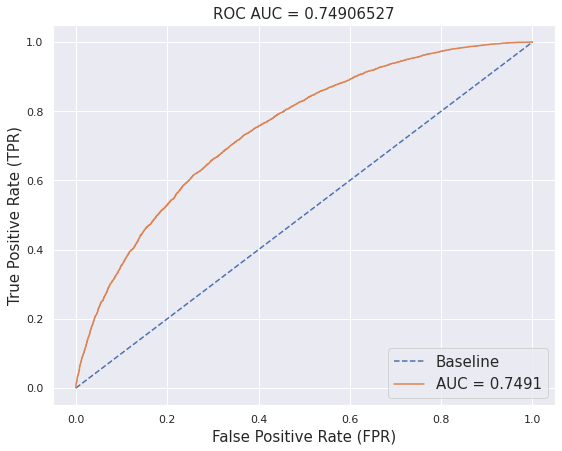

In [18]:
plot_roc_auc(
    y_train_us,
    LGBMClassifier(
        **{
            "lambda_l1": 1.470219280565269e-06,
            "lambda_l2": 1.7451260346532275e-07,
            "num_leaves": 9,
            "feature_fraction": 0.9229884275634851,
            "bagging_fraction": 0.5850431445914503,
            "bagging_freq": 5,
            "min_child_samples": 63,
        }
    )
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)  # kaggle 0.33825

[LightGBM] [Warning] bagging_fraction is set=0.7039470678830023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039470678830023
[LightGBM] [Warning] lambda_l1 is set=1.6758594914477627e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6758594914477627e-05
[LightGBM] [Warning] feature_fraction is set=0.4030892028571655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4030892028571655
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.555459299457268e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.555459299457268e-07


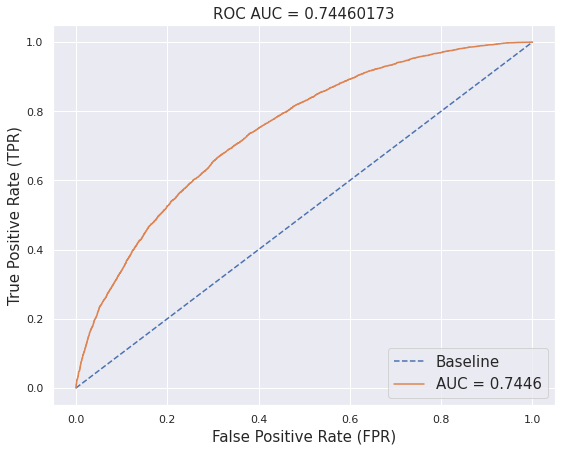

In [46]:
plot_roc_auc(
    y_train_us,
    LGBMClassifier(
        **{
            "lambda_l1": 1.6758594914477627e-05,
            "lambda_l2": 1.555459299457268e-07,
            "num_leaves": 8,
            "feature_fraction": 0.4030892028571655,
            "bagging_fraction": 0.7039470678830023,
            "bagging_freq": 3,
            "min_child_samples": 27,
        }
    )
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)  # kaggle 0.34004 <-------------------- пока самый лучший

# final model

In [19]:
# model = LGBMClassifier() # kaggle 0.33657
# model = CatBoostClassifier() # kaggle 0.33794
# model = LogisticRegression(solver='saga', max_iter=1000, random_state=random_seed) # kaggle 0.33933

# model = LGBMClassifier(
#     **{
#         "lambda_l1": 6.636833602368837,
#         "lambda_l2": 0.3221308023736357,
#         "num_leaves": 100,
#         "feature_fraction": 0.4172192685978952,
#         "bagging_fraction": 0.6148275061564304,
#         "bagging_freq": 1,
#         "min_child_samples": 86,
#     }
# )  # kaggle 0.33999

model = LGBMClassifier(
    **{
        "lambda_l1": 1.6758594914477627e-05,
        "lambda_l2": 1.555459299457268e-07,
        "num_leaves": 8,
        "feature_fraction": 0.4030892028571655,
        "bagging_fraction": 0.7039470678830023,
        "bagging_freq": 3,
        "min_child_samples": 27,
    }
)  # kaggle 0.34004

# model = LGBMClassifier(
#     **{
#         "lambda_l1": 1.470219280565269e-06,
#         "lambda_l2": 1.7451260346532275e-07,
#         "num_leaves": 9,
#         "feature_fraction": 0.9229884275634851,
#         "bagging_fraction": 0.5850431445914503,
#         "bagging_freq": 5,
#         "min_child_samples": 63,
#     }
# ) # kaggle 0.33825

# model.fit(X_us, y_us)
model.fit(
    X_train_us, y_train_us
)  # понятия не имею почему, но это ВСЕГДА даёт результаты лучше, чем учить на всём доступном трейне
predict_submission = model.predict(test_data)

[LightGBM] [Warning] bagging_fraction is set=0.5850431445914503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5850431445914503
[LightGBM] [Warning] lambda_l1 is set=1.470219280565269e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.470219280565269e-06
[LightGBM] [Warning] feature_fraction is set=0.9229884275634851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9229884275634851
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.7451260346532275e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7451260346532275e-07


# submision

In [20]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)

In [49]:
# !kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"

# Kaggle score: $0.34004$